# Import


In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 38.4 MB/s 


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torchmetrics import F1Score, Recall, Accuracy
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
import re
from collections import Counter
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive


# Prepearing text

In [3]:
def prepearing_text(file_name):
  with open(f'/content/drive/MyDrive/Диплом/Code/data/{file_name}', 'r', encoding='utf-8') as f:
    data = f.read()
    data = json.loads(data)
  data_tokenized = []
  targets = []
  for prev, sent in data:
    prev_tokenized = []
    for s in prev:
      s = re.sub('-B|-I', '', s)
      s = s.lower()
      prev_tokenized.extend(word_tokenize(s))
    sent_tokenized = word_tokenize(sent)
    sent_targets = []
    for word in sent_tokenized:
      if word.endswith('-B'):
        sent_targets.append('B')
      elif word.endswith('-I'):
        sent_targets.append('I')
      else:
        sent_targets.append('O')
    sent_tokenized = re.sub('-B|-I', '', sent)
    sent_tokenized = sent_tokenized.lower()
    sent_tokenized = word_tokenize(sent_tokenized)
    data_tokenized.append((prev_tokenized, sent_tokenized))
    targets.append(sent_targets)

  vocab = []
  [vocab.extend(text[0]) for text in data_tokenized]
  vocab = Counter(vocab)
  word2id = {'PAD': 0}
  for word in vocab:
      word2id[word] = len(word2id)
  word2id['UNK'] = len(word2id)
  id2word = {i: word for word, i in word2id.items()}

  subject2id = {'O': 0, 'B': 1, 'I': 2}
  id2subject = {0: 'O', 1: 'B', 2: 'I'}

  return data_tokenized, targets, word2id, id2word, subject2id, id2subject

# Data

In [4]:
class SubDataset(Dataset):
    def __init__(self, word2id, subject2id, data, targets, DEVICE):
        super().__init__()
        self.y = deepcopy(targets)
        self.device = DEVICE
        self.X = deepcopy(data)
        self.word2id = word2id
        self.vocab_size = len(word2id)
        self.subject2id = subject2id
    
    def __getitem__(self, index):
        x_prev = deepcopy((self.X[index][0]))
        x = deepcopy(self.X[index][1])
        y = deepcopy(self.y[index])
        for num, word in enumerate(x_prev):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x_prev[num] = word
        for num, word in enumerate(x):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x[num] = word
        y = [self.subject2id[tag] for tag in y]
        x_prev = torch.LongTensor(x_prev)
        x = torch.LongTensor(x)
        y = torch.LongTensor(y)
        return x_prev, x, y
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        x_prevs = []
        xs = []
        ys = []
        for x_prev, x, y in batch:
          x_prevs.append(x_prev)
          xs.append(x)
          ys.append(y)
        # batch_size x longest_sequence
        x_prevs = pad_sequence(x_prevs, batch_first=True).to(self.device)
        xs = pad_sequence(xs, batch_first=True).to(self.device)
        ys = pad_sequence(ys, batch_first=True).to(self.device)
        return x_prevs, xs, ys

# RNN

In [ ]:
class BiRNN_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.rnn = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.rnn_bi = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.rnn_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# GRU

In [5]:
class BiGRU_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.gru_bi = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.gru_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# LSTM

In [ ]:
class BiLSTM_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.lstm= nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.lstm_bi = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        c_n = torch.cat([c_n, new_dir], dim=0)
        output, _ = self.lstm_bi(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Training and evaluating functions

In [6]:
def train(model, iterator, optimizer, criterion, device=DEVICE):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (prev, text, y) in tqdm(enumerate(iterator)): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        pred = model(prev, text)  #прогоняем данные через модель
        shape = pred.shape
        loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i + 1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion, f1, accuracy):
    epoch_loss = 0
    epoch_f1 = 0
    epoch_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (prev, text, y) in tqdm(enumerate(iterator)):   
            pred = model(prev, text)  # делаем предсказания на тесте
            shape = pred.shape
            loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            pred_tag = torch.argmax(pred.reshape(shape[0] * shape[1], 3), dim=1)
            epoch_f1 += f1(preds=pred_tag, target=y.reshape(-1).long()).item()
            epoch_accuracy += accuracy(preds=pred_tag, target=y.reshape(-1).long()).item()

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i + 1)}, Val f1: {epoch_f1/(i + 1)}, Val accuracy: {epoch_accuracy/(i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_f1 / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

# Experiment 1.1
RNN: 2 sentences, 10 tokens

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_10_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiRNN_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 34.76it/s]

Train loss: 0.8580516311857436


94it [00:02, 34.18it/s]

Train loss: 0.8641942077212863


142it [00:04, 35.01it/s]

Train loss: 0.8543745915095011


186it [00:05, 33.28it/s]

Train loss: 0.8513144721587499


226it [00:06, 33.26it/s]


Train loss: 0.8442649173736573

Evaluating on train...


50it [00:01, 44.14it/s]

Val loss: 0.8574795034196642, Val f1: 0.33316848741637334, Val accuracy: 0.33332777420679727


97it [00:02, 36.79it/s]

Val loss: 0.8383685840500725, Val f1: 0.347989508178499, Val accuracy: 0.34813592665725285


141it [00:04, 37.65it/s]

Val loss: 0.8401508225335015, Val f1: 0.3628011765303435, Val accuracy: 0.3629540452250728


185it [00:05, 37.18it/s]

Val loss: 0.8394575923681259, Val f1: 0.3739129179053836, Val accuracy: 0.3740671096576585


226it [00:06, 35.33it/s]


Val loss: 0.8443681703673469, Val f1: 0.3716884211699168, Val accuracy: 0.3718462822172377

Evaluating on test...


20it [00:00, 35.04it/s]

Val loss: 0.8210799098014832, Val f1: 0.33318861524264015, Val accuracy: 0.33333044648170473


36it [00:01, 35.98it/s]

Val loss: 0.8153967340787251, Val f1: 0.3554172456264496, Val accuracy: 0.35555411676565807


52it [00:01, 36.61it/s]

Val loss: 0.8474060747358534, Val f1: 0.34798201653692457, Val accuracy: 0.3481439736154344


64it [00:01, 35.49it/s]

Val loss: 0.8531929343938828, Val f1: 0.344272676606973, Val accuracy: 0.34444131602843603


76it [00:02, 36.27it/s]


Val loss: 0.8555573113759358, Val f1: 0.34205050905545553, Val accuracy: 0.34221972147623697

starting Epoch 1
Training...


48it [00:01, 33.52it/s]

Train loss: 0.8522589802742004


96it [00:02, 32.52it/s]

Train loss: 0.8522003743383619


140it [00:04, 34.83it/s]

Train loss: 0.82805543784742


184it [00:05, 33.05it/s]

Train loss: 0.8090747985574934


226it [00:06, 32.95it/s]


Train loss: 0.7859224756558736

Evaluating on train...


50it [00:01, 42.95it/s]

Val loss: 0.6548030720816718, Val f1: 0.34075146383709376, Val accuracy: 0.8326232347223493


95it [00:02, 39.46it/s]

Val loss: 0.6473219156265259, Val f1: 0.34021705587704976, Val accuracy: 0.8512072076400121


141it [00:03, 38.80it/s]

Val loss: 0.648803135642299, Val f1: 0.3398181422992989, Val accuracy: 0.8426149955502262


186it [00:04, 38.07it/s]

Val loss: 0.643827137682173, Val f1: 0.33939067224661507, Val accuracy: 0.8435706155167686


226it [00:05, 39.13it/s]


Val loss: 0.6434795151816474, Val f1: 0.3394980918036567, Val accuracy: 0.8414078602525923

Evaluating on test...


20it [00:00, 36.06it/s]

Val loss: 0.6370383858680725, Val f1: 0.33934300144513446, Val accuracy: 0.8786216855049134


36it [00:01, 36.09it/s]

Val loss: 0.6469830115636189, Val f1: 0.3405592272679011, Val accuracy: 0.8749930838743846


52it [00:01, 37.34it/s]

Val loss: 0.6573339846399096, Val f1: 0.34030463231934444, Val accuracy: 0.8565987308820089


64it [00:01, 36.47it/s]

Val loss: 0.6543535431226094, Val f1: 0.33970360706249875, Val accuracy: 0.846537875632445


76it [00:02, 36.21it/s]


Val loss: 0.6530081129074097, Val f1: 0.33908252278963724, Val accuracy: 0.8452331113815308

starting Epoch 2
Training...


52it [00:01, 33.86it/s]

Train loss: 0.6500965846909417


92it [00:02, 33.78it/s]

Train loss: 0.6310165776146783


140it [00:04, 33.27it/s]

Train loss: 0.6250116922237255


184it [00:05, 34.31it/s]

Train loss: 0.6237255629565981


226it [00:06, 32.84it/s]


Train loss: 0.6232378101348877

Evaluating on train...


50it [00:01, 44.65it/s]

Val loss: 0.5975636707411872, Val f1: 0.3700211253431108, Val accuracy: 0.8742872012986077


95it [00:02, 41.12it/s]

Val loss: 0.5951316634813945, Val f1: 0.3707684937450621, Val accuracy: 0.9026452435387505


142it [00:03, 38.32it/s]

Val loss: 0.6003593877509789, Val f1: 0.37067602652090564, Val accuracy: 0.892829774485694


186it [00:04, 38.13it/s]

Val loss: 0.6024715771277745, Val f1: 0.37101179444127613, Val accuracy: 0.8796163004305627


226it [00:05, 39.81it/s]


Val loss: 0.6009181152449714, Val f1: 0.37078847726186115, Val accuracy: 0.8897936495145162

Evaluating on test...


20it [00:00, 36.62it/s]

Val loss: 0.6324320991834005, Val f1: 0.3643237312634786, Val accuracy: 0.8445349593957265


36it [00:00, 36.68it/s]

Val loss: 0.6210232555866242, Val f1: 0.3656189153591792, Val accuracy: 0.8776970595121384


52it [00:01, 36.27it/s]

Val loss: 0.6272697647412618, Val f1: 0.3676548143227895, Val accuracy: 0.8459630621804132


64it [00:01, 35.86it/s]

Val loss: 0.6282098919153214, Val f1: 0.3694249783953031, Val accuracy: 0.8500212579965591


76it [00:02, 36.58it/s]


Val loss: 0.6222269082069397, Val f1: 0.3683583068847656, Val accuracy: 0.8563302894433339

starting Epoch 3
Training...


51it [00:01, 31.97it/s]

Train loss: 0.6029593149820963


95it [00:02, 33.29it/s]

Train loss: 0.6024203048812018


139it [00:04, 34.66it/s]

Train loss: 0.6022603101200528


183it [00:05, 33.45it/s]

Train loss: 0.6005861202875773


226it [00:06, 32.67it/s]


Train loss: 0.5990580730968051

Evaluating on train...


50it [00:01, 43.87it/s]

Val loss: 0.5754472136497497, Val f1: 0.4176238165961372, Val accuracy: 0.950079533788893


95it [00:02, 40.45it/s]

Val loss: 0.5849163426293267, Val f1: 0.41645296381579505, Val accuracy: 0.9466867334312863


141it [00:03, 38.29it/s]

Val loss: 0.5833767860024064, Val f1: 0.4139737186608491, Val accuracy: 0.9360181676016913


186it [00:04, 37.00it/s]

Val loss: 0.5842924849854575, Val f1: 0.41384879251321155, Val accuracy: 0.9371050324704912


226it [00:05, 39.37it/s]


Val loss: 0.5831476132074992, Val f1: 0.4138100965817769, Val accuracy: 0.9376511491669549

Evaluating on test...


20it [00:00, 35.05it/s]

Val loss: 0.5955227971076965, Val f1: 0.40199244022369385, Val accuracy: 0.8808088680108388


36it [00:01, 36.18it/s]

Val loss: 0.6068433860937754, Val f1: 0.39940588772296903, Val accuracy: 0.8669747740030289


52it [00:01, 36.24it/s]

Val loss: 0.6048175772031148, Val f1: 0.4038177947203318, Val accuracy: 0.8571701056427425


64it [00:01, 36.79it/s]

Val loss: 0.6086748470862706, Val f1: 0.40581923226515454, Val accuracy: 0.8595113749305408


76it [00:02, 36.27it/s]


Val loss: 0.6092916162808736, Val f1: 0.40529109597206114, Val accuracy: 0.8633830734093983

starting Epoch 4
Training...


52it [00:01, 33.96it/s]

Train loss: 0.5845964723163181


96it [00:03, 32.97it/s]

Train loss: 0.5883538007736206


140it [00:04, 33.38it/s]

Train loss: 0.5886930461283083


184it [00:05, 33.84it/s]

Train loss: 0.5874766707420349


226it [00:06, 32.91it/s]


Train loss: 0.5870252887407938

Evaluating on train...


50it [00:01, 44.24it/s]

Val loss: 0.5839961621496412, Val f1: 0.4442305054929521, Val accuracy: 0.9447942455609639


95it [00:02, 42.40it/s]

Val loss: 0.5791513297292922, Val f1: 0.44273843566576637, Val accuracy: 0.9394984102911419


140it [00:03, 41.07it/s]

Val loss: 0.5767883084438465, Val f1: 0.4445287490332568, Val accuracy: 0.9394586426240427


185it [00:04, 36.76it/s]

Val loss: 0.5776584350400501, Val f1: 0.4427493734492196, Val accuracy: 0.9282282865709729


226it [00:05, 40.04it/s]


Val loss: 0.5782986132303873, Val f1: 0.44208277000321283, Val accuracy: 0.9298723746670617

Evaluating on test...


20it [00:00, 37.86it/s]

Val loss: 0.6087307453155517, Val f1: 0.43331280748049417, Val accuracy: 0.9156633615493774


36it [00:00, 35.85it/s]

Val loss: 0.6101129849751791, Val f1: 0.4378073066473007, Val accuracy: 0.8816735297441483


52it [00:01, 36.14it/s]

Val loss: 0.6006706092092726, Val f1: 0.43894818358951143, Val accuracy: 0.9056383417712317


64it [00:01, 36.75it/s]

Val loss: 0.6054626703262329, Val f1: 0.42852418025334676, Val accuracy: 0.8882266332705816


76it [00:02, 36.79it/s]


Val loss: 0.6052179972330729, Val f1: 0.4252760895093282, Val accuracy: 0.8754113070170084

starting Epoch 5
Training...


50it [00:01, 34.29it/s]

Train loss: 0.5869749969906277


94it [00:02, 35.33it/s]

Train loss: 0.5830313232209947


142it [00:04, 34.01it/s]

Train loss: 0.5843103713459439


186it [00:05, 33.52it/s]

Train loss: 0.5831712322102652


226it [00:06, 33.17it/s]


Train loss: 0.5810151166386075

Evaluating on train...


49it [00:01, 42.25it/s]

Val loss: 0.5796769234869216, Val f1: 0.5089211391078101, Val accuracy: 0.9351590189668867


94it [00:02, 40.11it/s]

Val loss: 0.5764359123176999, Val f1: 0.509089727865325, Val accuracy: 0.9384636329280005


141it [00:03, 40.12it/s]

Val loss: 0.5790202374811526, Val f1: 0.5117201248804728, Val accuracy: 0.9373786632661466


186it [00:04, 37.79it/s]

Val loss: 0.5800858418146769, Val f1: 0.5105688707696067, Val accuracy: 0.9292361478010813


226it [00:05, 39.55it/s]


Val loss: 0.5789183775583903, Val f1: 0.5077034038967556, Val accuracy: 0.9246840230623881

Evaluating on test...


20it [00:00, 35.97it/s]

Val loss: 0.6257894555727641, Val f1: 0.46166043281555175, Val accuracy: 0.8102706670761108


36it [00:00, 36.31it/s]

Val loss: 0.6209834297498067, Val f1: 0.47084998389085136, Val accuracy: 0.8306316534678141


52it [00:01, 35.93it/s]

Val loss: 0.6117752061949836, Val f1: 0.4697049266762204, Val accuracy: 0.8244162691964043


64it [00:01, 37.03it/s]

Val loss: 0.6141824712355931, Val f1: 0.47979859461387, Val accuracy: 0.8429758747418722


76it [00:02, 36.80it/s]


Val loss: 0.614728193283081, Val f1: 0.47802804430325824, Val accuracy: 0.8440944012006124

starting Epoch 6
Training...


49it [00:01, 33.55it/s]

Train loss: 0.5832671085993449


97it [00:02, 34.18it/s]

Train loss: 0.5791869892014397


141it [00:04, 34.18it/s]

Train loss: 0.5765335785018073


185it [00:05, 33.30it/s]

Train loss: 0.5779415773020851


226it [00:06, 33.10it/s]


Train loss: 0.5760673101743062

Evaluating on train...


50it [00:01, 43.97it/s]

Val loss: 0.5726595467991299, Val f1: 0.542871747414271, Val accuracy: 0.9678522441122267


95it [00:02, 41.00it/s]

Val loss: 0.5710170752472348, Val f1: 0.5364677435821957, Val accuracy: 0.9550419959757063


140it [00:03, 40.23it/s]

Val loss: 0.5770360385930097, Val f1: 0.5421560274230109, Val accuracy: 0.9488647297576621


186it [00:04, 38.29it/s]

Val loss: 0.5792839119831721, Val f1: 0.5371909878320165, Val accuracy: 0.9372903189725346


226it [00:05, 39.82it/s]


Val loss: 0.5767581250932482, Val f1: 0.5360144902600182, Val accuracy: 0.9392014700836605

Evaluating on test...


20it [00:00, 34.32it/s]

Val loss: 0.6273162921269735, Val f1: 0.4997892995675405, Val accuracy: 0.8466413656870524


36it [00:01, 35.37it/s]

Val loss: 0.6095767855644226, Val f1: 0.5046037127574284, Val accuracy: 0.887700492143631


52it [00:01, 35.06it/s]

Val loss: 0.6111629393365648, Val f1: 0.5075729999277326, Val accuracy: 0.890641266769833


64it [00:01, 35.27it/s]

Val loss: 0.6100854237874349, Val f1: 0.5059856613477071, Val accuracy: 0.8818697835008303


76it [00:02, 35.18it/s]


Val loss: 0.6087403559684753, Val f1: 0.5034436972935995, Val accuracy: 0.8802354208628337

starting Epoch 7
Training...


47it [00:01, 33.04it/s]

Train loss: 0.5681983497407701


94it [00:03, 31.21it/s]

Train loss: 0.5695079651143816


138it [00:04, 32.51it/s]

Train loss: 0.5708808152763932


183it [00:06, 24.02it/s]

Train loss: 0.5732685830858019


226it [00:08, 27.00it/s]


Train loss: 0.5751274453269111

Evaluating on train...


48it [00:01, 25.07it/s]

Val loss: 0.5705188658502367, Val f1: 0.48607026007440357, Val accuracy: 0.9739432586563959


90it [00:03, 23.38it/s]

Val loss: 0.5724181791146596, Val f1: 0.486317041516304, Val accuracy: 0.957072667280833


138it [00:05, 34.17it/s]

Val loss: 0.5709222197532654, Val f1: 0.48487483307167334, Val accuracy: 0.9519162635008495


186it [00:06, 35.08it/s]

Val loss: 0.5691229942772124, Val f1: 0.48678087724579705, Val accuracy: 0.957037983669175


226it [00:08, 27.77it/s]


Val loss: 0.5700997243987189, Val f1: 0.482029041979048, Val accuracy: 0.9556041942702399

Evaluating on test...


17it [00:00, 19.36it/s]

Val loss: 0.5723221898078918, Val f1: 0.4917235712210337, Val accuracy: 0.928786971171697


32it [00:01, 21.50it/s]

Val loss: 0.5923118631045023, Val f1: 0.45943756997585294, Val accuracy: 0.88528340558211


47it [00:02, 22.77it/s]

Val loss: 0.5979535473717583, Val f1: 0.4528488152556949, Val accuracy: 0.8686656196912129


62it [00:02, 21.57it/s]

Val loss: 0.5967267841100693, Val f1: 0.4493907541036606, Val accuracy: 0.8863972763220469


76it [00:03, 21.25it/s]


Val loss: 0.5931252392133077, Val f1: 0.45333440860112506, Val accuracy: 0.898815811475118

starting Epoch 8
Training...


47it [00:02, 20.91it/s]

Train loss: 0.561676291624705


96it [00:04, 32.99it/s]

Train loss: 0.5691004084216224


139it [00:05, 22.76it/s]

Train loss: 0.5721534587718823


182it [00:07, 22.85it/s]

Train loss: 0.5722902251614465


226it [00:09, 23.41it/s]


Train loss: 0.5728185150358412

Evaluating on train...


48it [00:02, 23.29it/s]

Val loss: 0.5703907940122817, Val f1: 0.42215723594029747, Val accuracy: 0.9270711991522047


93it [00:03, 22.46it/s]

Val loss: 0.5716048167811499, Val f1: 0.42688028216362, Val accuracy: 0.9456555866532855


138it [00:05, 29.60it/s]

Val loss: 0.5730183084805807, Val f1: 0.42635442658706946, Val accuracy: 0.9301385619022228


186it [00:07, 33.86it/s]

Val loss: 0.5713691112067965, Val f1: 0.4260452714231279, Val accuracy: 0.937166389491823


226it [00:08, 26.91it/s]


Val loss: 0.5713781155480279, Val f1: 0.42535429649882844, Val accuracy: 0.9385157092412313

Evaluating on test...


20it [00:00, 34.59it/s]

Val loss: 0.5983926971753438, Val f1: 0.39716092149416604, Val accuracy: 0.8805066148440043


36it [00:01, 36.39it/s]

Val loss: 0.5870910425980885, Val f1: 0.40186237494150795, Val accuracy: 0.9039933115243912


52it [00:01, 36.59it/s]

Val loss: 0.5900563703642951, Val f1: 0.40873554878764684, Val accuracy: 0.9171458741029104


64it [00:01, 35.94it/s]

Val loss: 0.59057876765728, Val f1: 0.4111496021350225, Val accuracy: 0.923055783410867


76it [00:02, 36.02it/s]


Val loss: 0.5896184595425924, Val f1: 0.41287434538205464, Val accuracy: 0.920173849662145

starting Epoch 9
Training...


51it [00:01, 33.13it/s]

Train loss: 0.5639756348397996


95it [00:02, 32.55it/s]

Train loss: 0.570070798529519


139it [00:04, 34.02it/s]

Train loss: 0.5727235643951981


183it [00:05, 32.76it/s]

Train loss: 0.5715226802561019


226it [00:06, 32.54it/s]


Train loss: 0.5718054615126715

Evaluating on train...


49it [00:01, 42.99it/s]

Val loss: 0.5719560066858927, Val f1: 0.479872825410631, Val accuracy: 0.9579739696449704


97it [00:02, 38.26it/s]

Val loss: 0.5721282674206628, Val f1: 0.4756023320886824, Val accuracy: 0.9576575070619583


141it [00:03, 38.01it/s]

Val loss: 0.5695138670780041, Val f1: 0.48065847003901446, Val accuracy: 0.9547831550792412


185it [00:04, 36.98it/s]

Val loss: 0.569105483757125, Val f1: 0.4810915069447623, Val accuracy: 0.9496688947081566


226it [00:05, 38.02it/s]


Val loss: 0.567672713862525, Val f1: 0.48141644438107806, Val accuracy: 0.9516850859589047

Evaluating on test...


18it [00:00, 28.29it/s]

Val loss: 0.5991881330808003, Val f1: 0.45434882044792174, Val accuracy: 0.9290479858716328


33it [00:01, 21.60it/s]

Val loss: 0.595243239402771, Val f1: 0.45433728297551473, Val accuracy: 0.913270037372907


48it [00:02, 21.28it/s]

Val loss: 0.5909982019000584, Val f1: 0.44533353514141505, Val accuracy: 0.9257256090641022


63it [00:02, 23.58it/s]

Val loss: 0.5926389406124751, Val f1: 0.4493006070454915, Val accuracy: 0.9150400663415591


76it [00:03, 22.49it/s]


Val loss: 0.5915519126256307, Val f1: 0.4489736020565033, Val accuracy: 0.919845427274704

starting Epoch 10
Training...


47it [00:02, 18.58it/s]

Train loss: 0.5749704493416681


93it [00:04, 21.06it/s]

Train loss: 0.5713883923159705


139it [00:06, 30.35it/s]

Train loss: 0.5721207256670351


183it [00:07, 33.55it/s]

Train loss: 0.5705642753177219


226it [00:09, 24.47it/s]


Train loss: 0.5701707408163282

Evaluating on train...


50it [00:01, 42.72it/s]

Val loss: 0.5663289679421319, Val f1: 0.4735262672106425, Val accuracy: 0.935243872139189


94it [00:02, 39.13it/s]

Val loss: 0.5676046709219614, Val f1: 0.4750352558162477, Val accuracy: 0.932274670071072


142it [00:03, 36.93it/s]

Val loss: 0.5664402352439033, Val f1: 0.4770427010677479, Val accuracy: 0.9457602518576163


186it [00:04, 36.91it/s]

Val loss: 0.567769655585289, Val f1: 0.4804491980208291, Val accuracy: 0.9515855143467585


226it [00:05, 38.18it/s]


Val loss: 0.5669706265131632, Val f1: 0.4854570523897807, Val accuracy: 0.9557318488756815

Evaluating on test...


20it [00:00, 35.80it/s]

Val loss: 0.5846322496732076, Val f1: 0.43573078513145447, Val accuracy: 0.8371132453282674


36it [00:01, 35.25it/s]

Val loss: 0.5887058655420939, Val f1: 0.4424164265394211, Val accuracy: 0.8732876509428025


52it [00:01, 34.54it/s]

Val loss: 0.5884226626820035, Val f1: 0.4517420099841224, Val accuracy: 0.8883351782957712


64it [00:01, 33.87it/s]

Val loss: 0.5954084247350693, Val f1: 0.45191678901513416, Val accuracy: 0.8828651045759519


76it [00:02, 35.11it/s]


Val loss: 0.5902866816520691, Val f1: 0.4516636614004771, Val accuracy: 0.9012289265791575

starting Epoch 11
Training...


51it [00:01, 31.88it/s]

Train loss: 0.5585755242241753


95it [00:03, 32.98it/s]

Train loss: 0.5658938189347585


139it [00:04, 31.90it/s]

Train loss: 0.5695895773393137


183it [00:05, 32.73it/s]

Train loss: 0.5692198981841405


226it [00:07, 32.03it/s]


Train loss: 0.5710744831297133

Evaluating on train...


52it [00:01, 42.00it/s]

Val loss: 0.570195832517412, Val f1: 0.4800429165363312, Val accuracy: 0.9734201497501798


96it [00:02, 38.38it/s]

Val loss: 0.5688640488518609, Val f1: 0.480777269270685, Val accuracy: 0.9751547767056359


140it [00:03, 37.94it/s]

Val loss: 0.5670757377589191, Val f1: 0.46576945185661317, Val accuracy: 0.9498232040140364


184it [00:04, 34.52it/s]

Val loss: 0.5665365152888828, Val f1: 0.4633143620358573, Val accuracy: 0.9478915699654156


226it [00:06, 37.04it/s]


Val loss: 0.5669631875885858, Val f1: 0.46183318469259477, Val accuracy: 0.9479841009775798

Evaluating on test...


20it [00:00, 33.87it/s]

Val loss: 0.582653534412384, Val f1: 0.4292094767093658, Val accuracy: 0.9293420791625977


36it [00:01, 34.53it/s]

Val loss: 0.5899625579516093, Val f1: 0.41893818775812786, Val accuracy: 0.9042126099268596


52it [00:01, 34.96it/s]

Val loss: 0.5874002284473843, Val f1: 0.42456822991371157, Val accuracy: 0.9186776532067193


64it [00:01, 34.32it/s]

Val loss: 0.5902665654818217, Val f1: 0.4199399967988332, Val accuracy: 0.8989106645186742


76it [00:02, 34.47it/s]


Val loss: 0.5895314717292786, Val f1: 0.42603481968243917, Val accuracy: 0.9092799735069275

starting Epoch 12
Training...


50it [00:01, 31.68it/s]

Train loss: 0.5675730625788371


94it [00:03, 33.52it/s]

Train loss: 0.5727594918674893


138it [00:04, 32.23it/s]

Train loss: 0.5717349502775404


186it [00:05, 31.69it/s]

Train loss: 0.5706245856152641


226it [00:07, 31.71it/s]


Train loss: 0.5707557792133755

Evaluating on train...


49it [00:01, 42.56it/s]

Val loss: 0.56600261926651, Val f1: 0.4398872249656253, Val accuracy: 0.9107003913985359


95it [00:02, 37.71it/s]

Val loss: 0.5645684083302815, Val f1: 0.43994017210271624, Val accuracy: 0.9339987615744273


139it [00:03, 36.02it/s]

Val loss: 0.5650363595397384, Val f1: 0.435238328244951, Val accuracy: 0.9276802897453308


187it [00:04, 35.97it/s]

Val loss: 0.5671550694439146, Val f1: 0.43756921274794475, Val accuracy: 0.9377820952071084


226it [00:06, 37.63it/s]


Val loss: 0.5686862323019239, Val f1: 0.4390726715988583, Val accuracy: 0.9399795709715949

Evaluating on test...


20it [00:00, 35.07it/s]

Val loss: 0.5783704082171123, Val f1: 0.40060009558995563, Val accuracy: 0.9144937078158061


36it [00:01, 36.02it/s]

Val loss: 0.5870966017246246, Val f1: 0.40604760547478996, Val accuracy: 0.8978997141122818


52it [00:01, 36.14it/s]

Val loss: 0.5870297577646043, Val f1: 0.4091083745161692, Val accuracy: 0.9148473097218408


64it [00:01, 36.06it/s]

Val loss: 0.590783370534579, Val f1: 0.4101018006602923, Val accuracy: 0.9090382918715477


76it [00:02, 35.73it/s]


Val loss: 0.5904126620292663, Val f1: 0.41141077081362404, Val accuracy: 0.8996614507834116

starting Epoch 13
Training...


48it [00:01, 31.83it/s]

Train loss: 0.5782481604152255


96it [00:03, 33.29it/s]

Train loss: 0.5718165338039398


140it [00:04, 32.54it/s]

Train loss: 0.569103353994864


184it [00:05, 33.42it/s]

Train loss: 0.5686819112963146


226it [00:06, 32.49it/s]


Train loss: 0.5692515317598978

Evaluating on train...


49it [00:01, 42.01it/s]

Val loss: 0.5673194593853421, Val f1: 0.4924414939350552, Val accuracy: 0.9795354207356771


92it [00:02, 26.02it/s]

Val loss: 0.5671232521533967, Val f1: 0.4883189552360111, Val accuracy: 0.9793265528149075


136it [00:06,  9.33it/s]

Val loss: 0.5664569408805282, Val f1: 0.4842204652450703, Val accuracy: 0.9710963450096272


181it [00:09, 16.73it/s]

Val loss: 0.5652355829874675, Val f1: 0.4835503977206018, Val accuracy: 0.9558101740148333


226it [00:11, 18.94it/s]


Val loss: 0.5662742778990004, Val f1: 0.4798636864291297, Val accuracy: 0.9536744213104248

Evaluating on test...


17it [00:00, 16.44it/s]

Val loss: 0.6109475652376811, Val f1: 0.4173523704210917, Val accuracy: 0.8022717634836832


32it [00:01, 15.89it/s]

Val loss: 0.6068680127461751, Val f1: 0.42728609045346577, Val accuracy: 0.8562221149603526


48it [00:02, 18.82it/s]

Val loss: 0.6012572937541538, Val f1: 0.43667097091674806, Val accuracy: 0.8807452122370402


63it [00:03, 22.61it/s]

Val loss: 0.5953944633404414, Val f1: 0.44028150488932927, Val accuracy: 0.8793928821881613


76it [00:03, 19.22it/s]


Val loss: 0.5929051868120829, Val f1: 0.440532306432724, Val accuracy: 0.8918555283546448

starting Epoch 14
Training...


47it [00:02, 22.00it/s]

Train loss: 0.5634487946828206


92it [00:04, 21.37it/s]

Train loss: 0.5640991124841902


137it [00:06, 22.73it/s]

Train loss: 0.5656559635091711


182it [00:08, 21.39it/s]

Train loss: 0.5727494292789035


226it [00:10, 22.21it/s]


Train loss: 0.571821755303277

Evaluating on train...


45it [00:01, 18.49it/s]

Val loss: 0.5617842899428473, Val f1: 0.44149827890925936, Val accuracy: 0.9606720659467909


93it [00:05, 15.38it/s]

Val loss: 0.5652648912535774, Val f1: 0.4335657500558429, Val accuracy: 0.9260545525285933


138it [00:07, 27.54it/s]

Val loss: 0.566305759218004, Val f1: 0.43408202904242055, Val accuracy: 0.9296788776362384


183it [00:09, 22.12it/s]

Val loss: 0.5665889243284862, Val f1: 0.43521020859479903, Val accuracy: 0.9350636758738093


226it [00:11, 19.69it/s]


Val loss: 0.5674908473756578, Val f1: 0.43634469244215224, Val accuracy: 0.9377627730369568

Evaluating on test...


18it [00:00, 24.55it/s]

Val loss: 0.5990962147712707, Val f1: 0.4392139077186584, Val accuracy: 0.9307543714841207


33it [00:01, 24.87it/s]

Val loss: 0.5952337066332499, Val f1: 0.42381423513094585, Val accuracy: 0.9039408355951309


48it [00:01, 23.90it/s]

Val loss: 0.593727503882514, Val f1: 0.4121815827157762, Val accuracy: 0.912863505548901


63it [00:02, 24.02it/s]

Val loss: 0.5900337100028992, Val f1: 0.4069557383656502, Val accuracy: 0.9147130211194356


76it [00:03, 24.39it/s]


Val loss: 0.5908585675557454, Val f1: 0.40657719135284426, Val accuracy: 0.9019346435864767

starting Epoch 15
Training...


47it [00:02, 21.40it/s]

Train loss: 0.5631442772017585


93it [00:04, 22.45it/s]

Train loss: 0.5647841069433425


138it [00:06, 15.64it/s]

Train loss: 0.5697221680923744


184it [00:09, 20.82it/s]

Train loss: 0.5702624956766764


226it [00:11, 19.99it/s]


Train loss: 0.5687932260831197

Evaluating on train...


48it [00:01, 24.57it/s]

Val loss: 0.5690851476457384, Val f1: 0.5169344001346164, Val accuracy: 0.9306884268919627


91it [00:04, 15.35it/s]

Val loss: 0.5712649338775211, Val f1: 0.5045598414209154, Val accuracy: 0.9467509584294425


139it [00:06, 22.62it/s]

Val loss: 0.5709314628883645, Val f1: 0.5124181380978337, Val accuracy: 0.9506576668333124


184it [00:08, 24.74it/s]

Val loss: 0.5692085564136505, Val f1: 0.511092871427536, Val accuracy: 0.9379110185636415


226it [00:10, 21.46it/s]


Val loss: 0.5691297245025635, Val f1: 0.5092842213312785, Val accuracy: 0.9354191903273265

Evaluating on test...


18it [00:00, 24.15it/s]

Val loss: 0.5797585566838582, Val f1: 0.44654135902722675, Val accuracy: 0.935624098777771


33it [00:01, 24.56it/s]

Val loss: 0.580243174235026, Val f1: 0.45577185253302255, Val accuracy: 0.9212199827035268


48it [00:01, 24.51it/s]

Val loss: 0.5907656206025018, Val f1: 0.4612148602803548, Val accuracy: 0.9176811178525289


63it [00:02, 23.92it/s]

Val loss: 0.5933361331621806, Val f1: 0.46154658297697704, Val accuracy: 0.9181656698385875


76it [00:03, 24.16it/s]


Val loss: 0.5929793119430542, Val f1: 0.45538554231325784, Val accuracy: 0.9099370392163595

starting Epoch 16
Training...


48it [00:02, 29.40it/s]

Train loss: 0.5662192040019565


96it [00:03, 32.90it/s]

Train loss: 0.5675295809904735


140it [00:04, 33.38it/s]

Train loss: 0.5662004982983625


184it [00:06, 34.45it/s]

Train loss: 0.5674710677729713


226it [00:07, 29.97it/s]


Train loss: 0.5701493650012546

Evaluating on train...


49it [00:01, 44.63it/s]

Val loss: 0.5704338312149048, Val f1: 0.41034622655974495, Val accuracy: 0.924027309815089


94it [00:02, 40.18it/s]

Val loss: 0.5720799962679545, Val f1: 0.4070936110284593, Val accuracy: 0.9293753395477931


141it [00:03, 37.59it/s]

Val loss: 0.5732270633732831, Val f1: 0.411551829179128, Val accuracy: 0.928834100343563


185it [00:04, 37.46it/s]

Val loss: 0.5726213647259606, Val f1: 0.4134514621562428, Val accuracy: 0.9350845770703422


226it [00:05, 39.89it/s]


Val loss: 0.5726954094568888, Val f1: 0.41348388420210946, Val accuracy: 0.9385863444540236

Evaluating on test...


20it [00:00, 37.33it/s]

Val loss: 0.591900630791982, Val f1: 0.38330633044242857, Val accuracy: 0.9381267468134562


36it [00:00, 35.52it/s]

Val loss: 0.6028714418411255, Val f1: 0.38411854604880014, Val accuracy: 0.9203691184520721


52it [00:01, 35.66it/s]

Val loss: 0.5940542472733392, Val f1: 0.3878040333588918, Val accuracy: 0.9382321794827779


64it [00:01, 35.44it/s]

Val loss: 0.5909227818250656, Val f1: 0.39034383644660314, Val accuracy: 0.9467345784107845


76it [00:02, 36.51it/s]


Val loss: 0.5938202961285909, Val f1: 0.3897883232434591, Val accuracy: 0.9431825757026673

starting Epoch 17
Training...


51it [00:01, 33.27it/s]

Train loss: 0.5735378132926093


95it [00:02, 33.34it/s]

Train loss: 0.5701804949177636


139it [00:04, 32.91it/s]

Train loss: 0.5702995781545286


183it [00:05, 33.50it/s]

Train loss: 0.5712383346425163


226it [00:06, 32.68it/s]


Train loss: 0.5708084037568835

Evaluating on train...


50it [00:01, 42.17it/s]

Val loss: 0.5620067755381266, Val f1: 0.508112926615609, Val accuracy: 0.9867819441689385


95it [00:02, 41.62it/s]

Val loss: 0.5651738107204437, Val f1: 0.5093840327527788, Val accuracy: 0.9786549362871382


139it [00:03, 38.17it/s]

Val loss: 0.5651718598824961, Val f1: 0.5019594342620285, Val accuracy: 0.9692202082386723


185it [00:04, 38.81it/s]

Val loss: 0.5662255353397794, Val f1: 0.5011675900883145, Val accuracy: 0.9633606715334786


226it [00:05, 39.78it/s]


Val loss: 0.5661414657698737, Val f1: 0.4958772893746694, Val accuracy: 0.96097089515792

Evaluating on test...


20it [00:00, 36.49it/s]

Val loss: 0.5741256237030029, Val f1: 0.4349791506926219, Val accuracy: 0.9157066424687703


36it [00:00, 37.02it/s]

Val loss: 0.5790523449579875, Val f1: 0.43044417500495913, Val accuracy: 0.9372702618439992


52it [00:01, 36.49it/s]

Val loss: 0.5824829128053454, Val f1: 0.43326641784773934, Val accuracy: 0.9217613074514601


64it [00:01, 37.13it/s]

Val loss: 0.5890075484911601, Val f1: 0.43623497734467187, Val accuracy: 0.9224131236473719


76it [00:02, 36.43it/s]


Val loss: 0.5883785009384155, Val f1: 0.43720314820607503, Val accuracy: 0.9259236017862956

starting Epoch 18
Training...


51it [00:01, 33.17it/s]

Train loss: 0.5714369999037848


95it [00:03, 32.84it/s]

Train loss: 0.5695246524280972


139it [00:04, 34.10it/s]

Train loss: 0.5675002098083496


183it [00:05, 33.24it/s]

Train loss: 0.5685160322321786


226it [00:06, 32.89it/s]


Train loss: 0.5680528667238024

Evaluating on train...


50it [00:01, 43.73it/s]

Val loss: 0.5743002269003127, Val f1: 0.5460674100451999, Val accuracy: 0.9479407429695129


95it [00:02, 40.50it/s]

Val loss: 0.5680951641665565, Val f1: 0.5522524823745092, Val accuracy: 0.9517802566289901


140it [00:03, 36.64it/s]

Val loss: 0.5664338487165945, Val f1: 0.5426923548733746, Val accuracy: 0.9523309469223022


185it [00:04, 38.25it/s]

Val loss: 0.5664206673701604, Val f1: 0.5493608295917511, Val accuracy: 0.9556897908449173


226it [00:05, 39.28it/s]


Val loss: 0.5667440599865383, Val f1: 0.5477381912867229, Val accuracy: 0.9536336359712813

Evaluating on test...


20it [00:00, 35.79it/s]

Val loss: 0.5839912374814351, Val f1: 0.44002702037493385, Val accuracy: 0.855135440826416


36it [00:00, 36.75it/s]

Val loss: 0.5848051846027374, Val f1: 0.4491895943880081, Val accuracy: 0.8758346885442734


52it [00:01, 35.25it/s]

Val loss: 0.589627824889289, Val f1: 0.45549042887157865, Val accuracy: 0.8754086527559493


64it [00:01, 35.66it/s]

Val loss: 0.5942550440629323, Val f1: 0.45849527716636657, Val accuracy: 0.878944955766201


76it [00:02, 36.04it/s]


Val loss: 0.5977457070350647, Val f1: 0.4612989807128906, Val accuracy: 0.8840984570980072

starting Epoch 19
Training...


49it [00:01, 32.94it/s]

Train loss: 0.5657578640513949


93it [00:02, 33.11it/s]

Train loss: 0.5639801522095998


141it [00:04, 33.83it/s]

Train loss: 0.5686465916810213


185it [00:05, 33.33it/s]

Train loss: 0.5684489972061582


226it [00:06, 32.79it/s]


Train loss: 0.5690632234679328

Evaluating on train...


49it [00:01, 41.81it/s]

Val loss: 0.5669312000274658, Val f1: 0.43708902332517835, Val accuracy: 0.9672216514746348


94it [00:02, 39.01it/s]

Val loss: 0.5721885926193662, Val f1: 0.4375345531437132, Val accuracy: 0.9559602210919063


143it [00:03, 38.88it/s]

Val loss: 0.5707262304094103, Val f1: 0.4356377667850918, Val accuracy: 0.9585232895833474


187it [00:04, 36.81it/s]

Val loss: 0.568011419640647, Val f1: 0.43361254549688766, Val accuracy: 0.9675448306732708


226it [00:05, 38.79it/s]


Val loss: 0.5682464411523607, Val f1: 0.4327505173948076, Val accuracy: 0.9671904000971052

Evaluating on test...


19it [00:00, 35.79it/s]

Val loss: 0.6147400617599488, Val f1: 0.4065385123093923, Val accuracy: 0.8493426104386648


35it [00:00, 35.04it/s]

Val loss: 0.5943005343278249, Val f1: 0.3993574877580007, Val accuracy: 0.9150739918152492


51it [00:01, 36.23it/s]

Val loss: 0.5876277777883742, Val f1: 0.3989496568838755, Val accuracy: 0.9050512618488735


67it [00:01, 37.07it/s]

Val loss: 0.5868092020352681, Val f1: 0.3993204618493716, Val accuracy: 0.9186092585325241


76it [00:02, 35.99it/s]

Val loss: 0.5890723816553751, Val f1: 0.39961618940035504, Val accuracy: 0.9225055877367655


## Graphics

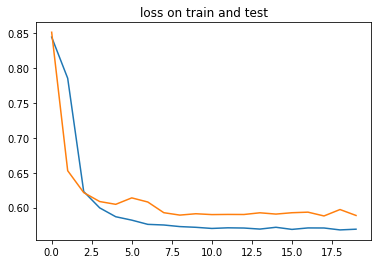

Last loss on train: 0.5690273901002597
Last loss on test: 0.5887189483956287


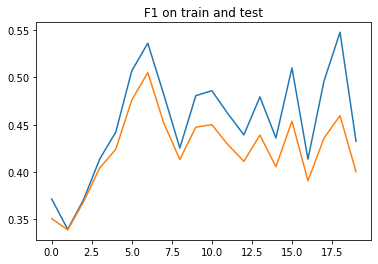

Last F1 on train: 0.43252466355277375
Last F1 on test: 0.40032643354252767


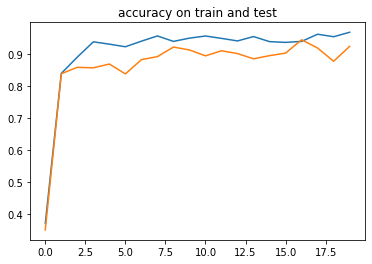

Last accuracy on train: 0.967319162941612
Last accuracy on test: 0.9233836382627487


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.7292920905127673


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

das-B stimmt-I nicht-I ,-O auch-O wenn-O ich-O nur-O die-O untere-O hälfte-O gesehen-O habe-O .-O
feuerwehrmann-O 2-O :-O spinnst-B du-I ?-O
oh-O nein-O ,-O ist-B schon-I gut-I .-O
hör-B auf-I !-O
--O ach-B ja-I ?-O
im-B ernst-I !-O
ist-B schon-I ok-I .-O
ich-B wusste-I es-I !-O
keine-B ahnung-I .-O
--O in-B ordnung-I .-O
sehr-B gern-I .-O
na-B und-I ?-O
--O ach-B was-I .-O
--O nicht-B wahr-I ?-O
--O ganz-B und-I gar-I nicht-I .-O
--O ich-B weiß-I .-O
stimmt-B 's-I ,-O herr-O doktor-O ?-O
na-B schön-I .-O
na-B dann-I .-O
keine-B ahnung-I .-O
--O ich-B weiß-I .-O
also-B gut-I .-O
schon-B gut-I .-O
glaub-B ich-I nicht-I .-O
wenn-O uns-O ein-O abwehrmechanismus-O durch-O schlechte-O zeiten-O hilft-O ,-O na-B und-I ?-O
--O na-B keine-I ahnung-I ,-O ey-O .-O
keine-B ahnung-I .-O
--O gute-B frage-I .-O
ja-O ,-O gute-B idee-I .-O
ich-B weiß-I !-O
--O sicher-B nicht-I .-O
schon-B gut-I .-O
ist-B schon-I gut-I .-O
--O kein-B problem-I ,-O terry-O .-O
--O ach-B so-I !-O
keine-B ahnung-I .-O
--O 

# Experiment 1.2 
0 tokens 1 sentence

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_1_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiRNN_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:01, 38.32it/s]

Train loss: 0.8297442581918505


94it [00:02, 39.11it/s]

Train loss: 0.7528006699350145


143it [00:03, 38.67it/s]

Train loss: 0.7172087638466447


184it [00:04, 39.41it/s]

Train loss: 0.694021005431811


226it [00:06, 37.56it/s]


Train loss: 0.6789223437839084

Evaluating on train...


50it [00:01, 48.49it/s]

Val loss: 0.6104403283860949, Val f1: 0.3430941210852729, Val accuracy: 0.8986651069588132


95it [00:01, 48.24it/s]

Val loss: 0.6129866765605079, Val f1: 0.3423032151328193, Val accuracy: 0.8986137105358971


140it [00:02, 44.78it/s]

Val loss: 0.6123920718828837, Val f1: 0.3414315731437118, Val accuracy: 0.9009627415074243


185it [00:03, 45.01it/s]

Val loss: 0.613282025191519, Val f1: 0.34120415283573996, Val accuracy: 0.9030974634819561


226it [00:04, 46.15it/s]


Val loss: 0.6126571708255344, Val f1: 0.34154885715908473, Val accuracy: 0.9036099894841512

Evaluating on test...


20it [00:00, 42.81it/s]

Val loss: 0.6245811263720195, Val f1: 0.3418778081734975, Val accuracy: 0.9082379897435506


35it [00:00, 42.88it/s]

Val loss: 0.6270891964435578, Val f1: 0.3417540301879247, Val accuracy: 0.905521672964096


50it [00:01, 42.61it/s]

Val loss: 0.6252499249246385, Val f1: 0.34197118083635963, Val accuracy: 0.9121105498737759


63it [00:01, 25.20it/s]

Val loss: 0.6238506108522415, Val f1: 0.34172225644191107, Val accuracy: 0.9185175220171611


76it [00:02, 35.67it/s]


Val loss: 0.6209220059712728, Val f1: 0.3416105175018311, Val accuracy: 0.9256486582756043

starting Epoch 1
Training...


53it [00:01, 39.00it/s]

Train loss: 0.6100470516416762


97it [00:02, 38.28it/s]

Train loss: 0.6093291984664069


141it [00:03, 40.44it/s]

Train loss: 0.6060438195864359


186it [00:04, 39.76it/s]

Train loss: 0.6034662905666563


226it [00:05, 38.53it/s]


Train loss: 0.601982872221205

Evaluating on train...


52it [00:01, 40.14it/s]

Val loss: 0.5821036881870694, Val f1: 0.36732292903794184, Val accuracy: 0.943482549322976


98it [00:02, 46.28it/s]

Val loss: 0.5844278275966645, Val f1: 0.36990155047840545, Val accuracy: 0.9489571899175644


143it [00:03, 45.14it/s]

Val loss: 0.5825843630013643, Val f1: 0.37079136724825257, Val accuracy: 0.9468482125688482


188it [00:04, 45.92it/s]

Val loss: 0.580833203262753, Val f1: 0.3727208798130353, Val accuracy: 0.9498629151119127


226it [00:05, 41.78it/s]


Val loss: 0.5840194437238905, Val f1: 0.37228019701109993, Val accuracy: 0.9457802882459428

Evaluating on test...


20it [00:00, 42.89it/s]

Val loss: 0.5983587185541789, Val f1: 0.36707966923713686, Val accuracy: 0.8745203276475271


35it [00:00, 41.37it/s]

Val loss: 0.5995164295037587, Val f1: 0.3675453652938207, Val accuracy: 0.8683023353417715


50it [00:01, 42.41it/s]

Val loss: 0.5973938054508633, Val f1: 0.3695851981639862, Val accuracy: 0.8808817585309346


65it [00:01, 41.37it/s]

Val loss: 0.6011923809846242, Val f1: 0.37010532021522524, Val accuracy: 0.8685086975495021


76it [00:01, 42.15it/s]


Val loss: 0.5976864528656006, Val f1: 0.3698611307144165, Val accuracy: 0.8882176756858826

starting Epoch 2
Training...


52it [00:01, 39.61it/s]

Train loss: 0.5857406576474508


96it [00:02, 38.81it/s]

Train loss: 0.5879744476742215


140it [00:03, 39.52it/s]

Train loss: 0.587751860971804


185it [00:04, 40.33it/s]

Train loss: 0.5852147330840428


226it [00:05, 38.63it/s]


Train loss: 0.5846697892083063

Evaluating on train...


55it [00:01, 51.95it/s]

Val loss: 0.575378331873152, Val f1: 0.40782635145717194, Val accuracy: 0.9541644394397736


97it [00:01, 51.70it/s]

Val loss: 0.573666693104638, Val f1: 0.40438347392612034, Val accuracy: 0.952582182486852


143it [00:02, 45.41it/s]

Val loss: 0.577838479148017, Val f1: 0.40366804577686166, Val accuracy: 0.9349352379639944


188it [00:03, 44.01it/s]

Val loss: 0.5774874293141895, Val f1: 0.40272672176361085, Val accuracy: 0.9314635935756895


226it [00:04, 46.92it/s]


Val loss: 0.5756150870853001, Val f1: 0.40555389364560446, Val accuracy: 0.9359479504161411

Evaluating on test...


20it [00:00, 42.44it/s]

Val loss: 0.6058020909627279, Val f1: 0.4155415912469228, Val accuracy: 0.9168230215708415


35it [00:00, 43.61it/s]

Val loss: 0.5996717790762583, Val f1: 0.3984831710656484, Val accuracy: 0.8731850524743398


50it [00:01, 43.39it/s]

Val loss: 0.6012084245681762, Val f1: 0.3984431438975864, Val accuracy: 0.888910358481937


65it [00:01, 42.94it/s]

Val loss: 0.5985814650853475, Val f1: 0.3997825995087624, Val accuracy: 0.9012383162975312


76it [00:01, 43.30it/s]


Val loss: 0.5962251687049865, Val f1: 0.39831640005111696, Val accuracy: 0.8935245315233866

starting Epoch 3
Training...


50it [00:01, 39.72it/s]

Train loss: 0.5843714263704088


95it [00:02, 39.64it/s]

Train loss: 0.5746733208497365


142it [00:03, 40.18it/s]

Train loss: 0.5759608176019456


187it [00:04, 36.67it/s]

Train loss: 0.5746482279565599


226it [00:05, 38.60it/s]


Train loss: 0.5751280119684008

Evaluating on train...


54it [00:01, 49.10it/s]

Val loss: 0.5802269220352173, Val f1: 0.4603848656018575, Val accuracy: 0.8954080820083619


97it [00:02, 45.48it/s]

Val loss: 0.5737617585394118, Val f1: 0.45948151581817204, Val accuracy: 0.92934587167369


142it [00:02, 45.18it/s]

Val loss: 0.5725802885161506, Val f1: 0.4620822001386572, Val accuracy: 0.9348406297189218


187it [00:04, 44.95it/s]

Val loss: 0.5705677949719958, Val f1: 0.4664102789428499, Val accuracy: 0.9427494040793842


226it [00:04, 46.19it/s]


Val loss: 0.5717742212613424, Val f1: 0.46543035162819757, Val accuracy: 0.9436058649751875

Evaluating on test...


20it [00:00, 42.35it/s]

Val loss: 0.5946189761161804, Val f1: 0.4601018448670705, Val accuracy: 0.9240634481112162


35it [00:00, 42.87it/s]

Val loss: 0.5902124563852946, Val f1: 0.44022157887617747, Val accuracy: 0.9084768027067185


50it [00:01, 42.04it/s]

Val loss: 0.5926221595870124, Val f1: 0.449821976158354, Val accuracy: 0.9179887553056081


65it [00:01, 41.89it/s]

Val loss: 0.598969821135203, Val f1: 0.44698927948872247, Val accuracy: 0.9062455529967944


76it [00:01, 42.36it/s]


Val loss: 0.6018410348892211, Val f1: 0.4474536681175232, Val accuracy: 0.9020545359452565

starting Epoch 4
Training...


51it [00:01, 37.89it/s]

Train loss: 0.5774561550882128


95it [00:02, 38.42it/s]

Train loss: 0.573380149073071


142it [00:03, 41.35it/s]

Train loss: 0.5727094323546799


184it [00:04, 38.59it/s]

Train loss: 0.572994754711787


226it [00:05, 38.74it/s]


Train loss: 0.5738303287823995

Evaluating on train...


51it [00:01, 51.71it/s]

Val loss: 0.5649431467056274, Val f1: 0.43381552431318493, Val accuracy: 0.9704462952084012


96it [00:01, 46.92it/s]

Val loss: 0.5681533886326684, Val f1: 0.42399859494633146, Val accuracy: 0.9505709648132324


141it [00:02, 45.89it/s]

Val loss: 0.5716565035007618, Val f1: 0.42180974395186815, Val accuracy: 0.9468698053448289


186it [00:03, 43.49it/s]

Val loss: 0.5725859055916468, Val f1: 0.4245484110381868, Val accuracy: 0.9527667305535741


226it [00:04, 46.50it/s]


Val loss: 0.5723449839486017, Val f1: 0.42476149837176, Val accuracy: 0.9575587806436751

Evaluating on test...


20it [00:00, 41.83it/s]

Val loss: 0.6197921474774678, Val f1: 0.4048149108886719, Val accuracy: 0.8799539009730021


35it [00:00, 41.71it/s]

Val loss: 0.6016661783059438, Val f1: 0.41104511519273124, Val accuracy: 0.9164575099945068


50it [00:01, 41.73it/s]

Val loss: 0.5957330915662977, Val f1: 0.4088068233595954, Val accuracy: 0.9172002123461829


65it [00:01, 42.82it/s]

Val loss: 0.5944659451643626, Val f1: 0.4114550684889158, Val accuracy: 0.9233746662735939


76it [00:01, 42.28it/s]


Val loss: 0.5957185999552409, Val f1: 0.4095290184020996, Val accuracy: 0.9139137756824494

starting Epoch 5
Training...


49it [00:01, 37.58it/s]

Train loss: 0.574855445490943


97it [00:02, 40.17it/s]

Train loss: 0.5697348290019565


140it [00:03, 38.87it/s]

Train loss: 0.5689410425998547


184it [00:04, 36.15it/s]

Train loss: 0.5696800844536887


226it [00:05, 38.50it/s]


Train loss: 0.5690235964457194

Evaluating on train...


54it [00:01, 52.21it/s]

Val loss: 0.5691133406427171, Val f1: 0.42553707228766546, Val accuracy: 0.9392634246084425


96it [00:01, 50.10it/s]

Val loss: 0.5696631789207458, Val f1: 0.4316362834639019, Val accuracy: 0.9364714907275306


142it [00:02, 45.96it/s]

Val loss: 0.5699209063141434, Val f1: 0.43227514072700784, Val accuracy: 0.9353860707194717


187it [00:03, 44.97it/s]

Val loss: 0.5726969156000349, Val f1: 0.4287287563085556, Val accuracy: 0.9359988674521447


226it [00:04, 47.64it/s]


Val loss: 0.5739204427931044, Val f1: 0.4272390331162347, Val accuracy: 0.9346484729978773

Evaluating on test...


20it [00:00, 45.68it/s]

Val loss: 0.611517854531606, Val f1: 0.4078653037548065, Val accuracy: 0.8304831127325694


35it [00:00, 42.90it/s]

Val loss: 0.6047479490439097, Val f1: 0.4129993508259455, Val accuracy: 0.8724308222532272


50it [00:01, 42.19it/s]

Val loss: 0.6060911019643148, Val f1: 0.40559463302294413, Val accuracy: 0.8460723770989312


65it [00:01, 42.52it/s]

Val loss: 0.6001891851425171, Val f1: 0.40541420777638754, Val accuracy: 0.874567233522733


76it [00:01, 43.04it/s]


Val loss: 0.5985130556424458, Val f1: 0.40898961265881856, Val accuracy: 0.8869161136945088

starting Epoch 6
Training...


49it [00:01, 39.21it/s]

Train loss: 0.5669879449738396


96it [00:02, 40.71it/s]

Train loss: 0.5687733696566688


140it [00:03, 39.83it/s]

Train loss: 0.5718110601107279


185it [00:04, 39.93it/s]

Train loss: 0.5725556645128462


226it [00:05, 38.84it/s]


Train loss: 0.5712868489159478

Evaluating on train...


50it [00:01, 50.25it/s]

Val loss: 0.5727163367801242, Val f1: 0.38636250363455876, Val accuracy: 0.9348147087626987


97it [00:01, 49.12it/s]

Val loss: 0.5695976217587789, Val f1: 0.3897493753168318, Val accuracy: 0.9528592119614283


142it [00:02, 45.64it/s]

Val loss: 0.569503007111726, Val f1: 0.3876779980129666, Val accuracy: 0.9535700365349099


187it [00:03, 44.18it/s]

Val loss: 0.5707710425059, Val f1: 0.3885324930151304, Val accuracy: 0.9526670962572098


226it [00:04, 46.94it/s]


Val loss: 0.5715733936097886, Val f1: 0.39055949966112774, Val accuracy: 0.9518389146857792

Evaluating on test...


20it [00:00, 43.71it/s]

Val loss: 0.5845652937889099, Val f1: 0.37635483344395954, Val accuracy: 0.9596722920735677


35it [00:00, 42.52it/s]

Val loss: 0.5912859876950581, Val f1: 0.38295224408308665, Val accuracy: 0.9503942410151164


50it [00:01, 43.98it/s]

Val loss: 0.5913072003258599, Val f1: 0.3795531411965688, Val accuracy: 0.9309105767144097


65it [00:01, 42.26it/s]

Val loss: 0.588158729672432, Val f1: 0.3805141066511472, Val accuracy: 0.9416218042373657


76it [00:01, 43.30it/s]


Val loss: 0.5900106628735861, Val f1: 0.3807875982920329, Val accuracy: 0.9372851014137268

starting Epoch 7
Training...


49it [00:01, 39.20it/s]

Train loss: 0.5657865617010328


94it [00:02, 40.46it/s]

Train loss: 0.5648216148217519


143it [00:03, 39.96it/s]

Train loss: 0.5679215943371808


187it [00:04, 39.81it/s]

Train loss: 0.5688986513349745


226it [00:05, 38.59it/s]


Train loss: 0.5701692946751913

Evaluating on train...


53it [00:01, 51.16it/s]

Val loss: 0.5643640597661336, Val f1: 0.4682370079888238, Val accuracy: 0.9638732380337185


95it [00:01, 49.62it/s]

Val loss: 0.5638716797033946, Val f1: 0.4695232176118427, Val accuracy: 0.9575122429264916


140it [00:02, 46.17it/s]

Val loss: 0.565997510044663, Val f1: 0.4715458262849737, Val accuracy: 0.9584011607699924


185it [00:03, 45.74it/s]

Val loss: 0.5668991555770239, Val f1: 0.467259700761901, Val accuracy: 0.94681077218718


226it [00:04, 47.27it/s]


Val loss: 0.5674154525332981, Val f1: 0.4665230944421556, Val accuracy: 0.9491097499264611

Evaluating on test...


20it [00:00, 42.79it/s]

Val loss: 0.5731339534123738, Val f1: 0.4423522690931956, Val accuracy: 0.8791460275650025


35it [00:00, 44.09it/s]

Val loss: 0.5798536400000255, Val f1: 0.4350381741921107, Val accuracy: 0.9038885990778606


50it [00:01, 43.92it/s]

Val loss: 0.5868595308727689, Val f1: 0.4382397903336419, Val accuracy: 0.9090235167079501


65it [00:01, 42.57it/s]

Val loss: 0.5963936736186345, Val f1: 0.4336316337188085, Val accuracy: 0.8871342758337657


76it [00:01, 43.18it/s]


Val loss: 0.5954808759689331, Val f1: 0.43371570666631065, Val accuracy: 0.8881445654233296

starting Epoch 8
Training...


51it [00:01, 28.82it/s]

Train loss: 0.5697639452086555


98it [00:03, 37.93it/s]

Train loss: 0.5682045095496707


143it [00:04, 40.66it/s]

Train loss: 0.5651755668498851


187it [00:05, 38.34it/s]

Train loss: 0.5681967579656177


226it [00:06, 35.17it/s]


Train loss: 0.568721572028266

Evaluating on train...


52it [00:01, 50.01it/s]

Val loss: 0.5683741913901434, Val f1: 0.42779958645502725, Val accuracy: 0.9572080976433224


95it [00:01, 45.95it/s]

Val loss: 0.5695679028828938, Val f1: 0.4231972591744529, Val accuracy: 0.9464274591869778


140it [00:02, 43.98it/s]

Val loss: 0.5692572492140311, Val f1: 0.42174246863082604, Val accuracy: 0.9579886763184159


185it [00:04, 44.29it/s]

Val loss: 0.5686953441964255, Val f1: 0.42184784942203096, Val accuracy: 0.9591154601838854


226it [00:04, 45.31it/s]


Val loss: 0.5685947068532308, Val f1: 0.4192270036538442, Val accuracy: 0.9634070860015022

Evaluating on test...


20it [00:00, 42.22it/s]

Val loss: 0.5921400427818299, Val f1: 0.4174836655457815, Val accuracy: 0.9410765727361043


35it [00:00, 42.31it/s]

Val loss: 0.5858162959416707, Val f1: 0.40145952105522154, Val accuracy: 0.9534862995147705


50it [00:01, 40.75it/s]

Val loss: 0.5898972696728176, Val f1: 0.4006858501169417, Val accuracy: 0.9469838619232178


65it [00:01, 41.00it/s]

Val loss: 0.5949691027402878, Val f1: 0.3977180913090706, Val accuracy: 0.9252249936262766


76it [00:01, 41.11it/s]


Val loss: 0.592495661576589, Val f1: 0.3969148381551107, Val accuracy: 0.9211654349168141

starting Epoch 9
Training...


51it [00:01, 37.64it/s]

Train loss: 0.5688069158130222


97it [00:02, 37.39it/s]

Train loss: 0.5680815491411421


140it [00:03, 36.58it/s]

Train loss: 0.5696912893542537


187it [00:05, 33.21it/s]

Train loss: 0.568418354789416


226it [00:06, 35.28it/s]


Train loss: 0.5677097860972087

Evaluating on train...


51it [00:01, 47.53it/s]

Val loss: 0.5686018970277574, Val f1: 0.47056857811080083, Val accuracy: 0.9496893995338016


96it [00:02, 45.10it/s]

Val loss: 0.5627985954284668, Val f1: 0.4617461469438341, Val accuracy: 0.9661227050754759


141it [00:03, 42.26it/s]

Val loss: 0.564192372781259, Val f1: 0.4559347051161307, Val accuracy: 0.950535817278756


186it [00:04, 40.82it/s]

Val loss: 0.5644505980941984, Val f1: 0.45686456743213866, Val accuracy: 0.9466645884844992


226it [00:05, 43.56it/s]


Val loss: 0.565035604900784, Val f1: 0.4543236376179589, Val accuracy: 0.9360800439781612

Evaluating on test...


21it [00:00, 39.01it/s]

Val loss: 0.6059504985809326, Val f1: 0.42888565063476564, Val accuracy: 0.9093091328938802


38it [00:00, 39.81it/s]

Val loss: 0.598062123854955, Val f1: 0.43364851574103036, Val accuracy: 0.9169909993807475


51it [00:01, 38.82it/s]

Val loss: 0.5936094085375468, Val f1: 0.4370369619793362, Val accuracy: 0.9069421344333225


64it [00:01, 39.22it/s]

Val loss: 0.5899760534365972, Val f1: 0.4275903269648552, Val accuracy: 0.9028390571475029


76it [00:01, 39.43it/s]


Val loss: 0.5905590542157491, Val f1: 0.4247295753161113, Val accuracy: 0.9018024682998658

starting Epoch 10
Training...


51it [00:01, 39.04it/s]

Train loss: 0.5667888879776001


96it [00:02, 37.31it/s]

Train loss: 0.5650159802701739


141it [00:03, 37.94it/s]

Train loss: 0.5674486778400563


184it [00:05, 37.57it/s]

Train loss: 0.5680333753426869


226it [00:06, 37.02it/s]


Train loss: 0.5688890054490832

Evaluating on train...


52it [00:01, 48.40it/s]

Val loss: 0.5695052689976162, Val f1: 0.4550302094883389, Val accuracy: 0.9604736420843336


97it [00:02, 44.31it/s]

Val loss: 0.567691703637441, Val f1: 0.45375933978292676, Val accuracy: 0.9715392622682784


142it [00:03, 43.30it/s]

Val loss: 0.5683481556397897, Val f1: 0.4582082019911872, Val accuracy: 0.9684982410183659


187it [00:04, 43.54it/s]

Val loss: 0.5667821278174718, Val f1: 0.4579519882798195, Val accuracy: 0.9740250564283794


226it [00:05, 44.01it/s]


Val loss: 0.5666160456339518, Val f1: 0.45408812019560074, Val accuracy: 0.971450899442037

Evaluating on test...


23it [00:00, 40.92it/s]

Val loss: 0.6108100215593973, Val f1: 0.42010793288548787, Val accuracy: 0.8960991064707439


38it [00:00, 41.34it/s]

Val loss: 0.5904962003231049, Val f1: 0.4105741798877716, Val accuracy: 0.8921860595544179


53it [00:01, 40.16it/s]

Val loss: 0.5911939952108595, Val f1: 0.40942018694347804, Val accuracy: 0.8737611638175117


68it [00:01, 40.57it/s]

Val loss: 0.5907616058985392, Val f1: 0.4151592493057251, Val accuracy: 0.8885801086823145


76it [00:01, 40.70it/s]


Val loss: 0.5902448868751526, Val f1: 0.419921882947286, Val accuracy: 0.8977998646100362

starting Epoch 11
Training...


50it [00:01, 36.07it/s]

Train loss: 0.5644209411409166


95it [00:02, 37.69it/s]

Train loss: 0.5694939335187276


142it [00:03, 38.52it/s]

Train loss: 0.5690095243630586


187it [00:04, 38.24it/s]

Train loss: 0.5685911493168937


226it [00:06, 37.33it/s]


Train loss: 0.5675561655892266

Evaluating on train...


51it [00:01, 46.63it/s]

Val loss: 0.5618113213115268, Val f1: 0.4411812643210093, Val accuracy: 0.9758570823404524


96it [00:02, 45.39it/s]

Val loss: 0.5628569119506412, Val f1: 0.4399121469921536, Val accuracy: 0.9626639359527164


141it [00:03, 43.40it/s]

Val loss: 0.5658707402370594, Val f1: 0.4427766062595226, Val accuracy: 0.9658122963375515


186it [00:04, 41.99it/s]

Val loss: 0.5658272729979621, Val f1: 0.44097964896096126, Val accuracy: 0.9667208143406444


226it [00:05, 44.08it/s]


Val loss: 0.5651352845297919, Val f1: 0.44079199075698855, Val accuracy: 0.9623927826351589

Evaluating on test...


23it [00:00, 40.59it/s]

Val loss: 0.5662237962086996, Val f1: 0.4153823415438334, Val accuracy: 0.9415831049283345


38it [00:00, 40.14it/s]

Val loss: 0.5819027582804362, Val f1: 0.4086819012959798, Val accuracy: 0.9152813583612442


53it [00:01, 40.52it/s]

Val loss: 0.579429837067922, Val f1: 0.40935425957043964, Val accuracy: 0.9343133721086714


68it [00:01, 40.63it/s]

Val loss: 0.5845441887776057, Val f1: 0.4069152131676674, Val accuracy: 0.9136699671546619


76it [00:01, 40.49it/s]


Val loss: 0.5868772983551025, Val f1: 0.40810179988543194, Val accuracy: 0.9149080169200897

starting Epoch 12
Training...


51it [00:01, 36.57it/s]

Train loss: 0.5694931374655829


96it [00:02, 36.51it/s]

Train loss: 0.5705101350943248


143it [00:03, 39.74it/s]

Train loss: 0.5687018915458962


186it [00:04, 38.98it/s]

Train loss: 0.5674248933792114


226it [00:06, 37.33it/s]


Train loss: 0.566540863778856

Evaluating on train...


51it [00:01, 49.06it/s]

Val loss: 0.5667295972506206, Val f1: 0.5282718327310351, Val accuracy: 0.9432089587052663


96it [00:02, 44.72it/s]

Val loss: 0.5633738954861959, Val f1: 0.5208559552828471, Val accuracy: 0.9344927264584435


141it [00:03, 43.05it/s]

Val loss: 0.5643391807874044, Val f1: 0.5181845289689523, Val accuracy: 0.9384109461749042


186it [00:04, 43.29it/s]

Val loss: 0.5633954346179962, Val f1: 0.5171175155374739, Val accuracy: 0.9466160181495878


226it [00:05, 44.24it/s]


Val loss: 0.5644381870163812, Val f1: 0.5204758160644107, Val accuracy: 0.9522396312819587

Evaluating on test...


19it [00:00, 40.29it/s]

Val loss: 0.5968742728233337, Val f1: 0.4583825389544169, Val accuracy: 0.9159887353579204


38it [00:00, 39.63it/s]

Val loss: 0.5968846599260966, Val f1: 0.4514482696851095, Val accuracy: 0.8981342454751332


53it [00:01, 40.89it/s]

Val loss: 0.5990024672614204, Val f1: 0.4574472003512912, Val accuracy: 0.8874139825503031


68it [00:01, 41.34it/s]

Val loss: 0.5949754665295283, Val f1: 0.4624938860535622, Val accuracy: 0.8925723984837532


76it [00:01, 40.63it/s]


Val loss: 0.5935330176353455, Val f1: 0.46199895938237506, Val accuracy: 0.8984978842735291

starting Epoch 13
Training...


49it [00:01, 37.62it/s]

Train loss: 0.5642565409342448


95it [00:02, 37.95it/s]

Train loss: 0.56649126874076


142it [00:03, 38.37it/s]

Train loss: 0.5672491846261201


187it [00:05, 38.31it/s]

Train loss: 0.5675081196758482


226it [00:06, 37.06it/s]


Train loss: 0.5676162568728129

Evaluating on train...


55it [00:01, 49.39it/s]

Val loss: 0.5711890459060669, Val f1: 0.48155990110503305, Val accuracy: 0.957291845480601


95it [00:02, 45.35it/s]

Val loss: 0.5651331100198957, Val f1: 0.48598429759343464, Val accuracy: 0.960134799281756


140it [00:03, 43.75it/s]

Val loss: 0.5643661132565251, Val f1: 0.4890256663163503, Val accuracy: 0.9644842503247437


185it [00:04, 39.27it/s]

Val loss: 0.563442384534412, Val f1: 0.48755971358882055, Val accuracy: 0.9615288645029068


226it [00:05, 44.10it/s]


Val loss: 0.5630651887257894, Val f1: 0.4862898064984216, Val accuracy: 0.9639285785622067

Evaluating on test...


19it [00:00, 40.61it/s]

Val loss: 0.6015397151311238, Val f1: 0.4335145175457001, Val accuracy: 0.914025068283081


34it [00:00, 40.15it/s]

Val loss: 0.5928920865058899, Val f1: 0.42893248895804087, Val accuracy: 0.9290312906106313


52it [00:01, 40.95it/s]

Val loss: 0.5871541738510132, Val f1: 0.4376885155836741, Val accuracy: 0.9400739974445766


67it [00:01, 40.60it/s]

Val loss: 0.5895054151614507, Val f1: 0.4352620139718056, Val accuracy: 0.9281564330061277


76it [00:01, 40.80it/s]


Val loss: 0.5898514501253764, Val f1: 0.4375482734044393, Val accuracy: 0.9211838575204213

starting Epoch 14
Training...


53it [00:01, 37.92it/s]

Train loss: 0.5637237694528368


95it [00:02, 38.54it/s]

Train loss: 0.5700154655509525


140it [00:03, 37.93it/s]

Train loss: 0.5693564494450887


184it [00:04, 38.88it/s]

Train loss: 0.5678115172518624


226it [00:06, 37.27it/s]


Train loss: 0.5671188502841525

Evaluating on train...


51it [00:01, 47.24it/s]

Val loss: 0.5588577601644727, Val f1: 0.48277856177753875, Val accuracy: 0.9299821688069237


98it [00:02, 45.98it/s]

Val loss: 0.5648352748817868, Val f1: 0.48795877860652076, Val accuracy: 0.9354324006372028


142it [00:03, 37.78it/s]

Val loss: 0.5645773234190764, Val f1: 0.48558367336237873, Val accuracy: 0.9490532078124859


187it [00:04, 40.41it/s]

Val loss: 0.5636570923858218, Val f1: 0.48376500374741027, Val accuracy: 0.9442961323592398


226it [00:05, 39.30it/s]


Val loss: 0.5650448158052233, Val f1: 0.4897600229581197, Val accuracy: 0.9489582402176328

Evaluating on test...


21it [00:00, 38.76it/s]

Val loss: 0.6155761440594991, Val f1: 0.4509989579518636, Val accuracy: 0.8920144836107889


34it [00:00, 38.43it/s]

Val loss: 0.6033739268779754, Val f1: 0.4385895888010661, Val accuracy: 0.8759954969088236


53it [00:01, 39.99it/s]

Val loss: 0.5952364471223619, Val f1: 0.44100942413012184, Val accuracy: 0.9034343348609076


68it [00:01, 41.21it/s]

Val loss: 0.5919100284576416, Val f1: 0.4337026799718539, Val accuracy: 0.9155210038026174


76it [00:01, 40.09it/s]


Val loss: 0.5950604812304179, Val f1: 0.43795897682507834, Val accuracy: 0.9106455604235332

starting Epoch 15
Training...


51it [00:01, 34.58it/s]

Train loss: 0.5670905576811897


98it [00:02, 39.19it/s]

Train loss: 0.5635686450534396


139it [00:03, 38.78it/s]

Train loss: 0.5640176481670803


187it [00:05, 38.79it/s]

Train loss: 0.5642581691344579


226it [00:06, 37.14it/s]


Train loss: 0.5660916659567091

Evaluating on train...


51it [00:01, 47.38it/s]

Val loss: 0.5629387074046664, Val f1: 0.46559632221857705, Val accuracy: 0.944784484969245


96it [00:02, 46.31it/s]

Val loss: 0.5634077529112498, Val f1: 0.4700908088021808, Val accuracy: 0.9568264520830578


141it [00:03, 43.75it/s]

Val loss: 0.5631858971383836, Val f1: 0.47662296869136667, Val accuracy: 0.9513869961102803


186it [00:04, 42.25it/s]

Val loss: 0.563131692343288, Val f1: 0.4788193283809556, Val accuracy: 0.960116641720136


226it [00:05, 44.43it/s]


Val loss: 0.5633285641670227, Val f1: 0.47646230326758493, Val accuracy: 0.9649535438749526

Evaluating on test...


22it [00:00, 40.62it/s]

Val loss: 0.596829895178477, Val f1: 0.40739858746528623, Val accuracy: 0.8397196431954702


37it [00:00, 39.75it/s]

Val loss: 0.587677909930547, Val f1: 0.4209538747866948, Val accuracy: 0.890028269092242


51it [00:01, 40.05it/s]

Val loss: 0.5905966970655653, Val f1: 0.4209912849797143, Val accuracy: 0.8835406515333387


65it [00:01, 39.50it/s]

Val loss: 0.5944000939528148, Val f1: 0.42540388107299804, Val accuracy: 0.8796828682223956


76it [00:01, 39.75it/s]


Val loss: 0.5948987332979838, Val f1: 0.4269028723239899, Val accuracy: 0.8891859932740529

starting Epoch 16
Training...


49it [00:01, 37.51it/s]

Train loss: 0.563565644952986


96it [00:02, 37.18it/s]

Train loss: 0.563025508986579


140it [00:03, 37.48it/s]

Train loss: 0.5638401327309785


185it [00:05, 37.88it/s]

Train loss: 0.5661517692936792


226it [00:06, 36.69it/s]


Train loss: 0.5678230547904968

Evaluating on train...


52it [00:01, 48.82it/s]

Val loss: 0.5689386818144057, Val f1: 0.42246184017923144, Val accuracy: 0.9491120451026492


98it [00:02, 44.34it/s]

Val loss: 0.5699182993835873, Val f1: 0.41954126755396526, Val accuracy: 0.9343174795309702


143it [00:03, 42.87it/s]

Val loss: 0.5675034390555488, Val f1: 0.421548608718095, Val accuracy: 0.9384692671122374


188it [00:04, 41.55it/s]

Val loss: 0.5663057953119278, Val f1: 0.42333543068832824, Val accuracy: 0.9511904473106066


226it [00:05, 44.05it/s]


Val loss: 0.5649807935290866, Val f1: 0.42276339809099833, Val accuracy: 0.9512730411688487

Evaluating on test...


23it [00:00, 40.91it/s]

Val loss: 0.5901386896769206, Val f1: 0.40426863431930543, Val accuracy: 0.9530418157577515


38it [00:00, 40.26it/s]

Val loss: 0.5899071455001831, Val f1: 0.3941103905439377, Val accuracy: 0.9472219963868459


53it [00:01, 41.08it/s]

Val loss: 0.586952555179596, Val f1: 0.39102856318155926, Val accuracy: 0.9530463496843974


68it [00:01, 40.79it/s]

Val loss: 0.5880521883567175, Val f1: 0.3875638350844383, Val accuracy: 0.9387924467523893


76it [00:01, 40.64it/s]


Val loss: 0.5881300663948059, Val f1: 0.3894999647140503, Val accuracy: 0.9316277341047923

starting Epoch 17
Training...


49it [00:01, 38.04it/s]

Train loss: 0.5664637949731615


95it [00:02, 36.09it/s]

Train loss: 0.567683404021793


140it [00:03, 37.73it/s]

Train loss: 0.5673575251190751


187it [00:05, 38.43it/s]

Train loss: 0.5662649197710885


226it [00:06, 37.12it/s]


Train loss: 0.5679398918151856

Evaluating on train...


52it [00:01, 48.48it/s]

Val loss: 0.5624428855048286, Val f1: 0.4984140502081977, Val accuracy: 0.9575833817323048


98it [00:02, 46.01it/s]

Val loss: 0.5655958361095852, Val f1: 0.4955048816071616, Val accuracy: 0.9449529306756126


143it [00:03, 42.83it/s]

Val loss: 0.5637950764762031, Val f1: 0.49357144479398374, Val accuracy: 0.9522241985356367


188it [00:04, 42.24it/s]

Val loss: 0.5649096998903487, Val f1: 0.49525746272669896, Val accuracy: 0.9580106086201138


226it [00:05, 44.42it/s]


Val loss: 0.5670730008019341, Val f1: 0.49193333387374877, Val accuracy: 0.9516629020373026

Evaluating on test...


19it [00:00, 40.71it/s]

Val loss: 0.5961946169535319, Val f1: 0.4084931155045827, Val accuracy: 0.8487659374872843


34it [00:00, 40.39it/s]

Val loss: 0.5997489909331004, Val f1: 0.40815362135569255, Val accuracy: 0.8476418713728587


49it [00:01, 40.03it/s]

Val loss: 0.6057375338342454, Val f1: 0.4171709954738617, Val accuracy: 0.8558895230293274


64it [00:01, 40.26it/s]

Val loss: 0.5990742206573486, Val f1: 0.42016487618287407, Val accuracy: 0.8781981686751048


76it [00:01, 40.36it/s]


Val loss: 0.5999329829216004, Val f1: 0.43008405486742657, Val accuracy: 0.8871149905522664

starting Epoch 18
Training...


52it [00:01, 37.93it/s]

Train loss: 0.5738113827175564


94it [00:02, 36.89it/s]

Train loss: 0.5673900352583992


142it [00:03, 35.51it/s]

Train loss: 0.566569181283315


187it [00:05, 37.58it/s]

Train loss: 0.5674396875831816


226it [00:06, 36.66it/s]


Train loss: 0.5682930345005459

Evaluating on train...


51it [00:01, 47.15it/s]

Val loss: 0.5740613023440043, Val f1: 0.4762893895308177, Val accuracy: 0.9633229467603895


97it [00:02, 45.19it/s]

Val loss: 0.5762974487410651, Val f1: 0.4717258605692122, Val accuracy: 0.9391726477278604


142it [00:03, 42.92it/s]

Val loss: 0.5744045050055893, Val f1: 0.4710768754835482, Val accuracy: 0.9385693369088349


187it [00:04, 41.32it/s]

Val loss: 0.5729130261474186, Val f1: 0.46901370469066833, Val accuracy: 0.9425955279005899


226it [00:05, 44.35it/s]


Val loss: 0.5741742883788215, Val f1: 0.47159990813997055, Val accuracy: 0.9411773142549726

Evaluating on test...


20it [00:00, 42.41it/s]

Val loss: 0.6054349184036255, Val f1: 0.41843680342038475, Val accuracy: 0.8008699039618175


35it [00:00, 41.17it/s]

Val loss: 0.5970238606135051, Val f1: 0.41008659104506173, Val accuracy: 0.7973372956116994


50it [00:01, 41.56it/s]

Val loss: 0.5982515626483493, Val f1: 0.41750375628471376, Val accuracy: 0.8236302726798588


65it [00:01, 40.99it/s]

Val loss: 0.5997017602125804, Val f1: 0.42265112747748695, Val accuracy: 0.8263960778713226


76it [00:01, 41.32it/s]


Val loss: 0.6005281654993693, Val f1: 0.4239192505677541, Val accuracy: 0.847499221165975

starting Epoch 19
Training...


51it [00:01, 38.81it/s]

Train loss: 0.5720557782385084


97it [00:02, 37.12it/s]

Train loss: 0.5726298524273766


142it [00:03, 36.02it/s]

Train loss: 0.5703481082563047


186it [00:05, 36.21it/s]

Train loss: 0.5672504921754201


226it [00:06, 36.58it/s]


Train loss: 0.5672593993610806

Evaluating on train...


51it [00:01, 48.09it/s]

Val loss: 0.5605775846375359, Val f1: 0.4767770681116316, Val accuracy: 0.9329238315423329


96it [00:02, 43.88it/s]

Val loss: 0.5619779129823049, Val f1: 0.4798360606034597, Val accuracy: 0.959810130794843


141it [00:03, 43.52it/s]

Val loss: 0.5606124582114043, Val f1: 0.47647614898505036, Val accuracy: 0.9473320740240592


186it [00:04, 42.35it/s]

Val loss: 0.5604063133398692, Val f1: 0.4744204049309095, Val accuracy: 0.940259446369277


226it [00:05, 43.70it/s]


Val loss: 0.5616970086097717, Val f1: 0.4710775109132131, Val accuracy: 0.9391860237386491

Evaluating on test...


20it [00:00, 40.45it/s]

Val loss: 0.5896726449330648, Val f1: 0.4191794713338216, Val accuracy: 0.943608291943868


35it [00:00, 40.79it/s]

Val loss: 0.5923214534918467, Val f1: 0.41430499851703645, Val accuracy: 0.9089903394381206


50it [00:01, 40.38it/s]

Val loss: 0.5896294832229614, Val f1: 0.41511033376057943, Val accuracy: 0.9054344515005748


67it [00:01, 39.75it/s]

Val loss: 0.589547989765803, Val f1: 0.41596124817927677, Val accuracy: 0.9142131462693215


76it [00:01, 40.26it/s]

Val loss: 0.5884624322255453, Val f1: 0.41447977582613627, Val accuracy: 0.920403124888738


## Graphics

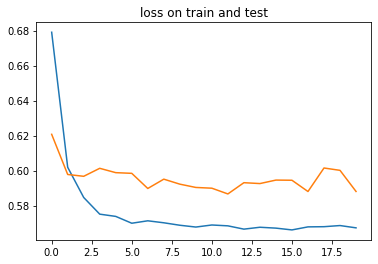

Last loss on train: 0.5672220624653639
Last loss on test: 0.5880323617081893


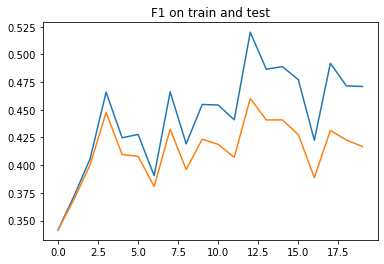

Last F1 on train: 0.47104047832235824
Last F1 on test: 0.4168628316960837


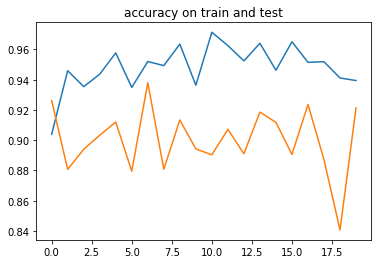

Last accuracy on train: 0.9394412168623072
Last accuracy on test: 0.9214025190786311


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.7556570479551589


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
--O du-O kannst-O mich-O verstehen-O ,-O nicht-B wahr-I ?-O
--O auf-B keinen-I fall-I .-O
keine-B ursache-I .-O
machst-B du-I witze-I ?-O
ich-B weiß-I ,-O aber-O die-O neue-O wohnung-O ist-O nun-O wirklich-O groß-O genug-O und-O ...-O
--O klasse-O --O ich-B weiß-I .-O
nein-O ,-O schon-B gut-I .-O
--O ach-B ja-I ?-O
--O ist-B ja-I schon-I gut-I .-O
nein-O ,-O es-B geht-I nicht-I .-O
ich-B verstehe-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
--O nicht-B wahr-I ?-O
--O mit-B vergnügen-I .-O
ach-B was-I ,-O ihr-O beiden-O wusstet-O genau-O bescheid-O .-O
ja-O ,-O gut-O ,-O in-B ordnung-I ,-O das-O passt-O mir-O sehr-O gut-O ,-O das-O wird-O gehen-O .-O
stimmt-B 's-I ?-O
ich-O dachte-O ,-O du-O bist-O ...-O schon-B gut-I .-O
na-B schön-I .-O
nein-O ,-O ich-O will-O es-O nicht-O wissen-O ,-O auf-B gar-I keinen-I fall-I .-O
na-B dann-I .-O
auf-B keinen-I fall-I .-O
--O 

# Experiment 1.3
RNN: 0 tokens, 2 sentences

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiRNN_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


51it [00:01, 33.46it/s]

Train loss: 0.8224889583057827


95it [00:02, 33.86it/s]

Train loss: 0.8356754971875084


139it [00:04, 34.37it/s]

Train loss: 0.8383771322391651


187it [00:05, 32.39it/s]

Train loss: 0.8376873360739814


226it [00:06, 32.61it/s]


Train loss: 0.8453256924947102

Evaluating on train...


53it [00:01, 43.16it/s]

Val loss: 0.8457488762007819, Val f1: 0.34796948300467595, Val accuracy: 0.34810196095042756


98it [00:02, 40.16it/s]

Val loss: 0.8513772626717885, Val f1: 0.34797020157178243, Val accuracy: 0.3481115738550822


140it [00:03, 37.39it/s]

Val loss: 0.8402556282502633, Val f1: 0.3578493400856301, Val accuracy: 0.3579877515633901


185it [00:04, 37.99it/s]

Val loss: 0.8469460792011685, Val f1: 0.35537631462017694, Val accuracy: 0.35552124513520134


226it [00:05, 39.27it/s]


Val loss: 0.845159871313307, Val f1: 0.3582377333111233, Val accuracy: 0.3581013584136963

Evaluating on test...


20it [00:00, 36.43it/s]

Val loss: 0.9068106532096862, Val f1: 0.3330909748872121, Val accuracy: 0.33326791127522787


36it [00:00, 36.53it/s]

Val loss: 0.8862081984678905, Val f1: 0.33311671515305835, Val accuracy: 0.3332828253507614


52it [00:01, 35.39it/s]

Val loss: 0.873651651541392, Val f1: 0.34794056349330477, Val accuracy: 0.34810150464375816


64it [00:01, 35.97it/s]

Val loss: 0.8693781266609828, Val f1: 0.3442439248164495, Val accuracy: 0.34440598289171853


76it [00:02, 35.85it/s]


Val loss: 0.8573765277862548, Val f1: 0.359807954231898, Val accuracy: 0.3599606025218964

starting Epoch 1
Training...


50it [00:01, 32.85it/s]

Train loss: 0.8302135189374288


94it [00:02, 34.88it/s]

Train loss: 0.8446370376480951


138it [00:04, 32.58it/s]

Train loss: 0.8391953945159912


186it [00:05, 33.58it/s]

Train loss: 0.8470777634117338


226it [00:06, 32.86it/s]


Train loss: 0.8480518060260349

Evaluating on train...


53it [00:01, 41.95it/s]

Val loss: 0.8148184219996134, Val f1: 0.37763177818722193, Val accuracy: 0.37777667111820645


93it [00:02, 40.47it/s]

Val loss: 0.8347344570689731, Val f1: 0.3572499305009842, Val accuracy: 0.35740429990821415


141it [00:03, 39.38it/s]

Val loss: 0.8407382722254153, Val f1: 0.3590965504999514, Val accuracy: 0.35925111505720353


186it [00:04, 37.97it/s]

Val loss: 0.843080445461803, Val f1: 0.3600221691860093, Val accuracy: 0.3601790794067913


226it [00:05, 39.51it/s]


Val loss: 0.8474272203445434, Val f1: 0.3546489448017544, Val accuracy: 0.3548096802499559

Evaluating on test...


20it [00:00, 35.43it/s]

Val loss: 0.8896610101064046, Val f1: 0.33314236005147296, Val accuracy: 0.3333333432674408


36it [00:01, 35.64it/s]

Val loss: 0.8651237984498342, Val f1: 0.35538054406642916, Val accuracy: 0.3555507391691208


52it [00:01, 36.00it/s]

Val loss: 0.86001142528322, Val f1: 0.36279169850879245, Val accuracy: 0.36295908159679835


64it [00:01, 36.95it/s]

Val loss: 0.8620143214861552, Val f1: 0.3553839847445488, Val accuracy: 0.35555204351743064


76it [00:02, 36.21it/s]


Val loss: 0.8649621558189392, Val f1: 0.359826432466507, Val accuracy: 0.3599971922238668

starting Epoch 2
Training...


51it [00:01, 32.79it/s]

Train loss: 0.8307395709885491


95it [00:02, 32.33it/s]

Train loss: 0.8440153486198849


139it [00:04, 31.41it/s]

Train loss: 0.8481379323535495


183it [00:05, 34.43it/s]

Train loss: 0.8474925839238696


226it [00:06, 32.67it/s]


Train loss: 0.846323971748352

Evaluating on train...


50it [00:01, 43.48it/s]

Val loss: 0.8049274325370789, Val f1: 0.4072657744089762, Val accuracy: 0.40740682548946805


95it [00:02, 40.37it/s]

Val loss: 0.8309610770808326, Val f1: 0.3924362391233444, Val accuracy: 0.3925923062695397


139it [00:03, 38.82it/s]

Val loss: 0.8323252470405014, Val f1: 0.3776192510569537, Val accuracy: 0.377768353400407


184it [00:04, 36.94it/s]

Val loss: 0.840273819035954, Val f1: 0.37391038487354916, Val accuracy: 0.3740670081641939


226it [00:05, 39.58it/s]


Val loss: 0.8408552649286059, Val f1: 0.3687266801463233, Val accuracy: 0.36888323810365464

Evaluating on test...


20it [00:00, 35.08it/s]

Val loss: 0.8692120750745137, Val f1: 0.3331531465053558, Val accuracy: 0.3333333432674408


36it [00:01, 36.22it/s]

Val loss: 0.8802297393480937, Val f1: 0.33314689695835115, Val accuracy: 0.3333333432674408


52it [00:01, 36.58it/s]

Val loss: 0.8661861432923211, Val f1: 0.347969290945265, Val accuracy: 0.34814815786149766


64it [00:01, 37.01it/s]

Val loss: 0.8627156396706899, Val f1: 0.3442709008852641, Val accuracy: 0.3444444542129835


76it [00:02, 36.07it/s]


Val loss: 0.8606639210383097, Val f1: 0.35093709627787273, Val accuracy: 0.3511084481080373

starting Epoch 3
Training...


52it [00:01, 34.53it/s]

Train loss: 0.863602708445655


96it [00:02, 33.92it/s]

Train loss: 0.8430634842978584


140it [00:04, 33.23it/s]

Train loss: 0.8423312562483328


184it [00:05, 33.46it/s]

Train loss: 0.8424208578136232


226it [00:06, 32.91it/s]


Train loss: 0.8474077447255453

Evaluating on train...


50it [00:01, 43.97it/s]

Val loss: 0.8633514218860202, Val f1: 0.3627873712115818, Val accuracy: 0.36296181480089823


95it [00:02, 34.44it/s]

Val loss: 0.8565621051523421, Val f1: 0.3553853700558344, Val accuracy: 0.3555506772465176


140it [00:04, 37.47it/s]

Val loss: 0.852668450055299, Val f1: 0.3529188279752378, Val accuracy: 0.35308209812199626


184it [00:05, 35.39it/s]

Val loss: 0.8535257392459445, Val f1: 0.3553879034188059, Val accuracy: 0.355552083088292


226it [00:06, 34.34it/s]


Val loss: 0.8483229112625122, Val f1: 0.3568742261992561, Val accuracy: 0.3570342609617445

Evaluating on test...


20it [00:00, 35.82it/s]

Val loss: 0.8867875496546428, Val f1: 0.33314730127652487, Val accuracy: 0.33332956234614053


36it [00:00, 36.89it/s]

Val loss: 0.8674236178398133, Val f1: 0.3331599255402883, Val accuracy: 0.33333145280679066


52it [00:01, 36.17it/s]

Val loss: 0.8811073846287197, Val f1: 0.33684721456633676, Val accuracy: 0.33703578644328647


64it [00:01, 36.12it/s]

Val loss: 0.8662113736073176, Val f1: 0.33593519975741704, Val accuracy: 0.33611017564932505


76it [00:02, 36.25it/s]


Val loss: 0.8630199416478475, Val f1: 0.34427093823750815, Val accuracy: 0.34444369792938234

starting Epoch 4
Training...


51it [00:01, 33.48it/s]

Train loss: 0.8384596824645996


95it [00:02, 33.17it/s]

Train loss: 0.840151850382487


139it [00:04, 33.47it/s]

Train loss: 0.8300572395324707


187it [00:05, 34.47it/s]

Train loss: 0.8432977686325709


226it [00:06, 33.07it/s]


Train loss: 0.8434642850028145

Evaluating on train...


50it [00:01, 43.14it/s]

Val loss: 0.8374262730280558, Val f1: 0.37762184540430704, Val accuracy: 0.3777777870496114


95it [00:02, 41.29it/s]

Val loss: 0.8408927506870694, Val f1: 0.3850254502561357, Val accuracy: 0.38518519434663984


140it [00:03, 39.71it/s]

Val loss: 0.8572898900067365, Val f1: 0.3677302720370116, Val accuracy: 0.3679012439869068


184it [00:04, 36.11it/s]

Val loss: 0.8523882094356748, Val f1: 0.36279622084564633, Val accuracy: 0.36296297245555453


226it [00:05, 39.83it/s]


Val loss: 0.8456387514538235, Val f1: 0.37243007911576165, Val accuracy: 0.3725926019085778

Evaluating on test...


20it [00:00, 35.19it/s]

Val loss: 0.8567506353060405, Val f1: 0.37760453621546425, Val accuracy: 0.3777777870496114


36it [00:01, 34.87it/s]

Val loss: 0.8980616609255473, Val f1: 0.35534802575906116, Val accuracy: 0.3555555651585261


52it [00:01, 35.16it/s]

Val loss: 0.8670968903435601, Val f1: 0.3664854950375027, Val accuracy: 0.3666666759385003


64it [00:01, 35.88it/s]

Val loss: 0.855061474442482, Val f1: 0.38038318504889806, Val accuracy: 0.3805555646618207


76it [00:02, 35.50it/s]


Val loss: 0.8490864936510721, Val f1: 0.3887218197186788, Val accuracy: 0.388888897895813

starting Epoch 5
Training...


52it [00:01, 33.76it/s]

Train loss: 0.8826522376802233


96it [00:02, 32.54it/s]

Train loss: 0.8705594420433045


140it [00:04, 33.89it/s]

Train loss: 0.8652810348404778


184it [00:05, 33.41it/s]

Train loss: 0.8480759663714303


226it [00:06, 32.75it/s]


Train loss: 0.8467849699656168

Evaluating on train...


53it [00:01, 43.14it/s]

Val loss: 0.8035496579276191, Val f1: 0.36283101704385545, Val accuracy: 0.36296297245555453


98it [00:02, 40.62it/s]

Val loss: 0.8236443738142649, Val f1: 0.35541094375981225, Val accuracy: 0.3555555651585261


140it [00:03, 38.31it/s]

Val loss: 0.8334995101999354, Val f1: 0.3529360998559881, Val accuracy: 0.35308642939284995


184it [00:04, 37.47it/s]

Val loss: 0.8409307387140063, Val f1: 0.3591023733218511, Val accuracy: 0.35925926880704034


226it [00:05, 39.06it/s]


Val loss: 0.8440873384475708, Val f1: 0.35687664416101245, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 36.12it/s]

Val loss: 0.8696265975634258, Val f1: 0.33315845131874083, Val accuracy: 0.3333333432674408


36it [00:01, 36.37it/s]

Val loss: 0.8253327747186024, Val f1: 0.37762261430422467, Val accuracy: 0.3777777870496114


52it [00:01, 36.13it/s]

Val loss: 0.8516656822628446, Val f1: 0.36279272635777793, Val accuracy: 0.36296297245555453


64it [00:01, 36.20it/s]

Val loss: 0.8488212158282598, Val f1: 0.3664998486638069, Val accuracy: 0.3666666761040688


76it [00:02, 35.91it/s]


Val loss: 0.8456711069742838, Val f1: 0.3598366355895996, Val accuracy: 0.36000000953674316

starting Epoch 6
Training...


50it [00:01, 34.04it/s]

Train loss: 0.8141856339242723


94it [00:02, 32.19it/s]

Train loss: 0.8171779400772519


142it [00:04, 33.82it/s]

Train loss: 0.8285567438160931


186it [00:05, 31.53it/s]

Train loss: 0.8337048487530814


226it [00:06, 32.39it/s]


Train loss: 0.838477566242218

Evaluating on train...


50it [00:01, 42.84it/s]

Val loss: 0.8438877132203844, Val f1: 0.3628019313017527, Val accuracy: 0.36296297245555453


95it [00:02, 40.28it/s]

Val loss: 0.8386540253957112, Val f1: 0.36280916101402705, Val accuracy: 0.36296297245555453


140it [00:03, 38.03it/s]

Val loss: 0.8437453269958496, Val f1: 0.3627997469019007, Val accuracy: 0.36296297245555453


184it [00:04, 35.67it/s]

Val loss: 0.8438280406925414, Val f1: 0.35539336419767803, Val accuracy: 0.3555555651585261


226it [00:05, 39.17it/s]


Val loss: 0.8478611779212951, Val f1: 0.35390936374664306, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 35.65it/s]

Val loss: 0.8468916813532511, Val f1: 0.333173934618632, Val accuracy: 0.3333333432674408


36it [00:00, 36.97it/s]

Val loss: 0.8465394139289856, Val f1: 0.33317332963148755, Val accuracy: 0.3333333432674408


52it [00:01, 35.64it/s]

Val loss: 0.8636060237884522, Val f1: 0.3331613063812256, Val accuracy: 0.3333333432674408


64it [00:01, 35.91it/s]

Val loss: 0.8698470463355382, Val f1: 0.3442645952105522, Val accuracy: 0.3444444542129835


76it [00:02, 36.01it/s]


Val loss: 0.8574022444089254, Val f1: 0.3420514210065206, Val accuracy: 0.3422222320238749

starting Epoch 7
Training...


52it [00:01, 34.43it/s]

Train loss: 0.8718803034888374


96it [00:02, 33.64it/s]

Train loss: 0.8586422853999668


140it [00:04, 32.44it/s]

Train loss: 0.8555793678319012


184it [00:05, 34.64it/s]

Train loss: 0.8517086568805906


226it [00:06, 32.72it/s]


Train loss: 0.8443479291598002

Evaluating on train...


50it [00:01, 41.65it/s]

Val loss: 0.8553977582189772, Val f1: 0.3625966919793023, Val accuracy: 0.36253544158405726


95it [00:02, 40.39it/s]

Val loss: 0.8377411868837145, Val f1: 0.3683772838777966, Val accuracy: 0.37105088531970976


141it [00:03, 37.25it/s]

Val loss: 0.8282762500974867, Val f1: 0.37084050487588954, Val accuracy: 0.372452931271659


185it [00:04, 36.36it/s]

Val loss: 0.8359063820706474, Val f1: 0.364639975130558, Val accuracy: 0.36548521121342975


226it [00:05, 38.74it/s]


Val loss: 0.8397185553444756, Val f1: 0.3600669452879164, Val accuracy: 0.3608707078297933

Evaluating on test...


20it [00:00, 35.64it/s]

Val loss: 0.8573494712511699, Val f1: 0.36108813087145486, Val accuracy: 0.3654771049817403


36it [00:01, 35.78it/s]

Val loss: 0.8641134242216746, Val f1: 0.3526581545670827, Val accuracy: 0.3549228529135386


52it [00:01, 36.16it/s]

Val loss: 0.8585686935318841, Val f1: 0.34615369041760763, Val accuracy: 0.34770730866326227


64it [00:01, 35.33it/s]

Val loss: 0.8554910610119502, Val f1: 0.3428994839390119, Val accuracy: 0.34409451683362324


76it [00:02, 35.68it/s]


Val loss: 0.8520617548624675, Val f1: 0.34650391697883604, Val accuracy: 0.3472642421722412

starting Epoch 8
Training...


50it [00:01, 33.52it/s]

Train loss: 0.8759144862492879


94it [00:02, 32.72it/s]

Train loss: 0.8662161330382029


138it [00:04, 33.51it/s]

Train loss: 0.8557993478245205


186it [00:05, 33.75it/s]

Train loss: 0.8409803009695477


226it [00:06, 32.65it/s]


Train loss: 0.8319995085398356

Evaluating on train...


50it [00:01, 42.83it/s]

Val loss: 0.7702122251192729, Val f1: 0.37409540878401865, Val accuracy: 0.5462336076630486


98it [00:02, 40.00it/s]

Val loss: 0.7737352344724867, Val f1: 0.36691959301630656, Val accuracy: 0.5481543312470119


140it [00:03, 38.01it/s]

Val loss: 0.7665347827805413, Val f1: 0.37100396068007857, Val accuracy: 0.5635913919519495


185it [00:04, 36.85it/s]

Val loss: 0.7659225947327084, Val f1: 0.37402140978309845, Val accuracy: 0.5644324988126754


226it [00:05, 38.58it/s]


Val loss: 0.7640560672018263, Val f1: 0.3774237957265642, Val accuracy: 0.5638569651709663

Evaluating on test...


20it [00:00, 35.71it/s]

Val loss: 0.794157870610555, Val f1: 0.369209086894989, Val accuracy: 0.5478293339411417


36it [00:01, 35.38it/s]

Val loss: 0.7687084436416626, Val f1: 0.3773381471633911, Val accuracy: 0.5777711639801661


52it [00:01, 36.08it/s]

Val loss: 0.7733924402130975, Val f1: 0.3744139532248179, Val accuracy: 0.5655845416916742


64it [00:01, 35.30it/s]

Val loss: 0.7844211916128795, Val f1: 0.3684247334798177, Val accuracy: 0.5588258862495422


76it [00:02, 35.70it/s]


Val loss: 0.7761222457885742, Val f1: 0.36741373618443807, Val accuracy: 0.5499681158860524

starting Epoch 9
Training...


49it [00:01, 32.50it/s]

Train loss: 0.8038875341415406


93it [00:02, 33.37it/s]

Train loss: 0.7862963418165843


141it [00:04, 31.76it/s]

Train loss: 0.7731950605357135


185it [00:05, 33.58it/s]

Train loss: 0.7504120118088192


226it [00:06, 32.69it/s]


Train loss: 0.7319372693697611

Evaluating on train...


49it [00:01, 41.06it/s]

Val loss: 0.6202938967280918, Val f1: 0.3487934390703837, Val accuracy: 0.9010360651546054


94it [00:02, 39.37it/s]

Val loss: 0.6323507825533549, Val f1: 0.3483949879805247, Val accuracy: 0.8797213236490885


142it [00:03, 36.33it/s]

Val loss: 0.6311027182473077, Val f1: 0.3481581637152919, Val accuracy: 0.883124789485225


186it [00:04, 35.82it/s]

Val loss: 0.6285356670618057, Val f1: 0.34754611584875317, Val accuracy: 0.8765614395340283


226it [00:06, 37.66it/s]


Val loss: 0.6280843925476074, Val f1: 0.3480409754647149, Val accuracy: 0.8780280166202121

Evaluating on test...


20it [00:00, 35.74it/s]

Val loss: 0.6593973676363627, Val f1: 0.34576342105865476, Val accuracy: 0.7972372353076935


36it [00:01, 35.45it/s]

Val loss: 0.6470188637574513, Val f1: 0.34662216703097026, Val accuracy: 0.8163898507754008


52it [00:01, 34.07it/s]

Val loss: 0.6427376773622301, Val f1: 0.3484127051300473, Val accuracy: 0.8378379596604242


64it [00:01, 34.35it/s]

Val loss: 0.638747642437617, Val f1: 0.3476549029350281, Val accuracy: 0.8583637813727061


76it [00:02, 35.11it/s]


Val loss: 0.6422478159268697, Val f1: 0.3476501973470052, Val accuracy: 0.8495509986082713

starting Epoch 10
Training...


49it [00:01, 33.74it/s]

Train loss: 0.6160929666625129


93it [00:03, 31.14it/s]

Train loss: 0.6187052309513092


141it [00:05, 32.22it/s]

Train loss: 0.6169922687389232


185it [00:06, 33.05it/s]

Train loss: 0.6119504614008797


226it [00:07, 29.80it/s]


Train loss: 0.6096131632063124

Evaluating on train...


50it [00:01, 43.41it/s]

Val loss: 0.5939607898394267, Val f1: 0.3680513540903727, Val accuracy: 0.9298645132117801


95it [00:02, 38.58it/s]

Val loss: 0.5964448299672869, Val f1: 0.36842397881878747, Val accuracy: 0.9138200345966551


140it [00:03, 37.68it/s]

Val loss: 0.5910484662762394, Val f1: 0.3699317481782701, Val accuracy: 0.9229939705795712


185it [00:04, 36.49it/s]

Val loss: 0.5928653832938936, Val f1: 0.3708777517080307, Val accuracy: 0.9197229562534226


226it [00:05, 38.71it/s]


Val loss: 0.5908898875448438, Val f1: 0.3721407723426819, Val accuracy: 0.9201920971605513

Evaluating on test...


20it [00:00, 35.37it/s]

Val loss: 0.5943382024765015, Val f1: 0.37801945010821025, Val accuracy: 0.9415100971857707


36it [00:01, 34.96it/s]

Val loss: 0.6080692529678344, Val f1: 0.374987804889679, Val accuracy: 0.8929929584264755


52it [00:01, 36.03it/s]

Val loss: 0.6055901832050747, Val f1: 0.3752328018347422, Val accuracy: 0.9079622235563066


64it [00:01, 36.14it/s]

Val loss: 0.6035370469093323, Val f1: 0.3729100947578748, Val accuracy: 0.9098424231012662


76it [00:02, 35.61it/s]


Val loss: 0.6038335251808167, Val f1: 0.37003344813982647, Val accuracy: 0.9037627883752187

starting Epoch 11
Training...


48it [00:01, 33.42it/s]

Train loss: 0.5934371749560038


96it [00:03, 31.17it/s]

Train loss: 0.594117240773307


140it [00:04, 33.26it/s]

Train loss: 0.5913857967765243


184it [00:05, 32.87it/s]

Train loss: 0.5895921428998311


226it [00:06, 32.59it/s]


Train loss: 0.588777822388543

Evaluating on train...


49it [00:01, 43.42it/s]

Val loss: 0.5994004739655389, Val f1: 0.4038513077629937, Val accuracy: 0.8901459376017252


94it [00:02, 40.48it/s]

Val loss: 0.585346766975191, Val f1: 0.40819465385542975, Val accuracy: 0.9189966926972072


140it [00:03, 38.28it/s]

Val loss: 0.5869265913963317, Val f1: 0.4095177321522324, Val accuracy: 0.9228740288151636


184it [00:04, 37.18it/s]

Val loss: 0.5877943565448125, Val f1: 0.4101225217183431, Val accuracy: 0.9229906052350998


226it [00:05, 39.00it/s]


Val loss: 0.5881154576937357, Val f1: 0.4100707937611474, Val accuracy: 0.9263335810767279

Evaluating on test...


20it [00:00, 35.88it/s]

Val loss: 0.6090670704841614, Val f1: 0.4029131233692169, Val accuracy: 0.851505172252655


36it [00:01, 35.20it/s]

Val loss: 0.6165607213973999, Val f1: 0.4047125538190206, Val accuracy: 0.8396800398826599


52it [00:01, 36.23it/s]

Val loss: 0.6079081323411729, Val f1: 0.40954589711295236, Val accuracy: 0.8673114366001553


64it [00:01, 36.28it/s]

Val loss: 0.6126652310291926, Val f1: 0.4063706244031588, Val accuracy: 0.854459307094415


76it [00:02, 35.72it/s]


Val loss: 0.6103035116195679, Val f1: 0.40578882813453676, Val accuracy: 0.8624658477306366

starting Epoch 12
Training...


51it [00:01, 32.70it/s]

Train loss: 0.58920509285397


95it [00:03, 34.07it/s]

Train loss: 0.5828901078965929


139it [00:04, 33.27it/s]

Train loss: 0.5855337924427456


183it [00:05, 33.39it/s]

Train loss: 0.5844725930028492


226it [00:06, 32.54it/s]


Train loss: 0.5850655412673951

Evaluating on train...


50it [00:01, 44.53it/s]

Val loss: 0.5754131476084391, Val f1: 0.42767769032054476, Val accuracy: 0.9247308770815531


95it [00:02, 40.41it/s]

Val loss: 0.5726065854231517, Val f1: 0.42059485415617626, Val accuracy: 0.9440766698784299


141it [00:03, 37.58it/s]

Val loss: 0.5725328114297655, Val f1: 0.41995241465391936, Val accuracy: 0.9487835700865145


185it [00:04, 35.90it/s]

Val loss: 0.5775521765152614, Val f1: 0.4204700408710374, Val accuracy: 0.9407042137450642


226it [00:05, 38.77it/s]


Val loss: 0.5794726652569241, Val f1: 0.4186835792329576, Val accuracy: 0.93287357767423

Evaluating on test...


20it [00:00, 35.52it/s]

Val loss: 0.5916452805201212, Val f1: 0.41038098533948264, Val accuracy: 0.8925497372945149


36it [00:01, 36.30it/s]

Val loss: 0.5974760135014852, Val f1: 0.41177653272946674, Val accuracy: 0.8882579267024994


52it [00:01, 35.94it/s]

Val loss: 0.5958405507935418, Val f1: 0.4048129379749298, Val accuracy: 0.8937927113638984


64it [00:01, 34.73it/s]

Val loss: 0.5979736010233562, Val f1: 0.4067066495617231, Val accuracy: 0.889330905675888


76it [00:02, 35.71it/s]


Val loss: 0.6011928598086039, Val f1: 0.4079956674575806, Val accuracy: 0.8898701381683349

starting Epoch 13
Training...


51it [00:01, 33.40it/s]

Train loss: 0.5796846138106452


95it [00:02, 33.94it/s]

Train loss: 0.5777188764678107


139it [00:04, 32.95it/s]

Train loss: 0.5774150790991607


183it [00:05, 32.00it/s]

Train loss: 0.5781463162766562


226it [00:06, 32.70it/s]


Train loss: 0.5790637538168165

Evaluating on train...


53it [00:01, 42.97it/s]

Val loss: 0.5838989416758219, Val f1: 0.4351615203751458, Val accuracy: 0.9094671249389649


98it [00:02, 40.39it/s]

Val loss: 0.5792989677853054, Val f1: 0.43618385361300577, Val accuracy: 0.9299379527568817


140it [00:03, 38.74it/s]

Val loss: 0.5728286217760157, Val f1: 0.44137214841666045, Val accuracy: 0.9312691657631486


185it [00:04, 36.25it/s]

Val loss: 0.5719133893648783, Val f1: 0.44258591913514667, Val accuracy: 0.9414853261576759


226it [00:05, 38.79it/s]


Val loss: 0.5727475558386909, Val f1: 0.4413161476453145, Val accuracy: 0.9340434579054514

Evaluating on test...


20it [00:00, 35.98it/s]

Val loss: 0.5916180491447449, Val f1: 0.4255910853544871, Val accuracy: 0.9051523486773173


36it [00:01, 35.35it/s]

Val loss: 0.5969860891501109, Val f1: 0.42353260815143584, Val accuracy: 0.9154811044534047


52it [00:01, 35.94it/s]

Val loss: 0.5965312666363186, Val f1: 0.4271280030409495, Val accuracy: 0.9165742900636461


64it [00:01, 36.21it/s]

Val loss: 0.5918727268775305, Val f1: 0.43109731872876483, Val accuracy: 0.9285096029440562


76it [00:02, 35.73it/s]


Val loss: 0.5922336101531982, Val f1: 0.42861655632654827, Val accuracy: 0.9272174517313639

starting Epoch 14
Training...


50it [00:01, 32.65it/s]

Train loss: 0.5707757433255514


94it [00:02, 33.28it/s]

Train loss: 0.5759802016947004


138it [00:04, 33.38it/s]

Train loss: 0.5740672327854015


186it [00:05, 33.14it/s]

Train loss: 0.5798425601588355


226it [00:06, 32.58it/s]


Train loss: 0.5790576391749912

Evaluating on train...


54it [00:01, 43.91it/s]

Val loss: 0.5704517033365037, Val f1: 0.45932957397566904, Val accuracy: 0.9386762029594845


97it [00:02, 39.12it/s]

Val loss: 0.5741797745227813, Val f1: 0.46158410376972625, Val accuracy: 0.9397072162893083


142it [00:03, 37.21it/s]

Val loss: 0.5714545779758029, Val f1: 0.4628041927461271, Val accuracy: 0.9440531355363352


186it [00:04, 36.17it/s]

Val loss: 0.5719270368417104, Val f1: 0.4665844856037034, Val accuracy: 0.9489124874273936


226it [00:05, 38.66it/s]


Val loss: 0.5725910353660584, Val f1: 0.4647350466251373, Val accuracy: 0.9489067072338528

Evaluating on test...


20it [00:00, 33.79it/s]

Val loss: 0.6019614577293396, Val f1: 0.4400129973888397, Val accuracy: 0.8515676478544871


36it [00:01, 35.79it/s]

Val loss: 0.598061066865921, Val f1: 0.4447886993487676, Val accuracy: 0.8845591396093369


52it [00:01, 35.11it/s]

Val loss: 0.5938886245091756, Val f1: 0.44184862110349865, Val accuracy: 0.9005920906861623


64it [00:01, 36.42it/s]

Val loss: 0.5935988813638687, Val f1: 0.4413255472977956, Val accuracy: 0.8983400772015254


76it [00:02, 35.60it/s]


Val loss: 0.5952249431610107, Val f1: 0.4462352641423543, Val accuracy: 0.9036286687850952

starting Epoch 15
Training...


51it [00:01, 33.59it/s]

Train loss: 0.575345347987281


95it [00:02, 33.98it/s]

Train loss: 0.5744368082947201


139it [00:04, 33.33it/s]

Train loss: 0.5724605211505184


183it [00:05, 33.21it/s]

Train loss: 0.5748924838172065


226it [00:06, 32.63it/s]


Train loss: 0.5746265551779005

Evaluating on train...


50it [00:01, 42.47it/s]

Val loss: 0.5710821429888407, Val f1: 0.4178031384944916, Val accuracy: 0.9213162541389466


95it [00:02, 39.88it/s]

Val loss: 0.5735032061735789, Val f1: 0.4186642348766327, Val accuracy: 0.9362842179007


140it [00:03, 36.87it/s]

Val loss: 0.5725950143955372, Val f1: 0.4163598864166825, Val accuracy: 0.9402535323743467


185it [00:04, 36.30it/s]

Val loss: 0.5736649374167124, Val f1: 0.4153226395448049, Val accuracy: 0.9431985754105779


226it [00:05, 38.50it/s]


Val loss: 0.57378574874666, Val f1: 0.41450541257858275, Val accuracy: 0.9469105364216699

Evaluating on test...


20it [00:00, 36.03it/s]

Val loss: 0.5952028751373291, Val f1: 0.38857988913853964, Val accuracy: 0.8911736170450847


36it [00:01, 35.37it/s]

Val loss: 0.5934696475664775, Val f1: 0.38576941887537636, Val accuracy: 0.8818486839532852


52it [00:01, 36.43it/s]

Val loss: 0.5926995635032654, Val f1: 0.39519093698925445, Val accuracy: 0.9044109496805403


64it [00:01, 36.00it/s]

Val loss: 0.5938408762216568, Val f1: 0.3934572989741961, Val accuracy: 0.9001181786259015


76it [00:02, 35.75it/s]


Val loss: 0.5955465420087178, Val f1: 0.39707730690638227, Val accuracy: 0.9060509272416433

starting Epoch 16
Training...


51it [00:01, 33.00it/s]

Train loss: 0.5748371296458774


95it [00:02, 32.82it/s]

Train loss: 0.5748644994364844


139it [00:04, 32.46it/s]

Train loss: 0.5732863514511674


183it [00:05, 33.65it/s]

Train loss: 0.5717019266552396


226it [00:06, 32.47it/s]


Train loss: 0.5725552890035841

Evaluating on train...


50it [00:01, 43.71it/s]

Val loss: 0.5682882123523288, Val f1: 0.43005585935380725, Val accuracy: 0.9386787010563744


95it [00:02, 40.59it/s]

Val loss: 0.5664457678794861, Val f1: 0.42985246943102945, Val accuracy: 0.9406249850988389


139it [00:03, 23.84it/s]

Val loss: 0.5675166929209674, Val f1: 0.43502296098956356, Val accuracy: 0.9477392291581189


187it [00:05, 34.58it/s]

Val loss: 0.5663049505816565, Val f1: 0.437476431661182, Val accuracy: 0.9508537562357054


226it [00:06, 34.83it/s]


Val loss: 0.5665194998847114, Val f1: 0.43966488997141523, Val accuracy: 0.9541759406195747

Evaluating on test...


20it [00:00, 34.60it/s]

Val loss: 0.5819876432418823, Val f1: 0.43857435186704, Val accuracy: 0.958575971921285


36it [00:01, 35.71it/s]

Val loss: 0.5861518641312917, Val f1: 0.4311581035455068, Val accuracy: 0.9500419815381368


52it [00:01, 35.51it/s]

Val loss: 0.5872804654969109, Val f1: 0.42426531910896303, Val accuracy: 0.9459876815478007


64it [00:01, 36.02it/s]

Val loss: 0.5912637660900751, Val f1: 0.41935885945955914, Val accuracy: 0.9245341052611669


76it [00:02, 35.65it/s]


Val loss: 0.5901628971099854, Val f1: 0.420209485689799, Val accuracy: 0.9216538874308268

starting Epoch 17
Training...


51it [00:01, 33.18it/s]

Train loss: 0.5655503643883599


95it [00:02, 32.59it/s]

Train loss: 0.5695573528607686


139it [00:04, 34.01it/s]

Train loss: 0.5699090074609827


187it [00:05, 33.13it/s]

Train loss: 0.5691942549414105


226it [00:06, 32.44it/s]


Train loss: 0.5692979762289259

Evaluating on train...


49it [00:01, 43.63it/s]

Val loss: 0.5643609073426988, Val f1: 0.45889281696743434, Val accuracy: 0.9540017657809787


94it [00:02, 39.33it/s]

Val loss: 0.5658511420090994, Val f1: 0.453587825761901, Val accuracy: 0.9472102026144663


140it [00:03, 36.78it/s]

Val loss: 0.5682056727232756, Val f1: 0.4508283718868538, Val accuracy: 0.9422954833066022


184it [00:04, 35.51it/s]

Val loss: 0.5675948295328352, Val f1: 0.4489473164081573, Val accuracy: 0.9488666660255856


226it [00:05, 38.35it/s]


Val loss: 0.5683939721849229, Val f1: 0.4509515204694536, Val accuracy: 0.951294668118159

Evaluating on test...


20it [00:00, 36.45it/s]

Val loss: 0.5909721334775289, Val f1: 0.42570428053538006, Val accuracy: 0.8700626730918884


36it [00:01, 35.78it/s]

Val loss: 0.5851082682609559, Val f1: 0.43379083375136057, Val accuracy: 0.9120383640130361


52it [00:01, 35.16it/s]

Val loss: 0.5871154255337185, Val f1: 0.4350564440091451, Val accuracy: 0.9205579744444953


64it [00:01, 35.22it/s]

Val loss: 0.5911640127499899, Val f1: 0.4273080954949061, Val accuracy: 0.9019182999928792


76it [00:02, 35.49it/s]


Val loss: 0.5925808580716451, Val f1: 0.42628600557645163, Val accuracy: 0.902432390054067

starting Epoch 18
Training...


51it [00:01, 33.62it/s]

Train loss: 0.5712424914042155


95it [00:03, 31.95it/s]

Train loss: 0.5728283988104926


139it [00:04, 33.95it/s]

Train loss: 0.5693415504914743


187it [00:05, 33.51it/s]

Train loss: 0.5699379238817427


226it [00:06, 32.47it/s]


Train loss: 0.572011075814565

Evaluating on train...


53it [00:01, 43.16it/s]

Val loss: 0.5724090655644735, Val f1: 0.39882212612364026, Val accuracy: 0.9676575084527334


97it [00:02, 38.20it/s]

Val loss: 0.5709808601273431, Val f1: 0.3955328855249617, Val accuracy: 0.9462177458736631


141it [00:03, 38.50it/s]

Val loss: 0.5693588504084834, Val f1: 0.3946492241488563, Val accuracy: 0.9412061232107657


186it [00:04, 35.46it/s]

Val loss: 0.5702582567930221, Val f1: 0.39631388352976904, Val accuracy: 0.9429529618885782


226it [00:05, 38.40it/s]


Val loss: 0.5693803519672818, Val f1: 0.3958975859483083, Val accuracy: 0.9434087685743968

Evaluating on test...


20it [00:00, 35.53it/s]

Val loss: 0.5823541204134624, Val f1: 0.38778141339619954, Val accuracy: 0.9439379493395488


36it [00:01, 35.73it/s]

Val loss: 0.5801788191000621, Val f1: 0.38250739872455597, Val accuracy: 0.9557137827078501


52it [00:01, 36.14it/s]

Val loss: 0.5833582295311822, Val f1: 0.38435152769088743, Val accuracy: 0.9560175008243985


64it [00:01, 36.14it/s]

Val loss: 0.5912896484136582, Val f1: 0.3842609614133835, Val accuracy: 0.9311089793841044


76it [00:02, 35.54it/s]


Val loss: 0.588261779944102, Val f1: 0.38461809476216635, Val accuracy: 0.9294184080759684

starting Epoch 19
Training...


50it [00:01, 32.71it/s]

Train loss: 0.5695036384794447


94it [00:02, 32.56it/s]

Train loss: 0.5679523057407803


142it [00:04, 33.81it/s]

Train loss: 0.5672629691936352


186it [00:05, 33.90it/s]

Train loss: 0.5688382347424825


226it [00:06, 32.39it/s]


Train loss: 0.5695373307334052

Evaluating on train...


49it [00:01, 43.08it/s]

Val loss: 0.5691378328535291, Val f1: 0.5027700702349345, Val accuracy: 0.9568889843093025


94it [00:02, 39.70it/s]

Val loss: 0.5678108089500004, Val f1: 0.4995826025803884, Val accuracy: 0.9596355501148436


142it [00:03, 36.05it/s]

Val loss: 0.5680880780573244, Val f1: 0.5009089602364434, Val accuracy: 0.9502001698370333


186it [00:04, 36.22it/s]

Val loss: 0.5671431488460965, Val f1: 0.5016206994652748, Val accuracy: 0.9476128954026434


226it [00:05, 38.17it/s]


Val loss: 0.5672982218530443, Val f1: 0.4992827877733442, Val accuracy: 0.9441959689723121

Evaluating on test...


20it [00:00, 36.17it/s]

Val loss: 0.6124080101648967, Val f1: 0.5060191671053569, Val accuracy: 0.899666178226471


36it [00:01, 36.32it/s]

Val loss: 0.5982235650221507, Val f1: 0.47999999225139617, Val accuracy: 0.891308065255483


52it [00:01, 34.83it/s]

Val loss: 0.5974132974942525, Val f1: 0.47288552191522387, Val accuracy: 0.8879186908404032


64it [00:01, 34.99it/s]

Val loss: 0.5956159184376398, Val f1: 0.471058223148187, Val accuracy: 0.9003208090861639


76it [00:02, 35.55it/s]

Val loss: 0.5941391738255819, Val f1: 0.46689914782842, Val accuracy: 0.8914018968741099


## Graphics

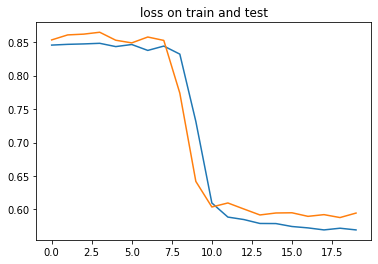

Last loss on train: 0.569477424684879
Last loss on test: 0.5946528966489592


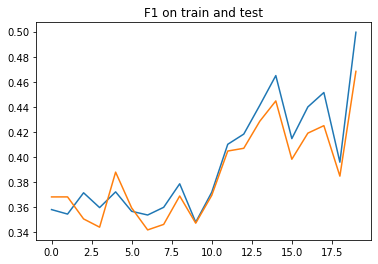

Last F1 on train: 0.4994602394578731
Last F1 on test: 0.4683162366089068


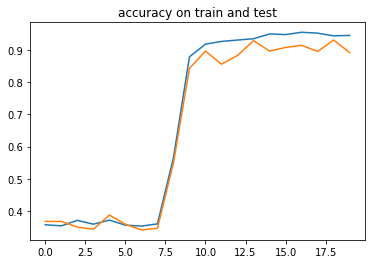

Last accuracy on train: 0.9444386264127967
Last accuracy on test: 0.891289479246265


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8720676769773718


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O das-B passt-I .-O
ganz-B sicher-I nicht-I .-O
--O du-O kannst-O mich-O verstehen-O ,-O nicht-B wahr-I ?-O
--O in-B ordnung-I .-O
dein-B ernst-I ?-O
--O ach-B ja-I ?-O
keine-B ahnung-I .-O
--O keine-B ahnung-I .-O
--O ach-B was-I .-O
--O das-B stimmt-I nicht-I .-O
--O ganz-B und-I gar-I nicht-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
na-B und-I ?-O
ach-B ja-I ?-O
ist-B schon-I gut-I ,-O ok.-O ich-O war-O darauf-O vorbereitet-O .-O
du-B hast-I recht-I .-O
stimmt-B 's-I ?-O
ich-B verstehe-I .-O
ja-O ,-O na-B und-I ?-O
was-B soll-I das-I ?-O
keine-B ahnung-I .-O
ja-O ,-O ich-B verstehe-I .-O
keine-B ahnung-I .-O
--O ich-B weiß-I .-O
--O machst-B du-I witze-I ?-O
du-B hast-I recht-I .-O
was-B soll-I 's-I .-O
--O keine-B ahnung-I .-O
keine-B ursache-I .-O
--O sicher-B nicht-I .-O
na-B klar-I !-O
ja-O ,-O gute-B idee-I .-O
keine-B ahnung-I .-O
oh-O ,-O ich-B bin-I draußen-I .-O
--O keine-B ahnung-I .-O
also-O werden-O

# Experiment 2.1
GRU 10 tokens, 2 sentences

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_10_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:02, 22.45it/s]

Train loss: 0.7130484686957466


94it [00:04, 22.24it/s]

Train loss: 0.7087397628360325


139it [00:06, 21.75it/s]

Train loss: 0.7093438647411487


184it [00:08, 21.84it/s]

Train loss: 0.7079732673035728


226it [00:10, 21.87it/s]


Train loss: 0.7067782510651482

Evaluating on train...


52it [00:01, 36.43it/s]

Val loss: 0.7134464661280314, Val f1: 0.3627892149819268, Val accuracy: 0.36296297245555453


96it [00:02, 34.30it/s]

Val loss: 0.7046836137771606, Val f1: 0.36280208296245997, Val accuracy: 0.36296297245555453


140it [00:03, 35.19it/s]

Val loss: 0.7018083369290388, Val f1: 0.3578683579409564, Val accuracy: 0.35802470092420224


184it [00:05, 32.75it/s]

Val loss: 0.7047028753492567, Val f1: 0.36650638414753806, Val accuracy: 0.3666666761040688


226it [00:06, 34.27it/s]


Val loss: 0.7057767184575399, Val f1: 0.35983735733562044, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 33.32it/s]

Val loss: 0.7281644741694132, Val f1: 0.3331487695376078, Val accuracy: 0.3333333432674408


36it [00:01, 32.26it/s]

Val loss: 0.7144068797429403, Val f1: 0.3553835153579712, Val accuracy: 0.3555555651585261


48it [00:01, 32.61it/s]

Val loss: 0.7103890948825412, Val f1: 0.3479819675286611, Val accuracy: 0.34814815786149766


64it [00:01, 31.22it/s]

Val loss: 0.717046461502711, Val f1: 0.34427115668853125, Val accuracy: 0.3444444542129835


76it [00:02, 32.39it/s]


Val loss: 0.7169379774729411, Val f1: 0.35093719204266866, Val accuracy: 0.35111112078030904

starting Epoch 1
Training...


46it [00:02, 22.72it/s]

Train loss: 0.7317132592201233


94it [00:04, 22.93it/s]

Train loss: 0.7260647932688395


139it [00:06, 22.26it/s]

Train loss: 0.7080972296220285


184it [00:08, 22.34it/s]

Train loss: 0.7077714128626718


226it [00:10, 21.92it/s]


Train loss: 0.7071671239535013

Evaluating on train...


48it [00:01, 36.30it/s]

Val loss: 0.7164489348729451, Val f1: 0.3627904302544064, Val accuracy: 0.36296297245555453


96it [00:02, 34.04it/s]

Val loss: 0.7132294244236417, Val f1: 0.34797865913973913, Val accuracy: 0.34814815786149766


140it [00:04, 33.05it/s]

Val loss: 0.7104943452058015, Val f1: 0.3529198942361055, Val accuracy: 0.35308642939284995


184it [00:05, 33.46it/s]

Val loss: 0.7076715058750577, Val f1: 0.3516890794038773, Val accuracy: 0.3518518615100119


226it [00:06, 34.12it/s]


Val loss: 0.7053520321846009, Val f1: 0.35687656958897906, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 32.15it/s]

Val loss: 0.7065789302190145, Val f1: 0.37761904001235963, Val accuracy: 0.3777777870496114


36it [00:01, 32.35it/s]

Val loss: 0.7151722391446431, Val f1: 0.35538281897703805, Val accuracy: 0.3555555651585261


48it [00:01, 31.92it/s]

Val loss: 0.7233295493655735, Val f1: 0.3479660325580173, Val accuracy: 0.34814815786149766


64it [00:02, 31.19it/s]

Val loss: 0.7203659892082215, Val f1: 0.3664876053730647, Val accuracy: 0.3666666761040688


76it [00:02, 32.24it/s]


Val loss: 0.7141843128204346, Val f1: 0.35982831676801047, Val accuracy: 0.36000000953674316

starting Epoch 2
Training...


49it [00:02, 23.33it/s]

Train loss: 0.7113182226816813


94it [00:04, 21.77it/s]

Train loss: 0.6990606857670678


139it [00:06, 22.83it/s]

Train loss: 0.7006560029806914


184it [00:08, 22.23it/s]

Train loss: 0.7026640511221356


226it [00:10, 22.12it/s]


Train loss: 0.7049847584300571

Evaluating on train...


52it [00:01, 36.68it/s]

Val loss: 0.7036408371395535, Val f1: 0.3331756810347239, Val accuracy: 0.3333333432674408


96it [00:02, 34.21it/s]

Val loss: 0.7004999955495198, Val f1: 0.34799329936504364, Val accuracy: 0.34814815786149766


140it [00:04, 35.16it/s]

Val loss: 0.7022230060012252, Val f1: 0.3479891097104108, Val accuracy: 0.34814815786149766


184it [00:05, 34.22it/s]

Val loss: 0.7039710419045554, Val f1: 0.35539460596111083, Val accuracy: 0.3555555651585261


226it [00:06, 34.05it/s]


Val loss: 0.7047736093733046, Val f1: 0.35983840770191616, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 33.56it/s]

Val loss: 0.7271612524986267, Val f1: 0.333151106039683, Val accuracy: 0.3333333432674408


36it [00:01, 33.22it/s]

Val loss: 0.7291334013144175, Val f1: 0.3775875329971313, Val accuracy: 0.3777777870496114


48it [00:01, 33.40it/s]

Val loss: 0.7098883443408542, Val f1: 0.39242550863160025, Val accuracy: 0.39259260164366827


64it [00:01, 33.13it/s]

Val loss: 0.7143289198478063, Val f1: 0.3776056776444117, Val accuracy: 0.3777777870496114


76it [00:02, 33.56it/s]


Val loss: 0.7105170639355978, Val f1: 0.37760944922765094, Val accuracy: 0.3777777870496114

starting Epoch 3
Training...


49it [00:02, 20.52it/s]

Train loss: 0.7110714872678121


94it [00:04, 22.66it/s]

Train loss: 0.7091952363650004


139it [00:06, 22.56it/s]

Train loss: 0.7091747668054369


181it [00:08, 18.40it/s]

Train loss: 0.709925792614619


226it [00:10, 21.87it/s]


Train loss: 0.7051699598630269

Evaluating on train...


52it [00:01, 37.13it/s]

Val loss: 0.6913362993134393, Val f1: 0.4072601603137122, Val accuracy: 0.40740741623772514


96it [00:02, 35.70it/s]

Val loss: 0.6980278783374363, Val f1: 0.3776232795582877, Val accuracy: 0.3777777870496114


140it [00:03, 34.09it/s]

Val loss: 0.7051178693771363, Val f1: 0.37267537668899253, Val accuracy: 0.3728395155182591


184it [00:05, 33.35it/s]

Val loss: 0.7049363450871573, Val f1: 0.36650308536158666, Val accuracy: 0.3666666761040688


226it [00:06, 34.48it/s]


Val loss: 0.7070555657810635, Val f1: 0.36576012002097236, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 31.61it/s]

Val loss: 0.7051366726557414, Val f1: 0.33317278226216634, Val accuracy: 0.3333333432674408


36it [00:01, 32.90it/s]

Val loss: 0.7052877167860667, Val f1: 0.33317410945892334, Val accuracy: 0.3333333432674408


48it [00:01, 33.25it/s]

Val loss: 0.7090126328998142, Val f1: 0.33316989805963304, Val accuracy: 0.3333333432674408


64it [00:01, 32.31it/s]

Val loss: 0.7060400277376175, Val f1: 0.33317347764968874, Val accuracy: 0.3333333432674408


76it [00:02, 32.23it/s]


Val loss: 0.7105732615788778, Val f1: 0.33316794633865354, Val accuracy: 0.3333333432674408

starting Epoch 4
Training...


49it [00:02, 21.57it/s]

Train loss: 0.71599190764957


94it [00:04, 22.55it/s]

Train loss: 0.705916143125958


139it [00:06, 23.29it/s]

Train loss: 0.7088803331057231


184it [00:08, 21.27it/s]

Train loss: 0.7080058279964659


226it [00:10, 21.87it/s]


Train loss: 0.7066551513142056

Evaluating on train...


52it [00:01, 36.39it/s]

Val loss: 0.6792297628190782, Val f1: 0.3480197919739617, Val accuracy: 0.34814815786149766


96it [00:02, 33.92it/s]

Val loss: 0.7037755793995327, Val f1: 0.3553973221116596, Val accuracy: 0.3555555651585261


140it [00:03, 33.27it/s]

Val loss: 0.7032622341756467, Val f1: 0.35786776542663573, Val accuracy: 0.35802470092420224


184it [00:05, 32.68it/s]

Val loss: 0.7046127362383736, Val f1: 0.359099867939949, Val accuracy: 0.35925926880704034


226it [00:06, 34.29it/s]


Val loss: 0.7072724506590101, Val f1: 0.35983736766709223, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 32.54it/s]

Val loss: 0.7300751010576884, Val f1: 0.34424585700035093, Val accuracy: 0.3444444537162781


36it [00:01, 32.21it/s]

Val loss: 0.7183915416399638, Val f1: 0.33870958387851713, Val accuracy: 0.33888889849185944


48it [00:01, 31.80it/s]

Val loss: 0.7155636668205261, Val f1: 0.336862485938602, Val accuracy: 0.33703704675038654


64it [00:01, 32.30it/s]

Val loss: 0.7182492474714915, Val f1: 0.3359334945678711, Val accuracy: 0.3361111208796501


76it [00:02, 32.16it/s]


Val loss: 0.7120891936620076, Val f1: 0.3442742538452148, Val accuracy: 0.3444444541136424

starting Epoch 5
Training...


49it [00:02, 21.78it/s]

Train loss: 0.6927073531680636


94it [00:04, 22.40it/s]

Train loss: 0.7024737225638495


139it [00:06, 22.83it/s]

Train loss: 0.7069643952228405


184it [00:08, 21.90it/s]

Train loss: 0.7069576654169295


226it [00:10, 21.89it/s]


Train loss: 0.7070210218429566

Evaluating on train...


52it [00:01, 35.64it/s]

Val loss: 0.6939258641666837, Val f1: 0.34800309538841245, Val accuracy: 0.34814815786149766


96it [00:02, 33.80it/s]

Val loss: 0.7052159282896254, Val f1: 0.34798909094598557, Val accuracy: 0.34814815786149766


140it [00:04, 33.45it/s]

Val loss: 0.7124843451711866, Val f1: 0.3479790444727297, Val accuracy: 0.34814815786149766


184it [00:05, 32.93it/s]

Val loss: 0.709657335612509, Val f1: 0.3479829389188025, Val accuracy: 0.34814815786149766


226it [00:06, 33.63it/s]


Val loss: 0.7057833255661858, Val f1: 0.3568761948744456, Val accuracy: 0.3570370466179318

Evaluating on test...


19it [00:00, 31.08it/s]

Val loss: 0.6941994309425354, Val f1: 0.3776356955369314, Val accuracy: 0.3777777870496114


35it [00:01, 31.87it/s]

Val loss: 0.7159470399220784, Val f1: 0.3776048610607783, Val accuracy: 0.3777777870496114


51it [00:01, 32.24it/s]

Val loss: 0.7187113669183519, Val f1: 0.3776019089751773, Val accuracy: 0.3777777870496114


63it [00:02, 30.39it/s]

Val loss: 0.7128751635551452, Val f1: 0.36649876485268273, Val accuracy: 0.3666666761040688


76it [00:02, 31.28it/s]


Val loss: 0.7119077420234681, Val f1: 0.36872141242027284, Val accuracy: 0.3688888982931773

starting Epoch 6
Training...


49it [00:02, 20.62it/s]

Train loss: 0.7063065396414863


94it [00:04, 23.23it/s]

Train loss: 0.6996156805091434


139it [00:06, 21.18it/s]

Train loss: 0.6999216313715334


184it [00:08, 21.35it/s]

Train loss: 0.7028091520071029


226it [00:10, 21.74it/s]


Train loss: 0.7052142458491856

Evaluating on train...


52it [00:01, 36.13it/s]

Val loss: 0.7056510753101772, Val f1: 0.3331718643506368, Val accuracy: 0.3333333432674408


96it [00:02, 33.84it/s]

Val loss: 0.7064410931534237, Val f1: 0.3331720411777496, Val accuracy: 0.3333333432674408


140it [00:04, 33.03it/s]

Val loss: 0.704672039438177, Val f1: 0.3479891688735397, Val accuracy: 0.34814815786149766


184it [00:05, 34.09it/s]

Val loss: 0.7009125471115112, Val f1: 0.3479933520158132, Val accuracy: 0.34814815786149766


226it [00:06, 33.66it/s]


Val loss: 0.7058545046382481, Val f1: 0.3479865662256877, Val accuracy: 0.34814815786149766

Evaluating on test...


19it [00:00, 31.99it/s]

Val loss: 0.7065329869588216, Val f1: 0.3331686278184255, Val accuracy: 0.3333333432674408


34it [00:01, 17.80it/s]

Val loss: 0.7295847376187642, Val f1: 0.33313801387945813, Val accuracy: 0.3333333432674408


50it [00:02, 25.42it/s]

Val loss: 0.7268832551108466, Val f1: 0.3331444826391008, Val accuracy: 0.3333333432674408


64it [00:02, 29.61it/s]

Val loss: 0.7166991531848907, Val f1: 0.34426757246255874, Val accuracy: 0.3444444542129835


76it [00:03, 24.92it/s]


Val loss: 0.7189795335133871, Val f1: 0.3509307610988617, Val accuracy: 0.35111112078030904

starting Epoch 7
Training...


49it [00:02, 21.57it/s]

Train loss: 0.6956035680241055


91it [00:04, 22.63it/s]

Train loss: 0.6937172253926595


136it [00:06, 23.11it/s]

Train loss: 0.6984770033094618


181it [00:08, 22.14it/s]

Train loss: 0.7057829572094811


226it [00:10, 21.83it/s]


Train loss: 0.7047004191080729

Evaluating on train...


52it [00:01, 36.04it/s]

Val loss: 0.7017603490087722, Val f1: 0.347992119524214, Val accuracy: 0.34814815786149766


96it [00:02, 33.82it/s]

Val loss: 0.7054507109853957, Val f1: 0.35539325409465367, Val accuracy: 0.3555555651585261


140it [00:04, 32.93it/s]

Val loss: 0.7107397684344539, Val f1: 0.34798045997266414, Val accuracy: 0.34814815786149766


184it [00:05, 33.83it/s]

Val loss: 0.7075665165980657, Val f1: 0.34798481315374374, Val accuracy: 0.34814815786149766


226it [00:06, 33.78it/s]


Val loss: 0.7061364592446221, Val f1: 0.35391249259312946, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 31.82it/s]

Val loss: 0.7317832072575887, Val f1: 0.3331300715605418, Val accuracy: 0.3333333432674408


36it [00:01, 32.68it/s]

Val loss: 0.7207452495892842, Val f1: 0.3775919993718465, Val accuracy: 0.3777777870496114


52it [00:01, 32.92it/s]

Val loss: 0.709851594765981, Val f1: 0.3776076760556963, Val accuracy: 0.3777777870496114


64it [00:01, 32.63it/s]

Val loss: 0.7097468833128612, Val f1: 0.37760891765356064, Val accuracy: 0.3777777870496114


76it [00:02, 32.35it/s]


Val loss: 0.7083333619435628, Val f1: 0.3687229061126709, Val accuracy: 0.3688888982931773

starting Epoch 8
Training...


47it [00:02, 21.22it/s]

Train loss: 0.6846311251322429


92it [00:04, 22.83it/s]

Train loss: 0.689890777402454


137it [00:06, 20.56it/s]

Train loss: 0.6999289035797119


182it [00:08, 22.13it/s]

Train loss: 0.7027929961681366


226it [00:10, 21.63it/s]


Train loss: 0.7045879650115967

Evaluating on train...


51it [00:01, 36.97it/s]

Val loss: 0.7224744306670294, Val f1: 0.36277322636710274, Val accuracy: 0.36296297245555453


95it [00:02, 33.99it/s]

Val loss: 0.7174944712056054, Val f1: 0.35537657307253945, Val accuracy: 0.3555555651585261


139it [00:04, 33.18it/s]

Val loss: 0.7117990515850209, Val f1: 0.35785338083902996, Val accuracy: 0.35802470092420224


183it [00:05, 32.87it/s]

Val loss: 0.7071189562479655, Val f1: 0.36650143514076866, Val accuracy: 0.3666666761040688


226it [00:06, 33.48it/s]


Val loss: 0.7049238933457269, Val f1: 0.3657639327314165, Val accuracy: 0.3659259353743659

Evaluating on test...


19it [00:00, 32.35it/s]

Val loss: 0.6768946568171184, Val f1: 0.3776536285877228, Val accuracy: 0.3777777870496114


35it [00:01, 32.01it/s]

Val loss: 0.7164206822713216, Val f1: 0.3553822735945384, Val accuracy: 0.3555555651585261


51it [00:01, 31.51it/s]

Val loss: 0.7156873941421509, Val f1: 0.39241494801309373, Val accuracy: 0.39259260164366827


63it [00:02, 30.75it/s]

Val loss: 0.7084365109602611, Val f1: 0.4109416524569193, Val accuracy: 0.4111111198862394


76it [00:02, 31.59it/s]


Val loss: 0.712638623714447, Val f1: 0.404269566933314, Val accuracy: 0.40444445331891377

starting Epoch 9
Training...


48it [00:02, 22.08it/s]

Train loss: 0.7123408118883768


93it [00:04, 20.05it/s]

Train loss: 0.7087570614284939


138it [00:06, 21.92it/s]

Train loss: 0.708301881507591


183it [00:08, 21.77it/s]

Train loss: 0.707877399192916


226it [00:10, 21.73it/s]


Train loss: 0.7037250555886163

Evaluating on train...


52it [00:01, 36.35it/s]

Val loss: 0.6965716322263081, Val f1: 0.3924415224128299, Val accuracy: 0.39259260164366827


96it [00:02, 34.13it/s]

Val loss: 0.6963210860888164, Val f1: 0.3924398571252823, Val accuracy: 0.39259260164366827


140it [00:04, 32.66it/s]

Val loss: 0.7026029997401767, Val f1: 0.377617785665724, Val accuracy: 0.3777777870496114


184it [00:05, 31.23it/s]

Val loss: 0.7009754379590353, Val f1: 0.3739163660340839, Val accuracy: 0.3740740834010972


226it [00:06, 33.03it/s]


Val loss: 0.7047765109274122, Val f1: 0.3716894622643789, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 30.83it/s]

Val loss: 0.6724416255950928, Val f1: 0.4665464917818705, Val accuracy: 0.4666666746139526


36it [00:01, 31.59it/s]

Val loss: 0.6893241763114929, Val f1: 0.3998599300781886, Val accuracy: 0.4000000089406967


48it [00:01, 31.17it/s]

Val loss: 0.6978652530246311, Val f1: 0.39244250522719487, Val accuracy: 0.39259260164366827


64it [00:02, 31.58it/s]

Val loss: 0.7038601030906041, Val f1: 0.37762078245480857, Val accuracy: 0.3777777870496114


76it [00:02, 31.52it/s]


Val loss: 0.7117897041638692, Val f1: 0.36872115850448606, Val accuracy: 0.3688888982931773

starting Epoch 10
Training...


47it [00:02, 21.27it/s]

Train loss: 0.6896038691202799


92it [00:04, 20.13it/s]

Train loss: 0.7013347811169095


138it [00:06, 21.39it/s]

Train loss: 0.6966905479077939


182it [00:08, 21.98it/s]

Train loss: 0.7026646706793044


226it [00:10, 21.43it/s]


Train loss: 0.705464183224572

Evaluating on train...


52it [00:01, 36.39it/s]

Val loss: 0.7204808076222737, Val f1: 0.37759739094310335, Val accuracy: 0.3777777870496114


96it [00:02, 33.56it/s]

Val loss: 0.7133628984292348, Val f1: 0.35538414253128897, Val accuracy: 0.3555555651585261


140it [00:04, 33.03it/s]

Val loss: 0.7119749523975231, Val f1: 0.35291719811934014, Val accuracy: 0.35308642939284995


184it [00:05, 33.51it/s]

Val loss: 0.7092641724480523, Val f1: 0.359092445174853, Val accuracy: 0.35925926880704034


226it [00:06, 33.89it/s]


Val loss: 0.7096809286541409, Val f1: 0.3598322990205553, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 34.41it/s]

Val loss: 0.7154404083887737, Val f1: 0.3776059071222941, Val accuracy: 0.3777777870496114


36it [00:01, 35.52it/s]

Val loss: 0.716149487098058, Val f1: 0.37760509848594664, Val accuracy: 0.3777777870496114


48it [00:01, 34.27it/s]

Val loss: 0.7152712676260207, Val f1: 0.37760630051294963, Val accuracy: 0.3777777870496114


64it [00:01, 32.10it/s]

Val loss: 0.7172312021255494, Val f1: 0.377603351076444, Val accuracy: 0.3777777870496114


76it [00:02, 33.53it/s]


Val loss: 0.7140414341290792, Val f1: 0.37760621269543965, Val accuracy: 0.3777777870496114

starting Epoch 11
Training...


47it [00:02, 20.49it/s]

Train loss: 0.7142281280623541


92it [00:04, 22.17it/s]

Train loss: 0.7079419473807017


137it [00:06, 22.21it/s]

Train loss: 0.7105363271854542


182it [00:08, 22.70it/s]

Train loss: 0.711867962943183


226it [00:10, 21.82it/s]


Train loss: 0.7084986085361905

Evaluating on train...


52it [00:01, 34.47it/s]

Val loss: 0.7072986099455092, Val f1: 0.3628002140257094, Val accuracy: 0.36296297245555453


96it [00:02, 33.74it/s]

Val loss: 0.7101285702652401, Val f1: 0.35539119078053366, Val accuracy: 0.3555555651585261


140it [00:04, 31.51it/s]

Val loss: 0.7100092561156661, Val f1: 0.35292158568346943, Val accuracy: 0.35308642939284995


184it [00:05, 32.38it/s]

Val loss: 0.7098675747712453, Val f1: 0.34798283129930496, Val accuracy: 0.34814815786149766


226it [00:06, 32.86it/s]


Val loss: 0.7072224426269531, Val f1: 0.35094887336095176, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 31.16it/s]

Val loss: 0.7150495330492656, Val f1: 0.4220493912696838, Val accuracy: 0.422222230831782


36it [00:01, 31.19it/s]

Val loss: 0.7069205284118653, Val f1: 0.39983437458674115, Val accuracy: 0.4000000089406967


48it [00:01, 31.73it/s]

Val loss: 0.7104073842366536, Val f1: 0.39242323438326515, Val accuracy: 0.39259260164366827


64it [00:02, 31.62it/s]

Val loss: 0.7107820411523184, Val f1: 0.3776086429754893, Val accuracy: 0.3777777870496114


76it [00:02, 31.52it/s]


Val loss: 0.7099036558469136, Val f1: 0.3687217950820923, Val accuracy: 0.3688888982931773

starting Epoch 12
Training...


49it [00:02, 22.39it/s]

Train loss: 0.6923757592837015


94it [00:04, 21.67it/s]

Train loss: 0.7010117259290484


139it [00:06, 21.75it/s]

Train loss: 0.6979839104193228


184it [00:08, 22.40it/s]

Train loss: 0.7037200464142693


226it [00:10, 21.67it/s]


Train loss: 0.704128758377499

Evaluating on train...


52it [00:01, 36.98it/s]

Val loss: 0.7096140212482877, Val f1: 0.3627920872635312, Val accuracy: 0.36296297245555453


92it [00:02, 31.96it/s]

Val loss: 0.7129675507545471, Val f1: 0.35538426604535844, Val accuracy: 0.3555555651585261


140it [00:04, 32.53it/s]

Val loss: 0.7076570162066707, Val f1: 0.3578603523748892, Val accuracy: 0.35802470092420224


184it [00:05, 31.54it/s]

Val loss: 0.7044356014993456, Val f1: 0.3553954139351845, Val accuracy: 0.3555555651585261


226it [00:06, 33.00it/s]


Val loss: 0.706062613858117, Val f1: 0.35094929695129395, Val accuracy: 0.35111112078030904

Evaluating on test...


19it [00:00, 31.26it/s]

Val loss: 0.7111928661664327, Val f1: 0.37761279145876564, Val accuracy: 0.3777777870496114


35it [00:01, 31.42it/s]

Val loss: 0.6935257534186046, Val f1: 0.3776335855325063, Val accuracy: 0.3777777870496114


51it [00:01, 30.87it/s]

Val loss: 0.7011128928926256, Val f1: 0.3628090567058987, Val accuracy: 0.36296297245555453


63it [00:02, 30.99it/s]

Val loss: 0.7049015969038009, Val f1: 0.3553948427240054, Val accuracy: 0.3555555651585261


76it [00:02, 31.55it/s]


Val loss: 0.7089733211199443, Val f1: 0.35983382145563764, Val accuracy: 0.36000000953674316

starting Epoch 13
Training...


47it [00:02, 20.78it/s]

Train loss: 0.7089190244674682


92it [00:04, 20.00it/s]

Train loss: 0.7038588576846653


137it [00:06, 22.02it/s]

Train loss: 0.7054493184442874


182it [00:08, 22.70it/s]

Train loss: 0.7046196007066303


226it [00:10, 21.54it/s]


Train loss: 0.7049965222676595

Evaluating on train...


52it [00:02, 25.67it/s]

Val loss: 0.708105534977383, Val f1: 0.34798338678148055, Val accuracy: 0.34814815786149766


96it [00:03, 32.41it/s]

Val loss: 0.7114593373404609, Val f1: 0.3572373174958759, Val accuracy: 0.357407416899999


140it [00:04, 34.38it/s]

Val loss: 0.7040448753922074, Val f1: 0.3640372073208844, Val accuracy: 0.3641975402832031


184it [00:06, 34.08it/s]

Val loss: 0.7058475852012634, Val f1: 0.3563190855913692, Val accuracy: 0.3564814910292625


226it [00:07, 30.90it/s]


Val loss: 0.7081900111834208, Val f1: 0.36057522707515294, Val accuracy: 0.3607407502333323

Evaluating on test...


19it [00:00, 31.07it/s]

Val loss: 0.7277461846669515, Val f1: 0.333149786790212, Val accuracy: 0.3333333432674408


35it [00:01, 31.06it/s]

Val loss: 0.7244532187779744, Val f1: 0.3553739200035731, Val accuracy: 0.3555555651585261


51it [00:01, 31.53it/s]

Val loss: 0.7080785168541802, Val f1: 0.36280130015479195, Val accuracy: 0.36296297245555453


63it [00:02, 31.21it/s]

Val loss: 0.7101371755202611, Val f1: 0.36650236199299496, Val accuracy: 0.3666666761040688


76it [00:02, 31.31it/s]


Val loss: 0.7142665187517802, Val f1: 0.36871876239776613, Val accuracy: 0.3688888982931773

starting Epoch 14
Training...


48it [00:02, 21.42it/s]

Train loss: 0.690286574098799


93it [00:04, 20.66it/s]

Train loss: 0.6913271288077036


138it [00:06, 20.90it/s]

Train loss: 0.7017056540206627


183it [00:08, 21.40it/s]

Train loss: 0.7038192692730162


226it [00:10, 21.62it/s]


Train loss: 0.7029642634921603

Evaluating on train...


52it [00:01, 35.19it/s]

Val loss: 0.7178623093499078, Val f1: 0.33315916458765665, Val accuracy: 0.3333333432674408


96it [00:02, 33.01it/s]

Val loss: 0.7181709713406033, Val f1: 0.3331569519307878, Val accuracy: 0.3333333432674408


140it [00:04, 33.23it/s]

Val loss: 0.7143943437823543, Val f1: 0.34303735119325146, Val accuracy: 0.3432098863301454


184it [00:05, 31.86it/s]

Val loss: 0.7093907021813922, Val f1: 0.3442787461810642, Val accuracy: 0.3444444542129835


226it [00:06, 33.21it/s]


Val loss: 0.7061041315396627, Val f1: 0.34798668874634636, Val accuracy: 0.34814815786149766

Evaluating on test...


19it [00:00, 31.80it/s]

Val loss: 0.7060507416725159, Val f1: 0.3331708093484243, Val accuracy: 0.3333333432674408


35it [00:01, 32.25it/s]

Val loss: 0.7195042590300242, Val f1: 0.3553736021121343, Val accuracy: 0.3555555651585261


51it [00:01, 32.08it/s]

Val loss: 0.7077050712373522, Val f1: 0.37761139273643496, Val accuracy: 0.3777777870496114


63it [00:01, 31.63it/s]

Val loss: 0.7117586265007655, Val f1: 0.36649540116389595, Val accuracy: 0.3666666761040688


76it [00:02, 31.81it/s]


Val loss: 0.7105416830380757, Val f1: 0.3687186654408773, Val accuracy: 0.3688888982931773

starting Epoch 15
Training...


48it [00:02, 20.84it/s]

Train loss: 0.7038033233748542


93it [00:04, 20.79it/s]

Train loss: 0.7015284207132128


138it [00:06, 22.23it/s]

Train loss: 0.6970400602729232


183it [00:08, 19.79it/s]

Train loss: 0.7043563869264391


226it [00:10, 21.69it/s]


Train loss: 0.705113423400455

Evaluating on train...


52it [00:01, 37.40it/s]

Val loss: 0.7039519654379951, Val f1: 0.36280420819918313, Val accuracy: 0.36296297245555453


96it [00:02, 34.53it/s]

Val loss: 0.7035497195190854, Val f1: 0.37021221419175465, Val accuracy: 0.37037037975258297


140it [00:04, 32.81it/s]

Val loss: 0.7076105965508355, Val f1: 0.37267488682711564, Val accuracy: 0.3728395155182591


184it [00:05, 32.12it/s]

Val loss: 0.7091115080647998, Val f1: 0.3664999125732316, Val accuracy: 0.3666666761040688


226it [00:06, 33.53it/s]


Val loss: 0.705144370396932, Val f1: 0.36872691512107847, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 31.40it/s]

Val loss: 0.6898172934850056, Val f1: 0.3331885894139608, Val accuracy: 0.3333333432674408


36it [00:01, 30.84it/s]

Val loss: 0.7124720513820648, Val f1: 0.3331618428230286, Val accuracy: 0.3333333432674408


48it [00:01, 30.98it/s]

Val loss: 0.7221791373358832, Val f1: 0.3331508153014713, Val accuracy: 0.3333333432674408


64it [00:02, 30.85it/s]

Val loss: 0.7158497879902522, Val f1: 0.3442690849304199, Val accuracy: 0.3444444542129835


76it [00:02, 31.20it/s]


Val loss: 0.7107942080497742, Val f1: 0.3598315966129303, Val accuracy: 0.36000000953674316

starting Epoch 16
Training...


48it [00:02, 21.74it/s]

Train loss: 0.721619557009803


93it [00:04, 21.73it/s]

Train loss: 0.7186866031752692


138it [00:06, 22.66it/s]

Train loss: 0.7118374091607553


183it [00:08, 21.82it/s]

Train loss: 0.7096871352858014


226it [00:10, 21.61it/s]


Train loss: 0.7070891939269172

Evaluating on train...


51it [00:01, 36.09it/s]

Val loss: 0.6922185672654046, Val f1: 0.3331874542766147, Val accuracy: 0.3333333432674408


95it [00:02, 33.99it/s]

Val loss: 0.6986604246828291, Val f1: 0.3331794629494349, Val accuracy: 0.3333333432674408


139it [00:04, 31.53it/s]

Val loss: 0.7003684829782557, Val f1: 0.34799213475651214, Val accuracy: 0.34814815786149766


183it [00:05, 31.25it/s]

Val loss: 0.7014462778965632, Val f1: 0.34799087014463215, Val accuracy: 0.34814815786149766


226it [00:06, 32.97it/s]


Val loss: 0.7065924395455254, Val f1: 0.3479852977063921, Val accuracy: 0.34814815786149766

Evaluating on test...


19it [00:00, 31.87it/s]

Val loss: 0.7358169515927633, Val f1: 0.3331399103005727, Val accuracy: 0.3333333432674408


35it [00:01, 31.60it/s]

Val loss: 0.7256784558296203, Val f1: 0.333149994413058, Val accuracy: 0.3333333432674408


51it [00:01, 31.55it/s]

Val loss: 0.7234559257825216, Val f1: 0.3331503927707672, Val accuracy: 0.3333333432674408


63it [00:02, 31.80it/s]

Val loss: 0.7167360077301661, Val f1: 0.33315940300623575, Val accuracy: 0.3333333432674408


76it [00:02, 31.32it/s]


Val loss: 0.71513281027476, Val f1: 0.3420500369866689, Val accuracy: 0.3422222320238749

starting Epoch 17
Training...


47it [00:02, 21.46it/s]

Train loss: 0.706620208422343


92it [00:04, 22.40it/s]

Train loss: 0.698506979809867


137it [00:06, 21.03it/s]

Train loss: 0.6998064213328892


182it [00:08, 20.24it/s]

Train loss: 0.7060795850223965


226it [00:10, 21.65it/s]


Train loss: 0.7060782204733954

Evaluating on train...


52it [00:01, 35.41it/s]

Val loss: 0.6974397500356039, Val f1: 0.392439513736301, Val accuracy: 0.39259260164366827


96it [00:02, 34.34it/s]

Val loss: 0.6975559287601047, Val f1: 0.37021868858072493, Val accuracy: 0.37037037975258297


140it [00:04, 33.42it/s]

Val loss: 0.7045362485779656, Val f1: 0.3677407141085024, Val accuracy: 0.3679012439869068


184it [00:05, 32.12it/s]

Val loss: 0.7030839423338572, Val f1: 0.3665084019303322, Val accuracy: 0.3666666761040688


226it [00:06, 33.58it/s]


Val loss: 0.7044314172532823, Val f1: 0.36576612525516083, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 33.71it/s]

Val loss: 0.6655588944753011, Val f1: 0.3776667575041453, Val accuracy: 0.3777777870496114


36it [00:01, 31.74it/s]

Val loss: 0.6933980683485667, Val f1: 0.3998520682255427, Val accuracy: 0.4000000089406967


48it [00:01, 32.70it/s]

Val loss: 0.7095904575453864, Val f1: 0.377604779932234, Val accuracy: 0.3777777870496114


64it [00:02, 31.02it/s]

Val loss: 0.7133412291606267, Val f1: 0.36649086823066074, Val accuracy: 0.3666666761040688


76it [00:02, 32.18it/s]


Val loss: 0.7117287659645081, Val f1: 0.3687164346377055, Val accuracy: 0.3688888982931773

starting Epoch 18
Training...


47it [00:02, 22.93it/s]

Train loss: 0.7033923268318176


92it [00:04, 22.41it/s]

Train loss: 0.7079990989632077


137it [00:06, 22.02it/s]

Train loss: 0.7114310110056842


182it [00:08, 21.79it/s]

Train loss: 0.7084029701020983


226it [00:10, 21.79it/s]


Train loss: 0.707039516766866

Evaluating on train...


51it [00:01, 34.90it/s]

Val loss: 0.715263549486796, Val f1: 0.34797397719489204, Val accuracy: 0.34814815786149766


95it [00:02, 33.29it/s]

Val loss: 0.7087383290131887, Val f1: 0.3405755917231242, Val accuracy: 0.34074075056446923


139it [00:04, 31.97it/s]

Val loss: 0.7054436758712486, Val f1: 0.3381113679320724, Val accuracy: 0.3382716147987931


183it [00:05, 31.42it/s]

Val loss: 0.7032366537385517, Val f1: 0.34428640090756946, Val accuracy: 0.3444444542129835


226it [00:06, 32.88it/s]


Val loss: 0.7053046356307136, Val f1: 0.34502411471472844, Val accuracy: 0.3451851949426863

Evaluating on test...


19it [00:00, 30.89it/s]

Val loss: 0.7109120329221089, Val f1: 0.33316836754481, Val accuracy: 0.3333333432674408


35it [00:01, 30.31it/s]

Val loss: 0.7215287764867147, Val f1: 0.3331569194793701, Val accuracy: 0.3333333432674408


51it [00:01, 30.24it/s]

Val loss: 0.7299712154600355, Val f1: 0.33314443561765883, Val accuracy: 0.3333333432674408


63it [00:02, 30.62it/s]

Val loss: 0.7247038344542186, Val f1: 0.35537093033393224, Val accuracy: 0.3555555651585261


76it [00:02, 30.65it/s]


Val loss: 0.7167862796783447, Val f1: 0.3598256274064382, Val accuracy: 0.36000000953674316

starting Epoch 19
Training...


48it [00:02, 21.79it/s]

Train loss: 0.72219228082233


93it [00:04, 22.29it/s]

Train loss: 0.7107359853055742


138it [00:06, 20.24it/s]

Train loss: 0.7065864024338899


183it [00:08, 22.51it/s]

Train loss: 0.7097988105482526


226it [00:10, 21.57it/s]


Train loss: 0.706516940858629

Evaluating on train...


52it [00:01, 35.40it/s]

Val loss: 0.6994978904724121, Val f1: 0.42205797102716236, Val accuracy: 0.422222230831782


96it [00:02, 31.82it/s]

Val loss: 0.7080868542194366, Val f1: 0.37760833071337807, Val accuracy: 0.3777777870496114


140it [00:04, 31.90it/s]

Val loss: 0.7061114845452485, Val f1: 0.3726739399962955, Val accuracy: 0.3728395155182591


184it [00:05, 32.03it/s]

Val loss: 0.7041310055388345, Val f1: 0.37391145361794365, Val accuracy: 0.3740740834010972


226it [00:06, 33.34it/s]


Val loss: 0.7039388216866387, Val f1: 0.3687272646692064, Val accuracy: 0.3688888982931773

Evaluating on test...


18it [00:00, 30.40it/s]

Val loss: 0.7157625079154968, Val f1: 0.3331533988316854, Val accuracy: 0.3333333432674408


34it [00:01, 31.98it/s]

Val loss: 0.7067706366380055, Val f1: 0.3553916573524475, Val accuracy: 0.3555555651585261


50it [00:01, 32.40it/s]

Val loss: 0.703626447253757, Val f1: 0.36280221740404767, Val accuracy: 0.36296297245555453


66it [00:02, 33.11it/s]

Val loss: 0.7090352435906728, Val f1: 0.3553897718588511, Val accuracy: 0.3555555651585261


76it [00:02, 32.06it/s]

Val loss: 0.7138428147633871, Val f1: 0.35093927462895713, Val accuracy: 0.35111112078030904


## Graphics

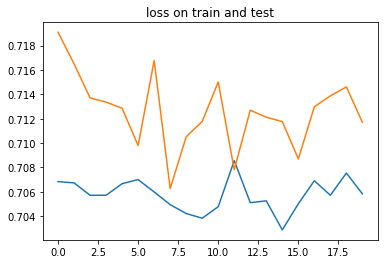

Last loss on train: 0.7058307808057397
Last loss on test: 0.711705998370522


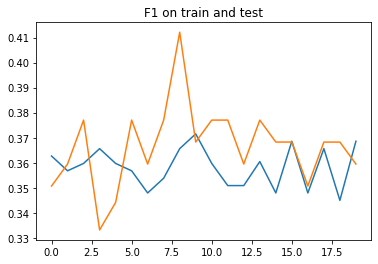

Last F1 on train: 0.36857035307757624
Last F1 on test: 0.3594795473312077


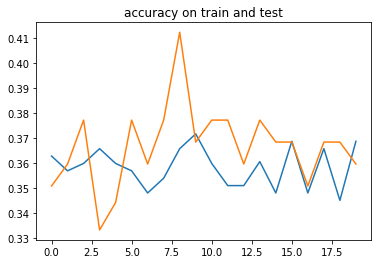

Last accuracy on train: 0.36873157282846164
Last accuracy on test: 0.3596491323489892


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 2.2
GRU 0 tokens, 1 sentence

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_1_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:02, 25.19it/s]

Train loss: 0.7072344422340393


94it [00:03, 26.80it/s]

Train loss: 0.6985703229904174


139it [00:05, 25.57it/s]

Train loss: 0.702363461918301


182it [00:07, 25.48it/s]

Train loss: 0.7043365425533719


226it [00:08, 25.22it/s]


Train loss: 0.7069394199053446

Evaluating on train...


53it [00:01, 41.94it/s]

Val loss: 0.7059073011080425, Val f1: 0.37761259542571174, Val accuracy: 0.3777777870496114


97it [00:02, 39.79it/s]

Val loss: 0.7092604994773865, Val f1: 0.36279526319768696, Val accuracy: 0.36296297245555453


142it [00:03, 37.95it/s]

Val loss: 0.7061489869047094, Val f1: 0.37267577317025924, Val accuracy: 0.3728395155182591


186it [00:04, 36.48it/s]

Val loss: 0.7042306390073564, Val f1: 0.36650610483354995, Val accuracy: 0.3666666761040688


226it [00:05, 38.65it/s]


Val loss: 0.7037080539597406, Val f1: 0.3657658318678538, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 37.07it/s]

Val loss: 0.7349873542785644, Val f1: 0.33313985069592794, Val accuracy: 0.3333333432674408


36it [00:01, 34.16it/s]

Val loss: 0.728266696135203, Val f1: 0.3331451217333476, Val accuracy: 0.3333333432674408


48it [00:01, 34.02it/s]

Val loss: 0.715165897210439, Val f1: 0.34797443879975215, Val accuracy: 0.34814815786149766


64it [00:01, 35.32it/s]

Val loss: 0.7142131547133128, Val f1: 0.3553820525606473, Val accuracy: 0.3555555651585261


76it [00:02, 36.02it/s]


Val loss: 0.7145009573300679, Val f1: 0.3509382410844167, Val accuracy: 0.35111112078030904

starting Epoch 1
Training...


50it [00:01, 26.05it/s]

Train loss: 0.7068240404129028


92it [00:03, 23.79it/s]

Train loss: 0.7004387848907047


140it [00:05, 26.13it/s]

Train loss: 0.7004809044025563


182it [00:07, 25.74it/s]

Train loss: 0.7052634172969394


226it [00:09, 25.08it/s]


Train loss: 0.7061992610825433

Evaluating on train...


53it [00:01, 35.06it/s]

Val loss: 0.70071439743042, Val f1: 0.3776235560576121, Val accuracy: 0.3777777870496114


96it [00:02, 37.87it/s]

Val loss: 0.7005882865852779, Val f1: 0.3628087994125154, Val accuracy: 0.36296297245555453


139it [00:04, 36.74it/s]

Val loss: 0.7022539606800786, Val f1: 0.3529304798002596, Val accuracy: 0.35308642939284995


186it [00:05, 39.48it/s]

Val loss: 0.7063434465063942, Val f1: 0.3516905736592081, Val accuracy: 0.3518518615100119


226it [00:06, 35.68it/s]


Val loss: 0.7075351553493076, Val f1: 0.3627995838059319, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 36.80it/s]

Val loss: 0.7219552119572957, Val f1: 0.33315165440241495, Val accuracy: 0.3333333432674408


36it [00:00, 37.21it/s]

Val loss: 0.7297092338403066, Val f1: 0.333145264784495, Val accuracy: 0.3333333432674408


52it [00:01, 37.79it/s]

Val loss: 0.7197090493308174, Val f1: 0.34797070026397703, Val accuracy: 0.34814815786149766


64it [00:01, 37.34it/s]

Val loss: 0.7106507668892542, Val f1: 0.3442771777510643, Val accuracy: 0.3444444542129835


76it [00:02, 37.73it/s]


Val loss: 0.7135836060841878, Val f1: 0.34205052614212034, Val accuracy: 0.3422222320238749

starting Epoch 2
Training...


48it [00:01, 26.02it/s]

Train loss: 0.7127925833066304


94it [00:03, 24.57it/s]

Train loss: 0.7065866887569427


139it [00:05, 25.65it/s]

Train loss: 0.7092995837882713


184it [00:07, 26.57it/s]

Train loss: 0.7087920629315906


226it [00:08, 25.32it/s]


Train loss: 0.7071028492185805

Evaluating on train...


49it [00:01, 41.35it/s]

Val loss: 0.7008102880583869, Val f1: 0.3776211334599389, Val accuracy: 0.3777777870496114


94it [00:02, 41.37it/s]

Val loss: 0.7037646883063846, Val f1: 0.36280391150050695, Val accuracy: 0.36296297245555453


139it [00:03, 38.68it/s]

Val loss: 0.7089174270629883, Val f1: 0.3578599035739899, Val accuracy: 0.35802470092420224


184it [00:04, 38.20it/s]

Val loss: 0.7080623355176714, Val f1: 0.3665024886528651, Val accuracy: 0.3666666761040688


226it [00:05, 39.49it/s]


Val loss: 0.7068574719958836, Val f1: 0.3657635137769911, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 36.77it/s]

Val loss: 0.6928760886192322, Val f1: 0.4220740715662638, Val accuracy: 0.422222230831782


36it [00:00, 37.04it/s]

Val loss: 0.7223825414975484, Val f1: 0.3775935600201289, Val accuracy: 0.3777777870496114


52it [00:01, 37.36it/s]

Val loss: 0.7262614462110731, Val f1: 0.36277406679259405, Val accuracy: 0.36296297245555453


64it [00:01, 37.19it/s]

Val loss: 0.7217693239450454, Val f1: 0.3664835934837659, Val accuracy: 0.3666666761040688


76it [00:02, 37.07it/s]


Val loss: 0.7155194036165873, Val f1: 0.3864893921216329, Val accuracy: 0.3866666758060455

starting Epoch 3
Training...


50it [00:01, 25.76it/s]

Train loss: 0.6828190710809495


92it [00:03, 25.15it/s]

Train loss: 0.6911285075876448


140it [00:05, 27.02it/s]

Train loss: 0.6960190132812217


185it [00:07, 25.48it/s]

Train loss: 0.702789048022694


226it [00:08, 25.19it/s]


Train loss: 0.7043483183119033

Evaluating on train...


53it [00:01, 42.86it/s]

Val loss: 0.6939831323093838, Val f1: 0.3480000588628981, Val accuracy: 0.34814815786149766


93it [00:02, 41.33it/s]

Val loss: 0.7028248952494727, Val f1: 0.3850255191326141, Val accuracy: 0.38518519434663984


139it [00:03, 37.17it/s]

Val loss: 0.7049560626347859, Val f1: 0.3726784105654116, Val accuracy: 0.3728395155182591


184it [00:04, 38.46it/s]

Val loss: 0.7067091054386563, Val f1: 0.3702068621913592, Val accuracy: 0.37037037975258297


226it [00:05, 39.34it/s]


Val loss: 0.7046246332592434, Val f1: 0.3746537941031986, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 36.47it/s]

Val loss: 0.7196369330088298, Val f1: 0.3331578036149343, Val accuracy: 0.3333333432674408


36it [00:00, 37.07it/s]

Val loss: 0.7184132794539134, Val f1: 0.33315915962060294, Val accuracy: 0.3333333432674408


52it [00:01, 37.33it/s]

Val loss: 0.7078745908207363, Val f1: 0.33317164447572495, Val accuracy: 0.3333333432674408


64it [00:01, 36.97it/s]

Val loss: 0.7134510864814122, Val f1: 0.33316463281710945, Val accuracy: 0.3333333432674408


76it [00:02, 36.80it/s]


Val loss: 0.7139900620778402, Val f1: 0.33316284060478213, Val accuracy: 0.3333333432674408

starting Epoch 4
Training...


47it [00:01, 26.19it/s]

Train loss: 0.7119671874576144


92it [00:03, 23.50it/s]

Train loss: 0.7062954783439637


140it [00:05, 25.23it/s]

Train loss: 0.7063009933189109


185it [00:07, 25.67it/s]

Train loss: 0.7086859888500637


226it [00:08, 25.29it/s]


Train loss: 0.7049630223380194

Evaluating on train...


53it [00:01, 41.52it/s]

Val loss: 0.7119821998808119, Val f1: 0.3331626918580797, Val accuracy: 0.3333333432674408


97it [00:02, 39.09it/s]

Val loss: 0.7102138612005445, Val f1: 0.3405717455678516, Val accuracy: 0.34074075056446923


140it [00:03, 38.63it/s]

Val loss: 0.7048628202191105, Val f1: 0.34304762769628455, Val accuracy: 0.3432098863301454


186it [00:04, 39.12it/s]

Val loss: 0.7038380314906438, Val f1: 0.3516912627551291, Val accuracy: 0.3518518615100119


226it [00:05, 39.02it/s]


Val loss: 0.707196610238817, Val f1: 0.3509463063875834, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 37.06it/s]

Val loss: 0.7201701124509176, Val f1: 0.3776017228762309, Val accuracy: 0.3777777870496114


37it [00:00, 37.86it/s]

Val loss: 0.7237885574499766, Val f1: 0.3775943756103516, Val accuracy: 0.3777777870496114


49it [00:01, 34.64it/s]

Val loss: 0.7170640693770515, Val f1: 0.3627896666526794, Val accuracy: 0.36296297245555453


65it [00:01, 36.99it/s]

Val loss: 0.7150584946076075, Val f1: 0.3664960314830144, Val accuracy: 0.3666666761040688


76it [00:02, 36.82it/s]


Val loss: 0.7116921297709147, Val f1: 0.3598337701956431, Val accuracy: 0.36000000953674316

starting Epoch 5
Training...


48it [00:01, 26.30it/s]

Train loss: 0.7230605681737264


93it [00:03, 25.58it/s]

Train loss: 0.704834168487125


138it [00:05, 25.14it/s]

Train loss: 0.7104425960116916


183it [00:07, 25.91it/s]

Train loss: 0.7103535807794995


226it [00:08, 25.42it/s]


Train loss: 0.7074755816989475

Evaluating on train...


49it [00:01, 39.20it/s]

Val loss: 0.7037257724338107, Val f1: 0.3331766214635637, Val accuracy: 0.3333333432674408


94it [00:02, 39.02it/s]

Val loss: 0.7099181122250027, Val f1: 0.3405742327372233, Val accuracy: 0.34074075056446923


140it [00:03, 38.23it/s]

Val loss: 0.7073426626346729, Val f1: 0.3529224530414299, Val accuracy: 0.35308642939284995


185it [00:04, 37.17it/s]

Val loss: 0.7049964487552642, Val f1: 0.3590981387429767, Val accuracy: 0.35925926880704034


226it [00:05, 38.97it/s]


Val loss: 0.7048163715998331, Val f1: 0.36280210097630816, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.19it/s]

Val loss: 0.6846029718716939, Val f1: 0.3776421626408895, Val accuracy: 0.3777777870496114


36it [00:00, 37.04it/s]

Val loss: 0.7070201456546783, Val f1: 0.355391201376915, Val accuracy: 0.3555555651585261


52it [00:01, 37.78it/s]

Val loss: 0.7112775656912061, Val f1: 0.36279296278953554, Val accuracy: 0.36296297245555453


64it [00:01, 36.75it/s]

Val loss: 0.7103245536486308, Val f1: 0.36649844497442247, Val accuracy: 0.3666666761040688


76it [00:02, 37.31it/s]


Val loss: 0.7140606466929118, Val f1: 0.35982768019040423, Val accuracy: 0.36000000953674316

starting Epoch 6
Training...


48it [00:01, 22.87it/s]

Train loss: 0.7124401026301914


93it [00:03, 26.26it/s]

Train loss: 0.7102512664265103


138it [00:05, 24.42it/s]

Train loss: 0.7121335223869041


183it [00:07, 26.86it/s]

Train loss: 0.7100541757212745


226it [00:08, 25.38it/s]


Train loss: 0.7080307451883951

Evaluating on train...


49it [00:01, 40.12it/s]

Val loss: 0.6982352707121108, Val f1: 0.39243394600020515, Val accuracy: 0.39259260164366827


94it [00:02, 39.57it/s]

Val loss: 0.7023156298531427, Val f1: 0.3702098813321855, Val accuracy: 0.37037037975258297


141it [00:03, 38.36it/s]

Val loss: 0.7047094543774922, Val f1: 0.3628006025596901, Val accuracy: 0.36296297245555453


185it [00:04, 37.52it/s]

Val loss: 0.7070224891106288, Val f1: 0.35909440335300236, Val accuracy: 0.35925926880704034


226it [00:05, 39.21it/s]


Val loss: 0.70529700756073, Val f1: 0.3539118270079295, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 37.88it/s]

Val loss: 0.7324504574139913, Val f1: 0.3331393897533417, Val accuracy: 0.3333333432674408


36it [00:00, 37.72it/s]

Val loss: 0.7257222394148509, Val f1: 0.3331446677446365, Val accuracy: 0.3333333432674408


52it [00:01, 36.36it/s]

Val loss: 0.7244690457979838, Val f1: 0.33314330842759876, Val accuracy: 0.3333333432674408


64it [00:01, 37.08it/s]

Val loss: 0.715591095884641, Val f1: 0.34426702161629996, Val accuracy: 0.3444444542129835


76it [00:02, 37.58it/s]


Val loss: 0.7075494956970215, Val f1: 0.3509443513552348, Val accuracy: 0.35111112078030904

starting Epoch 7
Training...


48it [00:01, 25.32it/s]

Train loss: 0.6977779375182258


93it [00:03, 26.59it/s]

Train loss: 0.691801024807824


139it [00:05, 25.70it/s]

Train loss: 0.7015720045125043


184it [00:07, 25.52it/s]

Train loss: 0.7037720968325932


226it [00:08, 25.40it/s]


Train loss: 0.707134084171719

Evaluating on train...


49it [00:01, 42.26it/s]

Val loss: 0.7079784366819594, Val f1: 0.36279551850424874, Val accuracy: 0.36296297245555453


94it [00:02, 40.25it/s]

Val loss: 0.7069171534644233, Val f1: 0.35539263122611575, Val accuracy: 0.3555555651585261


141it [00:03, 38.53it/s]

Val loss: 0.7006726490126716, Val f1: 0.3677462588857721, Val accuracy: 0.3679012439869068


186it [00:04, 37.09it/s]

Val loss: 0.7026026040315628, Val f1: 0.36280504961808524, Val accuracy: 0.36296297245555453


226it [00:05, 39.20it/s]


Val loss: 0.7053818024529351, Val f1: 0.3568760491742028, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 36.38it/s]

Val loss: 0.7117660800615947, Val f1: 0.3331675946712494, Val accuracy: 0.3333333432674408


36it [00:00, 36.01it/s]

Val loss: 0.7158044834931692, Val f1: 0.33315952122211456, Val accuracy: 0.3333333432674408


52it [00:01, 37.01it/s]

Val loss: 0.724323774708642, Val f1: 0.3331456416183048, Val accuracy: 0.3333333432674408


64it [00:01, 36.33it/s]

Val loss: 0.722801881035169, Val f1: 0.33314954936504365, Val accuracy: 0.3333333432674408


76it [00:02, 36.58it/s]


Val loss: 0.7186725735664368, Val f1: 0.33315426111221313, Val accuracy: 0.3333333432674408

starting Epoch 8
Training...


48it [00:02, 25.21it/s]

Train loss: 0.7002714104122586


93it [00:04, 24.79it/s]

Train loss: 0.6998387535413106


138it [00:06, 24.05it/s]

Train loss: 0.7017742148152104


183it [00:07, 26.15it/s]

Train loss: 0.7009466873274909


226it [00:09, 23.83it/s]


Train loss: 0.7052484750747681

Evaluating on train...


50it [00:01, 42.00it/s]

Val loss: 0.707838695579105, Val f1: 0.37761100464397007, Val accuracy: 0.3777777870496114


95it [00:02, 39.71it/s]

Val loss: 0.7170606242285834, Val f1: 0.35537905461258357, Val accuracy: 0.3555555651585261


141it [00:03, 37.80it/s]

Val loss: 0.7080978662879379, Val f1: 0.372673166681219, Val accuracy: 0.3728395155182591


187it [00:04, 38.59it/s]

Val loss: 0.705387630396419, Val f1: 0.3702079549431801, Val accuracy: 0.37037037975258297


226it [00:05, 39.42it/s]


Val loss: 0.7069692638185289, Val f1: 0.3627993350558811, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 38.24it/s]

Val loss: 0.6958233118057251, Val f1: 0.37762641310691836, Val accuracy: 0.3777777870496114


36it [00:00, 36.67it/s]

Val loss: 0.7150743583838145, Val f1: 0.35538343091805774, Val accuracy: 0.3555555651585261


52it [00:01, 36.61it/s]

Val loss: 0.7104371733135647, Val f1: 0.37761052317089505, Val accuracy: 0.3777777870496114


64it [00:01, 35.85it/s]

Val loss: 0.713092240691185, Val f1: 0.36649583528439206, Val accuracy: 0.3666666761040688


76it [00:02, 37.10it/s]


Val loss: 0.7083192745844523, Val f1: 0.3776126305262248, Val accuracy: 0.3777777870496114

starting Epoch 9
Training...


49it [00:02, 22.02it/s]

Train loss: 0.7162074738078648


94it [00:03, 25.72it/s]

Train loss: 0.7043287144766913


139it [00:05, 25.56it/s]

Train loss: 0.70089004083916


184it [00:07, 25.14it/s]

Train loss: 0.7031442844205432


226it [00:08, 25.20it/s]


Train loss: 0.7058873515658909

Evaluating on train...


49it [00:01, 41.42it/s]

Val loss: 0.7160988847414652, Val f1: 0.3331586572859022, Val accuracy: 0.3333333432674408


97it [00:02, 37.65it/s]

Val loss: 0.7036899937523736, Val f1: 0.3553964508904351, Val accuracy: 0.3555555651585261


141it [00:03, 38.79it/s]

Val loss: 0.7052672112429583, Val f1: 0.35292569156046266, Val accuracy: 0.35308642939284995


186it [00:04, 36.56it/s]

Val loss: 0.7080633898576101, Val f1: 0.35168797175089517, Val accuracy: 0.3518518615100119


226it [00:05, 38.74it/s]


Val loss: 0.7033258567916022, Val f1: 0.3568784981303745, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 37.22it/s]

Val loss: 0.7266023556391398, Val f1: 0.4664707879225413, Val accuracy: 0.4666666746139526


36it [00:00, 36.99it/s]

Val loss: 0.7208930015563965, Val f1: 0.4220367898543676, Val accuracy: 0.422222230831782


48it [00:01, 35.05it/s]

Val loss: 0.7163993663258023, Val f1: 0.40722958578003776, Val accuracy: 0.40740741623772514


64it [00:01, 34.74it/s]

Val loss: 0.7220055798689524, Val f1: 0.39981472194194795, Val accuracy: 0.4000000089406967


76it [00:02, 36.08it/s]


Val loss: 0.710327087243398, Val f1: 0.38649677912394204, Val accuracy: 0.3866666758060455

starting Epoch 10
Training...


48it [00:02, 24.45it/s]

Train loss: 0.723230799039205


93it [00:03, 25.56it/s]

Train loss: 0.7071453677283392


138it [00:05, 24.70it/s]

Train loss: 0.7078783958046525


183it [00:07, 25.38it/s]

Train loss: 0.709384998679161


226it [00:09, 25.01it/s]


Train loss: 0.706412365436554

Evaluating on train...


51it [00:01, 43.55it/s]

Val loss: 0.7224548432562087, Val f1: 0.36277689205275643, Val accuracy: 0.36296297245555453


96it [00:02, 41.73it/s]

Val loss: 0.7115900549623702, Val f1: 0.37019736170768736, Val accuracy: 0.37037037975258297


142it [00:03, 37.86it/s]

Val loss: 0.7039169298277961, Val f1: 0.37761555424443, Val accuracy: 0.3777777870496114


188it [00:04, 38.63it/s]

Val loss: 0.702748939063814, Val f1: 0.3665074129899343, Val accuracy: 0.3666666761040688


226it [00:05, 39.52it/s]


Val loss: 0.7075730196634928, Val f1: 0.3627982453505198, Val accuracy: 0.36296297245555453

Evaluating on test...


21it [00:00, 39.38it/s]

Val loss: 0.693531318505605, Val f1: 0.4220714767773946, Val accuracy: 0.422222230831782


37it [00:00, 37.90it/s]

Val loss: 0.710038552681605, Val f1: 0.37761088212331134, Val accuracy: 0.3777777870496114


49it [00:01, 38.03it/s]

Val loss: 0.7095293972227309, Val f1: 0.3924252311388651, Val accuracy: 0.39259260164366827


65it [00:01, 37.49it/s]

Val loss: 0.716402201851209, Val f1: 0.38871294309695564, Val accuracy: 0.3888888979951541


76it [00:02, 37.76it/s]


Val loss: 0.7175788617134095, Val f1: 0.37759977459907534, Val accuracy: 0.3777777870496114

starting Epoch 11
Training...


49it [00:02, 24.72it/s]

Train loss: 0.6987620962990655


94it [00:03, 24.93it/s]

Train loss: 0.706974928246604


139it [00:05, 26.31it/s]

Train loss: 0.7085368090205723


184it [00:07, 25.30it/s]

Train loss: 0.7037187808089787


226it [00:09, 25.11it/s]


Train loss: 0.7046077309714424

Evaluating on train...


49it [00:01, 41.85it/s]

Val loss: 0.7212885816891988, Val f1: 0.3331542452176412, Val accuracy: 0.3333333432674408


94it [00:02, 40.36it/s]

Val loss: 0.7098609242174361, Val f1: 0.35539011392328473, Val accuracy: 0.3555555651585261


142it [00:03, 38.20it/s]

Val loss: 0.7085761622146324, Val f1: 0.3479843084458952, Val accuracy: 0.34814815786149766


187it [00:04, 37.16it/s]

Val loss: 0.7088391674889458, Val f1: 0.3479836677511533, Val accuracy: 0.34814815786149766


226it [00:05, 39.12it/s]


Val loss: 0.7062720828586154, Val f1: 0.35094918264283076, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 37.28it/s]

Val loss: 0.674685291449229, Val f1: 0.38876196344693503, Val accuracy: 0.3888888974984487


36it [00:00, 37.03it/s]

Val loss: 0.7042754908402761, Val f1: 0.40539174477259315, Val accuracy: 0.40555556416511535


48it [00:01, 36.77it/s]

Val loss: 0.7126301407814026, Val f1: 0.38131043314933777, Val accuracy: 0.38148149053255714


65it [00:01, 37.96it/s]

Val loss: 0.7116462995608648, Val f1: 0.3692760467529297, Val accuracy: 0.3694444537162781


76it [00:02, 37.55it/s]


Val loss: 0.7123063524564107, Val f1: 0.3709423792362213, Val accuracy: 0.37111112038294475

starting Epoch 12
Training...


47it [00:01, 24.97it/s]

Train loss: 0.7078913556204902


92it [00:03, 25.48it/s]

Train loss: 0.7120047456688351


137it [00:05, 23.04it/s]

Train loss: 0.7050660919260096


185it [00:07, 25.40it/s]

Train loss: 0.6990686340464486


226it [00:09, 25.05it/s]


Train loss: 0.7035512842072381

Evaluating on train...


50it [00:01, 41.92it/s]

Val loss: 0.6997500883208381, Val f1: 0.3776236103640662, Val accuracy: 0.3777777870496114


95it [00:02, 40.50it/s]

Val loss: 0.7071136706405216, Val f1: 0.3627988596757253, Val accuracy: 0.36296297245555453


141it [00:03, 37.82it/s]

Val loss: 0.7099736633124175, Val f1: 0.36279520635251644, Val accuracy: 0.36296297245555453


187it [00:04, 39.40it/s]

Val loss: 0.7097941799296273, Val f1: 0.3590923705034786, Val accuracy: 0.35925926880704034


226it [00:05, 39.06it/s]


Val loss: 0.7054692567719354, Val f1: 0.3598387469185723, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 37.89it/s]

Val loss: 0.6967543641726176, Val f1: 0.33318792581558226, Val accuracy: 0.3333333432674408


36it [00:00, 36.60it/s]

Val loss: 0.7108684400717418, Val f1: 0.33317016065120697, Val accuracy: 0.3333333432674408


52it [00:01, 37.38it/s]

Val loss: 0.7140076412094964, Val f1: 0.3479793647925059, Val accuracy: 0.34814815786149766


64it [00:01, 36.96it/s]

Val loss: 0.7101220428943634, Val f1: 0.3442803313334783, Val accuracy: 0.3444444542129835


76it [00:02, 37.06it/s]


Val loss: 0.7136570771535238, Val f1: 0.35094189246495566, Val accuracy: 0.35111112078030904

starting Epoch 13
Training...


48it [00:02, 22.10it/s]

Train loss: 0.7099708808792962


93it [00:03, 25.69it/s]

Train loss: 0.7089194006390042


138it [00:05, 25.39it/s]

Train loss: 0.7059786107805041


183it [00:07, 26.00it/s]

Train loss: 0.7069417046176063


226it [00:09, 25.04it/s]


Train loss: 0.7053600774870978

Evaluating on train...


49it [00:01, 41.08it/s]

Val loss: 0.6937437176704406, Val f1: 0.37763076821962993, Val accuracy: 0.3777777870496114


97it [00:02, 39.66it/s]

Val loss: 0.6957403348551856, Val f1: 0.37762845092349584, Val accuracy: 0.3777777870496114


141it [00:03, 38.26it/s]

Val loss: 0.6927401957688508, Val f1: 0.3825704614321391, Val accuracy: 0.3827160585809637


186it [00:04, 38.37it/s]

Val loss: 0.6996014346679051, Val f1: 0.38132592688004174, Val accuracy: 0.38148149069812565


226it [00:05, 38.42it/s]


Val loss: 0.7032742659250896, Val f1: 0.3776180317666796, Val accuracy: 0.3777777870496114

Evaluating on test...


20it [00:00, 37.66it/s]

Val loss: 0.7260216395060222, Val f1: 0.3331486821174622, Val accuracy: 0.3333333432674408


36it [00:00, 35.85it/s]

Val loss: 0.6925889650980631, Val f1: 0.3331887533267339, Val accuracy: 0.3333333432674408


52it [00:01, 36.09it/s]

Val loss: 0.6989704158571032, Val f1: 0.3331792222128974, Val accuracy: 0.3333333432674408


64it [00:01, 37.29it/s]

Val loss: 0.7024671077728272, Val f1: 0.3331734582781792, Val accuracy: 0.3333333432674408


76it [00:02, 36.73it/s]


Val loss: 0.7110965633392334, Val f1: 0.3331617474555969, Val accuracy: 0.3333333432674408

starting Epoch 14
Training...


48it [00:02, 26.46it/s]

Train loss: 0.7205196844206916


93it [00:03, 25.45it/s]

Train loss: 0.7089248643981085


138it [00:05, 25.52it/s]

Train loss: 0.7076437084763139


183it [00:07, 24.86it/s]

Train loss: 0.710606336262491


226it [00:09, 24.94it/s]


Train loss: 0.7045699151357016

Evaluating on train...


53it [00:01, 40.97it/s]

Val loss: 0.7204903099271986, Val f1: 0.33315438363287186, Val accuracy: 0.3333333432674408


95it [00:02, 38.49it/s]

Val loss: 0.7125890407297346, Val f1: 0.35538484818405575, Val accuracy: 0.3555555651585261


139it [00:04, 32.35it/s]

Val loss: 0.7050365832116868, Val f1: 0.3677388213298939, Val accuracy: 0.3679012439869068


187it [00:05, 34.85it/s]

Val loss: 0.7072337912188635, Val f1: 0.36650225735372965, Val accuracy: 0.3666666761040688


226it [00:06, 33.88it/s]


Val loss: 0.7066695846451654, Val f1: 0.3598369538784027, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 36.85it/s]

Val loss: 0.7324995319048564, Val f1: 0.3331420222918193, Val accuracy: 0.3333333432674408


36it [00:00, 36.03it/s]

Val loss: 0.7244180003801982, Val f1: 0.3553712417682012, Val accuracy: 0.3555555651585261


52it [00:01, 36.84it/s]

Val loss: 0.7140237119462755, Val f1: 0.37760564419958326, Val accuracy: 0.3777777870496114


64it [00:01, 35.23it/s]

Val loss: 0.718180509408315, Val f1: 0.366491274535656, Val accuracy: 0.3666666761040688


76it [00:02, 36.29it/s]


Val loss: 0.7144162893295288, Val f1: 0.359828603665034, Val accuracy: 0.36000000953674316

starting Epoch 15
Training...


50it [00:02, 24.76it/s]

Train loss: 0.6943237092759874


95it [00:03, 24.55it/s]

Train loss: 0.6980206476317512


137it [00:05, 27.25it/s]

Train loss: 0.7034732337351198


185it [00:07, 24.65it/s]

Train loss: 0.7083859586053425


226it [00:09, 24.88it/s]


Train loss: 0.7048290888468425

Evaluating on train...


49it [00:01, 40.39it/s]

Val loss: 0.7135015368461609, Val f1: 0.37760393222173055, Val accuracy: 0.3777777870496114


94it [00:02, 39.88it/s]

Val loss: 0.7131436533398099, Val f1: 0.3850123147169749, Val accuracy: 0.38518519434663984


139it [00:03, 37.68it/s]

Val loss: 0.712866672763118, Val f1: 0.37760678220678257, Val accuracy: 0.3777777870496114


183it [00:04, 34.07it/s]

Val loss: 0.7099625140428543, Val f1: 0.37390684336423874, Val accuracy: 0.3740740834010972


226it [00:05, 38.10it/s]


Val loss: 0.7074078088336521, Val f1: 0.36576244950294495, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 36.38it/s]

Val loss: 0.716409961382548, Val f1: 0.42204013268152873, Val accuracy: 0.422222230831782


36it [00:00, 35.78it/s]

Val loss: 0.7192671537399292, Val f1: 0.42203936477502185, Val accuracy: 0.422222230831782


52it [00:01, 36.22it/s]

Val loss: 0.716879419485728, Val f1: 0.3924145499865214, Val accuracy: 0.39259260164366827


64it [00:01, 35.51it/s]

Val loss: 0.7132315456867218, Val f1: 0.3887154335776965, Val accuracy: 0.3888888979951541


76it [00:02, 35.99it/s]


Val loss: 0.7093570947647094, Val f1: 0.39538757801055907, Val accuracy: 0.39555556456247964

starting Epoch 16
Training...


49it [00:01, 26.28it/s]

Train loss: 0.7115031904644437


94it [00:03, 26.01it/s]

Train loss: 0.7082326557901171


139it [00:05, 26.00it/s]

Train loss: 0.7091597927941217


184it [00:07, 25.87it/s]

Train loss: 0.7083298444747925


226it [00:08, 25.19it/s]


Train loss: 0.706220760345459

Evaluating on train...


51it [00:01, 40.81it/s]

Val loss: 0.6941017309824625, Val f1: 0.3776273508866628, Val accuracy: 0.3777777870496114


96it [00:02, 39.85it/s]

Val loss: 0.7018599576420255, Val f1: 0.37021070155832503, Val accuracy: 0.37037037975258297


142it [00:03, 38.93it/s]

Val loss: 0.7032839236436067, Val f1: 0.35786361782639114, Val accuracy: 0.35802470092420224


186it [00:04, 37.41it/s]

Val loss: 0.7072090360853407, Val f1: 0.3627972506814533, Val accuracy: 0.36296297245555453


226it [00:05, 38.95it/s]


Val loss: 0.7071501877572801, Val f1: 0.3687229651874966, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 36.33it/s]

Val loss: 0.7276194453239441, Val f1: 0.37758406400680544, Val accuracy: 0.3777777870496114


36it [00:00, 36.24it/s]

Val loss: 0.7146036008993785, Val f1: 0.3553798774878184, Val accuracy: 0.3555555651585261


48it [00:01, 36.67it/s]

Val loss: 0.7135125372144911, Val f1: 0.3627885388003455, Val accuracy: 0.36296297245555453


65it [00:01, 37.82it/s]

Val loss: 0.7198063979546229, Val f1: 0.35537314613660176, Val accuracy: 0.3555555651585261


76it [00:02, 36.91it/s]


Val loss: 0.7131943519910177, Val f1: 0.35093782862027484, Val accuracy: 0.35111112078030904

starting Epoch 17
Training...


48it [00:01, 25.75it/s]

Train loss: 0.6933821704652574


93it [00:03, 24.85it/s]

Train loss: 0.6983365992705027


138it [00:05, 25.62it/s]

Train loss: 0.6988297868657996


183it [00:07, 24.84it/s]

Train loss: 0.7024687141180038


226it [00:09, 25.09it/s]


Train loss: 0.7069337254100375

Evaluating on train...


52it [00:01, 41.37it/s]

Val loss: 0.7071417808532715, Val f1: 0.3479872359169854, Val accuracy: 0.34814815786149766


97it [00:02, 40.09it/s]

Val loss: 0.7062192016177707, Val f1: 0.3702087769905726, Val accuracy: 0.37037037975258297


142it [00:03, 37.40it/s]

Val loss: 0.7004988939673812, Val f1: 0.36280800611884506, Val accuracy: 0.36296297245555453


186it [00:04, 37.23it/s]

Val loss: 0.7006684574815962, Val f1: 0.37021436658170487, Val accuracy: 0.37037037975258297


226it [00:05, 38.49it/s]


Val loss: 0.7036897802352905, Val f1: 0.3716914759741889, Val accuracy: 0.37185186121198865

Evaluating on test...


21it [00:00, 38.43it/s]

Val loss: 0.720888062318166, Val f1: 0.3331566790739695, Val accuracy: 0.3333333432674408


37it [00:01, 35.83it/s]

Val loss: 0.7219885726769765, Val f1: 0.33315628369649253, Val accuracy: 0.3333333432674408


49it [00:01, 36.13it/s]

Val loss: 0.7060328510072497, Val f1: 0.3331744756963518, Val accuracy: 0.3333333432674408


65it [00:01, 36.57it/s]

Val loss: 0.7159265995025634, Val f1: 0.3331613992651304, Val accuracy: 0.3333333432674408


76it [00:02, 36.63it/s]


Val loss: 0.7186414901415507, Val f1: 0.33315798997879026, Val accuracy: 0.3333333432674408

starting Epoch 18
Training...


49it [00:01, 24.96it/s]

Train loss: 0.7073662069108752


94it [00:03, 25.99it/s]

Train loss: 0.7052153401904636


139it [00:05, 24.85it/s]

Train loss: 0.7040603770150079


184it [00:07, 25.48it/s]

Train loss: 0.7095384316311942


226it [00:09, 24.98it/s]


Train loss: 0.7050530303849114

Evaluating on train...


48it [00:01, 41.39it/s]

Val loss: 0.6959818296962315, Val f1: 0.34800277087423537, Val accuracy: 0.34814815786149766


95it [00:02, 39.42it/s]

Val loss: 0.6999717195828755, Val f1: 0.347996602124638, Val accuracy: 0.34814815786149766


140it [00:03, 37.97it/s]

Val loss: 0.7014424377017551, Val f1: 0.3479946204909572, Val accuracy: 0.34814815786149766


185it [00:04, 38.33it/s]

Val loss: 0.7086910800801383, Val f1: 0.3479851969414287, Val accuracy: 0.34814815786149766


226it [00:05, 37.86it/s]


Val loss: 0.7079990002844069, Val f1: 0.3479852583673265, Val accuracy: 0.34814815786149766

Evaluating on test...


20it [00:00, 37.28it/s]

Val loss: 0.7158400456110636, Val f1: 0.42204199035962425, Val accuracy: 0.422222230831782


36it [00:00, 36.98it/s]

Val loss: 0.6963841358820597, Val f1: 0.3776224096616109, Val accuracy: 0.3777777870496114


52it [00:01, 36.76it/s]

Val loss: 0.6998424026701185, Val f1: 0.3924323366747962, Val accuracy: 0.39259260164366827


64it [00:01, 36.62it/s]

Val loss: 0.7068976769844691, Val f1: 0.37761063128709793, Val accuracy: 0.3777777870496114


76it [00:02, 36.59it/s]


Val loss: 0.7091135493914287, Val f1: 0.3776079706350962, Val accuracy: 0.3777777870496114

starting Epoch 19
Training...


48it [00:01, 23.79it/s]

Train loss: 0.7025603042708503


93it [00:03, 25.76it/s]

Train loss: 0.700631097290251


138it [00:05, 25.38it/s]

Train loss: 0.7034440618974191


183it [00:07, 26.28it/s]

Train loss: 0.6988017393483056


226it [00:09, 24.79it/s]


Train loss: 0.7026099594434102

Evaluating on train...


49it [00:01, 42.20it/s]

Val loss: 0.6980260557598538, Val f1: 0.4072563535637326, Val accuracy: 0.40740741623772514


94it [00:02, 41.24it/s]

Val loss: 0.7068084213468764, Val f1: 0.39242883192168343, Val accuracy: 0.39259260164366827


140it [00:03, 36.89it/s]

Val loss: 0.7089648507259511, Val f1: 0.37761061478544167, Val accuracy: 0.3777777870496114


184it [00:04, 37.55it/s]

Val loss: 0.7073873413933648, Val f1: 0.37020538449287416, Val accuracy: 0.37037037975258297


226it [00:05, 38.89it/s]


Val loss: 0.7064076611730787, Val f1: 0.3627997268570794, Val accuracy: 0.36296297245555453

Evaluating on test...


22it [00:00, 39.11it/s]

Val loss: 0.7113672335942586, Val f1: 0.3331698497136434, Val accuracy: 0.3333333432674408


34it [00:00, 38.63it/s]

Val loss: 0.707718692223231, Val f1: 0.33316801687081654, Val accuracy: 0.3333333432674408


50it [00:01, 36.96it/s]

Val loss: 0.7142282830344306, Val f1: 0.33316168718867833, Val accuracy: 0.3333333432674408


66it [00:01, 37.40it/s]

Val loss: 0.7142209321260452, Val f1: 0.34427126944065095, Val accuracy: 0.3444444542129835


76it [00:02, 37.52it/s]

Val loss: 0.7186253833770752, Val f1: 0.34204384406407673, Val accuracy: 0.3422222320238749


## Graphics

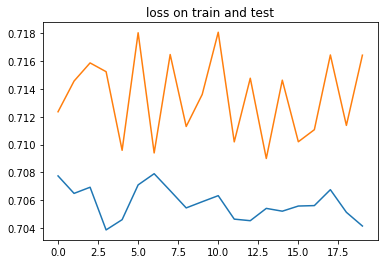

Last loss on train: 0.7041369958788948
Last loss on test: 0.7164256368812761


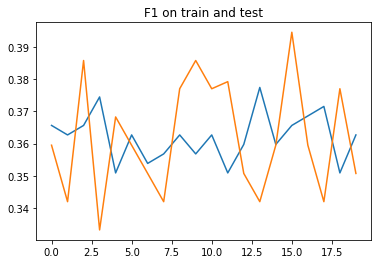

Last F1 on train: 0.3626683498114611
Last F1 on test: 0.3507011619053389


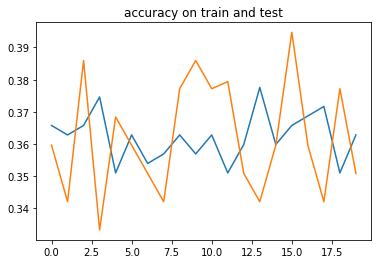

Last accuracy on train: 0.3628318679016248
Last accuracy on test: 0.3508772026551397


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 2.3
GRU 0 tokens, 2 sentences

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 22.83it/s]

Train loss: 0.7033658597204421


92it [00:04, 21.62it/s]

Train loss: 0.7102413607968224


137it [00:06, 22.11it/s]

Train loss: 0.7069605703707095


182it [00:08, 21.67it/s]

Train loss: 0.7049952646096548


226it [00:10, 21.76it/s]


Train loss: 0.707180815272861

Evaluating on train...


52it [00:01, 36.32it/s]

Val loss: 0.7187310165829128, Val f1: 0.3479704982704587, Val accuracy: 0.34814815786149766


96it [00:02, 34.02it/s]

Val loss: 0.7118091331587897, Val f1: 0.3553862598207262, Val accuracy: 0.3555555651585261


140it [00:03, 33.87it/s]

Val loss: 0.7049875572875693, Val f1: 0.3578637577869274, Val accuracy: 0.35802470092420224


184it [00:05, 32.57it/s]

Val loss: 0.7038969579670165, Val f1: 0.35909975899590385, Val accuracy: 0.35925926880704034


226it [00:06, 34.26it/s]


Val loss: 0.705360947450002, Val f1: 0.35687661435869006, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 31.87it/s]

Val loss: 0.6944032112757365, Val f1: 0.37762571771939596, Val accuracy: 0.3777777870496114


36it [00:01, 32.43it/s]

Val loss: 0.705097625652949, Val f1: 0.35539430181185405, Val accuracy: 0.3555555651585261


48it [00:01, 33.14it/s]

Val loss: 0.7061275548405117, Val f1: 0.36280122796694436, Val accuracy: 0.36296297245555453


64it [00:01, 33.60it/s]

Val loss: 0.7064852476119995, Val f1: 0.36650470793247225, Val accuracy: 0.3666666761040688


76it [00:02, 33.05it/s]


Val loss: 0.7116009696324667, Val f1: 0.3598312989870707, Val accuracy: 0.36000000953674316

starting Epoch 1
Training...


48it [00:02, 23.64it/s]

Train loss: 0.7206508371565077


92it [00:04, 22.67it/s]

Train loss: 0.7149000962575277


137it [00:06, 22.24it/s]

Train loss: 0.7127801908387078


182it [00:08, 23.48it/s]

Train loss: 0.7127820687161551


226it [00:10, 22.06it/s]


Train loss: 0.7062401368882921

Evaluating on train...


52it [00:01, 38.09it/s]

Val loss: 0.7174328141742282, Val f1: 0.3479724241627587, Val accuracy: 0.34814815786149766


96it [00:02, 33.88it/s]

Val loss: 0.707664700349172, Val f1: 0.357242809732755, Val accuracy: 0.357407416899999


140it [00:03, 33.95it/s]

Val loss: 0.7065677364667257, Val f1: 0.35415705420352794, Val accuracy: 0.35432099722049853


184it [00:05, 33.58it/s]

Val loss: 0.7079497036006716, Val f1: 0.3600189126200146, Val accuracy: 0.36018519467777677


226it [00:06, 34.93it/s]


Val loss: 0.7077192661497328, Val f1: 0.3605750644207001, Val accuracy: 0.3607407502333323

Evaluating on test...


20it [00:00, 33.28it/s]

Val loss: 0.7267097075780232, Val f1: 0.37759029269218447, Val accuracy: 0.3777777870496114


36it [00:01, 33.13it/s]

Val loss: 0.717153791586558, Val f1: 0.37760137816270195, Val accuracy: 0.3777777870496114


48it [00:01, 33.45it/s]

Val loss: 0.7129587451616923, Val f1: 0.3776059018241035, Val accuracy: 0.3777777870496114


64it [00:01, 32.78it/s]

Val loss: 0.7135755856831868, Val f1: 0.3664949248234431, Val accuracy: 0.3666666761040688


76it [00:02, 33.23it/s]


Val loss: 0.7155011820793152, Val f1: 0.36871477564175925, Val accuracy: 0.3688888982931773

starting Epoch 2
Training...


49it [00:02, 22.57it/s]

Train loss: 0.7140529937214322


94it [00:04, 22.11it/s]

Train loss: 0.6934862779246436


139it [00:06, 23.31it/s]

Train loss: 0.6944897912166736


184it [00:08, 20.65it/s]

Train loss: 0.6901888380448024


226it [00:10, 21.94it/s]


Train loss: 0.6881491663720872

Evaluating on train...


52it [00:01, 36.64it/s]

Val loss: 0.6619007481469048, Val f1: 0.4244663993517558, Val accuracy: 0.5124865194161733


96it [00:02, 34.46it/s]

Val loss: 0.6678932779365115, Val f1: 0.4209745291206572, Val accuracy: 0.49507469435532886


140it [00:03, 33.68it/s]

Val loss: 0.6647876253834477, Val f1: 0.4238298910635489, Val accuracy: 0.49522442045035187


184it [00:05, 32.20it/s]

Val loss: 0.6662289450565974, Val f1: 0.4266729103194343, Val accuracy: 0.5010381773114204


226it [00:06, 34.32it/s]


Val loss: 0.6681088595920139, Val f1: 0.42671713444921705, Val accuracy: 0.5007196577390035

Evaluating on test...


20it [00:00, 32.50it/s]

Val loss: 0.6574435114860535, Val f1: 0.43287043571472167, Val accuracy: 0.5267736633618673


36it [00:01, 32.71it/s]

Val loss: 0.6795282463232676, Val f1: 0.43190570672353107, Val accuracy: 0.5213317275047302


48it [00:01, 32.64it/s]

Val loss: 0.6785848961936103, Val f1: 0.43037893970807395, Val accuracy: 0.5076798346307543


64it [00:01, 32.78it/s]

Val loss: 0.6800542205572129, Val f1: 0.42190327246983844, Val accuracy: 0.4879300187031428


76it [00:02, 33.17it/s]


Val loss: 0.6775894538561503, Val f1: 0.4323475523789724, Val accuracy: 0.5057437634468078

starting Epoch 3
Training...


48it [00:02, 21.03it/s]

Train loss: 0.6571272651354472


93it [00:04, 23.69it/s]

Train loss: 0.6634899238745372


138it [00:06, 20.93it/s]

Train loss: 0.6548446032736036


183it [00:08, 22.33it/s]

Train loss: 0.6477854874398973


226it [00:10, 22.00it/s]


Train loss: 0.641431393623352

Evaluating on train...


52it [00:01, 37.33it/s]

Val loss: 0.6006032586097717, Val f1: 0.3879579597049289, Val accuracy: 0.8244014918804169


96it [00:03, 26.43it/s]

Val loss: 0.5986515488889482, Val f1: 0.39314755929840933, Val accuracy: 0.8233904043833414


140it [00:04, 32.24it/s]

Val loss: 0.5979364651220817, Val f1: 0.39311769008636477, Val accuracy: 0.8317370304354915


184it [00:06, 32.17it/s]

Val loss: 0.5971906188461515, Val f1: 0.3939272892143991, Val accuracy: 0.8401059183809493


226it [00:07, 31.11it/s]


Val loss: 0.5990981316566467, Val f1: 0.39458857271406383, Val accuracy: 0.8391776982943217

Evaluating on test...


20it [00:00, 33.55it/s]

Val loss: 0.6274331728617351, Val f1: 0.38894421855608624, Val accuracy: 0.7815688927968343


36it [00:01, 33.43it/s]

Val loss: 0.6202638546625773, Val f1: 0.3867236763238907, Val accuracy: 0.7950211723645528


48it [00:01, 33.12it/s]

Val loss: 0.618473063574897, Val f1: 0.3878810875945621, Val accuracy: 0.7748045318656498


64it [00:01, 33.09it/s]

Val loss: 0.6148638546466827, Val f1: 0.3877498661478361, Val accuracy: 0.7878154133756955


76it [00:02, 33.28it/s]


Val loss: 0.6094533395767212, Val f1: 0.3903736476103465, Val accuracy: 0.8118593529860179

starting Epoch 4
Training...


49it [00:02, 22.89it/s]

Train loss: 0.6003913031684027


94it [00:04, 22.82it/s]

Train loss: 0.5997856544123755


139it [00:06, 21.58it/s]

Train loss: 0.5943945968592609


184it [00:08, 21.28it/s]

Train loss: 0.5918017394012876


226it [00:10, 22.11it/s]


Train loss: 0.5905402681562636

Evaluating on train...


49it [00:01, 37.16it/s]

Val loss: 0.578664411438836, Val f1: 0.4215805259015825, Val accuracy: 0.9286799801720513


93it [00:02, 33.99it/s]

Val loss: 0.5799989667203691, Val f1: 0.4274541334973441, Val accuracy: 0.9088115947114097


141it [00:04, 32.60it/s]

Val loss: 0.5800037772567184, Val f1: 0.42790325151549446, Val accuracy: 0.9106513385419492


185it [00:05, 33.02it/s]

Val loss: 0.5786390456888411, Val f1: 0.42863571809397805, Val accuracy: 0.9188162975841099


226it [00:06, 34.42it/s]


Val loss: 0.5779447507858276, Val f1: 0.42604201780425177, Val accuracy: 0.9211032634311253

Evaluating on test...


20it [00:00, 34.74it/s]

Val loss: 0.6026007493336996, Val f1: 0.4075966993967692, Val accuracy: 0.8347179392973582


36it [00:01, 34.54it/s]

Val loss: 0.5941107968489329, Val f1: 0.4044593373934428, Val accuracy: 0.853731847802798


48it [00:01, 33.90it/s]

Val loss: 0.5945295042461819, Val f1: 0.40954660442140367, Val accuracy: 0.8687737868891822


64it [00:01, 33.74it/s]

Val loss: 0.5953426947196324, Val f1: 0.4115099569161733, Val accuracy: 0.8714184318979581


76it [00:02, 34.29it/s]


Val loss: 0.5945275147755941, Val f1: 0.4137420638402303, Val accuracy: 0.8659892773628235

starting Epoch 5
Training...


49it [00:02, 19.98it/s]

Train loss: 0.580387184354994


94it [00:04, 21.89it/s]

Train loss: 0.5747235324647691


139it [00:06, 22.80it/s]

Train loss: 0.572702533668942


184it [00:08, 21.91it/s]

Train loss: 0.5733169426520666


226it [00:10, 21.92it/s]


Train loss: 0.5728559154934353

Evaluating on train...


52it [00:01, 36.80it/s]

Val loss: 0.5626705209414165, Val f1: 0.5073231644100613, Val accuracy: 0.9644438279999628


96it [00:02, 36.31it/s]

Val loss: 0.564878171020084, Val f1: 0.5137848777903451, Val accuracy: 0.9553418139616648


140it [00:03, 32.40it/s]

Val loss: 0.5640420375046906, Val f1: 0.5104719738165537, Val accuracy: 0.953047024541431


184it [00:05, 32.86it/s]

Val loss: 0.5649623887406455, Val f1: 0.511813626686732, Val accuracy: 0.9457618820998404


226it [00:06, 34.63it/s]


Val loss: 0.5655705783102247, Val f1: 0.5133208745055728, Val accuracy: 0.9424270345105066

Evaluating on test...


20it [00:00, 33.63it/s]

Val loss: 0.5862748026847839, Val f1: 0.49668948849042255, Val accuracy: 0.8713825782140096


36it [00:01, 34.03it/s]

Val loss: 0.5811884661515554, Val f1: 0.48949165840943654, Val accuracy: 0.8970518072446187


48it [00:01, 33.47it/s]

Val loss: 0.5851226819886102, Val f1: 0.47957687775293983, Val accuracy: 0.8654022296269734


64it [00:01, 33.24it/s]

Val loss: 0.5841558396816253, Val f1: 0.4740848903854688, Val accuracy: 0.8506777256727218


76it [00:02, 33.46it/s]


Val loss: 0.5799541592597961, Val f1: 0.4733115776379903, Val accuracy: 0.8645416514078776

starting Epoch 6
Training...


47it [00:02, 23.03it/s]

Train loss: 0.5686187055375841


92it [00:04, 21.17it/s]

Train loss: 0.5655563387605879


137it [00:06, 22.81it/s]

Train loss: 0.5643635056636952


182it [00:08, 20.60it/s]

Train loss: 0.5643753127919303


226it [00:10, 22.00it/s]


Train loss: 0.565572137037913

Evaluating on train...


52it [00:01, 37.01it/s]

Val loss: 0.5581334047847324, Val f1: 0.504619856013192, Val accuracy: 0.9432230691115061


96it [00:02, 35.45it/s]

Val loss: 0.5598514596621196, Val f1: 0.4880277375380198, Val accuracy: 0.937713063094351


140it [00:03, 34.31it/s]

Val loss: 0.5626244514076798, Val f1: 0.4920728659188306, Val accuracy: 0.9379095733165741


184it [00:05, 31.90it/s]

Val loss: 0.5625299059682423, Val f1: 0.49597866551743613, Val accuracy: 0.9372652812136544


226it [00:06, 34.38it/s]


Val loss: 0.5630475629700554, Val f1: 0.4953130111429426, Val accuracy: 0.9388142617543539

Evaluating on test...


20it [00:00, 35.98it/s]

Val loss: 0.5691172083218893, Val f1: 0.4527037858963013, Val accuracy: 0.9607213338216146


36it [00:01, 34.13it/s]

Val loss: 0.5712890267372132, Val f1: 0.45049881637096406, Val accuracy: 0.9070866743723551


48it [00:01, 33.71it/s]

Val loss: 0.5706326444943746, Val f1: 0.45916590889294945, Val accuracy: 0.9210618615150452


64it [00:01, 33.09it/s]

Val loss: 0.5734025090932846, Val f1: 0.46474708517392477, Val accuracy: 0.9126798729101817


76it [00:02, 34.18it/s]


Val loss: 0.5766714668273926, Val f1: 0.4601172745227814, Val accuracy: 0.8989765699704488

starting Epoch 7
Training...


46it [00:02, 21.57it/s]

Train loss: 0.5658031993442112


93it [00:04, 22.47it/s]

Train loss: 0.5655998879008823


138it [00:06, 23.37it/s]

Train loss: 0.5646394146813287


183it [00:08, 19.70it/s]

Train loss: 0.565253010392189


226it [00:10, 21.90it/s]


Train loss: 0.564638794263204

Evaluating on train...


52it [00:01, 38.20it/s]

Val loss: 0.5624663829803467, Val f1: 0.4711797270509932, Val accuracy: 0.9719966822200351


96it [00:02, 34.82it/s]

Val loss: 0.5619880040486653, Val f1: 0.47126430339283415, Val accuracy: 0.9629813525411818


140it [00:03, 32.62it/s]

Val loss: 0.5611532167152122, Val f1: 0.4733603166209327, Val accuracy: 0.9556582872514372


184it [00:05, 33.87it/s]

Val loss: 0.5622811204857296, Val f1: 0.47405124339792465, Val accuracy: 0.9539585532413588


226it [00:06, 34.44it/s]


Val loss: 0.5622407709227668, Val f1: 0.47331804513931275, Val accuracy: 0.950843991306093

Evaluating on test...


19it [00:00, 32.77it/s]

Val loss: 0.5658050775527954, Val f1: 0.4361154854297638, Val accuracy: 0.9246511658032736


35it [00:01, 31.34it/s]

Val loss: 0.570441601673762, Val f1: 0.4334832896788915, Val accuracy: 0.92898610830307


51it [00:01, 32.72it/s]

Val loss: 0.5726444376839532, Val f1: 0.4386924220456017, Val accuracy: 0.9364829805162218


63it [00:01, 31.98it/s]

Val loss: 0.5745364358027776, Val f1: 0.4390183309713999, Val accuracy: 0.9206007733941078


76it [00:02, 32.35it/s]


Val loss: 0.5744454137484233, Val f1: 0.4353009275595347, Val accuracy: 0.8989989372094472

starting Epoch 8
Training...


49it [00:02, 22.50it/s]

Train loss: 0.5571635921796163


94it [00:04, 21.52it/s]

Train loss: 0.5591401451163822


139it [00:06, 21.14it/s]

Train loss: 0.5596381743748983


184it [00:08, 21.75it/s]

Train loss: 0.559058584107293


226it [00:10, 21.97it/s]


Train loss: 0.5608180443445842

Evaluating on train...


52it [00:01, 36.02it/s]

Val loss: 0.5611641049385071, Val f1: 0.5688292238447401, Val accuracy: 0.9224203791883256


96it [00:02, 36.07it/s]

Val loss: 0.5610801147090064, Val f1: 0.5625703705681695, Val accuracy: 0.9266944666703542


140it [00:03, 34.30it/s]

Val loss: 0.562120446452388, Val f1: 0.5619478662808736, Val accuracy: 0.9270019074281056


184it [00:05, 34.41it/s]

Val loss: 0.5615000079075495, Val f1: 0.5739558849069807, Val accuracy: 0.9395596558849016


226it [00:06, 34.61it/s]


Val loss: 0.5606367068820529, Val f1: 0.5786347844865587, Val accuracy: 0.9433507180213928

Evaluating on test...


20it [00:00, 33.93it/s]

Val loss: 0.5691998521486918, Val f1: 0.5237632056077322, Val accuracy: 0.9578547159830729


36it [00:01, 33.41it/s]

Val loss: 0.5773408889770508, Val f1: 0.5243847131729126, Val accuracy: 0.9384828368822734


48it [00:01, 32.50it/s]

Val loss: 0.5801655054092407, Val f1: 0.5161102162467108, Val accuracy: 0.8948760131994883


64it [00:01, 33.61it/s]

Val loss: 0.5769503931204478, Val f1: 0.5136203835407893, Val accuracy: 0.8968537524342537


76it [00:02, 33.40it/s]


Val loss: 0.5785577583312989, Val f1: 0.5141067063808441, Val accuracy: 0.8897944422562917

starting Epoch 9
Training...


49it [00:02, 22.23it/s]

Train loss: 0.5594479574097527


94it [00:04, 21.14it/s]

Train loss: 0.5614719443851047


139it [00:06, 23.33it/s]

Train loss: 0.5612977257481327


184it [00:08, 22.11it/s]

Train loss: 0.5604198349846734


226it [00:10, 22.03it/s]


Train loss: 0.5609115033679538

Evaluating on train...


52it [00:01, 37.35it/s]

Val loss: 0.5595355735884773, Val f1: 0.5255148026678297, Val accuracy: 0.9573713739713033


96it [00:02, 33.51it/s]

Val loss: 0.5590813491079543, Val f1: 0.5189371307690939, Val accuracy: 0.9732011324829526


140it [00:03, 33.71it/s]

Val loss: 0.5595246584327133, Val f1: 0.5116773834934941, Val accuracy: 0.958038248176928


184it [00:05, 33.86it/s]

Val loss: 0.5605031659205755, Val f1: 0.5126690081424183, Val accuracy: 0.9619811238514052


226it [00:06, 34.44it/s]


Val loss: 0.5602450611856249, Val f1: 0.5109495078192817, Val accuracy: 0.959834356572893

Evaluating on test...


19it [00:00, 32.39it/s]

Val loss: 0.5636797507603963, Val f1: 0.4551792879899343, Val accuracy: 0.8802360733350117


35it [00:01, 33.55it/s]

Val loss: 0.5713143706321716, Val f1: 0.4517177015542984, Val accuracy: 0.8709373384714126


51it [00:01, 34.25it/s]

Val loss: 0.5739190949334039, Val f1: 0.4464446862538656, Val accuracy: 0.88367554280493


63it [00:01, 33.42it/s]

Val loss: 0.5739353676637013, Val f1: 0.45654103010892866, Val accuracy: 0.902602111796538


76it [00:02, 33.50it/s]


Val loss: 0.575028129418691, Val f1: 0.4577160012722015, Val accuracy: 0.9063828949133556

starting Epoch 10
Training...


48it [00:02, 22.54it/s]

Train loss: 0.5569642027219136


92it [00:04, 14.41it/s]

Train loss: 0.5607091161939833


137it [00:06, 22.15it/s]

Train loss: 0.5607802232106527


182it [00:08, 22.56it/s]

Train loss: 0.5620542049407959


226it [00:10, 20.72it/s]


Train loss: 0.5623983475897048

Evaluating on train...


52it [00:01, 37.12it/s]

Val loss: 0.5593840691778394, Val f1: 0.5645571165614658, Val accuracy: 0.9525441666444142


96it [00:02, 33.27it/s]

Val loss: 0.5609340005450778, Val f1: 0.5652789248360528, Val accuracy: 0.9487738281488418


140it [00:03, 33.22it/s]

Val loss: 0.5617623333577757, Val f1: 0.563900398766553, Val accuracy: 0.9404155459668901


184it [00:05, 33.75it/s]

Val loss: 0.5608588847849104, Val f1: 0.5583412943614854, Val accuracy: 0.9369124583072133


226it [00:06, 34.23it/s]


Val loss: 0.5604406128989325, Val f1: 0.5581787848472595, Val accuracy: 0.9393537146515316

Evaluating on test...


20it [00:00, 33.44it/s]

Val loss: 0.5792305707931519, Val f1: 0.4752122640609741, Val accuracy: 0.8371942838033041


36it [00:01, 33.13it/s]

Val loss: 0.5756202042102814, Val f1: 0.47644482950369516, Val accuracy: 0.8714436541001002


48it [00:01, 32.44it/s]

Val loss: 0.5751246862941318, Val f1: 0.4890415694978502, Val accuracy: 0.8915839427047305


64it [00:01, 30.95it/s]

Val loss: 0.5752275307973226, Val f1: 0.4938079128662745, Val accuracy: 0.9053560013572375


76it [00:02, 32.31it/s]


Val loss: 0.5757143020629882, Val f1: 0.49813248912493385, Val accuracy: 0.9101034224033355

starting Epoch 11
Training...


49it [00:02, 22.47it/s]

Train loss: 0.5578023354212444


91it [00:04, 19.82it/s]

Train loss: 0.5584174394607544


139it [00:06, 22.06it/s]

Train loss: 0.5578629197897734


184it [00:08, 22.34it/s]

Train loss: 0.5590356472465727


226it [00:10, 21.67it/s]


Train loss: 0.5599481831656562

Evaluating on train...


52it [00:01, 35.97it/s]

Val loss: 0.5586663312382169, Val f1: 0.6153806984424591, Val accuracy: 0.9766460763083564


96it [00:02, 33.92it/s]

Val loss: 0.5595312734444936, Val f1: 0.6124026219050089, Val accuracy: 0.9634539590941535


140it [00:03, 34.75it/s]

Val loss: 0.5613230859791791, Val f1: 0.6097637675426625, Val accuracy: 0.9535936088473709


184it [00:05, 33.51it/s]

Val loss: 0.5607941399017969, Val f1: 0.6067897768484222, Val accuracy: 0.9526337338818445


226it [00:06, 34.53it/s]


Val loss: 0.5605023699336582, Val f1: 0.5997201753987207, Val accuracy: 0.9494658781422509

Evaluating on test...


19it [00:00, 32.55it/s]

Val loss: 0.5870126326878865, Val f1: 0.5278706093629201, Val accuracy: 0.835224990049998


35it [00:01, 31.58it/s]

Val loss: 0.5760976493358612, Val f1: 0.5366906573375066, Val accuracy: 0.8971766889095306


51it [00:01, 33.12it/s]

Val loss: 0.5777065873146057, Val f1: 0.5433787544568379, Val accuracy: 0.9010750982496474


67it [00:02, 33.51it/s]

Val loss: 0.5763922065496445, Val f1: 0.5334230348467827, Val accuracy: 0.8856301973263423


76it [00:02, 32.63it/s]


Val loss: 0.575807184378306, Val f1: 0.5293936590353648, Val accuracy: 0.8889751935005188

starting Epoch 12
Training...


49it [00:02, 22.91it/s]

Train loss: 0.5617749492327372


94it [00:04, 22.96it/s]

Train loss: 0.5606254504786597


136it [00:06, 21.34it/s]

Train loss: 0.5606641120380825


184it [00:08, 21.12it/s]

Train loss: 0.5596183760298623


226it [00:10, 21.86it/s]


Train loss: 0.5589654795328776

Evaluating on train...


51it [00:01, 37.06it/s]

Val loss: 0.5584103504816691, Val f1: 0.5992862376901839, Val accuracy: 0.9486987888813019


95it [00:02, 34.40it/s]

Val loss: 0.5578605930010477, Val f1: 0.6006067779329088, Val accuracy: 0.9647953321536382


139it [00:03, 34.02it/s]

Val loss: 0.5573197567904437, Val f1: 0.5974575987568608, Val accuracy: 0.9629685843432391


183it [00:05, 33.84it/s]

Val loss: 0.5578269177012973, Val f1: 0.5989241345061196, Val accuracy: 0.9599049523472786


226it [00:06, 34.27it/s]


Val loss: 0.5576721700032552, Val f1: 0.5991242933273315, Val accuracy: 0.9584912286864387

Evaluating on test...


20it [00:00, 33.18it/s]

Val loss: 0.583311899503072, Val f1: 0.5287370562553406, Val accuracy: 0.9232701579729716


36it [00:01, 32.70it/s]

Val loss: 0.5752969563007355, Val f1: 0.533298913637797, Val accuracy: 0.9175761799017589


48it [00:01, 32.79it/s]

Val loss: 0.5737997081544665, Val f1: 0.5234475486808353, Val accuracy: 0.9002492407957713


64it [00:01, 33.74it/s]

Val loss: 0.5773165861765543, Val f1: 0.511229329307874, Val accuracy: 0.895504304766655


76it [00:02, 33.08it/s]


Val loss: 0.5751078550020854, Val f1: 0.5128908383846283, Val accuracy: 0.9060399723052979

starting Epoch 13
Training...


48it [00:02, 21.64it/s]

Train loss: 0.5565631098217434


93it [00:04, 21.62it/s]

Train loss: 0.5576921006043752


138it [00:06, 22.14it/s]

Train loss: 0.5576967354174014


183it [00:08, 21.71it/s]

Train loss: 0.5579074240393109


226it [00:10, 21.55it/s]


Train loss: 0.5589510769314237

Evaluating on train...


52it [00:01, 38.15it/s]

Val loss: 0.5597464137607151, Val f1: 0.586489337682724, Val accuracy: 0.9669021447499593


96it [00:02, 32.85it/s]

Val loss: 0.557548228237364, Val f1: 0.5803288966417313, Val accuracy: 0.9580390006303787


140it [00:04, 32.40it/s]

Val loss: 0.5580430070559184, Val f1: 0.5729755975581982, Val accuracy: 0.9503457987750018


184it [00:05, 33.56it/s]

Val loss: 0.5577809790770213, Val f1: 0.5665951455632846, Val accuracy: 0.9516304751237233


226it [00:06, 34.15it/s]


Val loss: 0.5583267325825162, Val f1: 0.5706101764572992, Val accuracy: 0.9560000872612

Evaluating on test...


19it [00:00, 33.41it/s]

Val loss: 0.5632734219233195, Val f1: 0.48840134342511493, Val accuracy: 0.9274873852729797


35it [00:01, 32.88it/s]

Val loss: 0.5692564109961192, Val f1: 0.48954503337542216, Val accuracy: 0.855331372221311


51it [00:01, 32.77it/s]

Val loss: 0.5716909315851, Val f1: 0.48542110721270243, Val accuracy: 0.8477130777306027


63it [00:01, 33.12it/s]

Val loss: 0.5760563830534617, Val f1: 0.48511513123909633, Val accuracy: 0.8586851994196574


76it [00:02, 32.85it/s]


Val loss: 0.5764935421943664, Val f1: 0.4868190868695577, Val accuracy: 0.8724614636103312

starting Epoch 14
Training...


47it [00:02, 22.16it/s]

Train loss: 0.5613639685842726


92it [00:04, 23.72it/s]

Train loss: 0.5616492066118453


137it [00:06, 20.97it/s]

Train loss: 0.5605233435277586


182it [00:08, 20.92it/s]

Train loss: 0.5604089296526379


226it [00:10, 21.83it/s]


Train loss: 0.5600668247540792

Evaluating on train...


52it [00:01, 34.99it/s]

Val loss: 0.5606324593226115, Val f1: 0.6020276268323262, Val accuracy: 0.947993403673172


96it [00:02, 32.98it/s]

Val loss: 0.5583793163299561, Val f1: 0.6002917872534858, Val accuracy: 0.9508519238895841


140it [00:04, 31.20it/s]

Val loss: 0.5577976690398322, Val f1: 0.6026426169607374, Val accuracy: 0.9625412729051378


184it [00:05, 33.26it/s]

Val loss: 0.5579063504934311, Val f1: 0.5993367426925236, Val accuracy: 0.9612197471989525


226it [00:06, 33.44it/s]


Val loss: 0.5573678215344747, Val f1: 0.5963726649019453, Val accuracy: 0.9622866366969215

Evaluating on test...


19it [00:00, 32.10it/s]

Val loss: 0.5806674679120382, Val f1: 0.5337339917818705, Val accuracy: 0.8946742177009582


35it [00:01, 32.72it/s]

Val loss: 0.5728192687034607, Val f1: 0.5162277847528458, Val accuracy: 0.9289033234119415


51it [00:01, 33.89it/s]

Val loss: 0.568568057484097, Val f1: 0.49875970615281, Val accuracy: 0.9116455091370477


63it [00:01, 33.62it/s]

Val loss: 0.5737590163946151, Val f1: 0.5052410756548246, Val accuracy: 0.9120660742123922


76it [00:02, 33.01it/s]


Val loss: 0.5734409952163696, Val f1: 0.5011232022444407, Val accuracy: 0.9087206562360127

starting Epoch 15
Training...


47it [00:02, 23.36it/s]

Train loss: 0.559717407491472


94it [00:04, 21.45it/s]

Train loss: 0.5592394404941134


139it [00:06, 23.05it/s]

Train loss: 0.5588994644306324


184it [00:08, 20.71it/s]

Train loss: 0.5591731637716293


226it [00:10, 21.90it/s]


Train loss: 0.5589544134669834

Evaluating on train...


52it [00:01, 37.29it/s]

Val loss: 0.556466465526157, Val f1: 0.6095948431226942, Val accuracy: 0.959169340133667


96it [00:02, 34.29it/s]

Val loss: 0.5558729284339481, Val f1: 0.5894804858499103, Val accuracy: 0.9535388777653376


140it [00:04, 33.39it/s]

Val loss: 0.5569393617135507, Val f1: 0.5966325362523397, Val accuracy: 0.9441182452219504


184it [00:05, 33.42it/s]

Val loss: 0.55699556072553, Val f1: 0.5902727016144329, Val accuracy: 0.9384148228499625


226it [00:06, 34.19it/s]


Val loss: 0.5569018048710294, Val f1: 0.5956139512856802, Val accuracy: 0.9484827276070913

Evaluating on test...


20it [00:00, 34.17it/s]

Val loss: 0.5814031720161438, Val f1: 0.48832053144772847, Val accuracy: 0.8944897532463074


36it [00:01, 34.80it/s]

Val loss: 0.5713644544283549, Val f1: 0.4915292094151179, Val accuracy: 0.9333708027998606


52it [00:01, 34.17it/s]

Val loss: 0.5724407699373033, Val f1: 0.4945778575208452, Val accuracy: 0.9400549054145813


64it [00:01, 34.42it/s]

Val loss: 0.5743791331847509, Val f1: 0.49443742334842683, Val accuracy: 0.9351369192202886


76it [00:02, 34.01it/s]


Val loss: 0.5738311545054118, Val f1: 0.4928435218334198, Val accuracy: 0.9104168744881947

starting Epoch 16
Training...


47it [00:02, 20.64it/s]

Train loss: 0.5563566393322414


92it [00:04, 21.20it/s]

Train loss: 0.5603564964400397


137it [00:06, 18.56it/s]

Train loss: 0.5596308297581143


182it [00:08, 22.04it/s]

Train loss: 0.5584581471151776


226it [00:10, 21.72it/s]


Train loss: 0.5579795548650953

Evaluating on train...


52it [00:01, 36.64it/s]

Val loss: 0.5598284191555447, Val f1: 0.5695520175827874, Val accuracy: 0.9436519768502977


96it [00:02, 34.57it/s]

Val loss: 0.5596670534875657, Val f1: 0.5647608684168921, Val accuracy: 0.9400873207383685


140it [00:04, 32.97it/s]

Val loss: 0.5590869832921911, Val f1: 0.5688127202016336, Val accuracy: 0.9534967084725697


186it [00:06, 25.52it/s]

Val loss: 0.5581819067398707, Val f1: 0.5762843643625577, Val accuracy: 0.9559230243166288


226it [00:07, 31.10it/s]


Val loss: 0.5576385596063402, Val f1: 0.5839695473512013, Val accuracy: 0.9638708153035905

Evaluating on test...


19it [00:00, 32.07it/s]

Val loss: 0.5810248454411825, Val f1: 0.4754391709963481, Val accuracy: 0.8488384703795115


35it [00:01, 32.41it/s]

Val loss: 0.5844199597835541, Val f1: 0.47473593254884083, Val accuracy: 0.8549630333979924


51it [00:01, 32.69it/s]

Val loss: 0.5841193026966519, Val f1: 0.46669470336702135, Val accuracy: 0.8338602642218272


63it [00:01, 32.66it/s]

Val loss: 0.5804000159104665, Val f1: 0.4674346596002579, Val accuracy: 0.8438810949524244


76it [00:02, 32.61it/s]


Val loss: 0.5796353038152059, Val f1: 0.47128089547157287, Val accuracy: 0.8524794654051463

starting Epoch 17
Training...


49it [00:02, 22.29it/s]

Train loss: 0.5554323116938273


94it [00:04, 22.15it/s]

Train loss: 0.5562775101926591


139it [00:06, 21.12it/s]

Train loss: 0.5574027273390029


184it [00:08, 21.35it/s]

Train loss: 0.55787150727378


226it [00:10, 21.77it/s]


Train loss: 0.5590405888027615

Evaluating on train...


52it [00:01, 36.73it/s]

Val loss: 0.5613579286469353, Val f1: 0.5140612423419952, Val accuracy: 0.9378923508856032


96it [00:02, 34.42it/s]

Val loss: 0.5601054079002804, Val f1: 0.5070487784014808, Val accuracy: 0.9324656072590086


140it [00:04, 33.17it/s]

Val loss: 0.5589852929115295, Val f1: 0.5054273678196801, Val accuracy: 0.9523106510992403


184it [00:05, 33.39it/s]

Val loss: 0.5598322169648277, Val f1: 0.5071326974365447, Val accuracy: 0.9475006017420027


226it [00:06, 33.31it/s]


Val loss: 0.5591800395647685, Val f1: 0.5087505515416463, Val accuracy: 0.9512740314006806

Evaluating on test...


20it [00:00, 33.79it/s]

Val loss: 0.5687750657399495, Val f1: 0.4505032479763031, Val accuracy: 0.9270238478978475


36it [00:01, 34.15it/s]

Val loss: 0.5706172962983449, Val f1: 0.45247493088245394, Val accuracy: 0.9429781913757325


48it [00:01, 32.74it/s]

Val loss: 0.5814557472864786, Val f1: 0.4435374485121833, Val accuracy: 0.9115318867895338


64it [00:01, 33.66it/s]

Val loss: 0.5798167238632838, Val f1: 0.4477491428454717, Val accuracy: 0.920669557650884


76it [00:02, 33.42it/s]


Val loss: 0.5772530349095663, Val f1: 0.44333686113357545, Val accuracy: 0.9279025340080261

starting Epoch 18
Training...


49it [00:02, 22.86it/s]

Train loss: 0.5607844286494785


94it [00:04, 23.61it/s]

Train loss: 0.5598071502314673


139it [00:06, 22.04it/s]

Train loss: 0.5592671464990686


184it [00:08, 22.23it/s]

Train loss: 0.5590032981501685


226it [00:10, 21.75it/s]


Train loss: 0.5586784527036879

Evaluating on train...


51it [00:01, 36.66it/s]

Val loss: 0.5555445101526049, Val f1: 0.6157011813587613, Val accuracy: 0.9612121012475755


95it [00:02, 33.76it/s]

Val loss: 0.5575881567266252, Val f1: 0.6174867341915766, Val accuracy: 0.9613264835543103


139it [00:04, 32.37it/s]

Val loss: 0.5570170203844707, Val f1: 0.6237245508918056, Val accuracy: 0.9659771407092059


183it [00:05, 30.41it/s]

Val loss: 0.5577587107817332, Val f1: 0.6199695928229226, Val accuracy: 0.9598785638809204


226it [00:06, 33.30it/s]


Val loss: 0.5577464410993788, Val f1: 0.6165219061904483, Val accuracy: 0.9511195397377015

Evaluating on test...


19it [00:00, 33.18it/s]

Val loss: 0.5950218319892884, Val f1: 0.4892848471800486, Val accuracy: 0.7944344917933146


35it [00:01, 32.88it/s]

Val loss: 0.5799094080924988, Val f1: 0.5083032101392746, Val accuracy: 0.8756902714570364


51it [00:01, 30.93it/s]

Val loss: 0.5813915954695807, Val f1: 0.5103767580456204, Val accuracy: 0.8894556615087721


63it [00:01, 31.43it/s]

Val loss: 0.5817971080541611, Val f1: 0.5118428101142247, Val accuracy: 0.8893108208974202


76it [00:02, 32.10it/s]


Val loss: 0.5799519872665405, Val f1: 0.5071731114387512, Val accuracy: 0.8886053721110027

starting Epoch 19
Training...


46it [00:02, 21.35it/s]

Train loss: 0.5593119740486145


94it [00:04, 22.18it/s]

Train loss: 0.5582448495758905


139it [00:06, 20.22it/s]

Train loss: 0.5584943894986754


184it [00:08, 22.00it/s]

Train loss: 0.5574501279327605


226it [00:10, 21.73it/s]


Train loss: 0.5579859852790833

Evaluating on train...


52it [00:01, 35.87it/s]

Val loss: 0.5556449638472662, Val f1: 0.6403165181477865, Val accuracy: 0.9285896692011092


96it [00:02, 34.50it/s]

Val loss: 0.5575797074370914, Val f1: 0.6472997446854909, Val accuracy: 0.9524987853235669


140it [00:04, 34.07it/s]

Val loss: 0.5570353596298783, Val f1: 0.6495098056616606, Val accuracy: 0.9612035356186054


184it [00:05, 32.51it/s]

Val loss: 0.5582448366615508, Val f1: 0.6497806722919146, Val accuracy: 0.9595521150363816


226it [00:06, 33.73it/s]


Val loss: 0.5583054976993137, Val f1: 0.6520784385999043, Val accuracy: 0.9626785764429304

Evaluating on test...


19it [00:00, 31.95it/s]

Val loss: 0.5907126466433207, Val f1: 0.48281057476997374, Val accuracy: 0.7556979934374491


35it [00:01, 32.72it/s]

Val loss: 0.5828202486038208, Val f1: 0.5143033723036449, Val accuracy: 0.8326337178548177


51it [00:01, 34.17it/s]

Val loss: 0.5856937209765116, Val f1: 0.5208374407556322, Val accuracy: 0.8386169208420647


67it [00:02, 34.41it/s]

Val loss: 0.5829673449198405, Val f1: 0.529566635688146, Val accuracy: 0.8642871588468551


76it [00:02, 33.13it/s]

Val loss: 0.5806949798266093, Val f1: 0.5259915932019552, Val accuracy: 0.8582852216561635


## Graphics

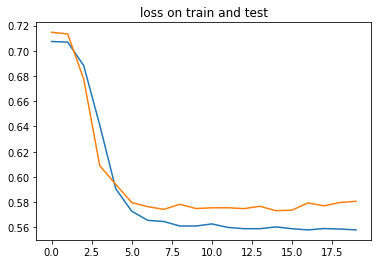

Last loss on train: 0.5579687053650881
Last loss on test: 0.5806393380227842


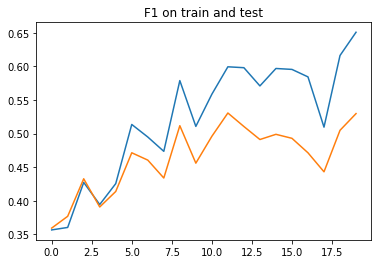

Last F1 on train: 0.6506656480837713
Last F1 on test: 0.5297098732308337


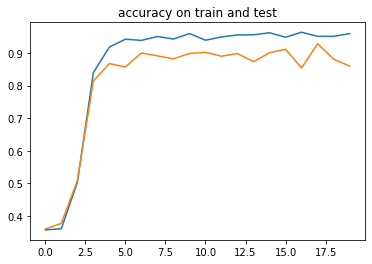

Last accuracy on train: 0.9598890429576942
Last accuracy on test: 0.8601251460219684


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.9197633381772887


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O keine-B ahnung-I .-O
keine-B ahnung-I .-O
na-B gut-I ,-O mein-O schatz-O .-O
ich-B weiß-I .-O
--O hör-B auf-I !-O
schon-B gut-I .-O
keine-B ahnung-I .-O
du-B hast-I recht-I .-O
überhaupt-B nicht-I .-O
keine-B ahnung-I .-O
ja-O ,-O na-B und-I ?-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
na-B und-I ?-O
was-B du-I nicht-I sagst-I .-O
ich-B denke-I schon-I .-O
ja-O ,-O gut-O ,-O in-B ordnung-I ,-O das-O passt-O mir-O sehr-O gut-O ,-O das-O wird-O gehen-O .-O
keine-B ahnung-I .-O
--O auf-B keinen-I fall-I .-O
na-B gut-I .-O
--O ich-B bin-I dabei-I .-O
--O ich-B auf-I jeden-I fall-I .-O
ja-O ,-O das-B stimmt-I ,-O aber-O irgendwann-O werd-O ich-O ihn-O mal-O auswechseln-O lassen-O .-O
ich-B verstehe-I .-O
ach-B so-I ,-O ja-O ...-O nein-O .-O
na-B und-I ?-O
--O hör-B auf-I .-O
--O scheiß-B drauf-I .-O
ganz-B sicher-I nicht-I .-O
--O das-B geht-I nicht-I .-O
das-B geht-I gar-I nicht-I .-O
--O ganz-B genau-I .-O
es-B geht-I nicht-I .-O
--O ganz-B und-I gar-I nicht-I .-O
also-B gut-I ,-O 

# Experiment 3.1
LSTM 10 tokens, 2 sentences

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_10_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiLSTM_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 20.10it/s]

Train loss: 0.7901206347677443


93it [00:04, 18.39it/s]

Train loss: 0.7143239703443315


138it [00:07, 19.60it/s]

Train loss: 0.6832161740020469


182it [00:09, 19.34it/s]

Train loss: 0.6669428090254466


226it [00:11, 19.28it/s]


Train loss: 0.6526171737247043

Evaluating on train...


48it [00:01, 32.66it/s]

Val loss: 0.5793105363845825, Val f1: 0.36796732081307304, Val accuracy: 0.9614979677730137


96it [00:02, 33.94it/s]

Val loss: 0.5834446430206299, Val f1: 0.37083190613322786, Val accuracy: 0.9548062331146664


140it [00:04, 32.40it/s]

Val loss: 0.5844568906006989, Val f1: 0.3724337425496843, Val accuracy: 0.9530712511804369


184it [00:05, 35.34it/s]

Val loss: 0.5837798376878103, Val f1: 0.3711593614684211, Val accuracy: 0.9459680789046817


226it [00:06, 33.43it/s]


Val loss: 0.5835363867547777, Val f1: 0.3713524350855086, Val accuracy: 0.9484553374184502

Evaluating on test...


20it [00:00, 33.87it/s]

Val loss: 0.5949784398078919, Val f1: 0.3722321351369222, Val accuracy: 0.9128651241461436


36it [00:01, 34.11it/s]

Val loss: 0.5884262919425964, Val f1: 0.37500977516174316, Val accuracy: 0.9397421648104985


48it [00:01, 33.63it/s]

Val loss: 0.5995387315750123, Val f1: 0.3733187569512261, Val accuracy: 0.9040134999487135


64it [00:01, 32.98it/s]

Val loss: 0.5981919596592585, Val f1: 0.3709564745426178, Val accuracy: 0.8999271273612977


76it [00:02, 33.83it/s]


Val loss: 0.5978763834635417, Val f1: 0.36950663685798646, Val accuracy: 0.8904705675443013

starting Epoch 1
Training...


48it [00:02, 19.47it/s]

Train loss: 0.5813614341947767


94it [00:04, 19.86it/s]

Train loss: 0.5808536032835643


138it [00:07, 18.20it/s]

Train loss: 0.5828893348022743


182it [00:09, 19.47it/s]

Train loss: 0.5802811102734672


226it [00:11, 19.26it/s]


Train loss: 0.5793304846021864

Evaluating on train...


52it [00:01, 34.48it/s]

Val loss: 0.5737678514586555, Val f1: 0.38443769415219625, Val accuracy: 0.9466522673765818


96it [00:02, 32.12it/s]

Val loss: 0.571174544095993, Val f1: 0.3863791134622362, Val accuracy: 0.9582984232240253


140it [00:04, 32.37it/s]

Val loss: 0.5700535783061275, Val f1: 0.38975579451631615, Val accuracy: 0.9631061229440901


184it [00:05, 32.87it/s]

Val loss: 0.5710966332091225, Val f1: 0.3901531575454606, Val accuracy: 0.9598954177565044


226it [00:06, 32.77it/s]


Val loss: 0.5710974150233799, Val f1: 0.38992182784610324, Val accuracy: 0.9648364774386088

Evaluating on test...


20it [00:00, 33.56it/s]

Val loss: 0.5698866446812948, Val f1: 0.3818582952022552, Val accuracy: 0.9832636992136637


36it [00:01, 32.38it/s]

Val loss: 0.5736368894577026, Val f1: 0.3824878493944804, Val accuracy: 0.955198273062706


48it [00:01, 32.14it/s]

Val loss: 0.5761635833316379, Val f1: 0.3873967276679145, Val accuracy: 0.9579766465557946


64it [00:01, 33.49it/s]

Val loss: 0.5793846448262533, Val f1: 0.3882101188103358, Val accuracy: 0.9423554862538973


76it [00:02, 32.90it/s]


Val loss: 0.5821768148740133, Val f1: 0.38670018315315247, Val accuracy: 0.9272570741176606

starting Epoch 2
Training...


47it [00:02, 19.04it/s]

Train loss: 0.5690002759297689


93it [00:04, 19.67it/s]

Train loss: 0.5695412860976325


138it [00:07, 19.69it/s]

Train loss: 0.5699197429197805


184it [00:09, 20.04it/s]

Train loss: 0.5688764585389031


226it [00:11, 19.51it/s]


Train loss: 0.5674143735567728

Evaluating on train...


52it [00:01, 33.93it/s]

Val loss: 0.560438350836436, Val f1: 0.548353295856052, Val accuracy: 0.9661315851741367


96it [00:02, 33.71it/s]

Val loss: 0.5631013929843902, Val f1: 0.5381826817989349, Val accuracy: 0.952531901995341


140it [00:04, 33.42it/s]

Val loss: 0.5634254177411397, Val f1: 0.5290879635899155, Val accuracy: 0.9460148111537651


184it [00:05, 32.71it/s]

Val loss: 0.5637985262605879, Val f1: 0.5302362240023083, Val accuracy: 0.9401573106646538


226it [00:06, 32.83it/s]


Val loss: 0.563209224012163, Val f1: 0.5307947760158115, Val accuracy: 0.946523214313719

Evaluating on test...


19it [00:00, 32.32it/s]

Val loss: 0.5759114027023315, Val f1: 0.5250327924887339, Val accuracy: 0.9144879659016927


35it [00:01, 32.39it/s]

Val loss: 0.58733877936999, Val f1: 0.5256126364072163, Val accuracy: 0.9105963031450908


51it [00:01, 32.65it/s]

Val loss: 0.5840809994273716, Val f1: 0.5087545845243666, Val accuracy: 0.8914677222569783


63it [00:01, 32.75it/s]

Val loss: 0.5868794937928518, Val f1: 0.5055674180388451, Val accuracy: 0.8851340572039287


76it [00:02, 32.25it/s]


Val loss: 0.5858791542053222, Val f1: 0.5023693446318308, Val accuracy: 0.8875341335932414

starting Epoch 3
Training...


47it [00:02, 19.99it/s]

Train loss: 0.5609678692287869


91it [00:04, 20.50it/s]

Train loss: 0.5632549696498447


137it [00:06, 20.52it/s]

Train loss: 0.563042610221439


184it [00:09, 19.55it/s]

Train loss: 0.5644956853654649


226it [00:11, 19.57it/s]


Train loss: 0.5648968132336935

Evaluating on train...


52it [00:01, 34.94it/s]

Val loss: 0.5596258150206672, Val f1: 0.48846116330888534, Val accuracy: 0.9767746342553033


96it [00:02, 32.21it/s]

Val loss: 0.5617940107981364, Val f1: 0.4807624323500527, Val accuracy: 0.9651840272876951


140it [00:04, 32.89it/s]

Val loss: 0.5625075044455352, Val f1: 0.48477607060361794, Val accuracy: 0.9608181381667101


184it [00:05, 31.73it/s]

Val loss: 0.5617936730384827, Val f1: 0.48080358157555264, Val accuracy: 0.9539704182081752


226it [00:06, 33.13it/s]


Val loss: 0.5616759316126505, Val f1: 0.48221131496959263, Val accuracy: 0.9461645363436805

Evaluating on test...


20it [00:00, 32.66it/s]

Val loss: 0.6029035369555156, Val f1: 0.48170706431070964, Val accuracy: 0.8981243213017781


36it [00:01, 31.58it/s]

Val loss: 0.5975412487983703, Val f1: 0.46369237303733823, Val accuracy: 0.9134311238924663


48it [00:01, 31.94it/s]

Val loss: 0.5941005720032586, Val f1: 0.4593802061345842, Val accuracy: 0.9235641015900506


64it [00:01, 32.30it/s]

Val loss: 0.5863013386726379, Val f1: 0.46090537707010903, Val accuracy: 0.9309267650047938


76it [00:02, 32.12it/s]


Val loss: 0.5873130901654562, Val f1: 0.46172316392262774, Val accuracy: 0.9298749184608459

starting Epoch 4
Training...


49it [00:02, 20.11it/s]

Train loss: 0.5653565896881951


92it [00:04, 17.66it/s]

Train loss: 0.563133156961865


137it [00:06, 17.93it/s]

Train loss: 0.5617933613282663


184it [00:09, 18.44it/s]

Train loss: 0.5614603218105104


226it [00:11, 19.31it/s]


Train loss: 0.5617801464928521

Evaluating on train...


48it [00:01, 33.97it/s]

Val loss: 0.5580966181225246, Val f1: 0.4819944991005792, Val accuracy: 0.9782932586140103


96it [00:02, 33.95it/s]

Val loss: 0.5625427093770768, Val f1: 0.4727063500218921, Val accuracy: 0.9701614369948705


140it [00:04, 30.80it/s]

Val loss: 0.5612447394265069, Val f1: 0.4731282578574287, Val accuracy: 0.9735993601657726


184it [00:05, 32.47it/s]

Val loss: 0.5600969821214676, Val f1: 0.46877158996131685, Val accuracy: 0.9647647382484542


226it [00:06, 33.00it/s]


Val loss: 0.5601667801539103, Val f1: 0.4651602677504222, Val accuracy: 0.9669248538547092

Evaluating on test...


20it [00:00, 31.35it/s]

Val loss: 0.5939279556274414, Val f1: 0.4230838100115458, Val accuracy: 0.8894259889920553


36it [00:01, 31.51it/s]

Val loss: 0.5802137811978658, Val f1: 0.43010496695836387, Val accuracy: 0.9367085874080658


48it [00:01, 32.01it/s]

Val loss: 0.5834214528401692, Val f1: 0.4340843571556939, Val accuracy: 0.9235398358768887


64it [00:02, 31.60it/s]

Val loss: 0.5816804558038712, Val f1: 0.43759046246608096, Val accuracy: 0.9266276677449544


76it [00:02, 31.34it/s]


Val loss: 0.5802033535639445, Val f1: 0.4378175417582194, Val accuracy: 0.9276275177796681

starting Epoch 5
Training...


49it [00:02, 20.66it/s]

Train loss: 0.5577108952734205


92it [00:04, 20.53it/s]

Train loss: 0.5588873128096262


137it [00:07, 18.55it/s]

Train loss: 0.5584934724701776


182it [00:09, 18.55it/s]

Train loss: 0.5577868858973185


226it [00:11, 19.37it/s]


Train loss: 0.5605313197771709

Evaluating on train...


52it [00:01, 35.56it/s]

Val loss: 0.5671322451697456, Val f1: 0.48226363791359794, Val accuracy: 0.9654247449504004


96it [00:02, 32.20it/s]

Val loss: 0.5622956832249959, Val f1: 0.4749542444944382, Val accuracy: 0.9661531895399094


140it [00:04, 31.61it/s]

Val loss: 0.5613436509061742, Val f1: 0.48181270360946654, Val accuracy: 0.9748426293885266


184it [00:05, 33.58it/s]

Val loss: 0.5605862316158082, Val f1: 0.47847981949647267, Val accuracy: 0.975442344446977


226it [00:06, 33.09it/s]


Val loss: 0.5615309781498379, Val f1: 0.4772329131762187, Val accuracy: 0.972625132534239

Evaluating on test...


20it [00:00, 31.98it/s]

Val loss: 0.5747060934702556, Val f1: 0.4611562490463257, Val accuracy: 0.9623400926589966


36it [00:01, 31.27it/s]

Val loss: 0.5756542921066284, Val f1: 0.4497960418462753, Val accuracy: 0.9649878819783528


48it [00:01, 31.65it/s]

Val loss: 0.5756946391529507, Val f1: 0.4459506611029307, Val accuracy: 0.9502709130446116


64it [00:02, 31.06it/s]

Val loss: 0.5801723529895146, Val f1: 0.4450941468278567, Val accuracy: 0.9400269155701001


76it [00:02, 31.90it/s]


Val loss: 0.5810957638422648, Val f1: 0.44131355206171674, Val accuracy: 0.9411788849035899

starting Epoch 6
Training...


47it [00:02, 20.03it/s]

Train loss: 0.555195054743025


92it [00:04, 18.62it/s]

Train loss: 0.5589000556204055


137it [00:07, 18.23it/s]

Train loss: 0.5612914994910911


184it [00:09, 17.96it/s]

Train loss: 0.5606206569406721


226it [00:11, 19.28it/s]


Train loss: 0.5600350941552056

Evaluating on train...


51it [00:01, 34.96it/s]

Val loss: 0.555750204457177, Val f1: 0.5762415826320648, Val accuracy: 0.9648158291975657


95it [00:02, 32.13it/s]

Val loss: 0.5554334587521024, Val f1: 0.5590205944246716, Val accuracy: 0.9292620807886124


139it [00:04, 31.06it/s]

Val loss: 0.5570811708768209, Val f1: 0.5589147128440716, Val accuracy: 0.9386084183498665


183it [00:05, 31.76it/s]

Val loss: 0.5571494109100765, Val f1: 0.5589307023419274, Val accuracy: 0.941032398906019


226it [00:06, 32.44it/s]


Val loss: 0.5589229896333483, Val f1: 0.5604107133547465, Val accuracy: 0.9439942197004954

Evaluating on test...


20it [00:00, 31.89it/s]

Val loss: 0.589765461285909, Val f1: 0.503752472003301, Val accuracy: 0.8914716482162476


36it [00:01, 31.83it/s]

Val loss: 0.5798510372638702, Val f1: 0.5093670020500819, Val accuracy: 0.9097304344177246


48it [00:01, 31.82it/s]

Val loss: 0.5879644486639235, Val f1: 0.5059649116463132, Val accuracy: 0.9102600693702698


66it [00:02, 19.82it/s]

Val loss: 0.5839710901180903, Val f1: 0.5095660636822382, Val accuracy: 0.9252356926600138


76it [00:03, 24.83it/s]


Val loss: 0.5865754842758178, Val f1: 0.5094963149229685, Val accuracy: 0.9064857864379883

starting Epoch 7
Training...


48it [00:02, 19.03it/s]

Train loss: 0.5603270226054722


92it [00:04, 19.71it/s]

Train loss: 0.5604177110724979


136it [00:07, 19.99it/s]

Train loss: 0.5595924501065854


182it [00:09, 18.89it/s]

Train loss: 0.5590557565291723


226it [00:11, 19.29it/s]


Train loss: 0.5590395720799765

Evaluating on train...


52it [00:01, 34.93it/s]

Val loss: 0.5591644419564141, Val f1: 0.5839420941140917, Val accuracy: 0.97522674202919


96it [00:02, 33.35it/s]

Val loss: 0.5573597451051077, Val f1: 0.5838180349932777, Val accuracy: 0.9630480256345537


140it [00:04, 31.82it/s]

Val loss: 0.5577403192166929, Val f1: 0.5892768226287983, Val accuracy: 0.9608083058286596


184it [00:05, 32.68it/s]

Val loss: 0.5573878410789702, Val f1: 0.5955364995532566, Val accuracy: 0.9654885672860676


226it [00:06, 32.59it/s]


Val loss: 0.5578542465633817, Val f1: 0.5982409097088708, Val accuracy: 0.9614100386036767

Evaluating on test...


20it [00:00, 32.97it/s]

Val loss: 0.5901011149088542, Val f1: 0.523730339606603, Val accuracy: 0.9276732405026754


36it [00:01, 33.06it/s]

Val loss: 0.5933611313501994, Val f1: 0.520827230811119, Val accuracy: 0.9084425081809362


48it [00:01, 32.36it/s]

Val loss: 0.5887580355008443, Val f1: 0.5197731892267863, Val accuracy: 0.923008261124293


64it [00:01, 31.97it/s]

Val loss: 0.5870530376831691, Val f1: 0.5246524135271708, Val accuracy: 0.9302182997266452


76it [00:02, 32.96it/s]


Val loss: 0.5873535919189453, Val f1: 0.523482035001119, Val accuracy: 0.9322510087490081

starting Epoch 8
Training...


49it [00:02, 20.67it/s]

Train loss: 0.5547036674287584


93it [00:04, 20.19it/s]

Train loss: 0.5561552849080827


137it [00:07, 18.38it/s]

Train loss: 0.5561541239420573


184it [00:09, 18.51it/s]

Train loss: 0.5579895704984665


226it [00:11, 19.22it/s]


Train loss: 0.5598088396920098

Evaluating on train...


52it [00:01, 33.58it/s]

Val loss: 0.5578230685657926, Val f1: 0.5767869730790456, Val accuracy: 0.9431749939918518


96it [00:02, 32.59it/s]

Val loss: 0.5600701292355855, Val f1: 0.5740679542223612, Val accuracy: 0.9647889143890804


140it [00:04, 31.96it/s]

Val loss: 0.5589752210511102, Val f1: 0.5676017302053946, Val accuracy: 0.9597728980912102


184it [00:05, 32.53it/s]

Val loss: 0.5584807472096549, Val f1: 0.5700465763608614, Val accuracy: 0.9641859895653195


226it [00:06, 32.64it/s]


Val loss: 0.5575746660762363, Val f1: 0.5674388480186462, Val accuracy: 0.9651909686459436

Evaluating on test...


19it [00:00, 32.77it/s]

Val loss: 0.5964598178863525, Val f1: 0.4966232379277547, Val accuracy: 0.9047154188156128


35it [00:01, 33.44it/s]

Val loss: 0.5922905186812083, Val f1: 0.48564268747965494, Val accuracy: 0.8961042255163193


51it [00:01, 32.79it/s]

Val loss: 0.5822293758392334, Val f1: 0.4915463182661268, Val accuracy: 0.9212791555457644


63it [00:01, 32.04it/s]

Val loss: 0.5878648618857066, Val f1: 0.49249994307756423, Val accuracy: 0.9087906102339427


76it [00:02, 32.79it/s]


Val loss: 0.5874940570195516, Val f1: 0.4942910023530324, Val accuracy: 0.9135199213027954

starting Epoch 9
Training...


47it [00:02, 20.15it/s]

Train loss: 0.5626844922701518


92it [00:04, 18.56it/s]

Train loss: 0.558967924118042


138it [00:07, 18.58it/s]

Train loss: 0.5580380934256094


182it [00:09, 18.59it/s]

Train loss: 0.557454608546363


226it [00:11, 19.28it/s]


Train loss: 0.5580267408159044

Evaluating on train...


48it [00:01, 34.44it/s]

Val loss: 0.5582463635338677, Val f1: 0.5468434744411045, Val accuracy: 0.963704197274314


96it [00:02, 32.80it/s]

Val loss: 0.5560654587215847, Val f1: 0.5573413199848599, Val accuracy: 0.9738630791505177


140it [00:04, 33.76it/s]

Val loss: 0.5580524210576658, Val f1: 0.5609019323631569, Val accuracy: 0.9721827745437622


184it [00:05, 32.89it/s]

Val loss: 0.5579284121592839, Val f1: 0.5582465946674346, Val accuracy: 0.969627568953567


226it [00:06, 33.22it/s]


Val loss: 0.5573733994695875, Val f1: 0.5591761370499929, Val accuracy: 0.9690411612722609

Evaluating on test...


19it [00:00, 32.95it/s]

Val loss: 0.5928176919619242, Val f1: 0.5094889024893443, Val accuracy: 0.8505250493685405


35it [00:01, 31.08it/s]

Val loss: 0.5822656313578288, Val f1: 0.49154274761676786, Val accuracy: 0.8900139570236206


51it [00:01, 32.26it/s]

Val loss: 0.5759785652160645, Val f1: 0.488881250222524, Val accuracy: 0.922917471991645


63it [00:01, 31.27it/s]

Val loss: 0.5835593571265538, Val f1: 0.47885882953802744, Val accuracy: 0.9060679907600085


76it [00:02, 31.65it/s]


Val loss: 0.5841401354471842, Val f1: 0.4845004304250081, Val accuracy: 0.903824260632197

starting Epoch 10
Training...


49it [00:02, 20.55it/s]

Train loss: 0.5580182181464302


93it [00:04, 19.75it/s]

Train loss: 0.5586754050519731


138it [00:07, 19.21it/s]

Train loss: 0.5589279603075098


181it [00:09, 17.77it/s]

Train loss: 0.5587595538960562


226it [00:11, 19.15it/s]


Train loss: 0.5592981786198086

Evaluating on train...


48it [00:01, 34.83it/s]

Val loss: 0.5564041296641032, Val f1: 0.5878845943344964, Val accuracy: 0.9791984770033094


96it [00:02, 32.23it/s]

Val loss: 0.5575718349880643, Val f1: 0.5769877367549472, Val accuracy: 0.984823985894521


140it [00:04, 32.41it/s]

Val loss: 0.5586951304365088, Val f1: 0.5792848604696769, Val accuracy: 0.97980314956771


184it [00:05, 31.94it/s]

Val loss: 0.557637494471338, Val f1: 0.5827381925450431, Val accuracy: 0.972915561331643


226it [00:06, 32.60it/s]


Val loss: 0.5572516661220127, Val f1: 0.5834729939036899, Val accuracy: 0.9716223465071784

Evaluating on test...


19it [00:00, 32.39it/s]

Val loss: 0.5922420620918274, Val f1: 0.5119597315788269, Val accuracy: 0.9082719107468923


35it [00:01, 33.80it/s]

Val loss: 0.586285271247228, Val f1: 0.5051127284765243, Val accuracy: 0.9286498675743738


51it [00:01, 33.53it/s]

Val loss: 0.5836946354971991, Val f1: 0.5040179815557267, Val accuracy: 0.9357862359947628


63it [00:01, 32.82it/s]

Val loss: 0.5837752491235733, Val f1: 0.5030580336848894, Val accuracy: 0.9356175765395165


76it [00:02, 32.63it/s]


Val loss: 0.5838575959205627, Val f1: 0.4988705551624298, Val accuracy: 0.9224865881601969

starting Epoch 11
Training...


49it [00:02, 20.80it/s]

Train loss: 0.556418263912201


93it [00:04, 19.48it/s]

Train loss: 0.5560589035352071


138it [00:07, 19.52it/s]

Train loss: 0.5587599206853796


183it [00:09, 19.86it/s]

Train loss: 0.5597396320766873


226it [00:11, 19.22it/s]


Train loss: 0.5586128460036384

Evaluating on train...


52it [00:01, 34.06it/s]

Val loss: 0.5549280166625976, Val f1: 0.6602599898974101, Val accuracy: 0.9797054330507914


96it [00:02, 32.89it/s]

Val loss: 0.5572363999154832, Val f1: 0.6417196641365687, Val accuracy: 0.9629023028744592


140it [00:04, 32.48it/s]

Val loss: 0.5592864248487684, Val f1: 0.6294763130170328, Val accuracy: 0.9606620124092808


184it [00:05, 32.39it/s]

Val loss: 0.5588536587026384, Val f1: 0.6351814208759202, Val accuracy: 0.9639464567104975


226it [00:06, 32.43it/s]


Val loss: 0.5580089553197225, Val f1: 0.6291046229998271, Val accuracy: 0.9635966446664598

Evaluating on test...


20it [00:00, 30.48it/s]

Val loss: 0.5928217053413392, Val f1: 0.564861285686493, Val accuracy: 0.9402316371599834


36it [00:01, 31.11it/s]

Val loss: 0.6003500282764435, Val f1: 0.5334084242582321, Val accuracy: 0.8651670972506206


48it [00:01, 30.59it/s]

Val loss: 0.5996364156405131, Val f1: 0.5521877785523732, Val accuracy: 0.8877096825175815


64it [00:02, 32.03it/s]

Val loss: 0.5946041136980057, Val f1: 0.5475313827395439, Val accuracy: 0.8919518291950226


76it [00:02, 31.07it/s]


Val loss: 0.5934450348218282, Val f1: 0.5402760557333628, Val accuracy: 0.8976500391960144

starting Epoch 12
Training...


47it [00:02, 18.66it/s]

Train loss: 0.5533167719841003


94it [00:04, 20.57it/s]

Train loss: 0.5550757765769958


137it [00:07, 18.10it/s]

Train loss: 0.5559653489677995


182it [00:09, 19.10it/s]

Train loss: 0.556141687101788


226it [00:11, 19.12it/s]


Train loss: 0.556446475452847

Evaluating on train...


48it [00:01, 34.70it/s]

Val loss: 0.5578316066000196, Val f1: 0.6154941823747423, Val accuracy: 0.917203504509396


96it [00:02, 33.53it/s]

Val loss: 0.5559281759791904, Val f1: 0.6339041885402468, Val accuracy: 0.9575103567706214


140it [00:04, 32.06it/s]

Val loss: 0.5566988675682633, Val f1: 0.6301335986013765, Val accuracy: 0.9489747104821382


184it [00:05, 31.84it/s]

Val loss: 0.5569732778602177, Val f1: 0.6328806704945035, Val accuracy: 0.958720533715354


226it [00:06, 32.48it/s]


Val loss: 0.5565484730402629, Val f1: 0.6376128792762756, Val accuracy: 0.9603330360518562

Evaluating on test...


20it [00:00, 32.45it/s]

Val loss: 0.5786364595095317, Val f1: 0.5259007175763448, Val accuracy: 0.9052825848261515


36it [00:01, 33.43it/s]

Val loss: 0.5862074792385101, Val f1: 0.5138300428787868, Val accuracy: 0.9164800743261973


48it [00:01, 33.73it/s]

Val loss: 0.5862378345595466, Val f1: 0.5187259627713098, Val accuracy: 0.9262536777390374


64it [00:01, 31.91it/s]

Val loss: 0.5828374286492666, Val f1: 0.5269209330280622, Val accuracy: 0.9307674989104271


76it [00:02, 32.84it/s]


Val loss: 0.5849235757191976, Val f1: 0.5320075615247091, Val accuracy: 0.9330374578634898

starting Epoch 13
Training...


49it [00:02, 19.65it/s]

Train loss: 0.5546014481120639


93it [00:05, 18.14it/s]

Train loss: 0.5565225137604608


139it [00:07, 20.44it/s]

Train loss: 0.5562432805697123


183it [00:09, 19.90it/s]

Train loss: 0.5582522518104978


226it [00:11, 19.21it/s]


Train loss: 0.5582835637198554

Evaluating on train...


48it [00:01, 33.57it/s]

Val loss: 0.5624079598320855, Val f1: 0.6254293355676863, Val accuracy: 0.9215067028999329


93it [00:03, 29.09it/s]

Val loss: 0.5608445829815335, Val f1: 0.6270180311467912, Val accuracy: 0.9547317134009468


140it [00:04, 31.89it/s]

Val loss: 0.558422260372727, Val f1: 0.6180225162594407, Val accuracy: 0.9492157675601818


184it [00:06, 31.42it/s]

Val loss: 0.557649638917711, Val f1: 0.6195175947414504, Val accuracy: 0.945944657921791


226it [00:07, 29.56it/s]


Val loss: 0.5569996749030219, Val f1: 0.6231531220012241, Val accuracy: 0.9503139942222172

Evaluating on test...


20it [00:00, 31.80it/s]

Val loss: 0.5784932971000671, Val f1: 0.47524802486101786, Val accuracy: 0.811906486749649


36it [00:01, 31.50it/s]

Val loss: 0.5852546135584513, Val f1: 0.5140592406193415, Val accuracy: 0.8524230947097142


48it [00:01, 31.39it/s]

Val loss: 0.5974691496955024, Val f1: 0.5101188328531053, Val accuracy: 0.848372397157881


64it [00:02, 31.39it/s]

Val loss: 0.5912959625323614, Val f1: 0.524640166759491, Val accuracy: 0.8755959083636602


76it [00:02, 31.56it/s]


Val loss: 0.5883509651819865, Val f1: 0.5304717791080474, Val accuracy: 0.8839186092217763

starting Epoch 14
Training...


47it [00:02, 19.87it/s]

Train loss: 0.5558268467585246


94it [00:04, 20.11it/s]

Train loss: 0.5567561937703027


138it [00:07, 18.39it/s]

Train loss: 0.558797272487923


183it [00:09, 18.30it/s]

Train loss: 0.5588437918159697


226it [00:11, 19.09it/s]


Train loss: 0.558746702141232

Evaluating on train...


52it [00:01, 33.92it/s]

Val loss: 0.5565763235092163, Val f1: 0.6111209173997243, Val accuracy: 0.9001481082704332


96it [00:02, 31.40it/s]

Val loss: 0.5546453674634297, Val f1: 0.6214675711260902, Val accuracy: 0.9201468547185262


140it [00:04, 33.41it/s]

Val loss: 0.554854174455007, Val f1: 0.6374737989019464, Val accuracy: 0.9406281228418704


184it [00:05, 31.02it/s]

Val loss: 0.5560017897023095, Val f1: 0.6361967484156291, Val accuracy: 0.9364852352274788


226it [00:07, 32.28it/s]


Val loss: 0.5567675783899095, Val f1: 0.6382859032683902, Val accuracy: 0.9425688833660549

Evaluating on test...


20it [00:00, 32.83it/s]

Val loss: 0.5708209236462911, Val f1: 0.5419059971968333, Val accuracy: 0.9327384193738302


36it [00:01, 31.36it/s]

Val loss: 0.5788971602916717, Val f1: 0.5387758801380793, Val accuracy: 0.9193327019611994


48it [00:01, 31.25it/s]

Val loss: 0.589151856634352, Val f1: 0.5353591276539696, Val accuracy: 0.9138370388083987


64it [00:02, 32.40it/s]

Val loss: 0.5877439548571904, Val f1: 0.5268173625071844, Val accuracy: 0.9000373924771945


76it [00:02, 31.83it/s]


Val loss: 0.5888369242350261, Val f1: 0.5249215531349182, Val accuracy: 0.8982472745577494

starting Epoch 15
Training...


49it [00:02, 20.65it/s]

Train loss: 0.5540949900945028


93it [00:04, 18.93it/s]

Train loss: 0.5535256167252859


137it [00:07, 18.95it/s]

Train loss: 0.5545778888243216


182it [00:09, 19.15it/s]

Train loss: 0.5542383399274614


226it [00:11, 19.20it/s]


Train loss: 0.5568811901410421

Evaluating on train...


48it [00:01, 34.10it/s]

Val loss: 0.558026275369856, Val f1: 0.6617332716782888, Val accuracy: 0.9614030381043752


96it [00:02, 32.81it/s]

Val loss: 0.5587308996253544, Val f1: 0.6724525229798423, Val accuracy: 0.9589685728152593


140it [00:04, 31.71it/s]

Val loss: 0.5572293316876447, Val f1: 0.6825777577029334, Val accuracy: 0.964460426568985


184it [00:05, 32.00it/s]

Val loss: 0.5573039362827937, Val f1: 0.6864846815665563, Val accuracy: 0.9664339404967096


226it [00:06, 32.35it/s]


Val loss: 0.5569237836201986, Val f1: 0.6851432274447548, Val accuracy: 0.9662363603379991

Evaluating on test...


19it [00:00, 31.41it/s]

Val loss: 0.5867837309837342, Val f1: 0.5866431613763173, Val accuracy: 0.9433020194371541


35it [00:01, 32.15it/s]

Val loss: 0.5879025955994924, Val f1: 0.5742999325195949, Val accuracy: 0.9340103248755137


51it [00:01, 31.81it/s]

Val loss: 0.5960453881157769, Val f1: 0.5647654169135623, Val accuracy: 0.9006401022275289


63it [00:01, 31.40it/s]

Val loss: 0.5957574009895324, Val f1: 0.5693145021796227, Val accuracy: 0.9009910494089126


76it [00:02, 31.87it/s]


Val loss: 0.5948280580838521, Val f1: 0.5582139094670614, Val accuracy: 0.9021252624193827

starting Epoch 16
Training...


48it [00:02, 17.94it/s]

Train loss: 0.5559571994675531


92it [00:04, 19.49it/s]

Train loss: 0.5554371807310317


139it [00:07, 20.38it/s]

Train loss: 0.5585520810551113


183it [00:09, 20.60it/s]

Train loss: 0.5582363151841694


226it [00:11, 19.12it/s]


Train loss: 0.557946978410085

Evaluating on train...


52it [00:01, 33.87it/s]

Val loss: 0.5635956750975715, Val f1: 0.6183308223883311, Val accuracy: 0.9464350150691139


96it [00:02, 32.60it/s]

Val loss: 0.5622917724980249, Val f1: 0.6145900342199537, Val accuracy: 0.9601606435245937


140it [00:04, 32.13it/s]

Val loss: 0.5601500979176274, Val f1: 0.6159676377420072, Val accuracy: 0.9620773732662201


184it [00:05, 31.28it/s]

Val loss: 0.5586072004503674, Val f1: 0.6172478972209825, Val accuracy: 0.9525405622190899


226it [00:07, 32.06it/s]


Val loss: 0.5578458407190111, Val f1: 0.6186528828408983, Val accuracy: 0.9552555984920925

Evaluating on test...


19it [00:00, 30.52it/s]

Val loss: 0.5927284677823385, Val f1: 0.4806196848551432, Val accuracy: 0.9247382720311482


35it [00:01, 31.72it/s]

Val loss: 0.575579172372818, Val f1: 0.4928207784891129, Val accuracy: 0.9343065102895101


47it [00:01, 30.71it/s]

Val loss: 0.575586301750607, Val f1: 0.4853330784373813, Val accuracy: 0.941256230407291


66it [00:02, 29.14it/s]

Val loss: 0.5861175209283829, Val f1: 0.4998076826334, Val accuracy: 0.9311672498782476


76it [00:02, 30.49it/s]


Val loss: 0.5855676945050557, Val f1: 0.5027964337666829, Val accuracy: 0.9321632210413615

starting Epoch 17
Training...


48it [00:02, 18.88it/s]

Train loss: 0.5638888306087918


91it [00:04, 17.87it/s]

Train loss: 0.5593339045842488


137it [00:07, 18.97it/s]

Train loss: 0.5577387690544129


183it [00:09, 20.41it/s]

Train loss: 0.5582330051395629


226it [00:11, 19.19it/s]


Train loss: 0.558102412223816

Evaluating on train...


48it [00:01, 33.60it/s]

Val loss: 0.5564126412073771, Val f1: 0.6483644849724239, Val accuracy: 0.9620790759722392


96it [00:02, 32.69it/s]

Val loss: 0.5580719298786587, Val f1: 0.6493151320351495, Val accuracy: 0.9459794915384716


140it [00:04, 32.28it/s]

Val loss: 0.5572699414359199, Val f1: 0.6456644636613351, Val accuracy: 0.947132905986574


184it [00:05, 30.32it/s]

Val loss: 0.5569836603270637, Val f1: 0.6482334370414417, Val accuracy: 0.954776498509778


226it [00:07, 31.53it/s]


Val loss: 0.5572696412934197, Val f1: 0.6544845015472835, Val accuracy: 0.9502924776077271

Evaluating on test...


19it [00:00, 31.56it/s]

Val loss: 0.5681817173957825, Val f1: 0.5506488025188446, Val accuracy: 0.9762415806452434


35it [00:01, 31.04it/s]

Val loss: 0.5867748081684112, Val f1: 0.5436726699272791, Val accuracy: 0.9298997928698858


51it [00:01, 30.18it/s]

Val loss: 0.5830431779225668, Val f1: 0.5423987613783943, Val accuracy: 0.9409368786546919


63it [00:02, 30.43it/s]

Val loss: 0.5925439019997915, Val f1: 0.5267681544025739, Val accuracy: 0.9029904132088026


76it [00:02, 30.58it/s]


Val loss: 0.5938695391019185, Val f1: 0.5184341001510621, Val accuracy: 0.8866931196053823

starting Epoch 18
Training...


46it [00:02, 18.03it/s]

Train loss: 0.5553219225671556


92it [00:04, 18.45it/s]

Train loss: 0.5573306017451816


138it [00:07, 19.76it/s]

Train loss: 0.5580383389084428


182it [00:09, 20.22it/s]

Train loss: 0.5583376838101282


226it [00:11, 19.11it/s]


Train loss: 0.5572793043984308

Evaluating on train...


52it [00:01, 34.53it/s]

Val loss: 0.5527477569050259, Val f1: 0.6648920145299699, Val accuracy: 0.9697654975785149


96it [00:02, 32.22it/s]

Val loss: 0.555425226688385, Val f1: 0.6783217440048853, Val accuracy: 0.9645818124214808


140it [00:04, 31.26it/s]

Val loss: 0.5558920016995182, Val f1: 0.687320735057195, Val accuracy: 0.9638813544202733


184it [00:05, 30.97it/s]

Val loss: 0.5567466884851455, Val f1: 0.684814194507069, Val accuracy: 0.9630225592189365


226it [00:07, 32.24it/s]


Val loss: 0.5568660754627651, Val f1: 0.6764589444796244, Val accuracy: 0.9611819701724582

Evaluating on test...


18it [00:00, 31.74it/s]

Val loss: 0.5838034987449646, Val f1: 0.49916316866874694, Val accuracy: 0.9440794507662456


34it [00:01, 31.27it/s]

Val loss: 0.589390081167221, Val f1: 0.5328826248645783, Val accuracy: 0.9152690450350444


50it [00:01, 30.86it/s]

Val loss: 0.5872704360220168, Val f1: 0.541112196445465, Val accuracy: 0.9089079055521223


65it [00:02, 28.75it/s]

Val loss: 0.5876818527777989, Val f1: 0.5508300110697746, Val accuracy: 0.9095511580506961


76it [00:02, 30.36it/s]


Val loss: 0.5903103399276733, Val f1: 0.5432322363058726, Val accuracy: 0.8999149640401204

starting Epoch 19
Training...


47it [00:02, 19.06it/s]

Train loss: 0.5555148641268413


92it [00:04, 19.10it/s]

Train loss: 0.5542824851142035


139it [00:07, 18.49it/s]

Train loss: 0.5560819855442753


181it [00:09, 18.57it/s]

Train loss: 0.5566095501184464


226it [00:11, 18.93it/s]


Train loss: 0.5569206166267395

Evaluating on train...


48it [00:01, 32.65it/s]

Val loss: 0.5536680565940009, Val f1: 0.6839979509512584, Val accuracy: 0.9680263890160454


96it [00:02, 32.66it/s]

Val loss: 0.5531052099333869, Val f1: 0.6877641078498629, Val accuracy: 0.9837568336062961


140it [00:04, 31.30it/s]

Val loss: 0.5547773034484298, Val f1: 0.6897026406394111, Val accuracy: 0.9811032321718004


184it [00:05, 32.22it/s]

Val loss: 0.5554647690720028, Val f1: 0.6891407354010476, Val accuracy: 0.9759241324332025


226it [00:06, 32.35it/s]


Val loss: 0.5563411058319939, Val f1: 0.6844388008117676, Val accuracy: 0.978347105052736

Evaluating on test...


20it [00:00, 33.03it/s]

Val loss: 0.5948207338651021, Val f1: 0.5515277326107025, Val accuracy: 0.8845110754172008


36it [00:01, 32.67it/s]

Val loss: 0.5916463176409403, Val f1: 0.5645060877005259, Val accuracy: 0.9026847044626872


48it [00:01, 31.49it/s]

Val loss: 0.5945745706558228, Val f1: 0.5550685326258341, Val accuracy: 0.9025013632244534


64it [00:01, 31.94it/s]

Val loss: 0.5934605012337367, Val f1: 0.554215298096339, Val accuracy: 0.9080486764510473


76it [00:02, 32.29it/s]

Val loss: 0.5909937842686971, Val f1: 0.5476541392008464, Val accuracy: 0.9138842725753784


## Graphics

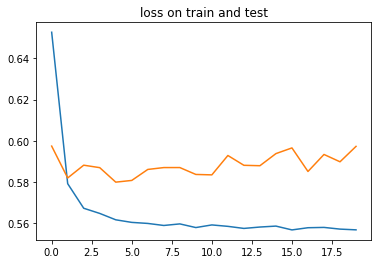

Last loss on train: 0.5569005993615209
Last loss on test: 0.5973215620768698


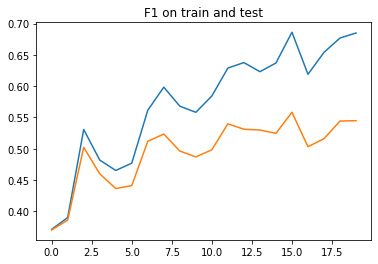

Last F1 on train: 0.6848407648833452
Last F1 on test: 0.5448120887342253


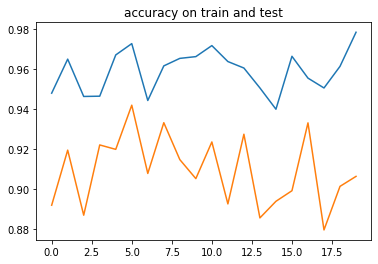

Last accuracy on train: 0.9784387177334423
Last accuracy on test: 0.9062118255778363


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.9338800083039236


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

du-B hast-I recht-I .-O
hör-B auf-I !-O
ich-B verstehe-I .-O
ja-O ,-O na-B und-I ?-O
warum-B nicht-I ?-O
was-B sie-I nicht-I sagen-I .-O
keine-B ahnung-I .-O
--O nicht-B wahr-I ?-O
--O in-B der-I tat-I !-O
das-B stimmt-I .-O
keine-B ahnung-I .-O
--O na-B klar-I .-O
du-B hast-I recht-I .-O
ist-B schon-I gut-I .-O
--O schon-B gut-I .-O
--O in-B ordnung-I .-O
es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
das-B stimmt-I nicht-I ,-O auch-O wenn-O ich-O nur-O die-O untere-O hälfte-O gesehen-O habe-O .-O
nein-O ,-O es-B geht-I nicht-I .-O
was-B soll-I das-I ?-O
--O das-B geht-I nicht-I .-O
--O ich-B weiß-I .-O
--O keine-B ahnung-I .-O
ist-B schon-I gut-I .-O
schon-B gut-I .-O
--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
--O ich-B bin-I dabei-I .-O
phoebe-O ...-O --O ja-O ,-O ich-B bin-I draußen-I .-O
auf-B keinen-I fall-I .-O
keine-B ahnung-I ,-O aber-O ein-O paar-O tage-O bestimmt-O noch-O .-O
--O ach-B ja-I ?-O
--O ach-B ja-I ?-O
--O keine-B ahnung-I .-O
--O ganz-B

# Experiment 3.2
LSTM 0 tokens, 1 sentence

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_1_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiLSTM_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:02, 23.70it/s]

Train loss: 0.8480479452345107


94it [00:04, 22.51it/s]

Train loss: 0.8235292063819037


139it [00:06, 21.31it/s]

Train loss: 0.7649652966746577


184it [00:08, 22.50it/s]

Train loss: 0.7274826616048813


226it [00:09, 22.68it/s]


Train loss: 0.7042260016335381

Evaluating on train...


53it [00:01, 40.41it/s]

Val loss: 0.5876646333270603, Val f1: 0.3765066517723931, Val accuracy: 0.9248042106628418


96it [00:02, 39.29it/s]

Val loss: 0.5835601607958476, Val f1: 0.3791951600048277, Val accuracy: 0.9484688851568434


140it [00:03, 36.30it/s]

Val loss: 0.5829130358166165, Val f1: 0.3769904474417369, Val accuracy: 0.9352447101363429


184it [00:04, 38.53it/s]

Val loss: 0.5848691989978154, Val f1: 0.37674631410174897, Val accuracy: 0.9275622937414382


226it [00:05, 37.79it/s]


Val loss: 0.5848564804924858, Val f1: 0.3770402987798055, Val accuracy: 0.9251799432436625

Evaluating on test...


21it [00:00, 38.13it/s]

Val loss: 0.5857144912083944, Val f1: 0.37483034531275433, Val accuracy: 0.8969543357690175


37it [00:00, 37.61it/s]

Val loss: 0.599760373433431, Val f1: 0.3739018489917119, Val accuracy: 0.8872531245152155


49it [00:01, 37.77it/s]

Val loss: 0.6016463292969598, Val f1: 0.37506167888641356, Val accuracy: 0.8843082964420319


65it [00:01, 37.37it/s]

Val loss: 0.6048608283201854, Val f1: 0.3757169355948766, Val accuracy: 0.890086745719115


76it [00:02, 37.47it/s]


Val loss: 0.603520937760671, Val f1: 0.3745469645659129, Val accuracy: 0.8888756549358368

starting Epoch 1
Training...


47it [00:02, 21.14it/s]

Train loss: 0.5823643379741245


92it [00:04, 23.05it/s]

Train loss: 0.5871265020635393


137it [00:06, 24.42it/s]

Train loss: 0.5874766305640892


182it [00:07, 21.93it/s]

Train loss: 0.5846623725361294


226it [00:10, 21.28it/s]


Train loss: 0.5839672189288669

Evaluating on train...


50it [00:01, 39.06it/s]

Val loss: 0.5732338680161371, Val f1: 0.41929383211665683, Val accuracy: 0.8972835077179803


95it [00:02, 37.30it/s]

Val loss: 0.572084199057685, Val f1: 0.41875593596034577, Val accuracy: 0.9194743673006693


141it [00:03, 37.58it/s]

Val loss: 0.5714903027923018, Val f1: 0.41988469693395825, Val accuracy: 0.9292937265502081


186it [00:04, 37.76it/s]

Val loss: 0.5738341540098191, Val f1: 0.4201418634918001, Val accuracy: 0.9335393697023392


226it [00:06, 37.50it/s]


Val loss: 0.5724895654784309, Val f1: 0.41886221435334947, Val accuracy: 0.9348021358913845

Evaluating on test...


20it [00:00, 36.45it/s]

Val loss: 0.5884548703829448, Val f1: 0.4150647123654683, Val accuracy: 0.9552500486373902


36it [00:00, 37.24it/s]

Val loss: 0.5838526129722595, Val f1: 0.41298435429732006, Val accuracy: 0.9585774660110473


52it [00:01, 36.80it/s]

Val loss: 0.5874860790040758, Val f1: 0.4116865767372979, Val accuracy: 0.9397149337662591


64it [00:01, 37.72it/s]

Val loss: 0.5869803259770076, Val f1: 0.4111634959777196, Val accuracy: 0.922570792833964


76it [00:02, 37.21it/s]


Val loss: 0.5927570056915283, Val f1: 0.41202290455500284, Val accuracy: 0.9196922341982524

starting Epoch 2
Training...


48it [00:02, 22.39it/s]

Train loss: 0.5806972821553548


93it [00:04, 20.74it/s]

Train loss: 0.5732761171129015


138it [00:06, 21.65it/s]

Train loss: 0.5720231806790387


183it [00:08, 22.89it/s]

Train loss: 0.5704474502139621


226it [00:10, 22.45it/s]


Train loss: 0.5711680788464016

Evaluating on train...


52it [00:01, 40.31it/s]

Val loss: 0.5665797299808926, Val f1: 0.44659732116593254, Val accuracy: 0.9673981918228998


95it [00:02, 39.84it/s]

Val loss: 0.5692647894223531, Val f1: 0.44758653276496463, Val accuracy: 0.960147903031773


142it [00:03, 37.27it/s]

Val loss: 0.5675352630791841, Val f1: 0.44536265752933646, Val accuracy: 0.9637750861821351


186it [00:04, 36.18it/s]

Val loss: 0.5673858116070429, Val f1: 0.4469176646735933, Val accuracy: 0.9535934295919206


226it [00:05, 38.55it/s]


Val loss: 0.5664861631393433, Val f1: 0.4429419840706719, Val accuracy: 0.9521721245182885

Evaluating on test...


20it [00:00, 39.38it/s]

Val loss: 0.6165582021077474, Val f1: 0.4149212956428528, Val accuracy: 0.9097585280736288


36it [00:00, 37.27it/s]

Val loss: 0.5978366255760192, Val f1: 0.412744144598643, Val accuracy: 0.8922962258259456


52it [00:01, 36.02it/s]

Val loss: 0.5852286020914713, Val f1: 0.41768090857399837, Val accuracy: 0.9268592033121321


64it [00:01, 35.97it/s]

Val loss: 0.5844363162914912, Val f1: 0.4238300849994024, Val accuracy: 0.9358069732785225


76it [00:02, 37.13it/s]


Val loss: 0.5831008863449096, Val f1: 0.4218711733818054, Val accuracy: 0.934899917046229

starting Epoch 3
Training...


47it [00:02, 23.35it/s]

Train loss: 0.5595022492938572


92it [00:04, 24.06it/s]

Train loss: 0.5641139374838935


137it [00:06, 21.89it/s]

Train loss: 0.5680191212230259


182it [00:07, 23.09it/s]

Train loss: 0.56949812107616


226it [00:09, 22.87it/s]


Train loss: 0.5684202000829909

Evaluating on train...


51it [00:01, 39.10it/s]

Val loss: 0.5618680318196615, Val f1: 0.5241734385490417, Val accuracy: 0.9583173659112718


94it [00:02, 39.57it/s]

Val loss: 0.5666308734152052, Val f1: 0.513043745027648, Val accuracy: 0.9564892689387003


140it [00:03, 38.08it/s]

Val loss: 0.5643577619835183, Val f1: 0.5126957672613638, Val accuracy: 0.9576033548072532


185it [00:04, 37.92it/s]

Val loss: 0.5652770628531774, Val f1: 0.5114816864331563, Val accuracy: 0.9544585721360312


226it [00:05, 38.43it/s]


Val loss: 0.5643373372819689, Val f1: 0.5166049700313144, Val accuracy: 0.9577580957942539

Evaluating on test...


20it [00:00, 36.63it/s]

Val loss: 0.5764176805814107, Val f1: 0.4678846836090088, Val accuracy: 0.8208876887957255


36it [00:00, 36.95it/s]

Val loss: 0.5904874324798584, Val f1: 0.49231253266334535, Val accuracy: 0.8680485665798188


52it [00:01, 36.29it/s]

Val loss: 0.5919484602080451, Val f1: 0.487912388642629, Val accuracy: 0.8660591959953308


64it [00:01, 35.92it/s]

Val loss: 0.5937218228975932, Val f1: 0.48847777942816417, Val accuracy: 0.8807353307803472


76it [00:02, 36.58it/s]


Val loss: 0.5911952916781108, Val f1: 0.4935329540570577, Val accuracy: 0.8976545310020447

starting Epoch 4
Training...


47it [00:02, 21.45it/s]

Train loss: 0.5628620505332946


92it [00:04, 21.86it/s]

Train loss: 0.5620010223653581


140it [00:06, 24.43it/s]

Train loss: 0.5634231704252738


182it [00:07, 23.00it/s]

Train loss: 0.5624989277786678


226it [00:09, 22.84it/s]


Train loss: 0.5624834614329868

Evaluating on train...


49it [00:01, 39.37it/s]

Val loss: 0.555511662695143, Val f1: 0.5092092268996768, Val accuracy: 0.9391461001502143


95it [00:02, 39.35it/s]

Val loss: 0.5573120693365733, Val f1: 0.5328301303916507, Val accuracy: 0.9652287443478902


140it [00:03, 37.50it/s]

Val loss: 0.5587519491160358, Val f1: 0.5276188905592318, Val accuracy: 0.9615949008199903


184it [00:04, 36.83it/s]

Val loss: 0.5593927419847913, Val f1: 0.5264602268735568, Val accuracy: 0.9569015850623449


226it [00:05, 37.99it/s]


Val loss: 0.5590743822521633, Val f1: 0.5268923004468282, Val accuracy: 0.9581666954358419

Evaluating on test...


20it [00:00, 37.24it/s]

Val loss: 0.5863423387209574, Val f1: 0.4774993141492208, Val accuracy: 0.9421825528144836


36it [00:00, 35.68it/s]

Val loss: 0.5824607074260711, Val f1: 0.48490627110004425, Val accuracy: 0.9518133362134298


52it [00:01, 36.24it/s]

Val loss: 0.5850051336818272, Val f1: 0.48961158593495685, Val accuracy: 0.9418983300526936


64it [00:01, 35.19it/s]

Val loss: 0.5811777621507644, Val f1: 0.4858648712436358, Val accuracy: 0.9355214610695839


76it [00:02, 36.05it/s]


Val loss: 0.5817330233256022, Val f1: 0.4829102373123169, Val accuracy: 0.9280177632967631

starting Epoch 5
Training...


48it [00:02, 22.11it/s]

Train loss: 0.5604942997296651


93it [00:04, 22.35it/s]

Train loss: 0.5591374258200328


138it [00:06, 21.12it/s]

Train loss: 0.5602073413354379


183it [00:08, 21.85it/s]

Train loss: 0.5608084526326921


226it [00:09, 22.67it/s]


Train loss: 0.5600187095006307

Evaluating on train...


51it [00:01, 38.83it/s]

Val loss: 0.5595413605372112, Val f1: 0.5866185367107392, Val accuracy: 0.9713075829876794


96it [00:02, 38.22it/s]

Val loss: 0.5570951892269982, Val f1: 0.5729774574438731, Val accuracy: 0.9697521845499675


141it [00:03, 36.71it/s]

Val loss: 0.558790033393436, Val f1: 0.5683738637853551, Val accuracy: 0.9710972457020371


186it [00:04, 37.49it/s]

Val loss: 0.5576763894822863, Val f1: 0.5607070705956883, Val accuracy: 0.9595403444435862


226it [00:06, 37.48it/s]


Val loss: 0.5576406131850349, Val f1: 0.5628361874156528, Val accuracy: 0.9603538780742221

Evaluating on test...


20it [00:00, 37.01it/s]

Val loss: 0.578938627243042, Val f1: 0.5015599568684895, Val accuracy: 0.9420434554417928


36it [00:00, 38.10it/s]

Val loss: 0.5747526586055756, Val f1: 0.5125835825999577, Val accuracy: 0.9516192098458608


52it [00:01, 36.77it/s]

Val loss: 0.5806752072440253, Val f1: 0.5149037261803945, Val accuracy: 0.9283403211169773


64it [00:01, 36.78it/s]

Val loss: 0.583104349176089, Val f1: 0.5132007782657941, Val accuracy: 0.9279645015796025


76it [00:02, 37.01it/s]


Val loss: 0.5820313429832459, Val f1: 0.5107559017340342, Val accuracy: 0.9348118996620178

starting Epoch 6
Training...


48it [00:02, 21.70it/s]

Train loss: 0.5635200593206617


93it [00:04, 20.20it/s]

Train loss: 0.5601055893633101


138it [00:06, 22.07it/s]

Train loss: 0.5586088520509226


183it [00:08, 22.54it/s]

Train loss: 0.5594037151998944


226it [00:10, 22.38it/s]


Train loss: 0.559456721411811

Evaluating on train...


50it [00:01, 38.52it/s]

Val loss: 0.557036817073822, Val f1: 0.5617869231435988, Val accuracy: 0.9637339101897345


94it [00:02, 37.87it/s]

Val loss: 0.5589558449056413, Val f1: 0.5663190209203296, Val accuracy: 0.9571218765444226


139it [00:03, 38.37it/s]

Val loss: 0.5581919714256569, Val f1: 0.5721779004291252, Val accuracy: 0.9596226672331493


187it [00:04, 36.07it/s]

Val loss: 0.5577089776595433, Val f1: 0.5745640974905756, Val accuracy: 0.9641021389100287


226it [00:06, 37.54it/s]


Val loss: 0.5570523111025493, Val f1: 0.5764929330348969, Val accuracy: 0.9705692983998193

Evaluating on test...


20it [00:00, 35.11it/s]

Val loss: 0.5793043692906698, Val f1: 0.4741645117600759, Val accuracy: 0.8589051922162374


36it [00:01, 35.08it/s]

Val loss: 0.5818610171477, Val f1: 0.5008380840222041, Val accuracy: 0.8984065492947896


52it [00:01, 36.25it/s]

Val loss: 0.590547341770596, Val f1: 0.5159824152787527, Val accuracy: 0.9009934372372097


64it [00:01, 36.78it/s]

Val loss: 0.5895280162493388, Val f1: 0.5153232629100482, Val accuracy: 0.8923335641622543


76it [00:02, 35.95it/s]


Val loss: 0.5876277732849121, Val f1: 0.5157873753706614, Val accuracy: 0.902047712802887

starting Epoch 7
Training...


47it [00:02, 23.62it/s]

Train loss: 0.5583009719848633


92it [00:04, 23.24it/s]

Train loss: 0.5579644216431512


137it [00:06, 21.43it/s]

Train loss: 0.5570231592213666


182it [00:08, 23.04it/s]

Train loss: 0.5578367713424894


226it [00:09, 22.60it/s]


Train loss: 0.5578282766871983

Evaluating on train...


50it [00:01, 40.11it/s]

Val loss: 0.5606836835543315, Val f1: 0.5335280087259081, Val accuracy: 0.9553943435351054


96it [00:02, 37.98it/s]

Val loss: 0.5596552517679002, Val f1: 0.5381231258312861, Val accuracy: 0.9656815495755937


141it [00:03, 35.76it/s]

Val loss: 0.5590263176847388, Val f1: 0.527259917612429, Val accuracy: 0.9645383373454764


185it [00:04, 36.62it/s]

Val loss: 0.5579455640580919, Val f1: 0.5319481952322854, Val accuracy: 0.9689876971973314


226it [00:05, 37.70it/s]


Val loss: 0.5578229689598083, Val f1: 0.5295498341984219, Val accuracy: 0.9681803573502434

Evaluating on test...


20it [00:00, 36.13it/s]

Val loss: 0.5625759402910868, Val f1: 0.46796358823776246, Val accuracy: 0.9877378622690837


36it [00:01, 36.12it/s]

Val loss: 0.5642725924650828, Val f1: 0.4669266591469447, Val accuracy: 0.9827545245488485


52it [00:01, 35.24it/s]

Val loss: 0.5707716200086805, Val f1: 0.4713438365194533, Val accuracy: 0.9696728203031751


64it [00:02, 20.74it/s]

Val loss: 0.5769354393084843, Val f1: 0.46825970460971195, Val accuracy: 0.9549596359332403


76it [00:02, 28.33it/s]


Val loss: 0.5799850869178772, Val f1: 0.4733729894955953, Val accuracy: 0.9511439911524455

starting Epoch 8
Training...


48it [00:02, 23.45it/s]

Train loss: 0.5634351982010736


93it [00:04, 23.13it/s]

Train loss: 0.5583550439940559


138it [00:06, 22.24it/s]

Train loss: 0.5582560318487662


183it [00:08, 23.60it/s]

Train loss: 0.5574551112122006


226it [00:10, 22.56it/s]


Train loss: 0.557326549688975

Evaluating on train...


49it [00:01, 38.58it/s]

Val loss: 0.5590476155281067, Val f1: 0.5806612220075396, Val accuracy: 0.9327284309599134


97it [00:02, 38.76it/s]

Val loss: 0.5569416191842821, Val f1: 0.572892772157987, Val accuracy: 0.9393585592508316


140it [00:03, 38.68it/s]

Val loss: 0.5566584547360738, Val f1: 0.560662262528031, Val accuracy: 0.9376914399641532


185it [00:04, 38.04it/s]

Val loss: 0.5566826088560952, Val f1: 0.5621973118848271, Val accuracy: 0.9447679191827774


226it [00:05, 38.45it/s]


Val loss: 0.5570200332005819, Val f1: 0.5647860199875302, Val accuracy: 0.947986044353909

Evaluating on test...


19it [00:00, 36.03it/s]

Val loss: 0.5843086322148641, Val f1: 0.5092739522457123, Val accuracy: 0.9393861015637716


35it [00:00, 36.08it/s]

Val loss: 0.585272616147995, Val f1: 0.506491337219874, Val accuracy: 0.9378403882185619


51it [00:01, 35.94it/s]

Val loss: 0.5881951941384209, Val f1: 0.48218607703844707, Val accuracy: 0.9047948678334554


67it [00:01, 37.52it/s]

Val loss: 0.5852837562561035, Val f1: 0.48508220762014387, Val accuracy: 0.9082156131664912


76it [00:02, 36.22it/s]


Val loss: 0.5815078266461691, Val f1: 0.4919825092951457, Val accuracy: 0.9225223843256632

starting Epoch 9
Training...


47it [00:02, 22.28it/s]

Train loss: 0.5535869677861531


92it [00:04, 22.60it/s]

Train loss: 0.5576100448767344


137it [00:06, 20.94it/s]

Train loss: 0.5584465123988964


182it [00:08, 22.85it/s]

Train loss: 0.5599027577373716


226it [00:10, 22.44it/s]


Train loss: 0.5592367238468594

Evaluating on train...


50it [00:01, 37.16it/s]

Val loss: 0.5583465218544006, Val f1: 0.6520280573103163, Val accuracy: 0.9595013307200537


97it [00:02, 37.33it/s]

Val loss: 0.5559854308764139, Val f1: 0.6427733676301108, Val accuracy: 0.9636343965927759


138it [00:03, 37.30it/s]

Val loss: 0.5570250109389976, Val f1: 0.6329323958467554, Val accuracy: 0.9656939014240548


187it [00:04, 35.73it/s]

Val loss: 0.5563603083292643, Val f1: 0.6264039523071713, Val accuracy: 0.962603231271108


226it [00:05, 37.68it/s]


Val loss: 0.5563858395152622, Val f1: 0.6214242112636567, Val accuracy: 0.9644915188683404

Evaluating on test...


20it [00:00, 36.05it/s]

Val loss: 0.5755454818407695, Val f1: 0.5601121962070466, Val accuracy: 0.9168760597705841


36it [00:01, 36.08it/s]

Val loss: 0.5803024629751842, Val f1: 0.52003366847833, Val accuracy: 0.8938114414612452


52it [00:01, 35.93it/s]

Val loss: 0.5822773125436571, Val f1: 0.5276608215437995, Val accuracy: 0.9079586194621192


64it [00:01, 36.62it/s]

Val loss: 0.5813116411368052, Val f1: 0.5295615211129189, Val accuracy: 0.9090832715233167


76it [00:02, 36.17it/s]


Val loss: 0.5843390711148579, Val f1: 0.5328333735466003, Val accuracy: 0.9128830866018931

starting Epoch 10
Training...


47it [00:02, 21.26it/s]

Train loss: 0.5533400893211364


92it [00:04, 23.32it/s]

Train loss: 0.5535973654852973


137it [00:05, 22.51it/s]

Train loss: 0.5560084170765347


182it [00:07, 20.11it/s]

Train loss: 0.556624236371782


226it [00:09, 22.61it/s]


Train loss: 0.556708598666721

Evaluating on train...


50it [00:01, 38.52it/s]

Val loss: 0.553308888276418, Val f1: 0.6109868003262414, Val accuracy: 0.954757786459393


97it [00:02, 38.43it/s]

Val loss: 0.5551322572761112, Val f1: 0.5912930693891313, Val accuracy: 0.9356134613355


141it [00:03, 36.41it/s]

Val loss: 0.5569295437247664, Val f1: 0.5928803126017252, Val accuracy: 0.938589545753267


185it [00:04, 35.53it/s]

Val loss: 0.5567010276847415, Val f1: 0.5956899863150384, Val accuracy: 0.9453368506497807


226it [00:06, 37.06it/s]


Val loss: 0.5561735516124301, Val f1: 0.601816197236379, Val accuracy: 0.9555983730157216

Evaluating on test...


20it [00:00, 36.45it/s]

Val loss: 0.585293459892273, Val f1: 0.521265039841334, Val accuracy: 0.8763472775618235


36it [00:00, 36.22it/s]

Val loss: 0.5789248605569204, Val f1: 0.523183157046636, Val accuracy: 0.8982048124074936


52it [00:01, 36.22it/s]

Val loss: 0.579267664750417, Val f1: 0.5115493906868829, Val accuracy: 0.9018193874094221


64it [00:01, 35.13it/s]

Val loss: 0.5806110799312592, Val f1: 0.5121420070528984, Val accuracy: 0.8889097114404042


76it [00:02, 35.60it/s]


Val loss: 0.5858294399579366, Val f1: 0.5097149233023326, Val accuracy: 0.8707320169607798

starting Epoch 11
Training...


48it [00:02, 21.44it/s]

Train loss: 0.553876006603241


93it [00:04, 22.21it/s]

Train loss: 0.5547333273622724


138it [00:06, 22.51it/s]

Train loss: 0.5564395900125857


183it [00:08, 23.29it/s]

Train loss: 0.5564001344972187


226it [00:10, 22.45it/s]


Train loss: 0.5566203983624777

Evaluating on train...


49it [00:01, 38.66it/s]

Val loss: 0.5532783177163866, Val f1: 0.6290763060251872, Val accuracy: 0.9993282079696655


97it [00:02, 37.21it/s]

Val loss: 0.5541102919313643, Val f1: 0.6408619168731902, Val accuracy: 0.9981644067499372


141it [00:03, 36.89it/s]

Val loss: 0.5548179003927443, Val f1: 0.6500327955793451, Val accuracy: 0.9862258425465337


186it [00:04, 37.87it/s]

Val loss: 0.5550168494383494, Val f1: 0.6453664592570729, Val accuracy: 0.9773129774464502


226it [00:05, 37.71it/s]


Val loss: 0.5553891128963895, Val f1: 0.6470325167973836, Val accuracy: 0.9746797544426388

Evaluating on test...


20it [00:00, 36.47it/s]

Val loss: 0.5918014367421468, Val f1: 0.5500996053218842, Val accuracy: 0.9263467232386271


36it [00:00, 36.49it/s]

Val loss: 0.5955936868985494, Val f1: 0.5378740459680558, Val accuracy: 0.9093238949775696


52it [00:01, 36.21it/s]

Val loss: 0.5854099604818556, Val f1: 0.5469279461436801, Val accuracy: 0.9158562223116556


64it [00:01, 35.37it/s]

Val loss: 0.5942867745955785, Val f1: 0.5495138227939605, Val accuracy: 0.9015636136134465


76it [00:02, 36.04it/s]


Val loss: 0.5904548597335816, Val f1: 0.5513743837674459, Val accuracy: 0.9044696712493896

starting Epoch 12
Training...


47it [00:02, 23.09it/s]

Train loss: 0.5564420448409186


95it [00:04, 23.70it/s]

Train loss: 0.5564789162741767


137it [00:06, 21.49it/s]

Train loss: 0.5568392581409878


182it [00:08, 21.79it/s]

Train loss: 0.557388483815723


226it [00:10, 22.43it/s]


Train loss: 0.5568389919069078

Evaluating on train...


52it [00:01, 38.82it/s]

Val loss: 0.55817524989446, Val f1: 0.6481657558017306, Val accuracy: 0.9747419151994917


94it [00:02, 39.38it/s]

Val loss: 0.5582797335253822, Val f1: 0.650913554430008, Val accuracy: 0.9611906627813975


139it [00:03, 36.57it/s]

Val loss: 0.5575197727591903, Val f1: 0.6485793067349328, Val accuracy: 0.9667391688735397


184it [00:04, 36.46it/s]

Val loss: 0.5563590102725559, Val f1: 0.6461120921704504, Val accuracy: 0.9674781988064448


226it [00:05, 37.74it/s]


Val loss: 0.5559544200367398, Val f1: 0.6470772895548079, Val accuracy: 0.9646769845485688

Evaluating on test...


20it [00:00, 37.47it/s]

Val loss: 0.5734593669573466, Val f1: 0.5443935751914978, Val accuracy: 0.9676724274953207


37it [00:01, 37.80it/s]

Val loss: 0.5841452201207479, Val f1: 0.5226376364628474, Val accuracy: 0.9358814636866252


49it [00:01, 35.56it/s]

Val loss: 0.5920207831594679, Val f1: 0.528207665681839, Val accuracy: 0.9266769607861837


65it [00:01, 34.92it/s]

Val loss: 0.5855275342861811, Val f1: 0.5319279248515765, Val accuracy: 0.9189132591088612


76it [00:02, 36.29it/s]


Val loss: 0.5831595953305563, Val f1: 0.5315266978740693, Val accuracy: 0.9245165904362996

starting Epoch 13
Training...


49it [00:02, 21.93it/s]

Train loss: 0.5572408861584134


94it [00:04, 23.41it/s]

Train loss: 0.5570020371013218


139it [00:06, 23.12it/s]

Train loss: 0.5588987602127923


184it [00:08, 23.22it/s]

Train loss: 0.5581853412919574


226it [00:10, 22.50it/s]


Train loss: 0.5585158411661784

Evaluating on train...


50it [00:01, 38.50it/s]

Val loss: 0.5569246013959249, Val f1: 0.559172370698717, Val accuracy: 0.9773642626073625


96it [00:02, 36.86it/s]

Val loss: 0.5573871533075968, Val f1: 0.5510068744421005, Val accuracy: 0.9690282381243176


140it [00:03, 37.40it/s]

Val loss: 0.5568524501941822, Val f1: 0.5626203837218108, Val accuracy: 0.9733444911462289


184it [00:04, 37.06it/s]

Val loss: 0.5582442740599315, Val f1: 0.5639618433184094, Val accuracy: 0.9680768130554094


226it [00:06, 37.24it/s]


Val loss: 0.5575421410136753, Val f1: 0.5624673816892836, Val accuracy: 0.9680501453081767

Evaluating on test...


19it [00:00, 36.16it/s]

Val loss: 0.5879980007807414, Val f1: 0.48831812143325803, Val accuracy: 0.875410278638204


35it [00:00, 36.05it/s]

Val loss: 0.5810946365197499, Val f1: 0.4815966079632441, Val accuracy: 0.913864407936732


51it [00:01, 35.39it/s]

Val loss: 0.5830902536710103, Val f1: 0.475502567158805, Val accuracy: 0.9007965915732914


67it [00:01, 36.49it/s]

Val loss: 0.5850466410319011, Val f1: 0.48240866512060165, Val accuracy: 0.9074543431401253


76it [00:02, 35.96it/s]


Val loss: 0.5854584383964538, Val f1: 0.48332063635190325, Val accuracy: 0.9129654721419016

starting Epoch 14
Training...


47it [00:02, 22.58it/s]

Train loss: 0.5548670013745626


92it [00:04, 23.35it/s]

Train loss: 0.5553707301616668


137it [00:06, 23.22it/s]

Train loss: 0.5554226495601513


182it [00:08, 21.75it/s]

Train loss: 0.5566363063123491


226it [00:10, 22.55it/s]


Train loss: 0.5565995428297255

Evaluating on train...


49it [00:01, 37.50it/s]

Val loss: 0.5576336648729112, Val f1: 0.5958993593851726, Val accuracy: 0.9600341174337599


94it [00:03, 32.36it/s]

Val loss: 0.5555161893367767, Val f1: 0.6034966826438903, Val accuracy: 0.9647913578483793


142it [00:04, 35.49it/s]

Val loss: 0.5561115763805531, Val f1: 0.6074596775902642, Val accuracy: 0.9659523012461486


186it [00:05, 35.54it/s]

Val loss: 0.55643180973, Val f1: 0.6067491996619436, Val accuracy: 0.9614451121952798


226it [00:06, 33.07it/s]


Val loss: 0.5564636378818089, Val f1: 0.6089405584335327, Val accuracy: 0.9592242186599308

Evaluating on test...


20it [00:00, 37.24it/s]

Val loss: 0.6176788369814555, Val f1: 0.47607612212498984, Val accuracy: 0.8278506358464559


36it [00:00, 36.93it/s]

Val loss: 0.5921459933121999, Val f1: 0.4815300047397614, Val accuracy: 0.882573272784551


52it [00:01, 37.05it/s]

Val loss: 0.5886948254373339, Val f1: 0.4953892880015903, Val accuracy: 0.8901190810733371


64it [00:01, 36.80it/s]

Val loss: 0.589581298828125, Val f1: 0.4963503321011861, Val accuracy: 0.8977879186471304


76it [00:02, 36.58it/s]


Val loss: 0.5882590309778849, Val f1: 0.5056793824831645, Val accuracy: 0.9007976722717285

starting Epoch 15
Training...


47it [00:01, 23.90it/s]

Train loss: 0.5553498466809591


92it [00:04, 22.37it/s]

Train loss: 0.5557175775369009


137it [00:06, 22.51it/s]

Train loss: 0.5555543537493105


185it [00:08, 23.56it/s]

Train loss: 0.5567426608668433


226it [00:10, 22.48it/s]


Train loss: 0.5573988122410244

Evaluating on train...


51it [00:01, 37.69it/s]

Val loss: 0.5606773614883422, Val f1: 0.5679124633471171, Val accuracy: 0.9271876368257734


97it [00:02, 37.13it/s]

Val loss: 0.5570679995748732, Val f1: 0.6006111909945806, Val accuracy: 0.955708384513855


141it [00:03, 33.40it/s]

Val loss: 0.5558769230489378, Val f1: 0.5961842313960747, Val accuracy: 0.9602767476329097


185it [00:04, 35.88it/s]

Val loss: 0.555422161022822, Val f1: 0.5953313834137387, Val accuracy: 0.9621976090802087


226it [00:06, 36.68it/s]


Val loss: 0.5556635750664605, Val f1: 0.5925186228752136, Val accuracy: 0.9599062350061205

Evaluating on test...


20it [00:00, 35.05it/s]

Val loss: 0.5842830300331116, Val f1: 0.4955260137716929, Val accuracy: 0.9338484446207682


36it [00:01, 35.62it/s]

Val loss: 0.5862002154191335, Val f1: 0.481357945005099, Val accuracy: 0.9104685187339783


52it [00:01, 35.73it/s]

Val loss: 0.5876211841901143, Val f1: 0.4872598561975691, Val accuracy: 0.9168152160114712


64it [00:01, 34.40it/s]

Val loss: 0.5865297079086303, Val f1: 0.4883365899324417, Val accuracy: 0.9127396836876869


76it [00:02, 35.08it/s]


Val loss: 0.5880613176027933, Val f1: 0.49035364905993145, Val accuracy: 0.9057226248582204

starting Epoch 16
Training...


47it [00:02, 22.93it/s]

Train loss: 0.5529551214641995


92it [00:04, 22.40it/s]

Train loss: 0.5553628113534715


137it [00:06, 21.13it/s]

Train loss: 0.5571862936019898


182it [00:08, 22.25it/s]

Train loss: 0.5561920238865746


226it [00:10, 22.28it/s]


Train loss: 0.5567072428597344

Evaluating on train...


53it [00:01, 38.27it/s]

Val loss: 0.5527158459027608, Val f1: 0.6282004998789893, Val accuracy: 0.9697908242543538


95it [00:02, 37.63it/s]

Val loss: 0.5561534881591796, Val f1: 0.652731697426902, Val accuracy: 0.9617560770776536


141it [00:03, 36.71it/s]

Val loss: 0.5558594730165269, Val f1: 0.6496351990434859, Val accuracy: 0.9583103279272716


185it [00:04, 36.00it/s]

Val loss: 0.5550968633757697, Val f1: 0.652817843357722, Val accuracy: 0.9574671005209286


226it [00:06, 37.22it/s]


Val loss: 0.5546593938933478, Val f1: 0.6515073994795482, Val accuracy: 0.9569640054967669

Evaluating on test...


20it [00:00, 35.57it/s]

Val loss: 0.5850544253985087, Val f1: 0.5054727713267009, Val accuracy: 0.8717331687609354


36it [00:01, 34.97it/s]

Val loss: 0.5958178857962291, Val f1: 0.517906912167867, Val accuracy: 0.8863747835159301


52it [00:01, 34.14it/s]

Val loss: 0.5915258049964904, Val f1: 0.5179559575186835, Val accuracy: 0.8988649540477329


64it [00:01, 35.00it/s]

Val loss: 0.585531332095464, Val f1: 0.5154304638504982, Val accuracy: 0.9188028822342554


76it [00:02, 34.91it/s]


Val loss: 0.584863334496816, Val f1: 0.5140184485912322, Val accuracy: 0.922610056400299

starting Epoch 17
Training...


48it [00:02, 20.95it/s]

Train loss: 0.5540900945663452


93it [00:04, 22.28it/s]

Train loss: 0.5537454168001811


138it [00:06, 22.99it/s]

Train loss: 0.5558473172011199


183it [00:08, 23.37it/s]

Train loss: 0.5569126324521171


226it [00:10, 22.18it/s]


Train loss: 0.5562101713816325

Evaluating on train...


50it [00:01, 39.09it/s]

Val loss: 0.5533746229277716, Val f1: 0.6062207930617862, Val accuracy: 0.9842764821317461


96it [00:02, 38.53it/s]

Val loss: 0.5561448812484742, Val f1: 0.5747246152824825, Val accuracy: 0.9346865766578251


140it [00:03, 36.31it/s]

Val loss: 0.5556040326754252, Val f1: 0.5948693037033081, Val accuracy: 0.950746320353614


185it [00:04, 36.51it/s]

Val loss: 0.5556909554534488, Val f1: 0.5905448695023855, Val accuracy: 0.9431700226333406


226it [00:06, 37.06it/s]


Val loss: 0.5552628048261007, Val f1: 0.5906540103753408, Val accuracy: 0.9484194854895274

Evaluating on test...


20it [00:00, 36.83it/s]

Val loss: 0.5823574105898539, Val f1: 0.46486176252365113, Val accuracy: 0.9254550337791443


36it [00:01, 34.75it/s]

Val loss: 0.5861280182997386, Val f1: 0.46256204346815744, Val accuracy: 0.8796005149682363


52it [00:01, 33.84it/s]

Val loss: 0.5874016735288832, Val f1: 0.4724981036451128, Val accuracy: 0.899609985616472


64it [00:01, 35.97it/s]

Val loss: 0.5881552298863729, Val f1: 0.47268227140108743, Val accuracy: 0.8948083043098449


76it [00:02, 35.08it/s]


Val loss: 0.5834469628334046, Val f1: 0.4713973029454549, Val accuracy: 0.9036405070622762

starting Epoch 18
Training...


47it [00:02, 23.11it/s]

Train loss: 0.5601084960831536


92it [00:04, 23.23it/s]

Train loss: 0.5594139503108131


137it [00:06, 21.52it/s]

Train loss: 0.5572695078673187


182it [00:08, 22.90it/s]

Train loss: 0.5569747259219487


226it [00:10, 22.57it/s]


Train loss: 0.5563187954160902

Evaluating on train...


51it [00:01, 39.02it/s]

Val loss: 0.555229213502672, Val f1: 0.6549485696686639, Val accuracy: 0.9816180593437619


95it [00:02, 37.85it/s]

Val loss: 0.5559729668829176, Val f1: 0.6727350655529234, Val accuracy: 0.9797833353281021


139it [00:03, 37.68it/s]

Val loss: 0.5548369628411752, Val f1: 0.6754417443716968, Val accuracy: 0.9863450776647639


187it [00:05, 38.10it/s]

Val loss: 0.5545189013083776, Val f1: 0.6727115783426497, Val accuracy: 0.9741910065213839


226it [00:06, 37.19it/s]


Val loss: 0.5545466531647576, Val f1: 0.6751068156295352, Val accuracy: 0.9722263136174943

Evaluating on test...


20it [00:00, 35.67it/s]

Val loss: 0.5726069966952007, Val f1: 0.5829607248306274, Val accuracy: 0.9619517683982849


36it [00:01, 36.11it/s]

Val loss: 0.5778969824314117, Val f1: 0.5486688901980717, Val accuracy: 0.9352508703867595


52it [00:01, 34.75it/s]

Val loss: 0.5885346929232279, Val f1: 0.5334737386968401, Val accuracy: 0.9067334479755825


64it [00:01, 35.06it/s]

Val loss: 0.5883080959320068, Val f1: 0.5315144002437592, Val accuracy: 0.9065572291612625


76it [00:02, 35.52it/s]


Val loss: 0.5860350998242696, Val f1: 0.5280044599374135, Val accuracy: 0.9164857729276021

starting Epoch 19
Training...


48it [00:02, 20.16it/s]

Train loss: 0.5528398474057515


93it [00:04, 22.46it/s]

Train loss: 0.5548406196965112


138it [00:06, 20.91it/s]

Train loss: 0.5540453495802703


183it [00:08, 21.64it/s]

Train loss: 0.5538842012484868


226it [00:10, 22.17it/s]


Train loss: 0.5545849556393093

Evaluating on train...


51it [00:01, 39.04it/s]

Val loss: 0.5525192128287422, Val f1: 0.6654179963800643, Val accuracy: 0.9698897606796688


96it [00:02, 38.00it/s]

Val loss: 0.5542231202125549, Val f1: 0.6746388852596283, Val accuracy: 0.9726490401559406


140it [00:03, 36.17it/s]

Val loss: 0.5553122308519152, Val f1: 0.6803574577525809, Val accuracy: 0.9646446592277951


184it [00:04, 36.81it/s]

Val loss: 0.5548990292681588, Val f1: 0.6844409798582395, Val accuracy: 0.9692749690678385


226it [00:06, 37.02it/s]


Val loss: 0.5549471216731602, Val f1: 0.6826379556126064, Val accuracy: 0.9651918755637274

Evaluating on test...


20it [00:00, 35.37it/s]

Val loss: 0.5832611958185832, Val f1: 0.5435216546058654, Val accuracy: 0.9431846340497335


36it [00:01, 35.75it/s]

Val loss: 0.5857351005077363, Val f1: 0.5525371630986532, Val accuracy: 0.9389261225859324


52it [00:01, 35.27it/s]

Val loss: 0.5824539171324836, Val f1: 0.5426703035831452, Val accuracy: 0.9430728978580899


64it [00:01, 35.65it/s]

Val loss: 0.5880436867475509, Val f1: 0.5316027149558067, Val accuracy: 0.909292976061503


76it [00:02, 35.19it/s]

Val loss: 0.5892346453666687, Val f1: 0.5299674081802368, Val accuracy: 0.9067274864514668


## Graphics

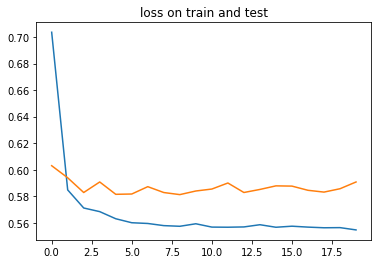

Last loss on train: 0.5545756721918562
Last loss on test: 0.5907320435109892


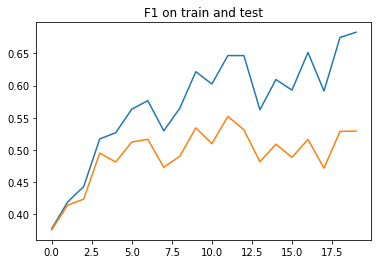

Last F1 on train: 0.6830302160398095
Last F1 on test: 0.5291077133856321


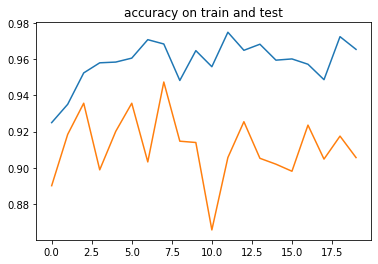

Last accuracy on train: 0.9653434800890695
Last accuracy on test: 0.905708519251723


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.9236039028440939


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

keine-B ahnung-I .-O
--O ist-B schon-I gut-I .-O
ich-B verstehe-I .-O
es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
oh-O nein-O ,-O ist-B schon-I gut-I .-O
das-B geht-I dich-I nichts-I an-I ,-O deutscher-O .-O
ja-O ,-O na-B und-I ?-O
in-B ordnung-I ,-O gnädige-O frau-O .-O
ich-O ...-O ach-B so-I ...-O
--O ich-B bin-I dabei-I .-O
klar-O ,-O aber-B natürlich-I .-O
--O schon-B gut-I .-O
--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
--O kommt-B drauf-I an-I .-O
keine-B ahnung-I .-O
das-B stimmt-I nicht-I ,-O auch-O wenn-O ich-O nur-O die-O untere-O hälfte-O gesehen-O habe-O .-O
keine-B ahnung-I .-O
nicht-B wahr-I ,-O carrie-O ?-O
ich-B weiß-I .-O
überhaupt-B nicht-I .-O
das-B stimmt-I .-O
--O gute-B frage-I .-O
ja-O ,-O nicht-B wahr-I ?-O
na-B gut-I .-O
keine-B ahnung-I .-O
na-B und-I ?-O
es-B geht-I nicht-I !-O
also-B gut-I ,-O in-B ordnung-I ,-O aber-O halt-O ihn-O mir-O vom-O leib-O .-O
hör-B auf-I ,-O valiente-O !-O
na-B schön-I .-O
--O das-B stimmt-I nicht-I .

# Experiment 3.3
LSTM 0 tokens, 2 sentences

## Data

In [ ]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [ ]:
model = BiLSTM_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:02, 19.73it/s]

Train loss: 0.847239163186815


93it [00:04, 20.26it/s]

Train loss: 0.849826188882192


137it [00:07, 20.64it/s]

Train loss: 0.8544060486334342


182it [00:09, 20.47it/s]

Train loss: 0.8487318134970135


226it [00:11, 19.46it/s]


Train loss: 0.8441237179438273

Evaluating on train...


48it [00:01, 34.76it/s]

Val loss: 0.8682469540172153, Val f1: 0.3331555247306824, Val accuracy: 0.3333333432674408


96it [00:02, 34.23it/s]

Val loss: 0.862288714117474, Val f1: 0.3479715430074268, Val accuracy: 0.34814815786149766


140it [00:04, 34.40it/s]

Val loss: 0.8463464900299354, Val f1: 0.3529219037956662, Val accuracy: 0.35308642939284995


184it [00:05, 32.33it/s]

Val loss: 0.8472426722447077, Val f1: 0.3479838141136699, Val accuracy: 0.34814815786149766


226it [00:06, 33.62it/s]


Val loss: 0.8466311658753289, Val f1: 0.3450225208865272, Val accuracy: 0.3451851949426863

Evaluating on test...


19it [00:00, 33.44it/s]

Val loss: 0.8028350909550984, Val f1: 0.43320339918136597, Val accuracy: 0.4333333412806193


35it [00:01, 31.95it/s]

Val loss: 0.8395898799101512, Val f1: 0.38317002058029176, Val accuracy: 0.38333334227403004


51it [00:01, 32.97it/s]

Val loss: 0.8430397351582845, Val f1: 0.3813181267844306, Val accuracy: 0.38148149053255714


63it [00:01, 32.48it/s]

Val loss: 0.8516345967849096, Val f1: 0.3692744861046473, Val accuracy: 0.3694444537162781


76it [00:02, 32.99it/s]


Val loss: 0.8632312870025635, Val f1: 0.36204488555590314, Val accuracy: 0.3622222316265106

starting Epoch 1
Training...


47it [00:02, 20.31it/s]

Train loss: 0.797809546523624


94it [00:04, 20.47it/s]

Train loss: 0.7790337595674727


137it [00:07, 18.72it/s]

Train loss: 0.7546898735894098


184it [00:09, 19.91it/s]

Train loss: 0.7309892932573955


226it [00:11, 19.38it/s]


Train loss: 0.7116733479499817

Evaluating on train...


48it [00:01, 33.61it/s]

Val loss: 0.6027443130811055, Val f1: 0.36803621583514745, Val accuracy: 0.8695914838049147


96it [00:02, 34.08it/s]

Val loss: 0.6035226907995012, Val f1: 0.3688653237289853, Val accuracy: 0.8887195428212483


140it [00:04, 32.99it/s]

Val loss: 0.6077795633563289, Val f1: 0.37021858979154515, Val accuracy: 0.8804443992950298


184it [00:05, 33.70it/s]

Val loss: 0.6112524827321371, Val f1: 0.36868644886546664, Val accuracy: 0.8603408932685852


226it [00:06, 33.52it/s]


Val loss: 0.614319203959571, Val f1: 0.3680766280492147, Val accuracy: 0.8647613128026327

Evaluating on test...


20it [00:00, 32.55it/s]

Val loss: 0.6699290156364441, Val f1: 0.3616276681423187, Val accuracy: 0.7561653653780619


36it [00:01, 32.43it/s]

Val loss: 0.6490619977315267, Val f1: 0.37008774777253467, Val accuracy: 0.8004388193289439


48it [00:01, 32.25it/s]

Val loss: 0.6347528868251376, Val f1: 0.36730942527453103, Val accuracy: 0.8386368062761095


64it [00:01, 32.62it/s]

Val loss: 0.6329552660385768, Val f1: 0.3678024609883626, Val accuracy: 0.8405741751194


76it [00:02, 32.56it/s]


Val loss: 0.6315562184651693, Val f1: 0.3672255023320516, Val accuracy: 0.8358955907821656

starting Epoch 2
Training...


47it [00:02, 20.38it/s]

Train loss: 0.5880217671394348


92it [00:04, 18.73it/s]

Train loss: 0.5960261238945855


138it [00:07, 19.49it/s]

Train loss: 0.5961635064195704


182it [00:09, 19.21it/s]

Train loss: 0.5938593467076619


226it [00:11, 19.51it/s]


Train loss: 0.5939068531990052

Evaluating on train...


52it [00:01, 35.20it/s]

Val loss: 0.5740879668129815, Val f1: 0.4077471262878842, Val accuracy: 0.9679702308442858


96it [00:02, 33.40it/s]

Val loss: 0.5726278450753953, Val f1: 0.40499218073156146, Val accuracy: 0.9517742054329978


140it [00:04, 34.32it/s]

Val loss: 0.5731921946560895, Val f1: 0.4091123393288365, Val accuracy: 0.9533763430736683


184it [00:05, 33.95it/s]

Val loss: 0.5760424746407403, Val f1: 0.4062844137350718, Val accuracy: 0.9543331394592921


226it [00:06, 34.17it/s]


Val loss: 0.5757197157541911, Val f1: 0.4066229487790002, Val accuracy: 0.9474547786182828

Evaluating on test...


20it [00:00, 31.87it/s]

Val loss: 0.6029661575953166, Val f1: 0.3990426301956177, Val accuracy: 0.9212784886360168


36it [00:01, 32.50it/s]

Val loss: 0.603220546245575, Val f1: 0.39365183711051943, Val accuracy: 0.9234654585520427


48it [00:01, 32.36it/s]

Val loss: 0.6008404109213087, Val f1: 0.39900818334685434, Val accuracy: 0.9112745324770609


64it [00:01, 31.94it/s]

Val loss: 0.6009675711393356, Val f1: 0.4017837310830752, Val accuracy: 0.9150691459576289


76it [00:02, 32.43it/s]


Val loss: 0.6010127886136373, Val f1: 0.398458624680837, Val accuracy: 0.891839767297109

starting Epoch 3
Training...


48it [00:02, 18.34it/s]

Train loss: 0.5743228965335422


93it [00:04, 19.94it/s]

Train loss: 0.5730831139617496


137it [00:06, 21.14it/s]

Train loss: 0.576801762757478


184it [00:09, 10.27it/s]

Train loss: 0.5763265285227034


226it [00:12, 18.64it/s]


Train loss: 0.5756567449039883

Evaluating on train...


52it [00:01, 34.43it/s]

Val loss: 0.558987636036343, Val f1: 0.46244953340954253, Val accuracy: 0.9501062803798251


96it [00:02, 33.42it/s]

Val loss: 0.5631671143902672, Val f1: 0.46533890234099495, Val accuracy: 0.9514939275052813


140it [00:04, 32.57it/s]

Val loss: 0.5640415518372147, Val f1: 0.46247175689096803, Val accuracy: 0.9443750511716913


184it [00:05, 32.21it/s]

Val loss: 0.5644991652833091, Val f1: 0.4634440792931451, Val accuracy: 0.9513672260774506


226it [00:06, 33.36it/s]


Val loss: 0.5663889275656806, Val f1: 0.4640868487623003, Val accuracy: 0.9485888928837246

Evaluating on test...


20it [00:00, 32.28it/s]

Val loss: 0.5930972297986349, Val f1: 0.44457056522369387, Val accuracy: 0.9275993903477987


36it [00:01, 32.83it/s]

Val loss: 0.586402549346288, Val f1: 0.4481307466824849, Val accuracy: 0.9394727011521657


48it [00:01, 32.16it/s]

Val loss: 0.5882507589128282, Val f1: 0.4533901022540198, Val accuracy: 0.9214371336830987


64it [00:01, 33.48it/s]

Val loss: 0.5930464317401251, Val f1: 0.4508674467603366, Val accuracy: 0.9178341964880625


76it [00:02, 32.74it/s]


Val loss: 0.5907391452789307, Val f1: 0.44603405833244325, Val accuracy: 0.9154511320590973

starting Epoch 4
Training...


48it [00:02, 20.49it/s]

Train loss: 0.5624864591492547


92it [00:04, 19.54it/s]

Train loss: 0.5642659578058454


137it [00:07, 18.96it/s]

Train loss: 0.563850302166409


182it [00:09, 20.14it/s]

Train loss: 0.5680812461508645


226it [00:11, 19.43it/s]


Train loss: 0.5680739800135295

Evaluating on train...


48it [00:01, 33.72it/s]

Val loss: 0.5679466141594781, Val f1: 0.48242926398913066, Val accuracy: 0.9290321509043376


96it [00:02, 33.40it/s]

Val loss: 0.5672632972399394, Val f1: 0.46971785128116605, Val accuracy: 0.9182752062877019


140it [00:04, 33.17it/s]

Val loss: 0.5656549519962735, Val f1: 0.47126943248289604, Val accuracy: 0.9265583872795105


184it [00:05, 34.07it/s]

Val loss: 0.5656890832715564, Val f1: 0.47532927327685887, Val accuracy: 0.9392556412352456


226it [00:06, 33.33it/s]


Val loss: 0.5661633761723837, Val f1: 0.47556639578607346, Val accuracy: 0.9406356317467159

Evaluating on test...


20it [00:00, 33.69it/s]

Val loss: 0.5773742397626241, Val f1: 0.44945507248242694, Val accuracy: 0.9194862206776937


36it [00:01, 33.57it/s]

Val loss: 0.5793031911055248, Val f1: 0.4479822019735972, Val accuracy: 0.9173995772997539


48it [00:01, 33.36it/s]

Val loss: 0.5831368459595574, Val f1: 0.455496621131897, Val accuracy: 0.9112055440743764


64it [00:01, 33.80it/s]

Val loss: 0.5822392404079437, Val f1: 0.45564627995093665, Val accuracy: 0.9108643020192783


76it [00:02, 33.52it/s]


Val loss: 0.5859563040733338, Val f1: 0.45440431276957194, Val accuracy: 0.909947384595871

starting Epoch 5
Training...


49it [00:02, 20.37it/s]

Train loss: 0.5688856071896023


91it [00:04, 20.30it/s]

Train loss: 0.570697753959232


137it [00:06, 19.50it/s]

Train loss: 0.5689330807438603


183it [00:09, 19.70it/s]

Train loss: 0.5669681555695004


226it [00:11, 19.46it/s]


Train loss: 0.5652254062228733

Evaluating on train...


48it [00:01, 34.29it/s]

Val loss: 0.559597028626336, Val f1: 0.5198085685571034, Val accuracy: 0.9687563836574554


92it [00:02, 31.85it/s]

Val loss: 0.5586286531554328, Val f1: 0.5279174622562196, Val accuracy: 0.9743470658858617


140it [00:04, 31.99it/s]

Val loss: 0.5603730100172537, Val f1: 0.5217095507515801, Val accuracy: 0.9676041671523341


184it [00:05, 32.75it/s]

Val loss: 0.5613874882459641, Val f1: 0.5204068791535166, Val accuracy: 0.9623736558689011


226it [00:06, 32.96it/s]


Val loss: 0.5601490439309014, Val f1: 0.5201528007454342, Val accuracy: 0.9635586697525448

Evaluating on test...


20it [00:00, 31.11it/s]

Val loss: 0.6026890595753988, Val f1: 0.4748498777548472, Val accuracy: 0.9189013401667278


36it [00:01, 32.42it/s]

Val loss: 0.6016567885875702, Val f1: 0.48316753705342613, Val accuracy: 0.909241932630539


48it [00:01, 32.25it/s]

Val loss: 0.5941173924340142, Val f1: 0.4826298005051083, Val accuracy: 0.9056310408645206


64it [00:01, 31.70it/s]

Val loss: 0.5911349991957346, Val f1: 0.4839913214246432, Val accuracy: 0.9183386897047361


76it [00:02, 32.49it/s]


Val loss: 0.5865420230229695, Val f1: 0.48116432944933574, Val accuracy: 0.9303025368849437

starting Epoch 6
Training...


46it [00:02, 19.78it/s]

Train loss: 0.5589317096604242


93it [00:04, 19.82it/s]

Train loss: 0.5590994159380595


138it [00:07, 18.89it/s]

Train loss: 0.5626409945664582


183it [00:09, 19.21it/s]

Train loss: 0.5622949024041494


226it [00:11, 19.35it/s]


Train loss: 0.5617260495821635

Evaluating on train...


52it [00:01, 35.00it/s]

Val loss: 0.5596792684661017, Val f1: 0.5117822600735559, Val accuracy: 0.9305250876479678


96it [00:02, 33.63it/s]

Val loss: 0.5604017774264017, Val f1: 0.5199302312400605, Val accuracy: 0.9358945611450408


140it [00:04, 31.62it/s]

Val loss: 0.5590546126718874, Val f1: 0.5323035783237882, Val accuracy: 0.9510526835918427


184it [00:05, 32.21it/s]

Val loss: 0.5595967580874761, Val f1: 0.5234172648853725, Val accuracy: 0.941735699110561


226it [00:06, 33.04it/s]


Val loss: 0.5598042403327094, Val f1: 0.5301081215010749, Val accuracy: 0.9511719515588548

Evaluating on test...


20it [00:00, 32.73it/s]

Val loss: 0.5620512048403422, Val f1: 0.49179441134134927, Val accuracy: 0.990553609530131


36it [00:01, 31.67it/s]

Val loss: 0.5746023019154867, Val f1: 0.4992576132218043, Val accuracy: 0.96819366812706


48it [00:01, 32.87it/s]

Val loss: 0.5803439299265544, Val f1: 0.49437276787228057, Val accuracy: 0.9579094701343113


64it [00:01, 32.10it/s]

Val loss: 0.5820969005425771, Val f1: 0.48865580509106316, Val accuracy: 0.946841046710809


76it [00:02, 32.38it/s]


Val loss: 0.5840805212656657, Val f1: 0.4889953100681305, Val accuracy: 0.9450113721688589

starting Epoch 7
Training...


49it [00:02, 20.39it/s]

Train loss: 0.5588738918304443


94it [00:04, 20.07it/s]

Train loss: 0.5602802978621588


137it [00:07, 20.17it/s]

Train loss: 0.5617946448149505


183it [00:09, 19.37it/s]

Train loss: 0.5616647024949392


226it [00:11, 19.47it/s]


Train loss: 0.561690825621287

Evaluating on train...


48it [00:01, 33.68it/s]

Val loss: 0.5559731920560201, Val f1: 0.5094296971956889, Val accuracy: 0.9230268564489152


96it [00:02, 32.46it/s]

Val loss: 0.5587551044093237, Val f1: 0.5096774912542767, Val accuracy: 0.9398800452550252


140it [00:04, 34.02it/s]

Val loss: 0.5589049484994676, Val f1: 0.5122082012671011, Val accuracy: 0.9510841356383429


184it [00:05, 32.64it/s]

Val loss: 0.5581585453616248, Val f1: 0.5119371382726563, Val accuracy: 0.9623762584394879


226it [00:06, 33.10it/s]


Val loss: 0.5584229803085328, Val f1: 0.5139874062273238, Val accuracy: 0.9681419481171502

Evaluating on test...


20it [00:00, 35.44it/s]

Val loss: 0.5718773285547892, Val f1: 0.4685329417387644, Val accuracy: 0.8690495610237121


36it [00:01, 34.00it/s]

Val loss: 0.5874683876832326, Val f1: 0.46040382285912834, Val accuracy: 0.8696264068285624


48it [00:01, 33.73it/s]

Val loss: 0.5889300651020474, Val f1: 0.46810153921445213, Val accuracy: 0.8766685896449619


64it [00:01, 32.60it/s]

Val loss: 0.5838514824708303, Val f1: 0.4694259360432625, Val accuracy: 0.9014143427213033


76it [00:02, 33.91it/s]


Val loss: 0.5847204128901163, Val f1: 0.46630438168843585, Val accuracy: 0.8923023521900177

starting Epoch 8
Training...


48it [00:02, 18.46it/s]

Train loss: 0.5606311400731404


94it [00:04, 19.27it/s]

Train loss: 0.5582410216331481


138it [00:07, 19.78it/s]

Train loss: 0.55850589716876


183it [00:09, 20.63it/s]

Train loss: 0.558301717042923


226it [00:11, 19.47it/s]


Train loss: 0.5586505145496792

Evaluating on train...


52it [00:01, 34.61it/s]

Val loss: 0.5547972162564595, Val f1: 0.5338454524676005, Val accuracy: 0.9385502689414554


96it [00:02, 34.57it/s]

Val loss: 0.5544483900070191, Val f1: 0.5374788877036837, Val accuracy: 0.9612387441926532


140it [00:04, 33.43it/s]

Val loss: 0.5563676847351922, Val f1: 0.546207524228979, Val accuracy: 0.9612197352780236


184it [00:05, 32.97it/s]

Val loss: 0.5559958037402895, Val f1: 0.5475630296601189, Val accuracy: 0.970221387512154


226it [00:06, 33.13it/s]


Val loss: 0.5575548142857022, Val f1: 0.5460353006256952, Val accuracy: 0.9691907735665639

Evaluating on test...


19it [00:00, 30.93it/s]

Val loss: 0.5670738021532694, Val f1: 0.49575761159261067, Val accuracy: 0.9768622716267904


35it [00:01, 31.74it/s]

Val loss: 0.5695026020208994, Val f1: 0.4840717633565267, Val accuracy: 0.9518769760926564


51it [00:01, 31.40it/s]

Val loss: 0.573174364036984, Val f1: 0.4965251584847768, Val accuracy: 0.9389310823546515


63it [00:02, 31.76it/s]

Val loss: 0.5763722876707713, Val f1: 0.48778212318817776, Val accuracy: 0.927817569176356


76it [00:02, 31.45it/s]


Val loss: 0.5804407858848571, Val f1: 0.48373125712076825, Val accuracy: 0.9188572120666504

starting Epoch 9
Training...


48it [00:02, 19.54it/s]

Train loss: 0.5545367479324341


93it [00:04, 20.33it/s]

Train loss: 0.5560375187132094


138it [00:07, 18.79it/s]

Train loss: 0.556801559748473


182it [00:09, 19.71it/s]

Train loss: 0.5604192164209154


226it [00:11, 19.38it/s]


Train loss: 0.5601913213729859

Evaluating on train...


51it [00:01, 34.16it/s]

Val loss: 0.5600213355488247, Val f1: 0.5468691468238831, Val accuracy: 0.9280863536728753


95it [00:02, 33.51it/s]

Val loss: 0.5570594741238488, Val f1: 0.5426576402452257, Val accuracy: 0.9412092748615477


139it [00:04, 32.63it/s]

Val loss: 0.5574034633459868, Val f1: 0.5490167770120833, Val accuracy: 0.9523195125438549


183it [00:05, 32.66it/s]

Val loss: 0.5571120030350155, Val f1: 0.5557499618993865, Val accuracy: 0.9555475385652648


226it [00:06, 33.07it/s]


Val loss: 0.5575808866818746, Val f1: 0.5486135396692488, Val accuracy: 0.9539291944768694

Evaluating on test...


20it [00:00, 33.93it/s]

Val loss: 0.56608700354894, Val f1: 0.4828351974487305, Val accuracy: 0.9268972714742024


36it [00:01, 32.46it/s]

Val loss: 0.5764874915281931, Val f1: 0.49309493203957877, Val accuracy: 0.9354303359985352


50it [00:02, 20.11it/s]

Val loss: 0.5867764605416192, Val f1: 0.49432896243201363, Val accuracy: 0.9098309106296963


64it [00:02, 27.48it/s]

Val loss: 0.5872468372186025, Val f1: 0.48811735957860947, Val accuracy: 0.9021478076775868


76it [00:02, 25.52it/s]


Val loss: 0.5849050370852152, Val f1: 0.4910592154661814, Val accuracy: 0.9109765203793844

starting Epoch 10
Training...


48it [00:02, 18.26it/s]

Train loss: 0.5560878581470914


92it [00:04, 20.79it/s]

Train loss: 0.5565158373779721


137it [00:07, 19.48it/s]

Train loss: 0.5572417197404085


184it [00:09, 19.88it/s]

Train loss: 0.5571561714013418


226it [00:11, 19.26it/s]


Train loss: 0.5589117587937249

Evaluating on train...


48it [00:01, 34.97it/s]

Val loss: 0.5572328593995836, Val f1: 0.5641622847980923, Val accuracy: 0.9494713220331404


96it [00:02, 32.97it/s]

Val loss: 0.5558676527606117, Val f1: 0.5646494266059664, Val accuracy: 0.9588970651229223


140it [00:04, 32.09it/s]

Val loss: 0.5579121474866514, Val f1: 0.5693538151405476, Val accuracy: 0.9529605657966048


184it [00:05, 30.79it/s]

Val loss: 0.5580678049061033, Val f1: 0.569021310740047, Val accuracy: 0.9543888246019682


226it [00:06, 32.59it/s]


Val loss: 0.557359099123213, Val f1: 0.5663099728690253, Val accuracy: 0.9570626078711616

Evaluating on test...


19it [00:00, 32.02it/s]

Val loss: 0.5891192396481831, Val f1: 0.4809161027272542, Val accuracy: 0.7721943140029908


35it [00:01, 31.87it/s]

Val loss: 0.5912694374720255, Val f1: 0.4851628383000692, Val accuracy: 0.8469825506210327


51it [00:01, 32.32it/s]

Val loss: 0.5914124793476528, Val f1: 0.4939609792497423, Val accuracy: 0.866147463189231


63it [00:02, 30.95it/s]

Val loss: 0.5905634820461273, Val f1: 0.497537229458491, Val accuracy: 0.8853112076719601


76it [00:02, 31.65it/s]


Val loss: 0.5869743005434672, Val f1: 0.49671712358792625, Val accuracy: 0.8830639330546061

starting Epoch 11
Training...


48it [00:02, 19.35it/s]

Train loss: 0.5591436081462436


92it [00:04, 19.08it/s]

Train loss: 0.559737683667077


138it [00:07, 19.95it/s]

Train loss: 0.5594135823073211


182it [00:09, 20.39it/s]

Train loss: 0.5596336166063944


226it [00:11, 19.30it/s]


Train loss: 0.5590453298886617

Evaluating on train...


51it [00:01, 33.49it/s]

Val loss: 0.5567956553565131, Val f1: 0.5417820705307854, Val accuracy: 0.963690111372206


95it [00:02, 33.50it/s]

Val loss: 0.5561839474572076, Val f1: 0.5396337853537665, Val accuracy: 0.9719415456056595


139it [00:04, 30.79it/s]

Val loss: 0.5554775741365221, Val f1: 0.5464292808815285, Val accuracy: 0.966066715673164


183it [00:05, 32.26it/s]

Val loss: 0.5552484773927264, Val f1: 0.5515697528918584, Val accuracy: 0.9703161208166017


226it [00:06, 32.90it/s]


Val loss: 0.5567955451541476, Val f1: 0.5493454906675551, Val accuracy: 0.9702565632926093

Evaluating on test...


20it [00:00, 32.54it/s]

Val loss: 0.5948541442553202, Val f1: 0.47144210735956826, Val accuracy: 0.8987692316373189


36it [00:01, 31.95it/s]

Val loss: 0.5843703866004943, Val f1: 0.4636707196633021, Val accuracy: 0.8882333527008692


48it [00:01, 32.14it/s]

Val loss: 0.5866597255071004, Val f1: 0.4603492067919837, Val accuracy: 0.8753511713610755


64it [00:02, 31.77it/s]

Val loss: 0.5825018743673961, Val f1: 0.46477576196193693, Val accuracy: 0.8992090409000715


76it [00:02, 32.22it/s]


Val loss: 0.5850979510943095, Val f1: 0.46359997749328613, Val accuracy: 0.9036113083362579

starting Epoch 12
Training...


48it [00:02, 20.55it/s]

Train loss: 0.5611868739128113


92it [00:04, 19.62it/s]

Train loss: 0.5593382954597473


139it [00:07, 20.84it/s]

Train loss: 0.5577545691419531


183it [00:09, 19.40it/s]

Train loss: 0.5580822083685133


226it [00:11, 19.42it/s]


Train loss: 0.5574864816665649

Evaluating on train...


51it [00:01, 33.53it/s]

Val loss: 0.5534915685653686, Val f1: 0.5879487468136682, Val accuracy: 0.9694237046771579


95it [00:02, 33.67it/s]

Val loss: 0.5552414993445078, Val f1: 0.5983522769477633, Val accuracy: 0.9738400677839915


139it [00:04, 32.61it/s]

Val loss: 0.5565165449071814, Val f1: 0.5930982918651015, Val accuracy: 0.9717165214044077


183it [00:05, 31.86it/s]

Val loss: 0.556592603193389, Val f1: 0.5953061638606919, Val accuracy: 0.9713549683491389


226it [00:06, 32.73it/s]


Val loss: 0.5564234529601203, Val f1: 0.5983492357201047, Val accuracy: 0.9701847677760654

Evaluating on test...


20it [00:00, 33.41it/s]

Val loss: 0.5882162849108378, Val f1: 0.4926270365715027, Val accuracy: 0.9048142810662587


36it [00:01, 32.96it/s]

Val loss: 0.5923758566379547, Val f1: 0.5100904573996862, Val accuracy: 0.9103609452644984


48it [00:01, 32.08it/s]

Val loss: 0.5886090212398105, Val f1: 0.5149807671705882, Val accuracy: 0.9192503485414717


64it [00:01, 32.04it/s]

Val loss: 0.5895975877841314, Val f1: 0.4995930219690005, Val accuracy: 0.9009321704506874


76it [00:02, 32.71it/s]


Val loss: 0.5867263221740723, Val f1: 0.5054148836930593, Val accuracy: 0.9135461246967316

starting Epoch 13
Training...


46it [00:02, 19.06it/s]

Train loss: 0.5568819257948133


92it [00:04, 18.30it/s]

Train loss: 0.5567088491386838


138it [00:07, 20.55it/s]

Train loss: 0.5566229608323839


183it [00:09, 19.61it/s]

Train loss: 0.5571086410019133


226it [00:11, 19.26it/s]


Train loss: 0.5574648663732741

Evaluating on train...


52it [00:01, 35.94it/s]

Val loss: 0.5594344841109382, Val f1: 0.5991053620974223, Val accuracy: 0.9872305353482564


96it [00:02, 32.93it/s]

Val loss: 0.5594232618808747, Val f1: 0.6035842895507812, Val accuracy: 0.9660072942574819


140it [00:04, 33.33it/s]

Val loss: 0.5578249123361375, Val f1: 0.6005148243021082, Val accuracy: 0.9716660989655389


184it [00:05, 32.89it/s]

Val loss: 0.5567031469610002, Val f1: 0.5975562098953459, Val accuracy: 0.9674211808376842


226it [00:06, 33.14it/s]


Val loss: 0.5567612539397345, Val f1: 0.5981728735235002, Val accuracy: 0.9633752189742194

Evaluating on test...


20it [00:00, 33.18it/s]

Val loss: 0.5736642400423686, Val f1: 0.4955670018990835, Val accuracy: 0.8893188754717509


36it [00:01, 32.55it/s]

Val loss: 0.5785702367623647, Val f1: 0.5142343024412791, Val accuracy: 0.9195460697015126


48it [00:01, 32.46it/s]

Val loss: 0.5820616126060486, Val f1: 0.51696271498998, Val accuracy: 0.9233891301684909


64it [00:01, 32.90it/s]

Val loss: 0.5789294262727102, Val f1: 0.5111883148550987, Val accuracy: 0.9136794383327166


76it [00:02, 32.64it/s]


Val loss: 0.5856142703692119, Val f1: 0.506689727306366, Val accuracy: 0.9024732319513956

starting Epoch 14
Training...


48it [00:02, 19.15it/s]

Train loss: 0.5543485350079007


94it [00:04, 20.20it/s]

Train loss: 0.5576781736479866


137it [00:06, 19.27it/s]

Train loss: 0.5567046055087337


183it [00:09, 19.32it/s]

Train loss: 0.557080911927753


226it [00:11, 19.39it/s]


Train loss: 0.5570499112870958

Evaluating on train...


48it [00:01, 34.44it/s]

Val loss: 0.5582851303948296, Val f1: 0.649555903673172, Val accuracy: 0.9769670989778306


96it [00:02, 33.78it/s]

Val loss: 0.5565893630186717, Val f1: 0.6341143233908547, Val accuracy: 0.9570517046584024


140it [00:04, 32.11it/s]

Val loss: 0.5554886862083718, Val f1: 0.6248666516056767, Val accuracy: 0.9513694334913183


184it [00:05, 30.87it/s]

Val loss: 0.5560903168386884, Val f1: 0.639774274163776, Val accuracy: 0.9614579680893156


226it [00:06, 33.19it/s]


Val loss: 0.5556564068794251, Val f1: 0.6355275677310096, Val accuracy: 0.9556947961118486

Evaluating on test...


20it [00:00, 33.46it/s]

Val loss: 0.5932215491930644, Val f1: 0.5426629741986593, Val accuracy: 0.874563584725062


36it [00:01, 33.36it/s]

Val loss: 0.5905495961507161, Val f1: 0.5677883823712667, Val accuracy: 0.9018925994634628


48it [00:01, 32.30it/s]

Val loss: 0.5978352983792623, Val f1: 0.5536435703436534, Val accuracy: 0.8846899370352427


64it [00:01, 31.00it/s]

Val loss: 0.5886788874864578, Val f1: 0.5507252365350723, Val accuracy: 0.8882311880588531


76it [00:02, 32.27it/s]


Val loss: 0.5874500974019369, Val f1: 0.5428124503294627, Val accuracy: 0.9011741868654887

starting Epoch 15
Training...


48it [00:02, 19.29it/s]

Train loss: 0.559091505739424


94it [00:04, 20.09it/s]

Train loss: 0.5561203989717696


137it [00:07, 20.00it/s]

Train loss: 0.5565238153492963


181it [00:09, 19.66it/s]

Train loss: 0.5561055988073349


226it [00:11, 19.24it/s]


Train loss: 0.556480102274153

Evaluating on train...


48it [00:01, 34.50it/s]

Val loss: 0.5569823847876655, Val f1: 0.5373311830891503, Val accuracy: 0.9970277229944865


96it [00:02, 33.23it/s]

Val loss: 0.5584770010577308, Val f1: 0.5408075468407737, Val accuracy: 0.9722734106911554


140it [00:04, 33.73it/s]

Val loss: 0.5580028706126743, Val f1: 0.5443271012217911, Val accuracy: 0.9657094357190309


184it [00:05, 33.39it/s]

Val loss: 0.5575048115518358, Val f1: 0.547353472146723, Val accuracy: 0.9553785531057252


226it [00:06, 32.96it/s]


Val loss: 0.558082229561276, Val f1: 0.5461416412724389, Val accuracy: 0.9562588918209076

Evaluating on test...


19it [00:00, 32.18it/s]

Val loss: 0.5858338832855224, Val f1: 0.47447843154271446, Val accuracy: 0.9399804751078288


35it [00:01, 31.02it/s]

Val loss: 0.5808188120524088, Val f1: 0.4674442172050476, Val accuracy: 0.9313592960437139


51it [00:01, 32.74it/s]

Val loss: 0.5827778657277425, Val f1: 0.46675598820050557, Val accuracy: 0.928376681274838


63it [00:01, 32.33it/s]

Val loss: 0.5856605798006058, Val f1: 0.4687379722793897, Val accuracy: 0.9317733854055404


76it [00:02, 32.33it/s]


Val loss: 0.584763593673706, Val f1: 0.4686950898170471, Val accuracy: 0.9378865544001261

starting Epoch 16
Training...


47it [00:02, 18.71it/s]

Train loss: 0.553892351521386


92it [00:04, 19.41it/s]

Train loss: 0.5576456447442373


137it [00:07, 18.06it/s]

Train loss: 0.5561936413800275


182it [00:09, 18.60it/s]

Train loss: 0.5553965300321579


226it [00:11, 19.26it/s]


Train loss: 0.5569477327664694

Evaluating on train...


51it [00:02, 18.36it/s]

Val loss: 0.5538558748033312, Val f1: 0.613762088616689, Val accuracy: 0.9511228799819946


94it [00:03, 31.88it/s]

Val loss: 0.556130262878206, Val f1: 0.6233976735009088, Val accuracy: 0.9622837404410044


138it [00:04, 31.93it/s]

Val loss: 0.5559729554035046, Val f1: 0.6339163850854944, Val accuracy: 0.9717422812073319


186it [00:06, 34.08it/s]

Val loss: 0.5553940551148521, Val f1: 0.6367860911620988, Val accuracy: 0.9635312406553163


226it [00:07, 30.07it/s]


Val loss: 0.556012675497267, Val f1: 0.6377620241377089, Val accuracy: 0.967882412009769

Evaluating on test...


19it [00:00, 33.07it/s]

Val loss: 0.6015371799468994, Val f1: 0.5228202601273855, Val accuracy: 0.8836030264695486


35it [00:01, 33.44it/s]

Val loss: 0.602377998828888, Val f1: 0.5231907705465952, Val accuracy: 0.8773329287767411


51it [00:01, 33.55it/s]

Val loss: 0.5984373953607347, Val f1: 0.5258717113071018, Val accuracy: 0.8919980439874861


63it [00:01, 32.62it/s]

Val loss: 0.5961061259110768, Val f1: 0.5409332613150278, Val accuracy: 0.9042038535078366


76it [00:02, 32.70it/s]


Val loss: 0.5911747280756633, Val f1: 0.5322675844033559, Val accuracy: 0.9033554414908092

starting Epoch 17
Training...


48it [00:02, 19.72it/s]

Train loss: 0.5551870584487915


93it [00:04, 19.34it/s]

Train loss: 0.5569716685348087


137it [00:07, 18.96it/s]

Train loss: 0.5567023255206921


181it [00:09, 20.11it/s]

Train loss: 0.556252834200859


226it [00:11, 19.14it/s]


Train loss: 0.556024026605818

Evaluating on train...


48it [00:01, 33.29it/s]

Val loss: 0.5531147042910258, Val f1: 0.6457088192303976, Val accuracy: 0.9992305490705702


96it [00:02, 33.25it/s]

Val loss: 0.5548263152440389, Val f1: 0.6423795508013831, Val accuracy: 0.9659021228551865


140it [00:04, 31.78it/s]

Val loss: 0.5563279575771756, Val f1: 0.6427726454204983, Val accuracy: 0.9578732695844439


184it [00:05, 31.25it/s]

Val loss: 0.5555272006326252, Val f1: 0.6378177482220861, Val accuracy: 0.964513457318147


226it [00:06, 32.68it/s]


Val loss: 0.5554904845025804, Val f1: 0.629412948290507, Val accuracy: 0.9561484192477332

Evaluating on test...


19it [00:00, 33.93it/s]

Val loss: 0.5788418491681416, Val f1: 0.5242910782496134, Val accuracy: 0.9641057411829631


35it [00:01, 33.45it/s]

Val loss: 0.5847135782241821, Val f1: 0.5061056564251581, Val accuracy: 0.9465921183427175


51it [00:01, 33.11it/s]

Val loss: 0.5790726317299737, Val f1: 0.5159375766913096, Val accuracy: 0.953770739502377


63it [00:01, 33.12it/s]

Val loss: 0.5807198544343313, Val f1: 0.518656033774217, Val accuracy: 0.953757060567538


76it [00:02, 33.01it/s]


Val loss: 0.5846499530474345, Val f1: 0.517919632991155, Val accuracy: 0.9436778593063354

starting Epoch 18
Training...


47it [00:02, 18.44it/s]

Train loss: 0.5566233846876356


93it [00:04, 20.16it/s]

Train loss: 0.5578571200370789


136it [00:07, 18.09it/s]

Train loss: 0.5577033775824087


183it [00:09, 20.04it/s]

Train loss: 0.5578044070137872


226it [00:11, 19.36it/s]


Train loss: 0.5574549280272589

Evaluating on train...


48it [00:01, 34.41it/s]

Val loss: 0.5540835936864217, Val f1: 0.5986694289578331, Val accuracy: 0.9398479309346941


96it [00:02, 33.53it/s]

Val loss: 0.557951851023568, Val f1: 0.6037631154060363, Val accuracy: 0.9633906414111455


140it [00:04, 33.50it/s]

Val loss: 0.5566585033028214, Val f1: 0.5956236603083434, Val accuracy: 0.9654239023173297


184it [00:05, 31.09it/s]

Val loss: 0.556126578980022, Val f1: 0.5927963074710634, Val accuracy: 0.9696533479624324


226it [00:06, 32.84it/s]


Val loss: 0.5557208138042026, Val f1: 0.5911353590753343, Val accuracy: 0.9722791168424818

Evaluating on test...


19it [00:00, 32.54it/s]

Val loss: 0.5734979152679444, Val f1: 0.5012396494547526, Val accuracy: 0.9465762535730998


35it [00:01, 31.84it/s]

Val loss: 0.5753231604894002, Val f1: 0.5070063372453054, Val accuracy: 0.9396818737188976


51it [00:01, 31.88it/s]

Val loss: 0.5792721284760369, Val f1: 0.49005207419395447, Val accuracy: 0.913655756579505


63it [00:01, 31.37it/s]

Val loss: 0.5839506427447001, Val f1: 0.5004331092039744, Val accuracy: 0.8935660565892856


76it [00:02, 31.82it/s]


Val loss: 0.5845506286621094, Val f1: 0.4940771706899007, Val accuracy: 0.8755036997795105

starting Epoch 19
Training...


49it [00:02, 20.15it/s]

Train loss: 0.5606409827868144


93it [00:04, 18.78it/s]

Train loss: 0.5576937046315935


139it [00:07, 19.48it/s]

Train loss: 0.5569013242368345


183it [00:09, 19.05it/s]

Train loss: 0.5569665686951744


226it [00:11, 19.27it/s]


Train loss: 0.5573256142934163

Evaluating on train...


52it [00:01, 33.63it/s]

Val loss: 0.5560843308766683, Val f1: 0.5526912622981601, Val accuracy: 0.9510442581441667


96it [00:02, 32.58it/s]

Val loss: 0.5563193579514821, Val f1: 0.5615292463037703, Val accuracy: 0.9581599414348603


140it [00:04, 33.02it/s]

Val loss: 0.5556891922597532, Val f1: 0.5517290989557903, Val accuracy: 0.9469981844778415


184it [00:05, 31.20it/s]

Val loss: 0.5570052087306976, Val f1: 0.5556205944882499, Val accuracy: 0.9573066544201639


226it [00:06, 33.05it/s]


Val loss: 0.5564472892549303, Val f1: 0.5568566501140595, Val accuracy: 0.9567128463586172

Evaluating on test...


19it [00:00, 33.11it/s]

Val loss: 0.5848360538482666, Val f1: 0.4680017292499542, Val accuracy: 0.9348316629727681


35it [00:01, 31.37it/s]

Val loss: 0.581176882982254, Val f1: 0.4480096747477849, Val accuracy: 0.9377306242783864


51it [00:01, 31.63it/s]

Val loss: 0.5865785002708435, Val f1: 0.4572362138165368, Val accuracy: 0.9331401096449958


63it [00:01, 32.66it/s]

Val loss: 0.5876881589492162, Val f1: 0.45999761869510014, Val accuracy: 0.9353607883056004


76it [00:02, 32.12it/s]

Val loss: 0.5866137448946634, Val f1: 0.4567776668071747, Val accuracy: 0.9310113894939422


## Graphics

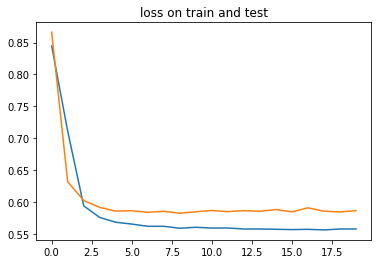

Last loss on train: 0.5574932230257355
Last loss on test: 0.5862467759533933


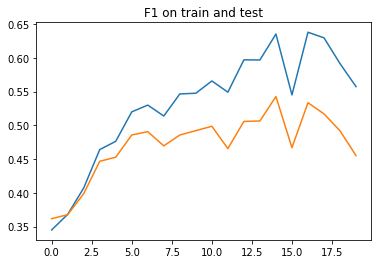

Last F1 on train: 0.5574382800707774
Last F1 on test: 0.4551356423058008


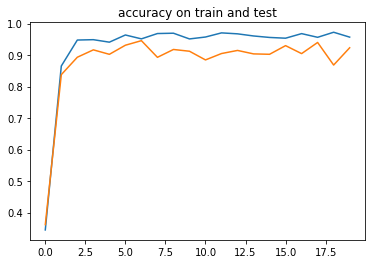

Last accuracy on train: 0.956898252125335
Last accuracy on test: 0.9231118340241281


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8431077434087606


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

ist-B schon-I gut-I .-O
ich-B verstehe-I .-O
--O keine-B ahnung-I .-O
also-O werden-O wir-O sie-O daran-O erinnern-O ,-O nicht-B wahr-I ?-O
ja-O ,-O ich-B glaube-I schon-I .-O
--O ich-B bin-I dabei-I .-O
auf-B keinen-I fall-I .-O
keine-B ahnung-I .-O
hör-B auf-I !-O
wenn-O uns-O ein-O abwehrmechanismus-O durch-O schlechte-O zeiten-O hilft-O ,-O na-B und-I ?-O
--O nicht-B wirklich-I .-O
keine-B ursache-I .-O
--O so-O eine-O art-O ,-O ich-B weiß-I schon-I .-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
sieht-B so-I aus-I .-O
das-B ist-I es-I doch-I .-O
--O kommt-B drauf-I an-I .-O
--O machen-B sie-I witze-I ?-O
ist-B gut-I .-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
nicht-B wahr-I ?-O
--O ich-B weiß-I .-O
--O ich-B weiß-I .-O
ist-B schon-I ok-I .-O
ganz-B sicher-I nicht-I .-O
ach-B was-I ,-O ihr-O beiden-O wusstet-O genau-O bescheid-O .-O
nicht-B wahr-I ,-O trey-O ?-O
--O in-B ordnung-I .-O
--O na-B klar-I .-O
--O klasse-O --O ich-B weiß-I .-O
keine-B ahnung-I .-O
na-

# Experiment 4.1
GRU 10 tokens, 2 sentences weights (0.001734, 1, 0.72)

## Data

In [7]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_10_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [8]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [9]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:02, 22.63it/s]

Train loss: 0.7713076048427158


94it [00:04, 22.74it/s]

Train loss: 0.710166699356503


139it [00:06, 23.57it/s]

Train loss: 0.6802094556667186


181it [00:07, 23.04it/s]

Train loss: 0.661752771668964


226it [00:09, 22.88it/s]


Train loss: 0.6505053676499261

Evaluating on train...


49it [00:01, 38.36it/s]

Val loss: 0.6116634514596727, Val f1: 0.35465013715955945, Val accuracy: 0.8493766890631782


94it [00:02, 37.19it/s]

Val loss: 0.6150561385684543, Val f1: 0.3534363398949305, Val accuracy: 0.857296977771653


142it [00:03, 36.62it/s]

Val loss: 0.6153911303590845, Val f1: 0.35431691982128, Val accuracy: 0.8729902512497372


186it [00:05, 36.31it/s]

Val loss: 0.6187048107385635, Val f1: 0.3541761717862553, Val accuracy: 0.8694180990258853


226it [00:06, 36.48it/s]


Val loss: 0.6181557952033149, Val f1: 0.35467210319307113, Val accuracy: 0.8752112715774112

Evaluating on test...


20it [00:00, 35.44it/s]

Val loss: 0.6122698744138082, Val f1: 0.3526527206103007, Val accuracy: 0.8632582406202952


36it [00:01, 34.82it/s]

Val loss: 0.6194904287656148, Val f1: 0.35238594710826876, Val accuracy: 0.882792271176974


52it [00:01, 34.91it/s]

Val loss: 0.61703632540173, Val f1: 0.3531843649016486, Val accuracy: 0.891499188873503


64it [00:01, 35.46it/s]

Val loss: 0.6222160955270132, Val f1: 0.35271130154530206, Val accuracy: 0.8655737360318502


76it [00:02, 35.03it/s]


Val loss: 0.621049633026123, Val f1: 0.3544371978441874, Val accuracy: 0.8597660756111145

starting Epoch 1
Training...


47it [00:02, 22.80it/s]

Train loss: 0.5851520564821031


92it [00:04, 23.50it/s]

Train loss: 0.5881611949867672


140it [00:06, 24.10it/s]

Train loss: 0.586399992748543


182it [00:07, 23.93it/s]

Train loss: 0.5859334306584464


226it [00:09, 23.19it/s]


Train loss: 0.5849802655643886

Evaluating on train...


50it [00:01, 39.92it/s]

Val loss: 0.5765888359811571, Val f1: 0.42839273744159273, Val accuracy: 0.943631507953008


96it [00:02, 37.70it/s]

Val loss: 0.571271276473999, Val f1: 0.431559321946568, Val accuracy: 0.9465622978077994


140it [00:03, 37.26it/s]

Val loss: 0.5688300353509409, Val f1: 0.4350125992739642, Val accuracy: 0.9555018502253073


184it [00:04, 37.18it/s]

Val loss: 0.5695412807994419, Val f1: 0.43635568469762803, Val accuracy: 0.9563183080818918


226it [00:06, 37.62it/s]


Val loss: 0.5697358226776124, Val f1: 0.43558704932530723, Val accuracy: 0.9521489805645413

Evaluating on test...


20it [00:00, 35.78it/s]

Val loss: 0.585329548517863, Val f1: 0.40790841380755105, Val accuracy: 0.8456134835879008


36it [00:01, 36.38it/s]

Val loss: 0.5933190902074178, Val f1: 0.4128595978021622, Val accuracy: 0.8427187472581863


52it [00:01, 35.15it/s]

Val loss: 0.588094781504737, Val f1: 0.4167434447341495, Val accuracy: 0.8708532247278425


64it [00:01, 34.86it/s]

Val loss: 0.58924267689387, Val f1: 0.4203283697366714, Val accuracy: 0.8740420694152514


76it [00:02, 35.73it/s]


Val loss: 0.5885038622220358, Val f1: 0.4209472477436066, Val accuracy: 0.8879624458154043

starting Epoch 2
Training...


47it [00:02, 23.03it/s]

Train loss: 0.5708727730645073


92it [00:03, 24.13it/s]

Train loss: 0.5693181594212849


137it [00:06, 23.15it/s]

Train loss: 0.572864501564591


182it [00:08, 21.52it/s]

Train loss: 0.571754930416743


226it [00:10, 22.51it/s]


Train loss: 0.5709854732619392

Evaluating on train...


53it [00:01, 40.37it/s]

Val loss: 0.5624572740660774, Val f1: 0.4494854536321428, Val accuracy: 0.9659705400466919


94it [00:02, 36.53it/s]

Val loss: 0.5639757189485762, Val f1: 0.45397386385334865, Val accuracy: 0.9681380573246214


142it [00:03, 36.32it/s]

Val loss: 0.5665276580386691, Val f1: 0.4470126105679406, Val accuracy: 0.9585554782991056


183it [00:05, 25.00it/s]

Val loss: 0.5645810100767348, Val f1: 0.4496010113093588, Val accuracy: 0.9527313866549068


226it [00:06, 34.55it/s]


Val loss: 0.5645914477772183, Val f1: 0.449487022029029, Val accuracy: 0.9496157100465563

Evaluating on test...


20it [00:00, 36.95it/s]

Val loss: 0.5859678824742635, Val f1: 0.43207120299339297, Val accuracy: 0.9015543440977732


36it [00:00, 36.86it/s]

Val loss: 0.5823145866394043, Val f1: 0.4218338171641032, Val accuracy: 0.9261437167723974


52it [00:01, 36.40it/s]

Val loss: 0.5821350428793165, Val f1: 0.4240815864668952, Val accuracy: 0.9219693548149532


64it [00:01, 36.59it/s]

Val loss: 0.5830023268858592, Val f1: 0.42714143693447115, Val accuracy: 0.9304175660014152


76it [00:02, 36.88it/s]


Val loss: 0.5835182889302571, Val f1: 0.429106582403183, Val accuracy: 0.933725997209549

starting Epoch 3
Training...


48it [00:02, 23.73it/s]

Train loss: 0.566787240240309


93it [00:03, 23.78it/s]

Train loss: 0.5659670088026258


138it [00:05, 22.85it/s]

Train loss: 0.5661254242614463


183it [00:07, 20.92it/s]

Train loss: 0.5680209560526742


226it [00:09, 23.09it/s]


Train loss: 0.5674596105681525

Evaluating on train...


51it [00:01, 39.19it/s]

Val loss: 0.5696604450543722, Val f1: 0.4892465141084459, Val accuracy: 0.9370178911421034


95it [00:02, 34.83it/s]

Val loss: 0.5663019325998094, Val f1: 0.4832711557547251, Val accuracy: 0.943946627775828


139it [00:03, 35.35it/s]

Val loss: 0.5650187134742737, Val f1: 0.4931766474688495, Val accuracy: 0.9367312210577505


187it [00:05, 36.38it/s]

Val loss: 0.5644502855009503, Val f1: 0.5019047886133194, Val accuracy: 0.9437152417169676


226it [00:06, 37.18it/s]


Val loss: 0.5639240389400059, Val f1: 0.5004154666264852, Val accuracy: 0.9440838375356462

Evaluating on test...


20it [00:00, 36.12it/s]

Val loss: 0.5719298283259074, Val f1: 0.48299169341723125, Val accuracy: 0.9263398865858714


36it [00:01, 35.24it/s]

Val loss: 0.5769889811674754, Val f1: 0.47404926220575966, Val accuracy: 0.9286311676104864


52it [00:01, 35.52it/s]

Val loss: 0.5829312907324897, Val f1: 0.4705313960711161, Val accuracy: 0.9204801155461205


64it [00:01, 35.43it/s]

Val loss: 0.5873297780752182, Val f1: 0.4635448435942332, Val accuracy: 0.9042355085412661


76it [00:02, 35.92it/s]


Val loss: 0.5880163455009461, Val f1: 0.4652627905209859, Val accuracy: 0.911560252904892

starting Epoch 4
Training...


50it [00:02, 23.91it/s]

Train loss: 0.5650258527861701


92it [00:04, 23.67it/s]

Train loss: 0.5656562580002679


137it [00:05, 23.09it/s]

Train loss: 0.5643195629119873


182it [00:07, 23.20it/s]

Train loss: 0.5651192115412818


226it [00:09, 22.81it/s]


Train loss: 0.564433213075002

Evaluating on train...


50it [00:01, 38.00it/s]

Val loss: 0.5621091736687555, Val f1: 0.48990278045336405, Val accuracy: 0.9725936432679494


96it [00:02, 38.53it/s]

Val loss: 0.5592350290881263, Val f1: 0.48552854624059466, Val accuracy: 0.9550070408317778


140it [00:03, 36.55it/s]

Val loss: 0.5606309259379352, Val f1: 0.4778017050690121, Val accuracy: 0.9341470621250294


184it [00:04, 35.45it/s]

Val loss: 0.5609829097986221, Val f1: 0.4843999180528853, Val accuracy: 0.943357832564248


226it [00:06, 36.99it/s]


Val loss: 0.5610077351993985, Val f1: 0.4822147492567698, Val accuracy: 0.9465162607034048

Evaluating on test...


20it [00:00, 36.88it/s]

Val loss: 0.5716667850812276, Val f1: 0.4393675267696381, Val accuracy: 0.9329997400442759


36it [00:00, 35.85it/s]

Val loss: 0.585501742362976, Val f1: 0.43876548012097677, Val accuracy: 0.916695061326027


52it [00:01, 36.71it/s]

Val loss: 0.5884051071272955, Val f1: 0.43936066693729825, Val accuracy: 0.906124742825826


64it [00:01, 35.69it/s]

Val loss: 0.587392661968867, Val f1: 0.440997547407945, Val accuracy: 0.9173881689707438


76it [00:02, 36.10it/s]


Val loss: 0.585745882987976, Val f1: 0.4443053495883942, Val accuracy: 0.9253872640927633

starting Epoch 5
Training...


47it [00:02, 23.49it/s]

Train loss: 0.5642301585939196


92it [00:04, 22.10it/s]

Train loss: 0.5608335448635949


137it [00:06, 22.12it/s]

Train loss: 0.5641893201404148


182it [00:08, 21.10it/s]

Train loss: 0.5653182013167275


226it [00:09, 22.74it/s]


Train loss: 0.5649046283298068

Evaluating on train...


49it [00:01, 37.98it/s]

Val loss: 0.5571163866255019, Val f1: 0.5373888797230191, Val accuracy: 0.9795232474803924


97it [00:02, 36.74it/s]

Val loss: 0.5605347865157657, Val f1: 0.531388399998347, Val accuracy: 0.9654308388630549


141it [00:03, 34.70it/s]

Val loss: 0.560692161542398, Val f1: 0.5306259135405222, Val accuracy: 0.9717313883481202


185it [00:05, 34.94it/s]

Val loss: 0.5599956310457653, Val f1: 0.5261961440245311, Val accuracy: 0.9660398271348741


226it [00:06, 36.07it/s]


Val loss: 0.5601936388015747, Val f1: 0.5226472157902188, Val accuracy: 0.964664824406306

Evaluating on test...


20it [00:00, 34.57it/s]

Val loss: 0.5872760693232218, Val f1: 0.4652211288611094, Val accuracy: 0.857177217801412


36it [00:01, 35.69it/s]

Val loss: 0.5895607590675354, Val f1: 0.46303985416889193, Val accuracy: 0.8557527561982473


52it [00:01, 35.32it/s]

Val loss: 0.5932806730270386, Val f1: 0.4627993186314901, Val accuracy: 0.8688720809088812


64it [00:01, 33.89it/s]

Val loss: 0.5877051164706548, Val f1: 0.46421981950600943, Val accuracy: 0.8827439894278845


76it [00:02, 35.03it/s]


Val loss: 0.5890178775787354, Val f1: 0.4670825616518656, Val accuracy: 0.8714095687866211

starting Epoch 6
Training...


48it [00:02, 21.82it/s]

Train loss: 0.5594386643833584


93it [00:04, 22.41it/s]

Train loss: 0.5587611277898152


138it [00:06, 24.42it/s]

Train loss: 0.5590196583006117


183it [00:08, 23.28it/s]

Train loss: 0.5597142659955554


226it [00:10, 22.39it/s]


Train loss: 0.5615648682912191

Evaluating on train...


51it [00:01, 37.09it/s]

Val loss: 0.5631731629371644, Val f1: 0.5064529630872938, Val accuracy: 0.9636217885547214


96it [00:02, 36.96it/s]

Val loss: 0.5612236360708872, Val f1: 0.5052074746953117, Val accuracy: 0.9604364686542087


140it [00:03, 36.35it/s]

Val loss: 0.5608866585625543, Val f1: 0.503149872135233, Val accuracy: 0.9552831446682966


184it [00:04, 35.91it/s]

Val loss: 0.5600740260548062, Val f1: 0.5026860493752692, Val accuracy: 0.9648993399408129


226it [00:06, 36.81it/s]


Val loss: 0.5609695553779602, Val f1: 0.49777619229422676, Val accuracy: 0.960807952483495

Evaluating on test...


20it [00:00, 37.27it/s]

Val loss: 0.5716849565505981, Val f1: 0.42691950996716815, Val accuracy: 0.873341457049052


36it [00:00, 36.11it/s]

Val loss: 0.5798824151357015, Val f1: 0.42411431272824607, Val accuracy: 0.8800924042860667


48it [00:01, 34.58it/s]

Val loss: 0.5825293448236254, Val f1: 0.43329310218493144, Val accuracy: 0.9004960152837965


64it [00:01, 35.87it/s]

Val loss: 0.579944055279096, Val f1: 0.43935153434673946, Val accuracy: 0.9191292216380437


76it [00:02, 35.56it/s]


Val loss: 0.5815114903450013, Val f1: 0.4380050849914551, Val accuracy: 0.9235425686836243

starting Epoch 7
Training...


47it [00:02, 21.40it/s]

Train loss: 0.564413058757782


92it [00:04, 22.54it/s]

Train loss: 0.5638141453266143


137it [00:06, 20.58it/s]

Train loss: 0.5636762755888479


182it [00:08, 23.37it/s]

Train loss: 0.5643886480066511


226it [00:10, 21.34it/s]


Train loss: 0.5628711922963461

Evaluating on train...


51it [00:01, 39.40it/s]

Val loss: 0.562195168601142, Val f1: 0.6056332323286269, Val accuracy: 0.9543687595261467


96it [00:02, 36.75it/s]

Val loss: 0.5599985480308532, Val f1: 0.5961090670691596, Val accuracy: 0.9653437170717452


141it [00:03, 35.98it/s]

Val loss: 0.5605009741253323, Val f1: 0.5979535027786538, Val accuracy: 0.9536591059631772


185it [00:04, 34.32it/s]

Val loss: 0.5592175861199696, Val f1: 0.6018784508109093, Val accuracy: 0.964388310081429


226it [00:06, 37.34it/s]


Val loss: 0.559606032371521, Val f1: 0.5983862116601733, Val accuracy: 0.9616633070839776

Evaluating on test...


20it [00:00, 36.87it/s]

Val loss: 0.6144721150398255, Val f1: 0.5114869813124339, Val accuracy: 0.8891738613446554


36it [00:00, 35.84it/s]

Val loss: 0.6060673832893372, Val f1: 0.5107968022425969, Val accuracy: 0.8795160641272862


52it [00:01, 35.58it/s]

Val loss: 0.5998324712117513, Val f1: 0.5167194690969256, Val accuracy: 0.8953002803855472


64it [00:01, 34.92it/s]

Val loss: 0.5982847948869069, Val f1: 0.5146358157197635, Val accuracy: 0.9007834061980248


76it [00:02, 35.67it/s]


Val loss: 0.5911233456929524, Val f1: 0.5164987250169119, Val accuracy: 0.9144213672478994

starting Epoch 8
Training...


48it [00:02, 21.85it/s]

Train loss: 0.5580976711379158


93it [00:04, 20.31it/s]

Train loss: 0.5579763326379988


138it [00:06, 23.44it/s]

Train loss: 0.557947227248439


183it [00:08, 23.38it/s]

Train loss: 0.5612901581658257


226it [00:10, 22.20it/s]


Train loss: 0.5616511930359734

Evaluating on train...


52it [00:01, 36.83it/s]

Val loss: 0.5611201908853319, Val f1: 0.49938512245814004, Val accuracy: 0.9383906973732843


97it [00:02, 35.94it/s]

Val loss: 0.559206235408783, Val f1: 0.5202717042631573, Val accuracy: 0.957979785071479


141it [00:04, 34.75it/s]

Val loss: 0.5594892047069691, Val f1: 0.5237042367458343, Val accuracy: 0.9584144433339437


185it [00:05, 33.64it/s]

Val loss: 0.561687210533354, Val f1: 0.5251818001270294, Val accuracy: 0.9592705541186862


226it [00:06, 33.93it/s]


Val loss: 0.5610153195593092, Val f1: 0.5279627660910289, Val accuracy: 0.9596567033396827

Evaluating on test...


20it [00:00, 36.41it/s]

Val loss: 0.5904267152150472, Val f1: 0.44648590087890627, Val accuracy: 0.9415157477060954


36it [00:01, 35.48it/s]

Val loss: 0.5837390899658204, Val f1: 0.44809581339359283, Val accuracy: 0.9283922175566356


52it [00:01, 34.83it/s]

Val loss: 0.5819420708550347, Val f1: 0.4493720955318875, Val accuracy: 0.9319539878103468


64it [00:01, 34.38it/s]

Val loss: 0.5819312115510304, Val f1: 0.4487096572915713, Val accuracy: 0.9231208836038908


76it [00:02, 35.29it/s]


Val loss: 0.5874996590614319, Val f1: 0.44683016737302145, Val accuracy: 0.916123970746994

starting Epoch 9
Training...


47it [00:02, 22.87it/s]

Train loss: 0.5652262528737386


92it [00:04, 20.40it/s]

Train loss: 0.5645561112297905


137it [00:06, 21.76it/s]

Train loss: 0.5633878623997723


182it [00:08, 23.35it/s]

Train loss: 0.5653066741095649


226it [00:10, 22.00it/s]


Train loss: 0.5651429520712958

Evaluating on train...


51it [00:01, 39.23it/s]

Val loss: 0.5571208556493124, Val f1: 0.5081717888514201, Val accuracy: 0.950031269258923


96it [00:02, 37.21it/s]

Val loss: 0.5589616278807322, Val f1: 0.5013498481776979, Val accuracy: 0.9386803444888857


140it [00:03, 35.86it/s]

Val loss: 0.5609220668121621, Val f1: 0.5093507991896735, Val accuracy: 0.9547720831853372


184it [00:04, 35.90it/s]

Val loss: 0.5621638072861566, Val f1: 0.5027168461018139, Val accuracy: 0.9571247726678849


226it [00:06, 36.69it/s]


Val loss: 0.5619543149736193, Val f1: 0.5041648084587521, Val accuracy: 0.9576561550299326

Evaluating on test...


20it [00:00, 37.85it/s]

Val loss: 0.5812669555346172, Val f1: 0.4433280348777771, Val accuracy: 0.943254804611206


36it [00:00, 37.53it/s]

Val loss: 0.5983567118644715, Val f1: 0.4500488152106603, Val accuracy: 0.9164480447769165


52it [00:01, 37.15it/s]

Val loss: 0.5933364378081427, Val f1: 0.4505457580089569, Val accuracy: 0.9099884655740526


64it [00:01, 37.76it/s]

Val loss: 0.5934877544641495, Val f1: 0.4528175835808118, Val accuracy: 0.9114665816227595


76it [00:02, 37.18it/s]


Val loss: 0.5896703322728475, Val f1: 0.4488063712914785, Val accuracy: 0.909125051498413

starting Epoch 10
Training...


47it [00:02, 22.77it/s]

Train loss: 0.5607518977589078


92it [00:04, 21.73it/s]

Train loss: 0.5598453766769833


137it [00:06, 23.12it/s]

Train loss: 0.5609877109527588


182it [00:08, 21.52it/s]

Train loss: 0.5595188445515102


226it [00:10, 22.17it/s]


Train loss: 0.5610504831208123

Evaluating on train...


52it [00:01, 39.41it/s]

Val loss: 0.5559326529502868, Val f1: 0.5197580052746666, Val accuracy: 0.9815302034219106


97it [00:02, 36.46it/s]

Val loss: 0.5585099948777092, Val f1: 0.524882576862971, Val accuracy: 0.9833519071340561


141it [00:03, 34.22it/s]

Val loss: 0.5578145353882401, Val f1: 0.5292018621056168, Val accuracy: 0.9775471559277287


186it [00:05, 38.57it/s]

Val loss: 0.5590387205282847, Val f1: 0.5244887643390231, Val accuracy: 0.9719648768504461


226it [00:06, 37.19it/s]


Val loss: 0.558662261168162, Val f1: 0.5260910387833914, Val accuracy: 0.9762914808591207

Evaluating on test...


20it [00:00, 36.17it/s]

Val loss: 0.5871497392654419, Val f1: 0.4468491633733114, Val accuracy: 0.9241751710573832


36it [00:00, 36.39it/s]

Val loss: 0.5829968094825745, Val f1: 0.4548239598671595, Val accuracy: 0.9208871910969416


52it [00:01, 37.32it/s]

Val loss: 0.5817394574483236, Val f1: 0.45118907822502985, Val accuracy: 0.9307891772853003


64it [00:01, 36.87it/s]

Val loss: 0.585464874903361, Val f1: 0.4556611731648445, Val accuracy: 0.933715998629729


76it [00:02, 36.66it/s]


Val loss: 0.5866456945737203, Val f1: 0.452395388285319, Val accuracy: 0.9351809895038605

starting Epoch 11
Training...


48it [00:02, 22.90it/s]

Train loss: 0.5553092665142483


93it [00:04, 21.97it/s]

Train loss: 0.5552135599984063


138it [00:06, 22.90it/s]

Train loss: 0.5583072772732487


180it [00:07, 23.09it/s]

Train loss: 0.5579056117269728


226it [00:10, 22.26it/s]


Train loss: 0.558063980738322

Evaluating on train...


51it [00:01, 39.45it/s]

Val loss: 0.5636461827490065, Val f1: 0.5922067324320476, Val accuracy: 0.9750826199849446


97it [00:02, 37.64it/s]

Val loss: 0.5621664610173968, Val f1: 0.5920397155814701, Val accuracy: 0.9642339630259408


141it [00:03, 36.28it/s]

Val loss: 0.5600024987150122, Val f1: 0.5939116544193692, Val accuracy: 0.9698768006430731


185it [00:05, 35.39it/s]

Val loss: 0.5597818917698331, Val f1: 0.5889036582575904, Val accuracy: 0.9660373008913464


226it [00:06, 34.86it/s]


Val loss: 0.5591080482800802, Val f1: 0.5851630099614461, Val accuracy: 0.956847703854243

Evaluating on test...


20it [00:00, 34.17it/s]

Val loss: 0.5893716613451639, Val f1: 0.46306923826535545, Val accuracy: 0.8751769661903381


36it [00:01, 35.24it/s]

Val loss: 0.5851500153541564, Val f1: 0.47345690528551737, Val accuracy: 0.9083572288354238


52it [00:01, 34.95it/s]

Val loss: 0.589887183242374, Val f1: 0.47947796053356595, Val accuracy: 0.9055259638362461


64it [00:01, 35.50it/s]

Val loss: 0.5917057385047276, Val f1: 0.4812213107943535, Val accuracy: 0.8968473722537359


76it [00:02, 35.14it/s]


Val loss: 0.593711043993632, Val f1: 0.484043984413147, Val accuracy: 0.9012009612719218

starting Epoch 12
Training...


48it [00:02, 22.99it/s]

Train loss: 0.558233908812205


93it [00:04, 22.93it/s]

Train loss: 0.5577178729905022


138it [00:06, 20.01it/s]

Train loss: 0.560708052582211


183it [00:08, 21.19it/s]

Train loss: 0.5602753000126944


226it [00:10, 22.09it/s]


Train loss: 0.5607824990484449

Evaluating on train...


50it [00:01, 38.16it/s]

Val loss: 0.5544710093074374, Val f1: 0.5221484018696679, Val accuracy: 0.969006382756763


95it [00:02, 36.30it/s]

Val loss: 0.5593829002645281, Val f1: 0.5245460049973594, Val accuracy: 0.975868954592281


139it [00:03, 35.27it/s]

Val loss: 0.5616910183871234, Val f1: 0.5316804810806557, Val accuracy: 0.9676415116698653


183it [00:05, 32.10it/s]

Val loss: 0.5600507603751288, Val f1: 0.5327765146891276, Val accuracy: 0.9679528733094533


226it [00:06, 36.03it/s]


Val loss: 0.5594530955950419, Val f1: 0.535259152783288, Val accuracy: 0.969895930422677

Evaluating on test...


20it [00:00, 35.50it/s]

Val loss: 0.5927188754081726, Val f1: 0.4375236372152964, Val accuracy: 0.9094864408175151


36it [00:01, 36.15it/s]

Val loss: 0.5936563034852346, Val f1: 0.4495964527130127, Val accuracy: 0.921789042154948


48it [00:01, 33.92it/s]

Val loss: 0.5907519181569417, Val f1: 0.4422683729065789, Val accuracy: 0.9235219200452168


64it [00:01, 35.14it/s]

Val loss: 0.5852388918399811, Val f1: 0.4465093101064364, Val accuracy: 0.9230515331029892


76it [00:02, 35.19it/s]


Val loss: 0.5852288643519084, Val f1: 0.4481091745694478, Val accuracy: 0.9141112879912059

starting Epoch 13
Training...


48it [00:02, 23.60it/s]

Train loss: 0.5614008413420783


93it [00:04, 22.91it/s]

Train loss: 0.5610102627012464


138it [00:06, 21.36it/s]

Train loss: 0.5595411865799516


183it [00:08, 22.75it/s]

Train loss: 0.5599166787332959


226it [00:10, 22.15it/s]


Train loss: 0.559966520468394

Evaluating on train...


52it [00:01, 37.81it/s]

Val loss: 0.5635168605380588, Val f1: 0.5675061325232188, Val accuracy: 0.9378044333722856


97it [00:02, 35.87it/s]

Val loss: 0.5601469814777374, Val f1: 0.5768826693296433, Val accuracy: 0.950281947851181


141it [00:03, 36.80it/s]

Val loss: 0.5600327686027244, Val f1: 0.5924346956941816, Val accuracy: 0.9622489174207052


185it [00:05, 36.99it/s]

Val loss: 0.558464671836959, Val f1: 0.5868999169932472, Val accuracy: 0.9529283005330298


226it [00:06, 36.42it/s]


Val loss: 0.5585152286953396, Val f1: 0.5868853587574429, Val accuracy: 0.9599951014253828

Evaluating on test...


20it [00:00, 37.22it/s]

Val loss: 0.5851993481318156, Val f1: 0.49712152083714806, Val accuracy: 0.9313253283500671


36it [00:00, 35.60it/s]

Val loss: 0.5912692864735921, Val f1: 0.4993615647157033, Val accuracy: 0.9226754983266194


52it [00:01, 35.97it/s]

Val loss: 0.5993304835425483, Val f1: 0.48827098608016967, Val accuracy: 0.8959914657804701


64it [00:01, 35.10it/s]

Val loss: 0.5942333529392878, Val f1: 0.48386190583308536, Val accuracy: 0.8998125160733859


76it [00:02, 36.11it/s]


Val loss: 0.5927738746007284, Val f1: 0.49052870869636533, Val accuracy: 0.8951286538441976

starting Epoch 14
Training...


48it [00:02, 22.71it/s]

Train loss: 0.5578426188892789


93it [00:04, 21.30it/s]

Train loss: 0.5577987445725335


139it [00:06, 22.55it/s]

Train loss: 0.5600723244525768


184it [00:08, 22.38it/s]

Train loss: 0.5613253239128325


226it [00:10, 21.25it/s]


Train loss: 0.5602079828580221

Evaluating on train...


51it [00:01, 38.07it/s]

Val loss: 0.5556259446673923, Val f1: 0.5835422376791636, Val accuracy: 0.9805592762099372


95it [00:02, 34.36it/s]

Val loss: 0.5597788519329495, Val f1: 0.5558790448639128, Val accuracy: 0.9484124690294266


139it [00:03, 33.51it/s]

Val loss: 0.5588432020611234, Val f1: 0.5567055993609958, Val accuracy: 0.9479440651558063


187it [00:05, 34.34it/s]

Val loss: 0.5600230475266774, Val f1: 0.5554506624738376, Val accuracy: 0.9417118622197045


226it [00:06, 35.26it/s]


Val loss: 0.5599171794785394, Val f1: 0.5623232413662804, Val accuracy: 0.9480989739629957

Evaluating on test...


20it [00:00, 36.24it/s]

Val loss: 0.583648161093394, Val f1: 0.4590304176012675, Val accuracy: 0.8543074131011963


36it [00:01, 35.71it/s]

Val loss: 0.5805341680844625, Val f1: 0.45570720434188844, Val accuracy: 0.883865616718928


52it [00:01, 36.41it/s]

Val loss: 0.5833267039722867, Val f1: 0.4665379742781321, Val accuracy: 0.8991102046436734


64it [00:01, 34.96it/s]

Val loss: 0.5867174128691356, Val f1: 0.4645037939151128, Val accuracy: 0.8965271552403767


76it [00:02, 35.35it/s]


Val loss: 0.5890276368459065, Val f1: 0.4673205065727234, Val accuracy: 0.8924344929059347

starting Epoch 15
Training...


48it [00:02, 21.24it/s]

Train loss: 0.5595982763502333


93it [00:04, 22.33it/s]

Train loss: 0.5609936674435934


138it [00:06, 22.14it/s]

Train loss: 0.5609811464945476


183it [00:08, 21.45it/s]

Train loss: 0.5621574789285659


226it [00:10, 21.90it/s]


Train loss: 0.5615049627092149

Evaluating on train...


52it [00:01, 36.03it/s]

Val loss: 0.5598918663130866, Val f1: 0.5482192748122745, Val accuracy: 0.9758376280466715


97it [00:02, 35.83it/s]

Val loss: 0.558254885673523, Val f1: 0.5294664197497898, Val accuracy: 0.9411835925446617


141it [00:03, 35.90it/s]

Val loss: 0.5577624422532541, Val f1: 0.5277614750244, Val accuracy: 0.9490793451114937


185it [00:05, 34.00it/s]

Val loss: 0.558411693572998, Val f1: 0.532807898024718, Val accuracy: 0.9590308118197653


226it [00:06, 35.59it/s]


Val loss: 0.5582685134145948, Val f1: 0.5328864730728997, Val accuracy: 0.9537178446186914

Evaluating on test...


20it [00:00, 34.45it/s]

Val loss: 0.5745635112126668, Val f1: 0.46254952549934386, Val accuracy: 0.9249040762583415


36it [00:01, 34.56it/s]

Val loss: 0.5796882768472036, Val f1: 0.44972823063532513, Val accuracy: 0.9166742453972498


52it [00:01, 34.12it/s]

Val loss: 0.5797444608476426, Val f1: 0.4589802702267965, Val accuracy: 0.9182370205720266


64it [00:01, 33.55it/s]

Val loss: 0.5777909696102143, Val f1: 0.455680010219415, Val accuracy: 0.9095486412445705


76it [00:02, 34.02it/s]


Val loss: 0.5810123030344645, Val f1: 0.4531920019785563, Val accuracy: 0.9092169451713562

starting Epoch 16
Training...


49it [00:02, 22.03it/s]

Train loss: 0.5617362565464443


94it [00:04, 22.93it/s]

Train loss: 0.5594467904832628


139it [00:06, 21.11it/s]

Train loss: 0.5586362132319698


184it [00:08, 23.13it/s]

Train loss: 0.5588758293125364


226it [00:10, 21.53it/s]


Train loss: 0.5590731906890869

Evaluating on train...


49it [00:01, 36.64it/s]

Val loss: 0.5603746255238851, Val f1: 0.5837496896584828, Val accuracy: 0.9703264772891999


90it [00:02, 36.01it/s]

Val loss: 0.5583291543854607, Val f1: 0.5848657766977946, Val accuracy: 0.9678567409515381


142it [00:04, 33.84it/s]

Val loss: 0.558963347364355, Val f1: 0.5831937032717246, Val accuracy: 0.9566617343160841


186it [00:05, 34.22it/s]

Val loss: 0.5596587081750234, Val f1: 0.5835465417967902, Val accuracy: 0.9567257157630391


226it [00:06, 33.96it/s]


Val loss: 0.5586888909339904, Val f1: 0.5838633171717326, Val accuracy: 0.9620071172714233

Evaluating on test...


20it [00:00, 36.56it/s]

Val loss: 0.5744729280471802, Val f1: 0.48434406717618306, Val accuracy: 0.9684207677841187


36it [00:01, 35.29it/s]

Val loss: 0.5785463809967041, Val f1: 0.48479124903678894, Val accuracy: 0.9590649247169495


52it [00:01, 34.50it/s]

Val loss: 0.5865292270978292, Val f1: 0.4797506789366404, Val accuracy: 0.9424295359187655


64it [00:01, 34.70it/s]

Val loss: 0.5888288497924805, Val f1: 0.4779362703363101, Val accuracy: 0.9369040608406067


76it [00:02, 34.72it/s]


Val loss: 0.5882302149136861, Val f1: 0.4786166596412659, Val accuracy: 0.9380299417177836

starting Epoch 17
Training...


47it [00:02, 21.60it/s]

Train loss: 0.5578561676873102


92it [00:04, 21.35it/s]

Train loss: 0.5572114004029168


137it [00:06, 21.33it/s]

Train loss: 0.5579491893450419


182it [00:08, 22.42it/s]

Train loss: 0.5580983450015385


226it [00:10, 21.48it/s]


Train loss: 0.5591398660341899

Evaluating on train...


52it [00:01, 38.52it/s]

Val loss: 0.5541095084614224, Val f1: 0.6369194322162204, Val accuracy: 0.9382696098751492


97it [00:02, 36.09it/s]

Val loss: 0.5560109456380208, Val f1: 0.641377220220036, Val accuracy: 0.9484833276934094


141it [00:03, 35.68it/s]

Val loss: 0.5557690333437036, Val f1: 0.6426156236065759, Val accuracy: 0.947793025219882


185it [00:05, 35.18it/s]

Val loss: 0.5571091072426901, Val f1: 0.6401651768220795, Val accuracy: 0.9530851475066608


226it [00:06, 35.89it/s]


Val loss: 0.5580173248714871, Val f1: 0.6374874676598443, Val accuracy: 0.9502747604582045

Evaluating on test...


20it [00:00, 33.39it/s]

Val loss: 0.5985510071118673, Val f1: 0.5241623163223267, Val accuracy: 0.9192671060562134


36it [00:01, 33.92it/s]

Val loss: 0.5943255801995595, Val f1: 0.5248496234416962, Val accuracy: 0.9248701353867849


52it [00:01, 34.65it/s]

Val loss: 0.590272068977356, Val f1: 0.5230919546551175, Val accuracy: 0.9191033177905612


64it [00:01, 34.76it/s]

Val loss: 0.5901260753472646, Val f1: 0.5188125724593798, Val accuracy: 0.9145016531149547


76it [00:02, 34.49it/s]


Val loss: 0.5958355100949605, Val f1: 0.5162862010796865, Val accuracy: 0.8990486113230387

starting Epoch 18
Training...


49it [00:02, 21.23it/s]

Train loss: 0.5585588534673055


94it [00:04, 22.26it/s]

Train loss: 0.5570254743099212


139it [00:06, 22.17it/s]

Train loss: 0.5577636144779347


184it [00:08, 22.59it/s]

Train loss: 0.5579954478475783


226it [00:10, 21.82it/s]


Train loss: 0.5587160303857591

Evaluating on train...


49it [00:01, 37.88it/s]

Val loss: 0.5534206959936354, Val f1: 0.6173591017723083, Val accuracy: 0.9546232488420274


93it [00:02, 35.74it/s]

Val loss: 0.5564583089616564, Val f1: 0.6134875473048952, Val accuracy: 0.9493462897009319


141it [00:04, 33.32it/s]

Val loss: 0.5563627097341749, Val f1: 0.6055086692174275, Val accuracy: 0.9542157142250626


185it [00:05, 33.34it/s]

Val loss: 0.5563902676105499, Val f1: 0.6042013121975793, Val accuracy: 0.9566115313106113


226it [00:06, 34.33it/s]


Val loss: 0.5573086129294501, Val f1: 0.599498035510381, Val accuracy: 0.9567559411790636

Evaluating on test...


19it [00:00, 34.31it/s]

Val loss: 0.6084530234336853, Val f1: 0.5010264237721761, Val accuracy: 0.8791997949282329


35it [00:01, 32.55it/s]

Val loss: 0.5992628574371338, Val f1: 0.487666775782903, Val accuracy: 0.884893607099851


51it [00:01, 32.14it/s]

Val loss: 0.5951892111036513, Val f1: 0.49174312154452005, Val accuracy: 0.8906045814355215


63it [00:01, 32.06it/s]

Val loss: 0.5930267383654912, Val f1: 0.4894931902488073, Val accuracy: 0.8939541454116503


76it [00:02, 32.29it/s]


Val loss: 0.5930125578244527, Val f1: 0.484297438065211, Val accuracy: 0.8815045122305553

starting Epoch 19
Training...


47it [00:02, 22.13it/s]

Train loss: 0.5588597893714905


92it [00:04, 17.96it/s]

Train loss: 0.5562241110536787


138it [00:06, 22.29it/s]

Train loss: 0.5564974012198272


183it [00:08, 21.66it/s]

Train loss: 0.5578133003579245


226it [00:10, 21.60it/s]


Train loss: 0.558215409119924

Evaluating on train...


52it [00:01, 37.03it/s]

Val loss: 0.5625540879037645, Val f1: 0.5918494986163245, Val accuracy: 0.9691803759998745


96it [00:02, 32.43it/s]

Val loss: 0.5603970799181196, Val f1: 0.611726983057128, Val accuracy: 0.9774871938758426


140it [00:03, 32.88it/s]

Val loss: 0.558300115885558, Val f1: 0.6035055412186516, Val accuracy: 0.9625044328195077


184it [00:05, 33.67it/s]

Val loss: 0.5587000045511458, Val f1: 0.5988976803090837, Val accuracy: 0.950100563135412


226it [00:06, 34.38it/s]


Val loss: 0.5580697894096375, Val f1: 0.6010885237322914, Val accuracy: 0.9589973408646054

Evaluating on test...


19it [00:00, 32.54it/s]

Val loss: 0.6104271411895752, Val f1: 0.4757606367270152, Val accuracy: 0.8237400889396668


35it [00:01, 32.99it/s]

Val loss: 0.5968402763207753, Val f1: 0.47065010368824006, Val accuracy: 0.8356579184532166


51it [00:01, 34.01it/s]

Val loss: 0.5925435596042209, Val f1: 0.47697555224100746, Val accuracy: 0.8607277399963803


63it [00:01, 32.95it/s]

Val loss: 0.5961811850468318, Val f1: 0.4838205913702647, Val accuracy: 0.8621201281746228


76it [00:02, 33.03it/s]

Val loss: 0.5961391536394754, Val f1: 0.4811230560143789, Val accuracy: 0.8706860220432282


## Graphics

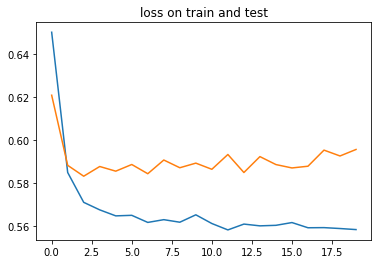

Last loss on train: 0.5581982576214106
Last loss on test: 0.5956223152185741


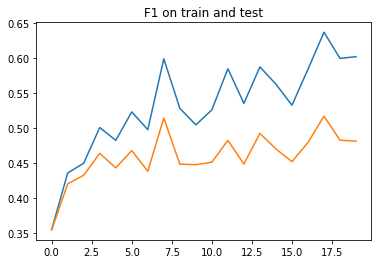

Last F1 on train: 0.6017708415742469
Last F1 on test: 0.48101160047869934


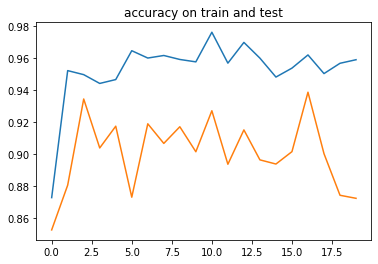

Last accuracy on train: 0.9591764413413748
Last accuracy on test: 0.8723502688502011


In [10]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [11]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8944363711853851


In [12]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O na-B klar-I .-O
ganz-B und-I gar-I nicht-I .-O
es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
na-B gut-I .-O
ich-B weiß-I !-O
na-B schön-I ,-O aber-O als-O jemand-O ,-O dem-O etwas-O an-O dir-O liegt-O ,-O sag-O ich-O dir-O :-O --O du-O hast-O ernste-O probleme-O mit-O männern-O .-O
--O also-B gut-I .-O
--O ich-B weiß-I .-O
--O das-B stimmt-I .-O
--O keine-B ahnung-I .-O
keine-B ahnung-I .-O
keine-B ahnung-I .-O
weiß-B ich-I nicht-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
oh-O nein-O ,-O ist-B schon-I gut-I .-O
--O hör-B auf-I .-O
--O nicht-B wahr-I ?-O
stimmt-B 's-I ,-O herr-O doktor-O ?-O
--O auf-B keinen-I fall-I .-O
was-B sie-I nicht-I sagen-I .-O
--O in-B ordnung-I .-O
ach-B ja-I ?-O
--O ist-B schon-I gut-I .-O
und-B ob-I !-O
--O das-B geht-I nicht-I .-O
--O machst-B du-I witze-I ?-O
das-B geht-I dich-I nichts-I an-I ,-O deutscher-O .-O
--O das-B passt-I .-O
--O in-B der-I tat-I !-O
keine-B ahnung-I .-O
--O das-B stimmt-I nicht-I .-O
wir-O 

# Experiment 4.2
GRU 0 tokens, 1 sentence weights (0.001734, 1, 0.72)

## Data

In [13]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_1_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [14]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [15]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:01, 27.05it/s]

Train loss: 0.8483887990315755


94it [00:03, 25.79it/s]

Train loss: 0.8371877478228675


139it [00:05, 25.62it/s]

Train loss: 0.8518512487411499


184it [00:07, 27.61it/s]

Train loss: 0.8519399368100696


226it [00:08, 25.42it/s]


Train loss: 0.8477196714613173

Evaluating on train...


50it [00:01, 44.06it/s]

Val loss: 0.8513095842467414, Val f1: 0.37760459184646605, Val accuracy: 0.3777777870496114


95it [00:02, 41.47it/s]

Val loss: 0.8615901119179196, Val f1: 0.3627863301171197, Val accuracy: 0.36296297245555453


136it [00:03, 36.71it/s]

Val loss: 0.8504801361649125, Val f1: 0.3726707264229103, Val accuracy: 0.3728395155182591


187it [00:04, 38.90it/s]

Val loss: 0.8386249558793174, Val f1: 0.37391433533695007, Val accuracy: 0.3740740834010972


226it [00:05, 37.96it/s]


Val loss: 0.8424334163135953, Val f1: 0.36872694161203173, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 37.49it/s]

Val loss: 0.8502505580584209, Val f1: 0.33317885001500447, Val accuracy: 0.3333333432674408


36it [00:00, 38.06it/s]

Val loss: 0.8740346650282542, Val f1: 0.3331583102544149, Val accuracy: 0.3333333432674408


52it [00:01, 35.96it/s]

Val loss: 0.859077521165212, Val f1: 0.3627952542569902, Val accuracy: 0.36296297245555453


64it [00:01, 37.15it/s]

Val loss: 0.8612400561571121, Val f1: 0.3664958308140437, Val accuracy: 0.3666666761040688


76it [00:02, 37.52it/s]


Val loss: 0.8601719021797181, Val f1: 0.3598317122459412, Val accuracy: 0.36000000953674316

starting Epoch 1
Training...


48it [00:02, 22.21it/s]

Train loss: 0.8493749340375264


93it [00:03, 25.39it/s]

Train loss: 0.8575083189540439


138it [00:05, 24.77it/s]

Train loss: 0.8450965620853282


183it [00:07, 25.57it/s]

Train loss: 0.8437085502677494


226it [00:08, 25.15it/s]


Train loss: 0.8452984762191772

Evaluating on train...


54it [00:01, 44.37it/s]

Val loss: 0.866364488336775, Val f1: 0.3479693273703257, Val accuracy: 0.34814815786149766


94it [00:02, 42.19it/s]

Val loss: 0.8607222312026553, Val f1: 0.34056996173328824, Val accuracy: 0.34074075056446923


142it [00:03, 38.02it/s]

Val loss: 0.8673963105237043, Val f1: 0.3380950618673254, Val accuracy: 0.3382716147987931


187it [00:04, 40.28it/s]

Val loss: 0.8537486056486766, Val f1: 0.35168464018238915, Val accuracy: 0.3518518615100119


226it [00:05, 40.86it/s]


Val loss: 0.8448452422353956, Val f1: 0.3479885254965888, Val accuracy: 0.34814815786149766

Evaluating on test...


21it [00:00, 39.33it/s]

Val loss: 0.8489308834075928, Val f1: 0.3776054004828135, Val accuracy: 0.3777777870496114


34it [00:00, 39.62it/s]

Val loss: 0.8523592631022135, Val f1: 0.3553851624329885, Val accuracy: 0.3555555651585261


53it [00:01, 40.12it/s]

Val loss: 0.8419106443723042, Val f1: 0.36280003256267973, Val accuracy: 0.36296297245555453


68it [00:01, 40.58it/s]

Val loss: 0.8485209772984187, Val f1: 0.36649964898824694, Val accuracy: 0.3666666761040688


76it [00:01, 39.87it/s]


Val loss: 0.8526709326108297, Val f1: 0.3598293586572011, Val accuracy: 0.36000000953674316

starting Epoch 2
Training...


47it [00:01, 25.89it/s]

Train loss: 0.8639839477009243


95it [00:03, 25.91it/s]

Train loss: 0.8459168354670207


140it [00:05, 26.73it/s]

Train loss: 0.8385538697242737


185it [00:07, 26.57it/s]

Train loss: 0.8492651972505781


226it [00:08, 25.48it/s]


Train loss: 0.8462344670295715

Evaluating on train...


50it [00:01, 43.89it/s]

Val loss: 0.8182595703336928, Val f1: 0.362824194961124, Val accuracy: 0.36296297245555453


95it [00:02, 40.57it/s]

Val loss: 0.8334659463829465, Val f1: 0.36281180216206443, Val accuracy: 0.36296297245555453


140it [00:03, 41.08it/s]

Val loss: 0.8430341495407953, Val f1: 0.3677381926112705, Val accuracy: 0.3679012439869068


185it [00:04, 40.21it/s]

Val loss: 0.8391798002852334, Val f1: 0.3776169472270542, Val accuracy: 0.3777777870496114


226it [00:05, 41.13it/s]


Val loss: 0.843755825360616, Val f1: 0.3716890362898509, Val accuracy: 0.37185186121198865

Evaluating on test...


21it [00:00, 38.40it/s]

Val loss: 0.8571789145469666, Val f1: 0.3775985101858775, Val accuracy: 0.3777777870496114


38it [00:00, 38.77it/s]

Val loss: 0.8229186455408732, Val f1: 0.3998466283082962, Val accuracy: 0.4000000089406967


51it [00:01, 39.57it/s]

Val loss: 0.8453896297348871, Val f1: 0.3776094694932302, Val accuracy: 0.3777777870496114


64it [00:01, 39.22it/s]

Val loss: 0.8401003132263819, Val f1: 0.37761546224355697, Val accuracy: 0.3777777870496114


76it [00:01, 39.19it/s]


Val loss: 0.8531528615951538, Val f1: 0.36871763308842975, Val accuracy: 0.3688888982931773

starting Epoch 3
Training...


48it [00:01, 24.60it/s]

Train loss: 0.8631620605786642


93it [00:03, 26.35it/s]

Train loss: 0.8713330129782358


138it [00:05, 24.58it/s]

Train loss: 0.8600971659024557


183it [00:07, 26.45it/s]

Train loss: 0.8542307840453254


226it [00:08, 25.49it/s]


Train loss: 0.8437584527333577

Evaluating on train...


50it [00:01, 43.82it/s]

Val loss: 0.8508711682425605, Val f1: 0.3776064442263709, Val accuracy: 0.3777777870496114


95it [00:02, 42.16it/s]

Val loss: 0.8447363807095422, Val f1: 0.355393957429462, Val accuracy: 0.3555555651585261


140it [00:03, 40.86it/s]

Val loss: 0.8429552563914546, Val f1: 0.36280194807935645, Val accuracy: 0.36296297245555453


187it [00:04, 38.14it/s]

Val loss: 0.8430871360831791, Val f1: 0.36280367390977014, Val accuracy: 0.36296297245555453


226it [00:05, 40.61it/s]


Val loss: 0.8455473740895589, Val f1: 0.3628017422888014, Val accuracy: 0.36296297245555453

Evaluating on test...


21it [00:00, 38.28it/s]

Val loss: 0.863296103477478, Val f1: 0.3775939742724101, Val accuracy: 0.3777777870496114


35it [00:00, 39.67it/s]

Val loss: 0.8340652128060658, Val f1: 0.355400350689888, Val accuracy: 0.3555555651585261


51it [00:01, 38.28it/s]

Val loss: 0.8542775101131863, Val f1: 0.34797828065024483, Val accuracy: 0.34814815786149766


67it [00:01, 36.46it/s]

Val loss: 0.8692609469095866, Val f1: 0.3442638054490089, Val accuracy: 0.3444444542129835


76it [00:01, 38.12it/s]


Val loss: 0.8562379296620687, Val f1: 0.35093967517217, Val accuracy: 0.35111112078030904

starting Epoch 4
Training...


48it [00:01, 22.63it/s]

Train loss: 0.8444081001811558


93it [00:03, 26.59it/s]

Train loss: 0.828353386455112


138it [00:05, 26.09it/s]

Train loss: 0.8452606850200229


183it [00:07, 26.59it/s]

Train loss: 0.8465572075711356


226it [00:08, 25.67it/s]


Train loss: 0.8431497830814786

Evaluating on train...


49it [00:01, 43.95it/s]

Val loss: 0.8626268532541063, Val f1: 0.37759488026301063, Val accuracy: 0.3777777870496114


94it [00:02, 41.51it/s]

Val loss: 0.8546483119328817, Val f1: 0.37760310570398964, Val accuracy: 0.3777777870496114


141it [00:03, 39.78it/s]

Val loss: 0.8384040894331756, Val f1: 0.3776165871708481, Val accuracy: 0.3777777870496114


184it [00:04, 37.82it/s]

Val loss: 0.8470091157489352, Val f1: 0.3665007948875427, Val accuracy: 0.3666666761040688


226it [00:05, 40.19it/s]


Val loss: 0.8433442605866326, Val f1: 0.35983828955226477, Val accuracy: 0.36000000953674316

Evaluating on test...


19it [00:00, 40.23it/s]

Val loss: 0.8400688727696737, Val f1: 0.37761343916257223, Val accuracy: 0.3777777870496114


34it [00:00, 40.00it/s]

Val loss: 0.8607587258021037, Val f1: 0.37759341994921364, Val accuracy: 0.3777777870496114


51it [00:01, 39.37it/s]

Val loss: 0.8560797386699253, Val f1: 0.3627829280164507, Val accuracy: 0.36296297245555453


67it [00:01, 38.75it/s]

Val loss: 0.8590307374795277, Val f1: 0.35537735869487125, Val accuracy: 0.3555555651585261


76it [00:01, 39.44it/s]


Val loss: 0.8538694349924724, Val f1: 0.350937469402949, Val accuracy: 0.35111112078030904

starting Epoch 5
Training...


48it [00:01, 26.50it/s]

Train loss: 0.8554090513123407


93it [00:03, 26.19it/s]

Train loss: 0.8459013746844397


138it [00:05, 24.30it/s]

Train loss: 0.8438472513799314


183it [00:07, 25.88it/s]

Train loss: 0.8475010355313619


226it [00:08, 25.53it/s]


Train loss: 0.8479095729192098

Evaluating on train...


49it [00:01, 41.00it/s]

Val loss: 0.8442999720573425, Val f1: 0.3479866663614909, Val accuracy: 0.34814815786149766


94it [00:02, 39.12it/s]

Val loss: 0.8526153941949208, Val f1: 0.34798057079315187, Val accuracy: 0.34814815786149766


142it [00:03, 39.62it/s]

Val loss: 0.8486454076237149, Val f1: 0.34798371350323715, Val accuracy: 0.34814815786149766


184it [00:04, 38.53it/s]

Val loss: 0.8487050228648716, Val f1: 0.3516875879632102, Val accuracy: 0.3518518615100119


226it [00:05, 39.71it/s]


Val loss: 0.8464551923010084, Val f1: 0.35391103506088256, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 38.07it/s]

Val loss: 0.818452513217926, Val f1: 0.3776336709658305, Val accuracy: 0.3777777870496114


32it [00:00, 37.83it/s]

Val loss: 0.8460505624612172, Val f1: 0.3553933411836624, Val accuracy: 0.3555555651585261


52it [00:01, 29.21it/s]

Val loss: 0.8525498840543959, Val f1: 0.34798510670661925, Val accuracy: 0.34814815786149766


64it [00:02, 33.35it/s]

Val loss: 0.847163662314415, Val f1: 0.35539626081784564, Val accuracy: 0.3555555651585261


76it [00:02, 31.76it/s]


Val loss: 0.8545743775367737, Val f1: 0.35094451705614726, Val accuracy: 0.35111112078030904

starting Epoch 6
Training...


48it [00:02, 24.49it/s]

Train loss: 0.8739052070511713


93it [00:03, 24.78it/s]

Train loss: 0.8644029418627421


138it [00:05, 25.84it/s]

Train loss: 0.8467362960179646


183it [00:07, 26.86it/s]

Train loss: 0.841952113310496


226it [00:08, 25.29it/s]


Train loss: 0.8466014965375265

Evaluating on train...


53it [00:01, 42.01it/s]

Val loss: 0.8608859803941514, Val f1: 0.351675370004442, Val accuracy: 0.3518518613444434


98it [00:02, 41.44it/s]

Val loss: 0.845580079820421, Val f1: 0.34983769522772895, Val accuracy: 0.35000000960297056


143it [00:03, 41.41it/s]

Val loss: 0.841039507035856, Val f1: 0.3541599293549856, Val accuracy: 0.35431931636951586


186it [00:04, 38.64it/s]

Val loss: 0.8470467252863778, Val f1: 0.34891101171573, Val accuracy: 0.3490728230939971


226it [00:05, 40.40it/s]


Val loss: 0.8454625958866543, Val f1: 0.3457639226648543, Val accuracy: 0.34592455320888094

Evaluating on test...


20it [00:00, 38.46it/s]

Val loss: 0.8509030858675639, Val f1: 0.33317744731903076, Val accuracy: 0.3333333432674408


37it [00:00, 37.30it/s]

Val loss: 0.8517727295557658, Val f1: 0.4220450222492218, Val accuracy: 0.422222230831782


49it [00:01, 38.33it/s]

Val loss: 0.8536769655015733, Val f1: 0.39241717523998687, Val accuracy: 0.39259260164366827


65it [00:01, 34.98it/s]

Val loss: 0.855535380045573, Val f1: 0.3887128864725431, Val accuracy: 0.3888888979951541


76it [00:02, 36.93it/s]


Val loss: 0.8555779163042704, Val f1: 0.37760481119155886, Val accuracy: 0.3777777870496114

starting Epoch 7
Training...


47it [00:01, 25.15it/s]

Train loss: 0.8568708591991001


94it [00:03, 26.49it/s]

Train loss: 0.8680988046858046


139it [00:05, 21.67it/s]

Train loss: 0.8611061431743481


184it [00:07, 25.74it/s]

Train loss: 0.8559364010890325


226it [00:08, 25.32it/s]


Train loss: 0.8485204158888923

Evaluating on train...


53it [00:01, 42.86it/s]

Val loss: 0.8224456045362685, Val f1: 0.3628198822339376, Val accuracy: 0.36296297245555453


93it [00:02, 41.43it/s]

Val loss: 0.8453780876265632, Val f1: 0.36279891596900093, Val accuracy: 0.36296297245555453


140it [00:03, 38.70it/s]

Val loss: 0.8402109230006183, Val f1: 0.3578667978445689, Val accuracy: 0.35802470092420224


186it [00:04, 40.19it/s]

Val loss: 0.8387077079878913, Val f1: 0.36280558274851904, Val accuracy: 0.36296297245555453


226it [00:05, 40.51it/s]


Val loss: 0.8432225886980692, Val f1: 0.3657653209898207, Val accuracy: 0.3659259353743659

Evaluating on test...


21it [00:00, 39.30it/s]

Val loss: 0.8379083712895711, Val f1: 0.42205678423245746, Val accuracy: 0.422222230831782


38it [00:00, 38.78it/s]

Val loss: 0.833264148235321, Val f1: 0.37762344380219776, Val accuracy: 0.3777777870496114


51it [00:01, 39.81it/s]

Val loss: 0.8540689667065938, Val f1: 0.3627936349974738, Val accuracy: 0.36296297245555453


64it [00:01, 38.57it/s]

Val loss: 0.8583335290352504, Val f1: 0.35538480132818223, Val accuracy: 0.3555555651585261


76it [00:01, 38.63it/s]


Val loss: 0.8616913755734762, Val f1: 0.3509383265177409, Val accuracy: 0.35111112078030904

starting Epoch 8
Training...


47it [00:01, 26.78it/s]

Train loss: 0.8482773608631557


92it [00:03, 25.10it/s]

Train loss: 0.8508192724651761


140it [00:05, 24.90it/s]

Train loss: 0.8471359332402547


185it [00:07, 26.16it/s]

Train loss: 0.8401494536134931


226it [00:08, 25.33it/s]


Train loss: 0.8466257336404589

Evaluating on train...


50it [00:01, 41.17it/s]

Val loss: 0.8756697244114346, Val f1: 0.34796632991896737, Val accuracy: 0.34814815786149766


95it [00:02, 41.65it/s]

Val loss: 0.8630595114496019, Val f1: 0.34056909845934974, Val accuracy: 0.34074075056446923


143it [00:03, 40.50it/s]

Val loss: 0.8540784500263355, Val f1: 0.3430410071655556, Val accuracy: 0.3432098863301454


184it [00:04, 36.83it/s]

Val loss: 0.8446737481488122, Val f1: 0.3553939698470963, Val accuracy: 0.3555555651585261


226it [00:05, 39.92it/s]


Val loss: 0.8463957736227248, Val f1: 0.35390997767448423, Val accuracy: 0.3540740836991204

Evaluating on test...


19it [00:00, 39.48it/s]

Val loss: 0.9184304157892863, Val f1: 0.33310528794924416, Val accuracy: 0.3333333432674408


36it [00:00, 39.15it/s]

Val loss: 0.8921671946843465, Val f1: 0.33313214580218, Val accuracy: 0.3333333432674408


53it [00:01, 40.10it/s]

Val loss: 0.8667154921425714, Val f1: 0.34796737101342945, Val accuracy: 0.34814815786149766


66it [00:01, 38.46it/s]

Val loss: 0.8706275423367819, Val f1: 0.3553671032190323, Val accuracy: 0.3555555651585261


76it [00:01, 39.36it/s]


Val loss: 0.8536705597241719, Val f1: 0.37760244210561117, Val accuracy: 0.3777777870496114

starting Epoch 9
Training...


49it [00:01, 26.04it/s]

Train loss: 0.8478617654906379


94it [00:03, 26.48it/s]

Train loss: 0.8477082663112216


140it [00:05, 26.61it/s]

Train loss: 0.8423066130390874


185it [00:07, 24.90it/s]

Train loss: 0.8523569835556878


226it [00:08, 25.62it/s]


Train loss: 0.8475953144497341

Evaluating on train...


50it [00:01, 43.43it/s]

Val loss: 0.8422593884997898, Val f1: 0.36280424528651767, Val accuracy: 0.36296297245555453


95it [00:02, 40.42it/s]

Val loss: 0.8448634015189277, Val f1: 0.3628004299269782, Val accuracy: 0.36296297245555453


140it [00:03, 39.61it/s]

Val loss: 0.8474441810890481, Val f1: 0.3627972991378219, Val accuracy: 0.36296297245555453


187it [00:04, 39.21it/s]

Val loss: 0.8427565097808838, Val f1: 0.36650357262955774, Val accuracy: 0.3666666761040688


226it [00:05, 40.75it/s]


Val loss: 0.8422576040691799, Val f1: 0.3598379001352522, Val accuracy: 0.36000000953674316

Evaluating on test...


22it [00:00, 37.74it/s]

Val loss: 0.7972044348716736, Val f1: 0.42209250132242837, Val accuracy: 0.422222230831782


34it [00:00, 37.78it/s]

Val loss: 0.8055595358212789, Val f1: 0.3776454309622447, Val accuracy: 0.3777777870496114


50it [00:01, 37.75it/s]

Val loss: 0.8206145935588413, Val f1: 0.36282128691673277, Val accuracy: 0.36296297245555453


66it [00:01, 38.36it/s]

Val loss: 0.8325447718302409, Val f1: 0.36651046325763065, Val accuracy: 0.3666666761040688


76it [00:02, 37.82it/s]


Val loss: 0.8468868144353231, Val f1: 0.35983267466227215, Val accuracy: 0.36000000953674316

starting Epoch 10
Training...


49it [00:02, 23.32it/s]

Train loss: 0.84165833791097


94it [00:03, 26.32it/s]

Train loss: 0.8488032990031772


139it [00:05, 23.10it/s]

Train loss: 0.8456497121740271


184it [00:07, 25.77it/s]

Train loss: 0.8462116337484784


226it [00:09, 24.99it/s]


Train loss: 0.8464326061142815

Evaluating on train...


50it [00:01, 43.05it/s]

Val loss: 0.8488726867569818, Val f1: 0.347988263103697, Val accuracy: 0.34814815786149766


95it [00:02, 41.59it/s]

Val loss: 0.8577185928821563, Val f1: 0.34797898862097, Val accuracy: 0.34814815786149766


140it [00:03, 40.28it/s]

Val loss: 0.8529135739361798, Val f1: 0.352921520780634, Val accuracy: 0.35308642939284995


185it [00:04, 39.68it/s]

Val loss: 0.8472382174597846, Val f1: 0.35909644696447585, Val accuracy: 0.35925926880704034


226it [00:05, 40.82it/s]


Val loss: 0.8434237302674188, Val f1: 0.36576499806510077, Val accuracy: 0.3659259353743659

Evaluating on test...


22it [00:00, 39.50it/s]

Val loss: 0.8133431990941365, Val f1: 0.3776336371898651, Val accuracy: 0.3777777870496114


34it [00:00, 38.43it/s]

Val loss: 0.8149450480937958, Val f1: 0.3776384502649307, Val accuracy: 0.3777777870496114


50it [00:01, 38.47it/s]

Val loss: 0.8297317372428046, Val f1: 0.3628150953186883, Val accuracy: 0.36296297245555453


67it [00:01, 38.52it/s]

Val loss: 0.8381873448689778, Val f1: 0.3665119687716166, Val accuracy: 0.3666666761040688


76it [00:01, 38.69it/s]


Val loss: 0.8508562064170837, Val f1: 0.36872432231903074, Val accuracy: 0.3688888982931773

starting Epoch 11
Training...


48it [00:01, 26.82it/s]

Train loss: 0.85392251279619


93it [00:03, 17.65it/s]

Train loss: 0.8675883160697089


138it [00:05, 25.90it/s]

Train loss: 0.8614436763304251


183it [00:07, 25.40it/s]

Train loss: 0.8543986562225554


226it [00:09, 24.64it/s]


Train loss: 0.8496870769394769

Evaluating on train...


49it [00:01, 41.77it/s]

Val loss: 0.864457552962833, Val f1: 0.3479726175467173, Val accuracy: 0.34814815786149766


94it [00:02, 41.47it/s]

Val loss: 0.8512232734097375, Val f1: 0.34798424277040696, Val accuracy: 0.34814815786149766


142it [00:03, 39.79it/s]

Val loss: 0.8498265151624327, Val f1: 0.35292237974979257, Val accuracy: 0.35308642939284995


186it [00:04, 39.46it/s]

Val loss: 0.8484503510925505, Val f1: 0.35539255241552986, Val accuracy: 0.3555555651585261


226it [00:05, 40.23it/s]


Val loss: 0.847687631977929, Val f1: 0.3628001064724392, Val accuracy: 0.36296297245555453

Evaluating on test...


21it [00:00, 37.49it/s]

Val loss: 0.872157613436381, Val f1: 0.33315977454185486, Val accuracy: 0.3333333432674408


37it [00:00, 38.34it/s]

Val loss: 0.862139223019282, Val f1: 0.37760223845640817, Val accuracy: 0.3777777870496114


49it [00:01, 38.51it/s]

Val loss: 0.8821387847264608, Val f1: 0.3627715057796902, Val accuracy: 0.36296297245555453


65it [00:01, 37.98it/s]

Val loss: 0.8697622716426849, Val f1: 0.3775959129134814, Val accuracy: 0.3777777870496114


76it [00:01, 38.13it/s]


Val loss: 0.8615491080284119, Val f1: 0.38649114966392517, Val accuracy: 0.3866666758060455

starting Epoch 12
Training...


48it [00:01, 24.37it/s]

Train loss: 0.8277929027875265


93it [00:03, 25.71it/s]

Train loss: 0.8275643229484558


138it [00:05, 25.42it/s]

Train loss: 0.8293688310517205


183it [00:07, 26.36it/s]

Train loss: 0.8408088707261615


226it [00:08, 25.23it/s]


Train loss: 0.8440038590961032

Evaluating on train...


50it [00:01, 41.19it/s]

Val loss: 0.8334774255752564, Val f1: 0.34799641172091167, Val accuracy: 0.34814815786149766


95it [00:02, 41.59it/s]

Val loss: 0.8481322566668192, Val f1: 0.34798183606730565, Val accuracy: 0.34814815786149766


140it [00:03, 41.03it/s]

Val loss: 0.8549858530362447, Val f1: 0.352915084582788, Val accuracy: 0.35308642939284995


185it [00:04, 40.07it/s]

Val loss: 0.8448238260216183, Val f1: 0.3590955722663138, Val accuracy: 0.35925926880704034


226it [00:05, 40.61it/s]


Val loss: 0.8423537113931444, Val f1: 0.3598380818631914, Val accuracy: 0.36000000953674316

Evaluating on test...


23it [00:00, 41.08it/s]

Val loss: 0.7949122389157613, Val f1: 0.37765388886133827, Val accuracy: 0.3777777870496114


38it [00:00, 40.85it/s]

Val loss: 0.8489452679951985, Val f1: 0.35538724561532337, Val accuracy: 0.3555555651585261


53it [00:01, 40.37it/s]

Val loss: 0.8261153565512763, Val f1: 0.362812289264467, Val accuracy: 0.36296297245555453


67it [00:01, 39.74it/s]

Val loss: 0.8583805908759435, Val f1: 0.35537562022606534, Val accuracy: 0.3555555651585261


76it [00:01, 39.94it/s]


Val loss: 0.8557424863179525, Val f1: 0.35093664288520815, Val accuracy: 0.35111112078030904

starting Epoch 13
Training...


48it [00:02, 23.37it/s]

Train loss: 0.8329087906413608


93it [00:03, 26.48it/s]

Train loss: 0.8460546924008263


138it [00:05, 26.91it/s]

Train loss: 0.8464938834861473


183it [00:07, 25.33it/s]

Train loss: 0.8452459769116507


226it [00:08, 25.28it/s]


Train loss: 0.8464101229773627

Evaluating on train...


54it [00:01, 43.87it/s]

Val loss: 0.8595485435591803, Val f1: 0.3775993956459893, Val accuracy: 0.3777777870496114


94it [00:02, 42.41it/s]

Val loss: 0.843334788746304, Val f1: 0.38502214385403527, Val accuracy: 0.38518519434663984


143it [00:03, 39.42it/s]

Val loss: 0.8531238012843662, Val f1: 0.3726710012665501, Val accuracy: 0.3728395155182591


187it [00:04, 38.51it/s]

Val loss: 0.8501370320717494, Val f1: 0.362796807454692, Val accuracy: 0.36296297245555453


226it [00:05, 40.14it/s]


Val loss: 0.8440351695484585, Val f1: 0.35983897156185574, Val accuracy: 0.36000000953674316

Evaluating on test...


21it [00:00, 38.95it/s]

Val loss: 0.884571639696757, Val f1: 0.33313754995663963, Val accuracy: 0.3333333432674408


37it [00:00, 37.30it/s]

Val loss: 0.8661761422952016, Val f1: 0.3553785741329193, Val accuracy: 0.3555555651585261


50it [00:01, 37.81it/s]

Val loss: 0.8428588509559631, Val f1: 0.3479912181695302, Val accuracy: 0.34814815786149766


68it [00:01, 39.28it/s]

Val loss: 0.8471506237983704, Val f1: 0.36650344679752983, Val accuracy: 0.3666666761040688


76it [00:01, 38.60it/s]


Val loss: 0.8500404032071431, Val f1: 0.3598340833187103, Val accuracy: 0.36000000953674316

starting Epoch 14
Training...


49it [00:01, 27.39it/s]

Train loss: 0.854718185795678


95it [00:03, 25.69it/s]

Train loss: 0.8335587097538842


140it [00:05, 24.33it/s]

Train loss: 0.819860413339403


185it [00:07, 25.62it/s]

Train loss: 0.7972543951537874


226it [00:08, 25.38it/s]


Train loss: 0.7719040960735745

Evaluating on train...


50it [00:01, 42.98it/s]

Val loss: 0.6579721106423272, Val f1: 0.39028551909658643, Val accuracy: 0.7925126426749759


95it [00:02, 41.81it/s]

Val loss: 0.6593402564525604, Val f1: 0.38816772600015004, Val accuracy: 0.7720313237773048


140it [00:03, 39.67it/s]

Val loss: 0.6668523302784672, Val f1: 0.3863520895993268, Val accuracy: 0.7499136202865176


185it [00:04, 37.90it/s]

Val loss: 0.667844796511862, Val f1: 0.3854722034600046, Val accuracy: 0.7472766430841552


226it [00:05, 40.31it/s]


Val loss: 0.6695464136865404, Val f1: 0.3851538606484731, Val accuracy: 0.7438872055212656

Evaluating on test...


20it [00:00, 37.82it/s]

Val loss: 0.7009186307589214, Val f1: 0.3942921678225199, Val accuracy: 0.7319570660591126


36it [00:00, 36.56it/s]

Val loss: 0.695915138721466, Val f1: 0.3823949595292409, Val accuracy: 0.7091926713784535


52it [00:01, 37.47it/s]

Val loss: 0.6867169486151801, Val f1: 0.3829829043812222, Val accuracy: 0.7216561118761698


65it [00:01, 38.85it/s]

Val loss: 0.6925310124953588, Val f1: 0.3800639589627584, Val accuracy: 0.705935322244962


76it [00:01, 38.07it/s]


Val loss: 0.6948367317517599, Val f1: 0.3791343609491984, Val accuracy: 0.7087253681818644

starting Epoch 15
Training...


50it [00:02, 24.72it/s]

Train loss: 0.6421189890967475


95it [00:03, 26.16it/s]

Train loss: 0.6352081225978004


140it [00:05, 26.13it/s]

Train loss: 0.6305597234655309


185it [00:07, 26.12it/s]

Train loss: 0.6240204923682743


226it [00:08, 25.22it/s]


Train loss: 0.6206481170654297

Evaluating on train...


52it [00:01, 43.01it/s]

Val loss: 0.5862748040093316, Val f1: 0.3884332829051548, Val accuracy: 0.9440777036878798


97it [00:02, 39.00it/s]

Val loss: 0.5877381404240926, Val f1: 0.3829595065779156, Val accuracy: 0.9251809371842279


141it [00:03, 39.38it/s]

Val loss: 0.5880313215432343, Val f1: 0.38105424245198566, Val accuracy: 0.919765689417168


184it [00:04, 38.12it/s]

Val loss: 0.5905432350105709, Val f1: 0.3796089470386505, Val accuracy: 0.9120916672878795


226it [00:05, 39.80it/s]


Val loss: 0.5927685864766439, Val f1: 0.3777038786146376, Val accuracy: 0.9086467001173232

Evaluating on test...


21it [00:00, 38.12it/s]

Val loss: 0.597903863588969, Val f1: 0.37674736777941387, Val accuracy: 0.9325880487759908


34it [00:00, 38.06it/s]

Val loss: 0.6003556688626607, Val f1: 0.3759380280971527, Val accuracy: 0.9331635653972625


50it [00:01, 37.94it/s]

Val loss: 0.603078215652042, Val f1: 0.3730821271737417, Val accuracy: 0.911974494987064


66it [00:01, 37.24it/s]

Val loss: 0.6043522159258524, Val f1: 0.3737998773654302, Val accuracy: 0.9116921037435531


76it [00:02, 37.85it/s]


Val loss: 0.6054073405265809, Val f1: 0.3749859404563904, Val accuracy: 0.9075904317696889

starting Epoch 16
Training...


47it [00:01, 23.47it/s]

Train loss: 0.5979357017411127


93it [00:03, 24.92it/s]

Train loss: 0.5914845459991032


138it [00:05, 25.46it/s]

Train loss: 0.5871268422515304


183it [00:07, 25.69it/s]

Train loss: 0.5853200495243073


226it [00:09, 24.31it/s]


Train loss: 0.5861729547712538

Evaluating on train...


50it [00:01, 43.14it/s]

Val loss: 0.5735905369122823, Val f1: 0.4363456600242191, Val accuracy: 0.943752814663781


95it [00:02, 41.61it/s]

Val loss: 0.5697693520122105, Val f1: 0.4386068205038706, Val accuracy: 0.9487141360839207


140it [00:03, 40.86it/s]

Val loss: 0.5739290599469785, Val f1: 0.43754919480394433, Val accuracy: 0.9445578089466802


187it [00:04, 37.84it/s]

Val loss: 0.5749520728985469, Val f1: 0.43650631093316605, Val accuracy: 0.9482518987523185


226it [00:05, 40.17it/s]


Val loss: 0.5727673678927951, Val f1: 0.43666800419489543, Val accuracy: 0.9527469011147817

Evaluating on test...


23it [00:00, 40.55it/s]

Val loss: 0.5885293165842692, Val f1: 0.4175388713677724, Val accuracy: 0.8974369923273723


33it [00:00, 40.49it/s]

Val loss: 0.6002349356810252, Val f1: 0.41653510530789695, Val accuracy: 0.8780836800734202


50it [00:01, 38.11it/s]

Val loss: 0.5935445692804124, Val f1: 0.4152477052476671, Val accuracy: 0.8897488839096493


68it [00:01, 39.42it/s]

Val loss: 0.5943805028994879, Val f1: 0.41772630363702773, Val accuracy: 0.8918632820248604


76it [00:01, 39.14it/s]


Val loss: 0.5924330751101176, Val f1: 0.4185873520374298, Val accuracy: 0.8948170173168183

starting Epoch 17
Training...


48it [00:01, 26.64it/s]

Train loss: 0.5804242889086405


93it [00:03, 24.22it/s]

Train loss: 0.5764456854926215


138it [00:05, 25.35it/s]

Train loss: 0.5742854935151559


183it [00:07, 26.69it/s]

Train loss: 0.5732912749052048


226it [00:08, 25.34it/s]


Train loss: 0.5736098289489746

Evaluating on train...


50it [00:01, 42.51it/s]

Val loss: 0.5675961918301052, Val f1: 0.4848737921979692, Val accuracy: 0.9434565345446269


95it [00:02, 42.05it/s]

Val loss: 0.5692801515261332, Val f1: 0.49997266166739995, Val accuracy: 0.9444350669781367


142it [00:03, 37.53it/s]

Val loss: 0.5712988826963636, Val f1: 0.4977242352785888, Val accuracy: 0.9379640890492333


187it [00:04, 38.42it/s]

Val loss: 0.5706413156456418, Val f1: 0.49726586755779056, Val accuracy: 0.9384466085169051


226it [00:05, 40.43it/s]


Val loss: 0.5695521630181206, Val f1: 0.4980825648042891, Val accuracy: 0.9376871144771576

Evaluating on test...


21it [00:00, 38.22it/s]

Val loss: 0.5936938365300496, Val f1: 0.45035773317019145, Val accuracy: 0.8855441768964132


37it [00:00, 37.42it/s]

Val loss: 0.5948280175526937, Val f1: 0.4614670991897583, Val accuracy: 0.8984300712744395


49it [00:01, 36.06it/s]

Val loss: 0.5973068171077305, Val f1: 0.46448885864681666, Val accuracy: 0.8853247377607557


65it [00:01, 36.98it/s]

Val loss: 0.5998844931523005, Val f1: 0.46830567965904873, Val accuracy: 0.8857051630814871


76it [00:02, 37.60it/s]


Val loss: 0.5980978663762411, Val f1: 0.4680236073335012, Val accuracy: 0.8719062868754069

starting Epoch 18
Training...


50it [00:01, 26.96it/s]

Train loss: 0.570360885726081


92it [00:03, 25.28it/s]

Train loss: 0.5707067847251892


137it [00:05, 25.24it/s]

Train loss: 0.569890930476012


185it [00:07, 24.47it/s]

Train loss: 0.5674713929494222


226it [00:08, 25.40it/s]


Train loss: 0.5691859147283767

Evaluating on train...


54it [00:01, 42.98it/s]

Val loss: 0.5632346100277371, Val f1: 0.472724715868632, Val accuracy: 0.9741828812493218


94it [00:02, 41.85it/s]

Val loss: 0.5636273629135555, Val f1: 0.4625248630841573, Val accuracy: 0.9581587612628937


142it [00:03, 39.51it/s]

Val loss: 0.5650244315465291, Val f1: 0.4608909609141173, Val accuracy: 0.9580154900197629


185it [00:04, 38.65it/s]

Val loss: 0.5651773869991302, Val f1: 0.4667630947298474, Val accuracy: 0.9644754452837838


226it [00:05, 40.31it/s]


Val loss: 0.5651896074083116, Val f1: 0.4649873060650296, Val accuracy: 0.9623972773551941

Evaluating on test...


20it [00:00, 37.71it/s]

Val loss: 0.5834382017453511, Val f1: 0.438252717256546, Val accuracy: 0.9547871549924215


38it [00:00, 39.35it/s]

Val loss: 0.5821981926759084, Val f1: 0.4360175291697184, Val accuracy: 0.9552494347095489


50it [00:01, 37.90it/s]

Val loss: 0.5790694912274679, Val f1: 0.43829992016156516, Val accuracy: 0.9315619415707058


66it [00:01, 36.14it/s]

Val loss: 0.5834631750981013, Val f1: 0.4374410629272461, Val accuracy: 0.9295122543970744


76it [00:02, 37.82it/s]


Val loss: 0.585662445227305, Val f1: 0.43612462719281514, Val accuracy: 0.9229407167434692

starting Epoch 19
Training...


48it [00:01, 25.80it/s]

Train loss: 0.5646194259325663


93it [00:03, 25.04it/s]

Train loss: 0.5670211659537421


138it [00:05, 25.17it/s]

Train loss: 0.5655887175489355


184it [00:07, 27.04it/s]

Train loss: 0.5675762878523932


226it [00:09, 25.10it/s]


Train loss: 0.5669602947764927

Evaluating on train...


49it [00:01, 42.01it/s]

Val loss: 0.5756771021419101, Val f1: 0.48453244434462656, Val accuracy: 0.935054377052519


94it [00:02, 41.44it/s]

Val loss: 0.5675070418251885, Val f1: 0.48838211960262723, Val accuracy: 0.948495328757498


140it [00:03, 39.76it/s]

Val loss: 0.5656591419820433, Val f1: 0.4873268513767808, Val accuracy: 0.9404419108673379


184it [00:04, 37.60it/s]

Val loss: 0.5661206199063196, Val f1: 0.49200020035107933, Val accuracy: 0.9453929838207032


226it [00:05, 39.59it/s]


Val loss: 0.5656564757559035, Val f1: 0.48955603890948823, Val accuracy: 0.9440066085921394

Evaluating on test...


20it [00:00, 37.34it/s]

Val loss: 0.5990377346674601, Val f1: 0.46557742953300474, Val accuracy: 0.8611502508322398


36it [00:00, 37.09it/s]

Val loss: 0.5925532599290212, Val f1: 0.4573028196891149, Val accuracy: 0.8833630432685217


49it [00:01, 37.41it/s]

Val loss: 0.587292840745714, Val f1: 0.4527702265315586, Val accuracy: 0.8952549848291609


65it [00:01, 38.46it/s]

Val loss: 0.5894590546687444, Val f1: 0.45011738886435826, Val accuracy: 0.8808688874046008


76it [00:02, 37.75it/s]

Val loss: 0.5883220632870992, Val f1: 0.4492551891009013, Val accuracy: 0.8757986390590667


## Graphics

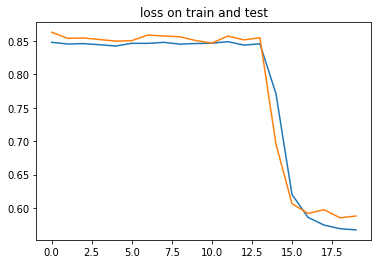

Last loss on train: 0.5672781815571067
Last loss on test: 0.5880601798233233


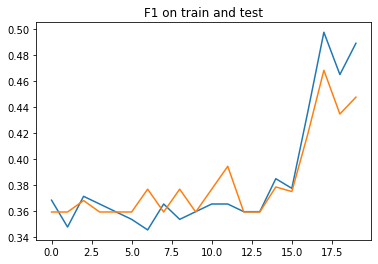

Last F1 on train: 0.48908659169631724
Last F1 on test: 0.44769195153525


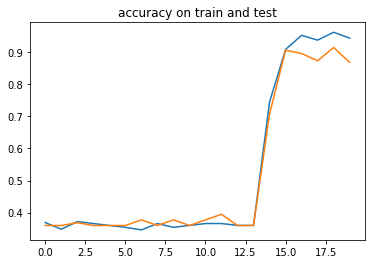

Last accuracy on train: 0.9442435189158516
Last accuracy on test: 0.868585688503165


In [16]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [17]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8526053560307245


In [18]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

auf-B keinen-I fall-I .-O
darum-B geht-I es-I nicht-I .-O
ich-B verstehe-I .-O
--O hör-B auf-I !-O
wenn-O uns-O ein-O abwehrmechanismus-O durch-O schlechte-O zeiten-O hilft-O ,-O na-B und-I ?-O
oh-O ,-O ich-B bin-I draußen-I .-O
--O ach-B ja-I ?-O
ist-B schon-I ok-I .-O
--O hör-B auf-I .-O
--O keine-B ahnung-I .-O
--O ich-B bin-I dabei-I .-O
--O keine-B ahnung-I .-O
--O ich-B auf-I jeden-I fall-I .-O
damit-O ist-O das-O mädchen-O erwürgt-O worden-O stimmt-B 's-I ,-O martin-O ?-O
--O mit-B vergnügen-I .-O
mir-B auch-I recht-I .-O
--O keine-B ahnung-I .-O
das-B geht-I gar-I nicht-I .-O
ach-B so-I ,-O ja-O ...-O nein-O .-O
--O so-B sei-I es-I !-O
nein-O ,-O es-B geht-I nicht-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
ich-B verstehe-I .-O
--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
--O das-B stimmt-I nicht-I .-O
ja-O ,-O das-B stimmt-I ,-O aber-O irgendwann-O werd-O ich-O ihn-O mal-O auswechseln-O lass

# Experiment 4.3
GRU 0 tokens, 2 sentences weights (0.001734, 1, 0.72)

## Data

In [19]:
data_tokenized, targets, word2id, id2word, subject2id, id2subject = prepearing_text('data_0_tokens_2_sentences.json')

X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

## Training

In [20]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [21]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 22.95it/s]

Train loss: 0.7246870994567871


93it [00:04, 22.94it/s]

Train loss: 0.6814557413260142


138it [00:06, 23.58it/s]

Train loss: 0.6661913297794483


183it [00:08, 24.12it/s]

Train loss: 0.6526250587569342


226it [00:09, 22.86it/s]


Train loss: 0.6410410030682882

Evaluating on train...


49it [00:01, 39.61it/s]

Val loss: 0.5878077970610724, Val f1: 0.36969950795173645, Val accuracy: 0.9166570862134298


95it [00:02, 39.35it/s]

Val loss: 0.5875298718611399, Val f1: 0.3641634358300103, Val accuracy: 0.9176342848274442


141it [00:03, 37.42it/s]

Val loss: 0.5907658810968752, Val f1: 0.3637427102636408, Val accuracy: 0.9224818953761348


185it [00:04, 37.07it/s]

Val loss: 0.5885345508654912, Val f1: 0.3640614562564426, Val accuracy: 0.9322400917609532


226it [00:05, 37.91it/s]


Val loss: 0.5879161516825359, Val f1: 0.36335466557078894, Val accuracy: 0.9283914711740282

Evaluating on test...


20it [00:00, 35.29it/s]

Val loss: 0.6147929390271505, Val f1: 0.36012078324953717, Val accuracy: 0.8263932883739471


36it [00:00, 36.28it/s]

Val loss: 0.6081543286641439, Val f1: 0.36228526532649996, Val accuracy: 0.8840051064888637


52it [00:01, 36.36it/s]

Val loss: 0.6074240379863315, Val f1: 0.3609900070561303, Val accuracy: 0.9001013537247976


64it [00:01, 36.16it/s]

Val loss: 0.6084840695063273, Val f1: 0.36154014815886815, Val accuracy: 0.9036169563730557


76it [00:02, 36.26it/s]


Val loss: 0.6066623353958129, Val f1: 0.36134909113248187, Val accuracy: 0.9078853754202525

starting Epoch 1
Training...


47it [00:02, 22.47it/s]

Train loss: 0.5827950861718919


92it [00:04, 23.60it/s]

Train loss: 0.5807992458343506


137it [00:06, 22.43it/s]

Train loss: 0.5828622182210287


182it [00:07, 23.97it/s]

Train loss: 0.581761380036672


226it [00:09, 22.61it/s]


Train loss: 0.5815114063686795

Evaluating on train...


52it [00:01, 37.92it/s]

Val loss: 0.5735692593786451, Val f1: 0.42569272385703194, Val accuracy: 0.9435146656301286


96it [00:02, 37.84it/s]

Val loss: 0.570850917365816, Val f1: 0.4260445839828915, Val accuracy: 0.9547755314244164


141it [00:03, 38.55it/s]

Val loss: 0.5718256204216569, Val f1: 0.4219104327537395, Val accuracy: 0.9358384849848571


186it [00:04, 37.48it/s]

Val loss: 0.5706124679909812, Val f1: 0.41902068571911916, Val accuracy: 0.9446635840667619


226it [00:05, 38.15it/s]


Val loss: 0.5697323550118341, Val f1: 0.4213805707295736, Val accuracy: 0.9495052966806624

Evaluating on test...


20it [00:00, 37.54it/s]

Val loss: 0.5807520627975464, Val f1: 0.4022556742032369, Val accuracy: 0.9301894744237263


36it [00:00, 37.43it/s]

Val loss: 0.5804802596569061, Val f1: 0.402894589304924, Val accuracy: 0.902334275841713


52it [00:01, 36.26it/s]

Val loss: 0.5845623109075758, Val f1: 0.40090739991929797, Val accuracy: 0.8934525562657251


64it [00:01, 35.47it/s]

Val loss: 0.5941495994726816, Val f1: 0.40596979558467866, Val accuracy: 0.891642585893472


76it [00:02, 36.26it/s]


Val loss: 0.5929822349548339, Val f1: 0.4059734121958415, Val accuracy: 0.8949728111426035

starting Epoch 2
Training...


49it [00:02, 23.83it/s]

Train loss: 0.5679496513472663


94it [00:04, 23.02it/s]

Train loss: 0.5692992203765446


139it [00:06, 23.78it/s]

Train loss: 0.5689588149388631


184it [00:08, 21.39it/s]

Train loss: 0.5678573184543185


226it [00:10, 22.50it/s]


Train loss: 0.5687703575028313

Evaluating on train...


51it [00:01, 39.53it/s]

Val loss: 0.5610460625754462, Val f1: 0.41930610405074226, Val accuracy: 0.9797513769732581


94it [00:02, 37.09it/s]

Val loss: 0.5619272987047831, Val f1: 0.41700242857138314, Val accuracy: 0.942041453719139


142it [00:03, 35.23it/s]

Val loss: 0.5650138616561889, Val f1: 0.4148308135845043, Val accuracy: 0.9390140707846041


186it [00:04, 35.55it/s]

Val loss: 0.5644698275460137, Val f1: 0.41677973104847804, Val accuracy: 0.9447693521777789


226it [00:06, 37.34it/s]


Val loss: 0.5638099919425117, Val f1: 0.4175821398364173, Val accuracy: 0.951757963763343

Evaluating on test...


21it [00:00, 38.62it/s]

Val loss: 0.576429295539856, Val f1: 0.4074653585751851, Val accuracy: 0.9666485031445821


37it [00:00, 37.46it/s]

Val loss: 0.5814123551050822, Val f1: 0.40718592206637066, Val accuracy: 0.9617082317670186


49it [00:01, 37.81it/s]

Val loss: 0.582102542453342, Val f1: 0.4032661431365543, Val accuracy: 0.9604341493712532


65it [00:01, 36.90it/s]

Val loss: 0.580758207043012, Val f1: 0.4023342624306679, Val accuracy: 0.9644840876261394


76it [00:02, 37.31it/s]


Val loss: 0.5802419519424439, Val f1: 0.40354323784510293, Val accuracy: 0.9615145103136699

starting Epoch 3
Training...


48it [00:02, 23.50it/s]

Train loss: 0.5609076619148254


93it [00:04, 23.22it/s]

Train loss: 0.5600313405195873


138it [00:06, 24.17it/s]

Train loss: 0.5611302777572914


183it [00:08, 21.07it/s]

Train loss: 0.5636188328266144


226it [00:10, 22.59it/s]


Train loss: 0.5636514573627048

Evaluating on train...


52it [00:01, 37.96it/s]

Val loss: 0.5599524497985839, Val f1: 0.46865070395999486, Val accuracy: 0.9781475298934512


96it [00:02, 36.25it/s]

Val loss: 0.5618539108170404, Val f1: 0.4765605800681644, Val accuracy: 0.9736317492193646


140it [00:03, 36.60it/s]

Val loss: 0.5608655068609449, Val f1: 0.4801641492931931, Val accuracy: 0.9807420918235072


184it [00:04, 36.00it/s]

Val loss: 0.5604210588667128, Val f1: 0.4800252727336354, Val accuracy: 0.9807723353306452


226it [00:06, 36.93it/s]


Val loss: 0.561119658946991, Val f1: 0.4741336552302043, Val accuracy: 0.9782592085997264

Evaluating on test...


20it [00:00, 36.54it/s]

Val loss: 0.5690933505694071, Val f1: 0.43488511045773826, Val accuracy: 0.9170599063237508


36it [00:00, 36.27it/s]

Val loss: 0.5729198475678762, Val f1: 0.4466535300016403, Val accuracy: 0.9403467575709025


52it [00:01, 35.04it/s]

Val loss: 0.572134816646576, Val f1: 0.4366423567136129, Val accuracy: 0.8921351545386844


64it [00:01, 36.00it/s]

Val loss: 0.5790929595629374, Val f1: 0.44240722358226775, Val accuracy: 0.897637557486693


76it [00:02, 36.03it/s]


Val loss: 0.5792412122090658, Val f1: 0.44035812536875407, Val accuracy: 0.9102717196941376

starting Epoch 4
Training...


48it [00:02, 22.52it/s]

Train loss: 0.5663956801096598


93it [00:04, 22.99it/s]

Train loss: 0.5638332479529911


135it [00:06, 22.05it/s]

Train loss: 0.564965362460525


183it [00:08, 23.20it/s]

Train loss: 0.5652756800254186


226it [00:10, 22.43it/s]


Train loss: 0.5659762787818908

Evaluating on train...


50it [00:01, 39.27it/s]

Val loss: 0.5595763882001241, Val f1: 0.5080958101484511, Val accuracy: 0.9609436836507586


96it [00:02, 37.47it/s]

Val loss: 0.5597418308258056, Val f1: 0.4970557815498776, Val accuracy: 0.9655267934004466


140it [00:03, 35.93it/s]

Val loss: 0.5582516771775705, Val f1: 0.49939338697327507, Val accuracy: 0.97642379116129


184it [00:04, 36.27it/s]

Val loss: 0.5590748992231157, Val f1: 0.49456633544630474, Val accuracy: 0.975724458694458


226it [00:06, 37.13it/s]


Val loss: 0.5597004381815592, Val f1: 0.492176538043552, Val accuracy: 0.9724998201264275

Evaluating on test...


20it [00:00, 34.99it/s]

Val loss: 0.5690702597300211, Val f1: 0.4819639484087626, Val accuracy: 0.9793951590855916


36it [00:01, 35.34it/s]

Val loss: 0.5724834283192952, Val f1: 0.47019161184628805, Val accuracy: 0.9684301515420278


52it [00:01, 37.39it/s]

Val loss: 0.5769323892063565, Val f1: 0.46099476549360485, Val accuracy: 0.9614912178781297


64it [00:01, 37.42it/s]

Val loss: 0.5810373435417812, Val f1: 0.45781265050172804, Val accuracy: 0.9459569096565247


76it [00:02, 36.29it/s]


Val loss: 0.5824604590733846, Val f1: 0.45031111399332685, Val accuracy: 0.9249140445391337

starting Epoch 5
Training...


47it [00:02, 23.66it/s]

Train loss: 0.5561343550682067


92it [00:04, 22.87it/s]

Train loss: 0.5593357801437377


137it [00:06, 22.99it/s]

Train loss: 0.5604993135840804


182it [00:08, 22.09it/s]

Train loss: 0.5636257307396995


226it [00:09, 22.79it/s]


Train loss: 0.563965904182858

Evaluating on train...


52it [00:01, 40.10it/s]

Val loss: 0.5602961579958597, Val f1: 0.43434533410602144, Val accuracy: 0.9652212758858999


95it [00:02, 37.84it/s]

Val loss: 0.5610674719015757, Val f1: 0.43781099948618146, Val accuracy: 0.9703073736694124


140it [00:03, 38.65it/s]

Val loss: 0.5612327474134939, Val f1: 0.43710187519038163, Val accuracy: 0.9714301202032302


185it [00:04, 37.99it/s]

Val loss: 0.5607804391119215, Val f1: 0.43676733705732557, Val accuracy: 0.9666296091344622


226it [00:05, 38.19it/s]


Val loss: 0.5612489194340176, Val f1: 0.4379069987932841, Val accuracy: 0.9713658279842801

Evaluating on test...


20it [00:00, 37.05it/s]

Val loss: 0.5874771038691203, Val f1: 0.41320717136065166, Val accuracy: 0.9417613228162129


36it [00:00, 36.48it/s]

Val loss: 0.5751109182834625, Val f1: 0.4086458295583725, Val accuracy: 0.9683151582876841


52it [00:01, 35.12it/s]

Val loss: 0.5737522933218214, Val f1: 0.4033484650982751, Val accuracy: 0.9559979988469018


64it [00:01, 35.71it/s]

Val loss: 0.576572964588801, Val f1: 0.40390543788671496, Val accuracy: 0.9330406427383423


76it [00:02, 36.04it/s]


Val loss: 0.5768932278951009, Val f1: 0.40607016523679096, Val accuracy: 0.936179654598236

starting Epoch 6
Training...


47it [00:02, 22.38it/s]

Train loss: 0.5579725861549377


92it [00:04, 23.00it/s]

Train loss: 0.5619673622979058


137it [00:06, 23.33it/s]

Train loss: 0.5620117487730804


182it [00:08, 14.57it/s]

Train loss: 0.5615848193566004


226it [00:10, 21.76it/s]


Train loss: 0.5611590189403958

Evaluating on train...


52it [00:01, 39.05it/s]

Val loss: 0.5592979325188531, Val f1: 0.5308008558220334, Val accuracy: 0.9767999284797244


96it [00:02, 37.66it/s]

Val loss: 0.5575676341851552, Val f1: 0.5148353450828128, Val accuracy: 0.9719932980007595


140it [00:03, 34.19it/s]

Val loss: 0.5572089053966381, Val f1: 0.513799093608503, Val accuracy: 0.9742366057855112


184it [00:04, 36.37it/s]

Val loss: 0.5576143403848012, Val f1: 0.5133458510041237, Val accuracy: 0.9717906875742807


226it [00:06, 37.26it/s]


Val loss: 0.5575376060273912, Val f1: 0.5136432883474562, Val accuracy: 0.9704993430773418

Evaluating on test...


20it [00:00, 35.60it/s]

Val loss: 0.5795614043871562, Val f1: 0.45323383013407387, Val accuracy: 0.8839092711607616


36it [00:01, 36.71it/s]

Val loss: 0.5779330571492513, Val f1: 0.458313183983167, Val accuracy: 0.9181793461243312


52it [00:01, 35.51it/s]

Val loss: 0.577969162993961, Val f1: 0.46432730025715296, Val accuracy: 0.9185701469580333


64it [00:01, 34.60it/s]

Val loss: 0.5807048251231511, Val f1: 0.4644387538234393, Val accuracy: 0.9159133200844128


76it [00:02, 35.34it/s]


Val loss: 0.5816963807741801, Val f1: 0.46102442264556887, Val accuracy: 0.9142491670449575

starting Epoch 7
Training...


48it [00:02, 21.20it/s]

Train loss: 0.5540119687716166


93it [00:04, 21.62it/s]

Train loss: 0.5568860921594831


138it [00:06, 22.76it/s]

Train loss: 0.5585602989903202


183it [00:08, 23.50it/s]

Train loss: 0.5596802145242691


226it [00:09, 22.64it/s]


Train loss: 0.5603060399161445

Evaluating on train...


49it [00:01, 38.75it/s]

Val loss: 0.555702703528934, Val f1: 0.5050338824590047, Val accuracy: 0.983350502120124


96it [00:02, 36.56it/s]

Val loss: 0.5563145372602675, Val f1: 0.5078469273116853, Val accuracy: 0.9742314749293857


140it [00:03, 36.80it/s]

Val loss: 0.557802943830137, Val f1: 0.510502318320451, Val accuracy: 0.9625450432300567


184it [00:04, 37.29it/s]

Val loss: 0.5585577650202646, Val f1: 0.5119658076100879, Val accuracy: 0.9651304013199277


226it [00:06, 37.27it/s]


Val loss: 0.5587306192186143, Val f1: 0.5115287433730231, Val accuracy: 0.9696765844027201

Evaluating on test...


20it [00:00, 36.78it/s]

Val loss: 0.5608849128087362, Val f1: 0.4519827465216319, Val accuracy: 0.9493867218494415


36it [00:00, 35.99it/s]

Val loss: 0.5754450460275015, Val f1: 0.45356908241907756, Val accuracy: 0.9363906711339951


52it [00:01, 35.14it/s]

Val loss: 0.5780019309785631, Val f1: 0.45358224974738226, Val accuracy: 0.9368067655298445


64it [00:01, 35.40it/s]

Val loss: 0.5840821067492167, Val f1: 0.44718328714370725, Val accuracy: 0.9188595995306968


76it [00:02, 36.24it/s]


Val loss: 0.5849253519376119, Val f1: 0.4509559738636017, Val accuracy: 0.9120151885350545

starting Epoch 8
Training...


48it [00:02, 20.66it/s]

Train loss: 0.559293101893531


93it [00:04, 22.73it/s]

Train loss: 0.5596876362959544


138it [00:06, 22.91it/s]

Train loss: 0.5598673992686801


183it [00:08, 22.02it/s]

Train loss: 0.5600886772076289


226it [00:09, 22.75it/s]


Train loss: 0.560046963956621

Evaluating on train...


50it [00:01, 39.84it/s]

Val loss: 0.5613277170393202, Val f1: 0.5138028509087033, Val accuracy: 0.9860283944341871


97it [00:02, 37.49it/s]

Val loss: 0.5607941468556722, Val f1: 0.5120267480611801, Val accuracy: 0.9812136772606108


141it [00:03, 38.21it/s]

Val loss: 0.5590321011013455, Val f1: 0.5105603670632398, Val accuracy: 0.9720229276904353


185it [00:04, 38.10it/s]

Val loss: 0.5586300783687168, Val f1: 0.5011090432604154, Val accuracy: 0.9631866350769996


226it [00:05, 37.93it/s]


Val loss: 0.5588328981399536, Val f1: 0.5007948284678989, Val accuracy: 0.9600426920255025

Evaluating on test...


20it [00:00, 36.30it/s]

Val loss: 0.5888243198394776, Val f1: 0.45636180639266966, Val accuracy: 0.9360539833704631


36it [00:00, 37.10it/s]

Val loss: 0.5753834108511607, Val f1: 0.45733154714107516, Val accuracy: 0.9625901897748311


52it [00:01, 37.06it/s]

Val loss: 0.5778780910703871, Val f1: 0.45436021155781214, Val accuracy: 0.9260651939445071


64it [00:01, 37.10it/s]

Val loss: 0.5760414451360703, Val f1: 0.4535229797164599, Val accuracy: 0.9368642752369245


76it [00:02, 37.18it/s]


Val loss: 0.583308588663737, Val f1: 0.44851245641708376, Val accuracy: 0.9177203953266144

starting Epoch 9
Training...


47it [00:02, 23.86it/s]

Train loss: 0.5617029150327046


92it [00:04, 23.14it/s]

Train loss: 0.5637744552559323


137it [00:06, 23.09it/s]

Train loss: 0.5629001242143137


182it [00:08, 22.86it/s]

Train loss: 0.5628453287813399


226it [00:10, 22.57it/s]


Train loss: 0.5622497208913168

Evaluating on train...


49it [00:01, 39.58it/s]

Val loss: 0.557940955956777, Val f1: 0.5608910779158275, Val accuracy: 0.9438384115695954


95it [00:02, 36.42it/s]

Val loss: 0.5563189910517798, Val f1: 0.5579597853951984, Val accuracy: 0.963417367471589


139it [00:03, 36.60it/s]

Val loss: 0.5582768555040712, Val f1: 0.5510765439934201, Val accuracy: 0.9499102554939411


187it [00:04, 36.75it/s]

Val loss: 0.5579085399707159, Val f1: 0.5521650271283256, Val accuracy: 0.9572756361630228


226it [00:06, 37.37it/s]


Val loss: 0.5579564889272054, Val f1: 0.5583223952187433, Val accuracy: 0.9572118331326379

Evaluating on test...


20it [00:00, 36.74it/s]

Val loss: 0.5650447924931844, Val f1: 0.4315064529577891, Val accuracy: 0.9229196468989055


36it [00:01, 35.25it/s]

Val loss: 0.5778973440329234, Val f1: 0.45584783355395, Val accuracy: 0.9313514689604442


52it [00:01, 35.88it/s]

Val loss: 0.5826132006115383, Val f1: 0.4758670363161299, Val accuracy: 0.9332549664709303


64it [00:01, 36.36it/s]

Val loss: 0.5839445402224859, Val f1: 0.4734465276201566, Val accuracy: 0.9329110453526179


76it [00:02, 36.25it/s]


Val loss: 0.5855423951148987, Val f1: 0.47679893096288045, Val accuracy: 0.9337101451555888

starting Epoch 10
Training...


48it [00:02, 22.88it/s]

Train loss: 0.5577449056837294


93it [00:04, 20.00it/s]

Train loss: 0.5586066921552022


138it [00:05, 23.70it/s]

Train loss: 0.5592042119414719


183it [00:08, 22.26it/s]

Train loss: 0.5584880510965983


226it [00:09, 22.66it/s]


Train loss: 0.5597254368993971

Evaluating on train...


50it [00:01, 40.09it/s]

Val loss: 0.5551548070377774, Val f1: 0.5686413096057044, Val accuracy: 0.9814065840509203


94it [00:02, 39.03it/s]

Val loss: 0.5565124425623152, Val f1: 0.574442826045884, Val accuracy: 0.9861854407522413


142it [00:03, 38.90it/s]

Val loss: 0.5572103173644455, Val f1: 0.5735232958087215, Val accuracy: 0.9824066126788104


186it [00:04, 37.56it/s]

Val loss: 0.5568764040867488, Val f1: 0.5724284994933341, Val accuracy: 0.977911053929064


226it [00:05, 37.99it/s]


Val loss: 0.5569377893871731, Val f1: 0.5693535060352749, Val accuracy: 0.9744842990239462

Evaluating on test...


20it [00:00, 36.13it/s]

Val loss: 0.5814198692639668, Val f1: 0.508636599779129, Val accuracy: 0.9479530016581218


36it [00:01, 35.76it/s]

Val loss: 0.5748907188574474, Val f1: 0.4943921804428101, Val accuracy: 0.96056756178538


52it [00:01, 35.30it/s]

Val loss: 0.5735968510309856, Val f1: 0.48554256823327807, Val accuracy: 0.9593052241537307


64it [00:01, 35.10it/s]

Val loss: 0.5765788247187932, Val f1: 0.48134265691041944, Val accuracy: 0.9392125775416692


76it [00:02, 35.46it/s]


Val loss: 0.5821919353802999, Val f1: 0.4798103789488474, Val accuracy: 0.9208781464894613

starting Epoch 11
Training...


47it [00:02, 22.61it/s]

Train loss: 0.5567582249641418


92it [00:04, 23.37it/s]

Train loss: 0.5591464406914182


137it [00:06, 22.24it/s]

Train loss: 0.5594930472197356


182it [00:08, 21.70it/s]

Train loss: 0.5593464553356171


226it [00:10, 22.49it/s]


Train loss: 0.558914234108395

Evaluating on train...


53it [00:01, 40.91it/s]

Val loss: 0.5553219252162509, Val f1: 0.5166582643985749, Val accuracy: 0.9681002166536119


95it [00:02, 29.05it/s]

Val loss: 0.5566862901051839, Val f1: 0.5227422952651978, Val accuracy: 0.9509097543027666


139it [00:04, 35.08it/s]

Val loss: 0.5570943055329499, Val f1: 0.5279539653548488, Val accuracy: 0.9485563975793344


187it [00:05, 36.41it/s]

Val loss: 0.5571365270349714, Val f1: 0.5312341385417514, Val accuracy: 0.9520607436696689


226it [00:06, 34.90it/s]


Val loss: 0.5574882192081875, Val f1: 0.5343891088167826, Val accuracy: 0.9568504823578728

Evaluating on test...


20it [00:00, 34.55it/s]

Val loss: 0.5990805943806966, Val f1: 0.4964661141236623, Val accuracy: 0.9012444337209066


36it [00:01, 36.18it/s]

Val loss: 0.5840114216009776, Val f1: 0.47135920226573946, Val accuracy: 0.935254168510437


52it [00:01, 36.02it/s]

Val loss: 0.5776552663909065, Val f1: 0.46519859698083665, Val accuracy: 0.950502077738444


64it [00:01, 36.45it/s]

Val loss: 0.5804698050022126, Val f1: 0.46265947620073955, Val accuracy: 0.9446665535370509


76it [00:02, 36.20it/s]


Val loss: 0.5841112478574118, Val f1: 0.46314437468846636, Val accuracy: 0.9207953226566314

starting Epoch 12
Training...


47it [00:02, 22.50it/s]

Train loss: 0.5572350674205356


92it [00:04, 23.52it/s]

Train loss: 0.5573233822981517


137it [00:06, 22.38it/s]

Train loss: 0.5576878507932027


182it [00:08, 23.89it/s]

Train loss: 0.5579306917058097


226it [00:09, 22.73it/s]


Train loss: 0.5590699410438538

Evaluating on train...


50it [00:01, 39.53it/s]

Val loss: 0.5601289484235975, Val f1: 0.5321734587351481, Val accuracy: 0.9403661714659797


96it [00:02, 38.30it/s]

Val loss: 0.5608273459805383, Val f1: 0.5388730145163007, Val accuracy: 0.956261463297738


140it [00:03, 37.81it/s]

Val loss: 0.5594018671247695, Val f1: 0.5398525683968155, Val accuracy: 0.9588043223928522


184it [00:04, 37.88it/s]

Val loss: 0.5591872715287738, Val f1: 0.5381591439247131, Val accuracy: 0.9625532983077897


226it [00:05, 37.82it/s]


Val loss: 0.5583180703057183, Val f1: 0.5371314844820234, Val accuracy: 0.9666499137878418

Evaluating on test...


20it [00:00, 36.16it/s]

Val loss: 0.5807878732681274, Val f1: 0.4453992704550425, Val accuracy: 0.9111181239287058


36it [00:01, 36.13it/s]

Val loss: 0.586441038052241, Val f1: 0.454123051961263, Val accuracy: 0.9142602215210597


52it [00:01, 36.33it/s]

Val loss: 0.5853250914149815, Val f1: 0.45219016671180723, Val accuracy: 0.9249203436904483


64it [00:01, 36.14it/s]

Val loss: 0.5876341660817465, Val f1: 0.4640676980217298, Val accuracy: 0.9278486624360085


76it [00:02, 36.18it/s]


Val loss: 0.5864816276232402, Val f1: 0.455173890988032, Val accuracy: 0.9152820785840352

starting Epoch 13
Training...


47it [00:02, 23.07it/s]

Train loss: 0.5558340814378526


92it [00:04, 22.50it/s]

Train loss: 0.5563747114605374


137it [00:06, 22.78it/s]

Train loss: 0.5575415417000099


182it [00:08, 23.49it/s]

Train loss: 0.5577348732286029


226it [00:09, 22.65it/s]


Train loss: 0.5579517859882779

Evaluating on train...


52it [00:01, 40.43it/s]

Val loss: 0.5595398200882806, Val f1: 0.517514517572191, Val accuracy: 0.9903945379787021


96it [00:02, 38.21it/s]

Val loss: 0.5609334601296319, Val f1: 0.5092254529396693, Val accuracy: 0.9780915147728391


140it [00:03, 37.73it/s]

Val loss: 0.5592509600851271, Val f1: 0.5085572308964199, Val accuracy: 0.9695553550013789


184it [00:04, 37.46it/s]

Val loss: 0.5586581422222985, Val f1: 0.5083016021384134, Val accuracy: 0.9684070613649156


226it [00:05, 37.87it/s]


Val loss: 0.5583390434583028, Val f1: 0.5096234158674876, Val accuracy: 0.972180556986067

Evaluating on test...


20it [00:00, 38.54it/s]

Val loss: 0.5911985198656718, Val f1: 0.4873564600944519, Val accuracy: 0.9428165872891744


38it [00:00, 39.26it/s]

Val loss: 0.5870880603790283, Val f1: 0.47240162591139473, Val accuracy: 0.9449230790138244


50it [00:01, 37.19it/s]

Val loss: 0.5822892162534926, Val f1: 0.4586718201637268, Val accuracy: 0.9174769865141974


66it [00:01, 37.67it/s]

Val loss: 0.5827821294466654, Val f1: 0.4559536546468735, Val accuracy: 0.9140181501706441


76it [00:02, 37.92it/s]


Val loss: 0.5809978453318277, Val f1: 0.44879491368929547, Val accuracy: 0.9172704688707988

starting Epoch 14
Training...


48it [00:02, 22.43it/s]

Train loss: 0.5564460515975952


93it [00:04, 21.88it/s]

Train loss: 0.5583619548214807


138it [00:06, 23.07it/s]

Train loss: 0.5586122177265308


183it [00:08, 23.19it/s]

Train loss: 0.5585596329636044


226it [00:10, 22.52it/s]


Train loss: 0.5583242519696554

Evaluating on train...


49it [00:01, 37.50it/s]

Val loss: 0.5584696769714356, Val f1: 0.541242472993003, Val accuracy: 0.9571675313843622


95it [00:02, 36.97it/s]

Val loss: 0.5582569453451368, Val f1: 0.5450795415374968, Val accuracy: 0.967547505762842


139it [00:03, 37.20it/s]

Val loss: 0.5571317438726072, Val f1: 0.5432279564716198, Val accuracy: 0.9528838168691706


187it [00:05, 35.99it/s]

Val loss: 0.556430439485444, Val f1: 0.5410738065838814, Val accuracy: 0.9569230213761329


226it [00:06, 37.03it/s]


Val loss: 0.5563609263632032, Val f1: 0.5388387874762217, Val accuracy: 0.955802257988188

Evaluating on test...


20it [00:00, 35.63it/s]

Val loss: 0.5711171706517537, Val f1: 0.4658849537372589, Val accuracy: 0.9751975138982137


36it [00:01, 35.44it/s]

Val loss: 0.5798163036505382, Val f1: 0.4587778925895691, Val accuracy: 0.9351197461287181


52it [00:01, 33.80it/s]

Val loss: 0.5804780734909906, Val f1: 0.4524696038828956, Val accuracy: 0.8959632853666941


64it [00:01, 34.82it/s]

Val loss: 0.5864335427681605, Val f1: 0.4499694044391314, Val accuracy: 0.8889973998069763


76it [00:02, 34.45it/s]


Val loss: 0.5840904744466145, Val f1: 0.4539766558011373, Val accuracy: 0.8898153885205586

starting Epoch 15
Training...


47it [00:02, 22.95it/s]

Train loss: 0.5558692309591505


92it [00:04, 22.29it/s]

Train loss: 0.556789427333408


137it [00:06, 21.86it/s]

Train loss: 0.5571579169344019


182it [00:08, 22.47it/s]

Train loss: 0.5572681642240949


226it [00:10, 22.46it/s]


Train loss: 0.5578934269481235

Evaluating on train...


51it [00:01, 39.14it/s]

Val loss: 0.5584942566023933, Val f1: 0.5588452643818326, Val accuracy: 0.9934574007987976


97it [00:02, 38.18it/s]

Val loss: 0.5578594221009149, Val f1: 0.5514387157228258, Val accuracy: 0.9714994367625979


141it [00:03, 36.36it/s]

Val loss: 0.5570577670026708, Val f1: 0.5495048216095677, Val accuracy: 0.9651188892346841


185it [00:04, 36.23it/s]

Val loss: 0.5566685789161259, Val f1: 0.5425217154953215, Val accuracy: 0.968984394437737


226it [00:06, 37.07it/s]


Val loss: 0.556629732714759, Val f1: 0.5401886934704251, Val accuracy: 0.9680015304353502

Evaluating on test...


20it [00:00, 34.47it/s]

Val loss: 0.5907460649808248, Val f1: 0.455601567029953, Val accuracy: 0.8996809919675192


36it [00:01, 34.78it/s]

Val loss: 0.5841268618901571, Val f1: 0.4464161763588587, Val accuracy: 0.9103200415770213


52it [00:01, 36.59it/s]

Val loss: 0.5846199181344774, Val f1: 0.4535749018192291, Val accuracy: 0.910325112607744


64it [00:01, 36.99it/s]

Val loss: 0.5867292751868566, Val f1: 0.4506796712676684, Val accuracy: 0.9074859718481699


76it [00:02, 36.24it/s]


Val loss: 0.5827637012799581, Val f1: 0.4503065101305644, Val accuracy: 0.9128895711898803

starting Epoch 16
Training...


48it [00:02, 23.44it/s]

Train loss: 0.5583061059315999


93it [00:04, 22.40it/s]

Train loss: 0.5602221416102515


138it [00:06, 23.43it/s]

Train loss: 0.5588270046092846


183it [00:08, 21.92it/s]

Train loss: 0.5589137163427141


226it [00:10, 22.48it/s]


Train loss: 0.5580125125249227

Evaluating on train...


49it [00:01, 39.10it/s]

Val loss: 0.5542375617557102, Val f1: 0.5792821870909797, Val accuracy: 0.9669538040955862


94it [00:02, 37.20it/s]

Val loss: 0.5559869256284502, Val f1: 0.5774782568216323, Val accuracy: 0.9607835133870443


142it [00:03, 36.07it/s]

Val loss: 0.5565040133617543, Val f1: 0.5812217650590119, Val accuracy: 0.9566660278373295


186it [00:04, 35.36it/s]

Val loss: 0.5557362533277935, Val f1: 0.5809045114450985, Val accuracy: 0.9561603258053462


226it [00:06, 34.85it/s]


Val loss: 0.5554066920280456, Val f1: 0.589429490963618, Val accuracy: 0.9645750504069858

Evaluating on test...


20it [00:00, 34.11it/s]

Val loss: 0.5773428201675415, Val f1: 0.4893889089425405, Val accuracy: 0.9555923302968343


36it [00:01, 33.43it/s]

Val loss: 0.5809060990810394, Val f1: 0.48849541544914243, Val accuracy: 0.9210241685310999


52it [00:01, 35.88it/s]

Val loss: 0.5834373434384664, Val f1: 0.48546071781052486, Val accuracy: 0.9247248232364654


64it [00:01, 34.59it/s]

Val loss: 0.5826095253229141, Val f1: 0.488773866991202, Val accuracy: 0.9255628312627474


76it [00:02, 34.78it/s]


Val loss: 0.583781943321228, Val f1: 0.4843432879447937, Val accuracy: 0.9285426342487335

starting Epoch 17
Training...


48it [00:02, 22.68it/s]

Train loss: 0.5567685935232375


93it [00:04, 22.74it/s]

Train loss: 0.5561563140816159


138it [00:06, 24.19it/s]

Train loss: 0.5561730618830081


183it [00:08, 22.14it/s]

Train loss: 0.5562973883416917


226it [00:10, 22.50it/s]


Train loss: 0.5559959745407105

Evaluating on train...


52it [00:01, 39.36it/s]

Val loss: 0.5555840571721394, Val f1: 0.512291795677609, Val accuracy: 0.9672655291027493


94it [00:02, 38.65it/s]

Val loss: 0.556011105908288, Val f1: 0.5191962874597973, Val accuracy: 0.9671759251091215


139it [00:03, 36.76it/s]

Val loss: 0.5555972421610796, Val f1: 0.5222729702790578, Val accuracy: 0.9775668049300158


187it [00:04, 36.86it/s]

Val loss: 0.5560816374089983, Val f1: 0.5223611227340168, Val accuracy: 0.9738371016250716


226it [00:06, 37.44it/s]


Val loss: 0.555801862610711, Val f1: 0.5217615152729882, Val accuracy: 0.9698769222365485

Evaluating on test...


20it [00:00, 36.50it/s]

Val loss: 0.5675582925478617, Val f1: 0.43660204609235126, Val accuracy: 0.9370494663715363


36it [00:01, 34.62it/s]

Val loss: 0.5688646535078684, Val f1: 0.4403531094392141, Val accuracy: 0.9504773904879887


52it [00:01, 36.29it/s]

Val loss: 0.5741061449050904, Val f1: 0.44088231656286453, Val accuracy: 0.950172006421619


64it [00:01, 36.32it/s]

Val loss: 0.5772650629281998, Val f1: 0.4370218093196551, Val accuracy: 0.9347962434093158


76it [00:02, 36.03it/s]


Val loss: 0.5762481474876404, Val f1: 0.44127657810846965, Val accuracy: 0.9408929415543874

starting Epoch 18
Training...


49it [00:02, 23.98it/s]

Train loss: 0.5592064830991957


94it [00:04, 22.23it/s]

Train loss: 0.5569597482681274


139it [00:06, 22.78it/s]

Train loss: 0.5558434190573516


184it [00:08, 23.07it/s]

Train loss: 0.5563607116540273


226it [00:10, 22.55it/s]


Train loss: 0.5572020377053155

Evaluating on train...


50it [00:01, 38.48it/s]

Val loss: 0.5541884872648452, Val f1: 0.5499316904279921, Val accuracy: 0.9987304740481906


94it [00:02, 36.95it/s]

Val loss: 0.5564765148692661, Val f1: 0.5478505684269799, Val accuracy: 0.9834384924835629


142it [00:03, 37.24it/s]

Val loss: 0.556257979075114, Val f1: 0.548605912482297, Val accuracy: 0.9822654529854103


186it [00:05, 36.91it/s]

Val loss: 0.5567430959807502, Val f1: 0.5527069666319423, Val accuracy: 0.9796026325888104


226it [00:06, 36.67it/s]


Val loss: 0.5567223715782166, Val f1: 0.5492057173781925, Val accuracy: 0.976510754028956

Evaluating on test...


20it [00:00, 35.57it/s]

Val loss: 0.6049729625384013, Val f1: 0.4568547467390696, Val accuracy: 0.9250629583994547


36it [00:01, 35.13it/s]

Val loss: 0.5945393641789755, Val f1: 0.44068133234977724, Val accuracy: 0.8883070111274719


52it [00:01, 35.63it/s]

Val loss: 0.5848492874039544, Val f1: 0.4496247821384006, Val accuracy: 0.9183810657925076


64it [00:01, 35.27it/s]

Val loss: 0.5823182741800944, Val f1: 0.4490898827711741, Val accuracy: 0.9305446724096934


76it [00:02, 35.41it/s]


Val loss: 0.5831772009531657, Val f1: 0.4517850895722707, Val accuracy: 0.9338134256998698

starting Epoch 19
Training...


48it [00:02, 23.09it/s]

Train loss: 0.5567832046084934


93it [00:04, 20.46it/s]

Train loss: 0.5581894040107727


138it [00:06, 22.18it/s]

Train loss: 0.5584680941369798


183it [00:08, 22.47it/s]

Train loss: 0.558776926000913


226it [00:10, 22.47it/s]


Train loss: 0.5587110368410746

Evaluating on train...


49it [00:01, 38.22it/s]

Val loss: 0.5568192627694871, Val f1: 0.5638096292813619, Val accuracy: 0.9939890888002184


94it [00:02, 36.14it/s]

Val loss: 0.5560053163104587, Val f1: 0.5474896384610071, Val accuracy: 0.9645534661081102


138it [00:03, 35.09it/s]

Val loss: 0.557509125162054, Val f1: 0.5369507138375883, Val accuracy: 0.9625379644058368


186it [00:05, 35.86it/s]

Val loss: 0.5578825794988208, Val f1: 0.5413042815195189, Val accuracy: 0.9579767485459646


226it [00:06, 36.48it/s]


Val loss: 0.5577714480294121, Val f1: 0.5387739414638943, Val accuracy: 0.9472189899285635

Evaluating on test...


20it [00:00, 35.48it/s]

Val loss: 0.5776650309562683, Val f1: 0.4538369715213776, Val accuracy: 0.9547510266304016


36it [00:01, 34.89it/s]

Val loss: 0.5828401426474253, Val f1: 0.4532596419254939, Val accuracy: 0.9196447958548863


52it [00:01, 35.29it/s]

Val loss: 0.5805437922477722, Val f1: 0.4527441667185889, Val accuracy: 0.9315471377637651


64it [00:01, 35.32it/s]

Val loss: 0.5867959707975388, Val f1: 0.45056999325752256, Val accuracy: 0.9230464999874433


76it [00:02, 34.92it/s]

Val loss: 0.5876104839642843, Val f1: 0.4510345129172007, Val accuracy: 0.9278149648507437


## Graphics

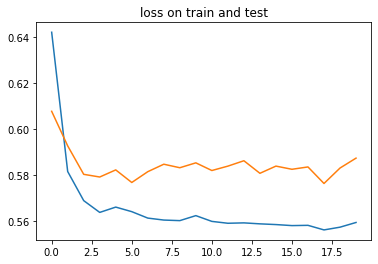

Last loss on train: 0.5592323931972537
Last loss on test: 0.5872505707176108


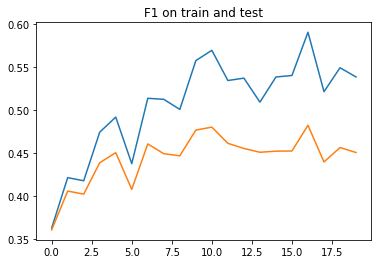

Last F1 on train: 0.5383766819681741
Last F1 on test: 0.45079897657821055


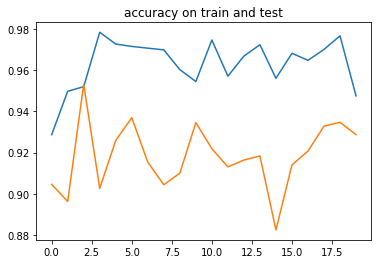

Last accuracy on train: 0.9474481018507375
Last accuracy on test: 0.9287001863121986


In [22]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [23]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8420178534357484


In [24]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

nicht-B wahr-I ,-O trey-O ?-O
na-B und-I ?-O
ja-O ,-O ich-B verstehe-I .-O
--O ach-B ja-I ?-O
dein-B ernst-I ?-O
ach-B ja-I ?-O
auf-B keinen-I fall-I .-O
--O ist-B ja-I schon-I gut-I .-O
schon-B gut-I .-O
--O das-B geht-I nicht-I .-O
--O nicht-B wahr-I ?-O
keine-B ahnung-I ,-O aber-O ein-O paar-O tage-O bestimmt-O noch-O .-O
stimmt-B 's-I ,-O herr-O doktor-O ?-O
--O in-B der-I tat-I !-O
ja-O ,-O na-B und-I ?-O
keine-B ahnung-I .-O
du-B hast-I recht-I .-O
na-B gut-I ,-O mein-O schatz-O .-O
weiß-B ich-I nicht-I .-O
ich-B weiß-I !-O
ist-B schon-I ok-I .-O
was-B du-I nicht-I sagst-I .-O
--O machst-B du-I witze-I ?-O
das-B stimmt-I nicht-I ,-O auch-O wenn-O ich-O nur-O die-O untere-O hälfte-O gesehen-O habe-O .-O
hör-B auf-I !-O
ach-B ja-I ?-O
also-B gut-I .-O
sieht-B so-I aus-I .-O
--O na-B klar-I .-O
ich-B verstehe-I .-O
--O kein-B problem-I .-O
na-B gut-I .-O
nein-O ,-O das-B geht-I nicht-I .-O
keine-B ahnung-I .-O
--O ach-B so-I !-O
--O da-B haben-I sie-I recht-I .-O
das-B geht-I gar-I 